<hr>

Libreta Jupyter del trabajo de investigación

**"Estimación de la evapotranspiración espacio-temporal en olivares (Olea europaea L.) usando imágenes satelitales, Región Tacna, Perú"**

Autor: José Luis Huanuqueño Murillo (JLHM)

Octubre, 2025

<div style="font-size: 0.85em; color: #aab7c4; margin-top: 10px;">
<b><i>Nota de atribución:</i></b> Este cuaderno se basa y adapta el trabajo original de 
Cesar Francisco Vilca Gamarra (2022) desarrollado para arroz en Lambayeque.  
Repositorio fuente: <a href="https://github.com/vilcagamarracf/Inv_arroz_METRIC" style="color:#6ec8d8;">https://github.com/vilcagamarracf/Inv_arroz_METRIC</a>
</div>

<hr>


# Estimación de evapotranspiración en arrozales usando el Modelo METRIC

**Satellite-Based Energy Balance for Mapping Evapotranspiration With Internalized Calibration (METRIC)**

Descripción:
- METRIC es un modelo de procesamiento de imágenes para calcular la ET como residuo del balance energético de la superficie.
- METRIC fue desarrollado por la Universidad de Idaho para su aplicación a imágenes de satélite Landsat con el fin de maximizar la resolución del producto ET (30 m).
- METRIC utiliza como base el proceso pionero de balance energético SEBAL desarrollado en los Países Bajos por Bastiaanssen et al..

Aplicación de referencia:
- [geeSEBAL en GitHub](https://github.com/et-brasil/geeSEBAL/blob/a8242225bcb184329372ee0dbdc411d1e9d5c766/JavaScrpit/tools.js)

# 1. Modelo METRIC

## 1.1. Cargar librerías y archivos

In [1]:
# ==== Header de proyecto (importa módulos de /src y fija rutas) ====
import sys, os
from pathlib import Path

# 1) Detecta la raíz del proyecto buscando la carpeta 'src'
def find_project_root(start: Path, marker="src") -> Path:
    for p in [start, *start.parents]:
        if (p / marker).exists():
            return p
    return start  # fallback

CWD = Path.cwd()
BASE_DIR = find_project_root(CWD, "src")

# 2) Añade /src al path de Python (si no está)
SRC_DIR = BASE_DIR / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

In [3]:
%reset -f

In [2]:
# Ruta del directorio de trabajo
%pwd

'c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks'

In [3]:
import os
os.chdir('c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks')
os.getcwd()

'c:\\Users\\joluh\\OneDrive\\Thesis\\Articles\\Tacna\\Metric_Olive_21_22\\notebooks'

In [4]:
## Google Earth Engine
import ee
import geemap

# AUTENTICARSE
ee.Authenticate(auth_mode='notebook')

# INICIALIZAR USANDO EL PROJECT ID PERSONAL

ee.Initialize(project='ee-joluhumu')
print(ee.String('Hello from the Earth Engine servers!').getInfo())
# Ahora puedes trabajar
# Map = geemap.Map()
# Map

Hello from the Earth Engine servers!


In [5]:
# import ee          # Earth Engine Python API
# ee.Initialize()

import os
import numpy as np
import math
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'  #'serif', 'Arial'  # default es 'sans-serif'

import pandas as pd
pd.set_option('display.max_columns', 30) # Visualizar máximo de 30 columnas

import geemap
import geemap.colormaps as cmp    # Paletas para visualización de imágenes

from funciones import *

In [6]:
# ------------------------------------------------------------------------------------------------
# Pruebas: En caso de realizar alguna edición al archivo 'funciones.py' realizar lo siguiente:
# ------------------------------------------------------------------------------------------------
import importlib
import geopandas as gpd
import sys

importlib.reload(sys.modules['funciones']) # Importa las funciones del archivo con las modificaciones aplicadas
from funciones import *

In [7]:
# # Importar asset público: Distrito de Ferreñafe
gdf = gpd.read_file('C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/shapefiles/Olive_Plot.shp')
# gdf = gpd.read_file('C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Parcelas/Olive_Plot.shp')
asset_dist = geemap.gdf_to_ee(gdf)

# # Filtrar el distrito "FERREÑAFE"
dist_fcol = asset_dist.filter(ee.Filter.eq('NOMBPROV', 'TACNA'))

# # Obtener el bounding box de su geometría
roi = dist_fcol.geometry().bounds()

In [8]:
# ------------------------------------------------
# Importando áreas de estudio
# ------------------------------------------------

# # # Importar asset público: Distrito de Ferreñafe (ejemplo comentado)
# asset_dist = ee.FeatureCollection('D:/2025/Olivo_Tacna/METRIC/METRIC_PRUEBA/SHP/Provincia_Ferreñafe.shp')
# dist_fcol   = asset_dist.filterMetadata('DISTRITO', 'equals', 'FERREÑAFE')
# roi         = dist_fcol.geometry().bounds()   # ee.Geometry tipo caja

# Importar shapefile de Áreas voladas (archivo en local)
ruta = r'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/shapefiles/Olive_Plot.shp'  # <— antes: ruta
# ruta = r'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Parcelas/Olive.shp'  # <— antes: ruta

# Lectura como FeatureCollection con geemap
predios_agricolas   = geemap.shp_to_ee(ruta)

# (Alternativa con asset GEE — ejemplo comentado)
# asset_path         = 'projects/ee-joluhumu/assets/Olivo'
# predios_agricolas  = ee.FeatureCollection(asset_path)

# Capas de visualización: bordes de predios y caja envolvente
predios_vis       = ee.Image().paint(predios_agricolas, 2, 2)  # Ver solo bordes (color=2, grosor=2)
predios_bound     = predios_agricolas.geometry().bounds()
predios_bound_vis = ee.Image().paint(predios_bound, 1, 1)      # Ver solo bordes (color=1, grosor=1)

type(predios_agricolas)  # comprobación rápida del tipo (debería ser ee.featurecollection.FeatureCollection)

# ------------------------------------------------
# Parámetros de visualización de mapas con geemap
# ------------------------------------------------

# Para imágenes Landsat 8 y 9 TOA (RGB natural)
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

# Paletas de colores (hex) para distintos productos
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061']  # rango típico 0–0.5
ndvi_cmap   = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']  # rango típico -0.2–1
ts_cmap     = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']  # 280–330 K (o ~6.85–56.85 °C)
rn_cmp      = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r    = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']  # invertida

# -------------------------------------------------------
# Parámetros de visualización de gráficas con matplotlib
# -------------------------------------------------------

plt.rcParams['font.family']     = 'serif'   # familia tipográfica por defecto para figuras
plt.rcParams['xtick.labelsize'] = 12        # tamaño de fuente para etiquetas del eje X
plt.rcParams['ytick.labelsize'] = 12        # tamaño de fuente para etiquetas del eje Y
plt.rcParams['axes.titlesize']  = 14        # tamaño de fuente para títulos de ejes
plt.rcParams['axes.labelsize']  = 12        # tamaño de fuente para etiquetas de ejes
plt.rcParams['figure.dpi']      = 72        # resolución base de la figura (se puede sobrescribir al guardar)

In [9]:
roi = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive_Plot')
# roi = ee.FeatureCollection('projects/ee-joluhumu/assets/Olive')

## 1.2. Procesamiento de imágenes

In [10]:
# 6 Imágenes Landsat seleccionadas

lista_ids = [
    'LANDSAT/LC08/C02/T1/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220505'
]

In [11]:
# =============================================================
# Parámetros de visualización de mapas con geemap
# =============================================================

# Diccionario de visualización de imágenes Landsat 8 y 9 TOA
vis_rgb = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']} 

# Paletas de colores
albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1  '0048fb',
ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026'] # 280 - 330 en K o 6.85 - 56.85 en °C
rn_cmp = ['560e0d', 'fd5903', 'fbfe04', '3aff01', '01feef', '0000fe', 'fd6dfd', 'ffffff']
rn_cmp_r = ['ffffff', 'fd6dfd', '0000fe', '01feef', '3aff01', 'fbfe04', 'fd5903', '560e0d']

# =============================================================
# Inputs iniciales
# =============================================================

# Datos
# 2 de Diciembre 2021: Almácigo
# 4 de Enero 2022: Transplante

# 8 Imágenes Landsat seleccionadas

lista_ids = [
    'LANDSAT/LC08/C02/T1/LC08_002073_20211126',
    'LANDSAT/LC09/C02/T1/LC09_002073_20211204',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220302',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220318',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220403',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220419',
    'LANDSAT/LC09/C02/T1/LC09_002073_20220427',
    'LANDSAT/LC08/C02/T1/LC08_002073_20220505'
]

# DEM SRTM 
# Ojo: El mapa Aspect no se puede obtener en los límites -> usar áreas mayores al área de estudio

dem = ee.Image("USGS/SRTMGL1_003").clip(roi)

# =============================================================
# Procesar las imagenes e incluirlos en una lista
# =============================================================

# Asignar método de estimación de LAI
# 0: Savi con l=0.1 
# 1: Savi con L=0.5 
# 2: Relación lineal NDVI - IAF: 2.1362*NDVI + 0.0869
# 3: Relación cuadrada NDVI - IAF : 2.3523*NDVI^2 - 1.9013*NDVI + 1.7714
lai_method = 2
albedo_method = '0.254*B2 + 0.149*B3 + 0.147*B4 + 0.311*B5 + 0.103*B6 + 0.036*B7'

HR = [60, 
      61, 
      57, 
      66, 
      61, 
      63, 
      71, 
      65
]

# Lista en blanco que va a contener los resultados
lista_imgprocesadas = []

for index, img_id in enumerate(lista_ids):

    # Imagen Landsat mediante ID
    img_ee = ee.Image(img_id).clip(roi)

    # Procesar Radiación Neta (produce un dict)
    img_procesada_dict = getRadiacionNeta(img_ee, predios_bound, dem,
                                          lai_method, albedo_method, HR[index]) # roi: Ferreñafe

    # Recorte por regiones
    img_procesada_dict['img_productos'] = img_procesada_dict['img_productos'].clip(predios_agricolas) 
    img_procesada_dict['img_toa'] = img_procesada_dict['img_toa']

    # Agregar a lista en blanco
    lista_imgprocesadas.append(img_procesada_dict)

    print(f"Productos y Rn de imagen {img_procesada_dict['fecha']} procesada! lai_method = {lai_method}")

n_imgs = len(lista_imgprocesadas)

Productos y Rn de imagen 2021-11-26 procesada! lai_method = 2
Productos y Rn de imagen 2021-12-04 procesada! lai_method = 2
Productos y Rn de imagen 2022-03-02 procesada! lai_method = 2
Productos y Rn de imagen 2022-03-18 procesada! lai_method = 2
Productos y Rn de imagen 2022-04-03 procesada! lai_method = 2
Productos y Rn de imagen 2022-04-19 procesada! lai_method = 2
Productos y Rn de imagen 2022-04-27 procesada! lai_method = 2
Productos y Rn de imagen 2022-05-05 procesada! lai_method = 2


### Datos para METRIC

In [12]:
# -*- coding: utf-8 -*-
"""
Build list_weather_st con:
- Viento convertido de mph -> km/h (cercano a la hora de sobrevuelo).
- ET como:
    a) VALOR a las 10:00 (una sola marca)             [ET_MODE="at10"]   ← NUEVO
    b) SUMA de 10:00+10:30+11:00                       [ET_MODE="triplet"]
    c) SUMA EN UNA HORA centrada en hora de sobrevuelo [ET_MODE="window"]

Notas:
- Si TIMESTAMP_IS_END_OF_INTERVAL=True, la marca 10:00 representa el intervalo 09:30–10:00.
- Con fallbacks: si no hay exactamente 10:00, se busca la marca más cercana (08–13),
  y si el día no tiene, se usa día cercano (≤7 días).
"""

import pandas as pd
from datetime import datetime, time, timedelta
from typing import Optional, Tuple

# --------- CONFIG ---------
CSV_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"

OVERPASS_LOCAL_STR = "10:30"   # solo para viento (en "window" también para ET)
HOUR_WINDOW_MIN = 60

# ¿La marca horaria del CSV representa el FIN del intervalo? (tu caso típico)
TIMESTAMP_IS_END_OF_INTERVAL = True

# ---- MODO ET ----
# "at10"   -> TOMA SOLO la ET a las 10:00 (una marca)
# "triplet"-> suma(10:00, 10:30, 11:00)
# "window" -> suma en 60 min centrada en OVERPASS_LOCAL_STR
ET_MODE = "at10"   # ← aquí el cambio que pediste

# Fallbacks
FALLBACK_NEAREST_DAY = True
FALLBACK_MAX_DAYS = 7
FALLBACK_INTRA_DAY_SEARCH = True
FALLBACK_INTRA_DAY_RANGE = (8, 13)  # horas enteras permitidas para búsqueda cercana

LISTA_IDS = [
    "LANDSAT/LC08/C02/T1/LC08_002073_20211126",
    "LANDSAT/LC09/C02/T1/LC09_002073_20211204",
    "LANDSAT/LC08/C02/T1/LC08_002073_20220302",
    "LANDSAT/LC08/C02/T1/LC08_002073_20220318",
    "LANDSAT/LC08/C02/T1/LC08_002073_20220403",
    "LANDSAT/LC08/C02/T1/LC08_002073_20220419",
    "LANDSAT/LC09/C02/T1/LC09_002073_20220427",
    "LANDSAT/LC08/C02/T1/LC08_002073_20220505",
]

# --------- UTILIDADES ---------
def id_to_date(id_str: str):
    base = id_str.split("/")[-1]
    date_str = base.split("_")[-1]  # YYYYMMDD
    return pd.to_datetime(date_str, format="%Y%m%d").date()

def read_meteo(path: str) -> pd.DataFrame:
    """
    Asume columnas:
      - 'Datetime' (local) con pasos de 30 min (o similares).
      - 'ET' (mm por intervalo).
      - 'Wind Speed' (mph).
    """
    df = pd.read_csv(path, low_memory=False, encoding_errors="ignore")
    df["__dt__"] = pd.to_datetime(df["Datetime"], errors="coerce")
    df = df.dropna(subset=["__dt__"]).copy()
    df["Date"] = df["__dt__"].dt.date
    df["Hour"] = df["__dt__"].dt.hour
    df["Minute"] = df["__dt__"].dt.minute
    df["ET_num"] = pd.to_numeric(df["ET"], errors="coerce")
    df["Wind_mph"] = pd.to_numeric(df["Wind Speed"], errors="coerce")
    return df

def wind_kmh_near_target(df_day: pd.DataFrame, target_t: time) -> Optional[float]:
    """Selecciona viento (km/h) más cercano a target_t dentro de 8–13; si no hay, usa el más cercano del día."""
    if df_day.empty:
        return None
    target = datetime.combine(pd.Timestamp(df_day["Date"].iloc[0]), target_t)
    w = df_day[(df_day["Hour"] >= 8) & (df_day["Hour"] <= 13)].dropna(subset=["Wind_mph"]).copy()
    if w.empty:
        w = df_day.dropna(subset=["Wind_mph"]).copy()
        if w.empty:
            return None
    idx = (w["__dt__"] - target).abs().idxmin()
    mph = float(w.loc[idx, "Wind_mph"])
    return mph * 1.60934  # km/h

def et_hour_window(df_day: pd.DataFrame, target_t: time, window_min=60) -> Optional[float]:
    """Suma de ET (mm) en una HORA centrada en target_t."""
    if df_day.empty:
        return None
    target_dt = datetime.combine(pd.Timestamp(df_day["Date"].iloc[0]), target_t)
    half = timedelta(minutes=window_min // 2)
    t0, t1 = target_dt - half, target_dt + half

    if TIMESTAMP_IS_END_OF_INTERVAL:
        sel = df_day[(df_day["__dt__"] > t0) & (df_day["__dt__"] <= t1)]
    else:
        sel = df_day[(df_day["__dt__"] >= t0) & (df_day["__dt__"] < t1)]

    et = pd.to_numeric(sel["ET"], errors="coerce").dropna()
    if et.empty:
        return None
    return float(et.clip(lower=0).sum())

# ========= TRIPLETA =========
TRIPLET_TIMES = [time(10, 0), time(10, 30), time(11, 0)]

def _pick_exact_times(df_day: pd.DataFrame, times_list) -> pd.DataFrame:
    if df_day.empty:
        return df_day.iloc[0:0]
    base_date = pd.Timestamp(df_day["Date"].iloc[0])
    wanted = {datetime.combine(base_date, t) for t in times_list}
    return df_day[df_day["__dt__"].isin(wanted)].copy()

def et_sum_triplet(df_day: pd.DataFrame, times_list=TRIPLET_TIMES) -> Optional[float]:
    if df_day.empty:
        return None
    sel = _pick_exact_times(df_day, times_list)
    et = pd.to_numeric(sel["ET"], errors="coerce").dropna()
    if et.empty:
        return None
    return float(et.clip(lower=0).sum())

def et_sum_triplet_nearest_hour(df_day: pd.DataFrame,
                                base_hour: int = 10,
                                times_offsets=((0,0), (0,30), (1,0)),
                                search_range=(8, 13)) -> Tuple[Optional[float], Optional[time]]:
    if df_day.empty:
        return None, None
    hours = list(range(search_range[0], search_range[1] + 1))
    hours.sort(key=lambda h: abs(h - base_hour))
    for h in hours:
        cand_times = [time(h + dh, dm) for (dh, dm) in times_offsets]
        et_val = et_sum_triplet(df_day, cand_times)
        if et_val is not None:
            return et_val, time(h, 0)
    return None, None

# ========= NUEVO: SOLO ET A LAS 10:00 =========
def et_at_exact_or_nearest_10(df_day: pd.DataFrame,
                              target_time=time(10, 0),
                              search_range=(8, 13)) -> Tuple[Optional[float], Optional[datetime]]:
    """
    Devuelve (ET_mm_en_marca, marca_datetime_usada).
    1) Intenta EXACTAMENTE las 10:00 del día.
    2) Si no hay, busca la marca más cercana entre 08:00–13:59.
    """
    if df_day.empty:
        return None, None

    base_date = pd.Timestamp(df_day["Date"].iloc[0])
    target_dt = datetime.combine(base_date, target_time)

    # 1) Exacta
    exact_row = df_day[df_day["__dt__"] == target_dt]
    et_series = pd.to_numeric(exact_row["ET"], errors="coerce").dropna()
    if not et_series.empty:
        return float(et_series.iloc[0]), target_dt

    # 2) Más cercana dentro de rango horario
    df_rng = df_day[(df_day["Hour"] >= search_range[0]) & (df_day["Hour"] <= search_range[1])].copy()
    df_rng = df_rng.dropna(subset=["ET_num"])
    if df_rng.empty:
        return None, None
    idx = (df_rng["__dt__"] - target_dt).abs().idxmin()
    val = float(df_rng.loc[idx, "ET_num"])
    used_dt = pd.Timestamp(df_rng.loc[idx, "__dt__"]).to_pydatetime()
    return val, used_dt

def nearest_day_subset(df: pd.DataFrame, fecha, max_days=7) -> pd.DataFrame:
    if not FALLBACK_NEAREST_DAY:
        return pd.DataFrame(columns=df.columns)
    daily = df.groupby("Date").size().reset_index(name="n")
    if daily.empty:
        return pd.DataFrame(columns=df.columns)
    daily["dist_days"] = (pd.to_datetime(daily["Date"]) - pd.to_datetime(fecha)).abs().dt.days
    daily = daily.sort_values("dist_days")
    for _, r in daily.iterrows():
        if int(r["dist_days"]) <= max_days:
            return df[df["Date"] == r["Date"]]
    return pd.DataFrame(columns=df.columns)

# --------- MAIN ---------
def main():
    df = read_meteo(CSV_PATH)
    fechas_ls = [id_to_date(i) for i in LISTA_IDS]
    target_t = datetime.strptime(OVERPASS_LOCAL_STR, "%H:%M").time()

    list_weather_st = []             # [[km/h, mm/h], ...]
    list_weather_st_simbolico = []   # [["mph*1.60934", mm/h], ...]

    for f in fechas_ls:
        day = df[df["Date"] == f].copy()

        # 1) Viento (km/h) cerca de la hora de paso
        v_kmh = wind_kmh_near_target(day, target_t)
        if v_kmh is None and FALLBACK_NEAREST_DAY:
            day_fb = nearest_day_subset(df, f, max_days=FALLBACK_MAX_DAYS)
            v_kmh = wind_kmh_near_target(day_fb, target_t)

        # 2) ET según modo
        et_mmh = None
        used_token = None  # datetime de la marca usada (solo informativo interno)

        if ET_MODE == "at10":
            val, used_dt = et_at_exact_or_nearest_10(day, target_time=time(10, 0), search_range=FALLBACK_INTRA_DAY_RANGE)
            if val is None and FALLBACK_NEAREST_DAY:
                day_fb = nearest_day_subset(df, f, max_days=FALLBACK_MAX_DAYS)
                val, used_dt = et_at_exact_or_nearest_10(day_fb, target_time=time(10, 0), search_range=FALLBACK_INTRA_DAY_RANGE)
            et_mmh, used_token = val, used_dt

        elif ET_MODE == "triplet":
            et_mmh = et_sum_triplet(day, TRIPLET_TIMES)
            if et_mmh is None and FALLBACK_INTRA_DAY_SEARCH:
                et_alt, h_alt = et_sum_triplet_nearest_hour(
                    day, base_hour=10, times_offsets=((0,0), (0,30), (1,0)),
                    search_range=FALLBACK_INTRA_DAY_RANGE
                )
                et_mmh = et_alt
            if et_mmh is None and FALLBACK_NEAREST_DAY:
                day_fb = nearest_day_subset(df, f, max_days=FALLBACK_MAX_DAYS)
                et_mmh = et_sum_triplet(day_fb, TRIPLET_TIMES)
                if et_mmh is None and FALLBACK_INTRA_DAY_SEARCH:
                    et_alt, h_alt = et_sum_triplet_nearest_hour(
                        day_fb, base_hour=10, times_offsets=((0,0), (0,30), (1,0)),
                        search_range=FALLBACK_INTRA_DAY_RANGE
                    )
                    et_mmh = et_alt

        else:  # "window"
            et_mmh = et_hour_window(day, target_t, window_min=HOUR_WINDOW_MIN)
            if et_mmh is None and FALLBACK_INTRA_DAY_SEARCH:
                best = None
                for h in range(FALLBACK_INTRA_DAY_RANGE[0], FALLBACK_INTRA_DAY_RANGE[1] + 1):
                    val = et_hour_window(day, time(h, 0), window_min=HOUR_WINDOW_MIN)
                    if val is not None:
                        if best is None or abs(h - 10) < abs(best[1] - 10):
                            best = (val, h)
                et_mmh = None if best is None else best[0]
            if et_mmh is None and FALLBACK_NEAREST_DAY:
                day_fb = nearest_day_subset(df, f, max_days=FALLBACK_MAX_DAYS)
                et_mmh = et_hour_window(day_fb, target_t, window_min=HOUR_WINDOW_MIN)

        # ------ Construcción de salidas ------
        list_weather_st.append([
            None if v_kmh is None else round(v_kmh, 3),
            None if et_mmh is None else round(et_mmh, 3)
        ])

        # simbólico viento
        mph_near = None
        def _mph_from(day_like):
            nonlocal mph_near
            if day_like is None or day_like.empty:
                return
            tdt = datetime.combine(pd.Timestamp(day_like["Date"].iloc[0]), target_t)
            win = day_like[(day_like["Hour"] >= 8) & (day_like["Hour"] <= 13)].dropna(subset=["Wind_mph"]).copy()
            if win.empty:
                win = day_like.dropna(subset=["Wind_mph"]).copy()
            if not win.empty:
                idx = (win["__dt__"] - tdt).abs().idxmin()
                mph_near = float(win.loc[idx, "Wind_mph"])

        _mph_from(day)
        if mph_near is None and FALLBACK_NEAREST_DAY:
            day_fb = nearest_day_subset(df, f, max_days=FALLBACK_MAX_DAYS)
            _mph_from(day_fb)

        simb = None if mph_near is None else f"{round(mph_near,2)}*1.60934"
        list_weather_st_simbolico.append([simb, None if et_mmh is None else round(et_mmh, 3)])

    # ----- Imprimir listas listas para copiar -----
    print("list_weather_st = [")
    for v in list_weather_st:
        print(f"    {v},")
    if ET_MODE == "at10":
        et_label = "ET = valor a las 10:00"
        if TIMESTAMP_IS_END_OF_INTERVAL:
            et_label += " (marca 10:00 = intervalo 09:30–10:00)"
    elif ET_MODE == "triplet":
        et_label = "ET = suma(10:00, 10:30, 11:00)"
    else:
        et_label = f"ET = suma en 1 h centrada en {OVERPASS_LOCAL_STR}"
    print("]  # [wind_km/h, ET_mm]  (" + et_label + ")")

    print("\nlist_weather_st_simbolico = [")
    for v in list_weather_st_simbolico:
        ms_token = "None" if v[0] is None else v[0]
        et_token = "None" if v[1] is None else f"{v[1]:.3f}"
        print(f"    [{ms_token}, {et_token}],")
    print("]  # viento como 'mph*1.60934' (km/h), " + et_label)


if __name__ == "__main__":
    main()


list_weather_st = [
    [10.3, 0.43],
    [10.3, 0.38],
    [7.725, 0.43],
    [12.875, 0.46],
    [10.3, 0.41],
    [7.725, 0.36],
    [7.725, 0.33],
    [10.3, 0.36],
]  # [wind_km/h, ET_mm]  (ET = valor a las 10:00 (marca 10:00 = intervalo 09:30–10:00))

list_weather_st_simbolico = [
    [6.4*1.60934, 0.430],
    [6.4*1.60934, 0.380],
    [4.8*1.60934, 0.430],
    [8.0*1.60934, 0.460],
    [6.4*1.60934, 0.410],
    [4.8*1.60934, 0.360],
    [4.8*1.60934, 0.330],
    [6.4*1.60934, 0.360],
]  # viento como 'mph*1.60934' (km/h), ET = valor a las 10:00 (marca 10:00 = intervalo 09:30–10:00)


## 1.3. Estimación de ET con Modelo METRIC

Procesando imagen 2021-11-26 lai_method = 2


coef a: 0.6020348454655464
coef b: -184.4277313564018



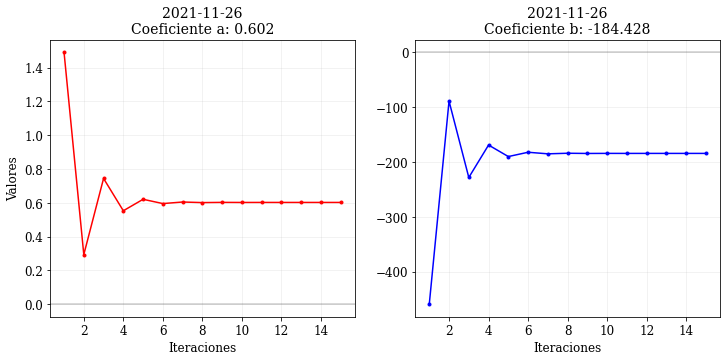


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     42.970403  0.484205  1.121259  0.334519  615.660300  135.135039   
mean    40.279763  0.287669  0.701419  0.247087  551.858498  123.084852   
median  40.312308  0.334747  0.801301  0.242581  554.426038  123.085715   
min     36.810936  0.059862  0.214777  0.197702  467.595988  111.516827   
mode    39.982604  0.367899  0.872807  0.242581  563.487399  124.436382   
stdDev   1.241444  0.110722  0.236525  0.023271   25.600750    4.522443   

               2_H        3_LE    3_LE_vis         ET     ET_pos  
max     422.498062  295.674943  295.674943  10.582013  10.582013  
mean    343.598543   85.325317   85.755056   3.061444   3.076907  
median  354.515980   76.661546   76.661546   2.714328   2.714328  
min     200.233299  -17.083680    0.000000  -0.615063   0.000000  
mode    345.496214   75.020645    0.104086   2.714328   0.003743  
stdDev   44.033341   63.476006   62.857170   2.273795   2.251487

Procesando imagen 2021-12-04 lai_method = 2


coef a: 0.5849792277389793
coef b: -173.98658915416263



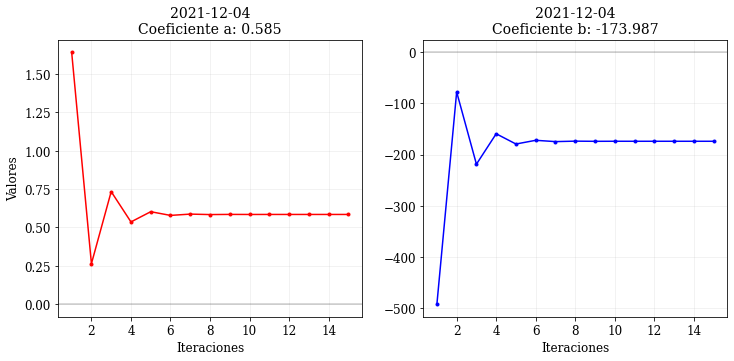


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     34.461521  0.465765  1.081867  0.320077  641.205774  113.294605   
mean    32.033228  0.284560  0.694776  0.240388  585.614268  103.000009   
median  31.989853  0.333093  0.798921  0.235867  589.490007  103.073010   
min     28.897641  0.061707  0.218718  0.191854  506.744443   92.362940   
mode    31.513866  0.373869  0.885241  0.234813  584.630322  102.447705   
stdDev   1.147105  0.107860  0.230411  0.021554   24.959265    4.258873   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     455.055797  279.948525  279.948525  9.942263  9.942263  
mean    395.556997   87.456901   87.551731  3.113282  3.116666  
median  404.612003   80.869886   80.869886  2.842186  2.842186  
min     260.822151   -6.151958    0.000000 -0.219670  0.000000  
mode    412.505215   77.021813   77.021813  1.834077  1.834077  
stdDev   40.104714   57.439968   57.291519  2.040907  2.035599

Procesando imagen 2022-03-02 lai_method = 2


coef a: 0.6690897021909579
coef b: -200.79619850933588



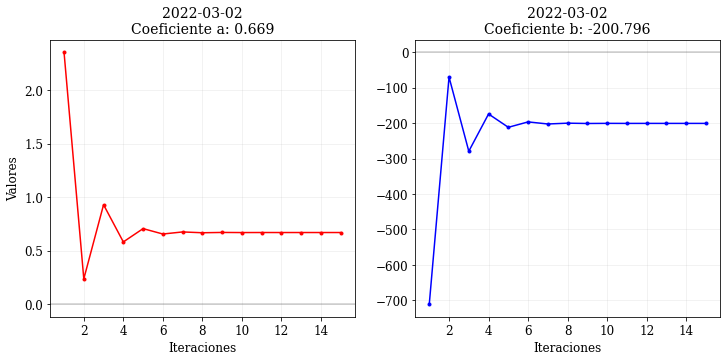


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     35.416797  0.446034  1.039718  0.295390  585.220530  108.826792   
mean    33.453969  0.273813  0.671820  0.220747  535.053191   95.926101   
median  33.459790  0.315355  0.760562  0.214127  536.757453   95.379772   
min     31.304541  0.062503  0.220419  0.175298  462.050341   85.917392   
mode    34.230677  0.344469  0.802934  0.207701  525.711287   93.562774   
stdDev   0.921540  0.101183  0.216146  0.022741   25.277738    4.287902   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     404.628247  220.527884  220.527884  7.852194  7.852194  
mean    352.770959   86.548519   86.592480  3.085871  3.087441  
median  358.865509   83.693039   83.693039  2.980997  2.984671  
min     257.968225   -4.207151    0.000000 -0.150221  0.000000  
mode    372.359068   83.693039   83.693039  2.980997  2.984671  
stdDev   31.620769   49.194234   49.115137  1.751745  1.748916

Procesando imagen 2022-03-18 lai_method = 2


coef a: 0.7622867922012877
coef b: -232.4413737407202



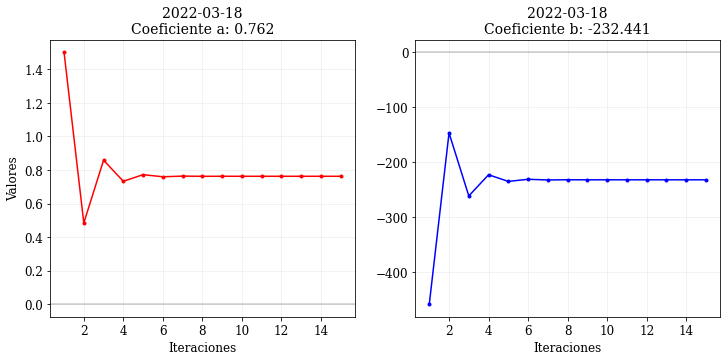


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     38.687716  0.444745  1.036963  0.320445  551.118585  111.902544   
mean    36.618961  0.284925  0.695557  0.226806  492.873648   97.291658   
median  36.607956  0.327042  0.785206  0.218188  494.665309   97.063066   
min     34.125275  0.063175  0.221854  0.175668  423.065271   86.574078   
mode    37.584030  0.348557  0.904125  0.212375  487.441209   97.063066   
stdDev   0.990786  0.108014  0.230739  0.026912   26.767347    4.548728   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     406.450333  279.565340  279.565340  9.979644  9.979644  
mean    321.734809   74.341175   76.829404  2.657846  2.746998  
median  332.036601   73.454222   73.454222  2.595799  2.595799  
min     176.274975  -50.098725    0.000000 -1.795238  0.000000  
mode    333.458941   23.019180    0.057005  0.791091  0.000294  
stdDev   49.376936   68.035242   64.757984  2.430926  2.313381

Procesando imagen 2022-04-03 lai_method = 2


coef a: 0.5702611092113188
coef b: -173.16254821225377



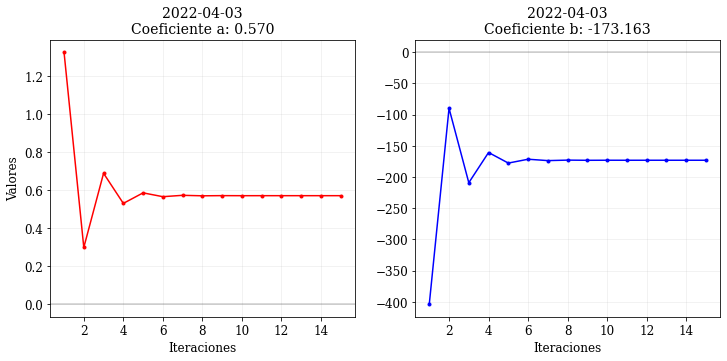


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     39.644950  0.438710  1.024073  0.315535  524.224209  110.920931   
mean    37.265798  0.282824  0.691069  0.222126  469.809055   93.782842   
median  37.296861  0.329235  0.789684  0.213809  470.363085   93.408006   
min     34.319210  0.062630  0.220690  0.167388  396.702152   81.970855   
mode    36.764866  0.342631  0.818065  0.211595  454.802171   90.055371   
stdDev   1.174076  0.106933  0.228431  0.028024   27.644889    4.910312   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     358.235392  242.136504  242.136504  8.646168  8.646168  
mean    300.109274   76.154072   76.906499  2.724472  2.751455  
median  308.007002   73.025335   73.279933  2.601956  2.601956  
min     185.578613  -22.124056    0.000000 -0.793419  0.000000  
mode    331.410491   45.018426    0.011263  2.724756  0.000404  
stdDev   37.791125   57.249098   56.137105  2.045561  2.005623

Procesando imagen 2022-04-19 lai_method = 2


coef a: 0.6968471707851901
coef b: -211.8427391331762



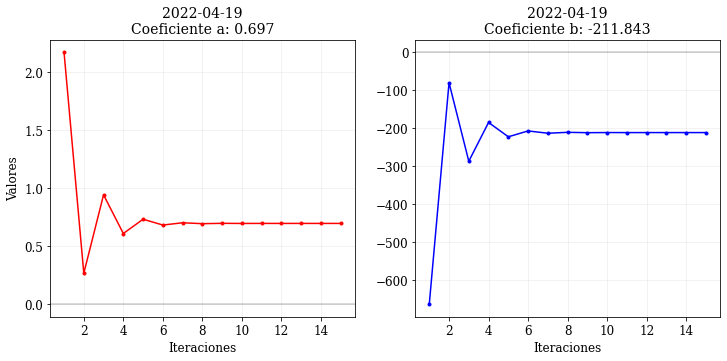


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     39.263306  0.487609  1.128531  0.310084  498.238976  104.098943   
mean    36.631618  0.294913  0.716892  0.214200  442.495965   85.606803   
median  36.619889  0.342288  0.818443  0.204332  444.651489   85.075656   
min     33.598729  0.058229  0.211289  0.156776  367.766786   73.715134   
mode    37.953455  0.362103  0.912626  0.201673  427.475597   84.701510   
stdDev   1.236703  0.115093  0.245862  0.030349   28.445639    5.106678   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     378.595439  249.765823  249.765823  8.911075  8.911075  
mean    301.232506   56.659914   62.289058  2.024790  2.226531  
median  311.481977   55.079253   55.830173  1.971064  1.971064  
min     166.009338  -61.117897    0.000000 -2.191493  0.000000  
mode    314.288151   45.128081    0.010175  0.406945  0.001046  
stdDev   46.163215   65.118970   58.006562  2.326766  2.071559

Procesando imagen 2022-04-27 lai_method = 2


coef a: 0.6358829146250787
coef b: -185.37355423814992



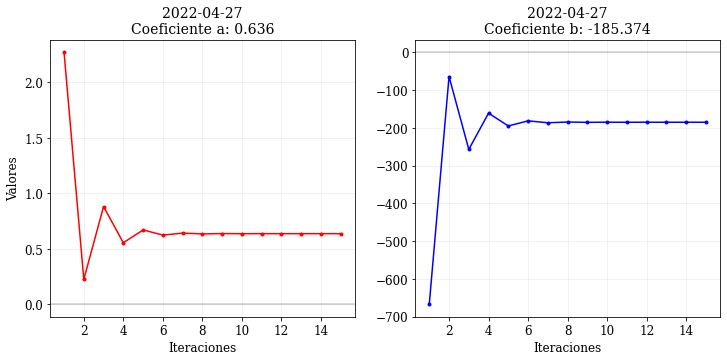


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn        1_G  \
max     26.670455  0.454590  1.057995  0.301037  525.723689  75.010548   
mean    24.715161  0.293702  0.714306  0.205890  464.368379  59.969296   
median  24.699592  0.340404  0.814462  0.195494  464.680945  59.933016   
min     22.140012  0.054399  0.203108  0.149202  382.440005  51.327607   
mode    25.451689  0.405236  0.848636  0.194865  445.453376  57.821331   
stdDev   0.958151  0.115123  0.245926  0.030231   28.713595   4.042687   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     394.065866  240.201718  240.201718  8.475815  8.475815  
mean    333.513548   70.752063   71.234607  2.501055  2.518142  
median  341.612486   63.117311   63.498321  2.214647  2.214647  
min     221.158762  -25.443495    0.000000 -0.900897  0.000000  
mode    321.534732   36.897217    0.000000  1.279989  0.003484  
stdDev   34.232568   51.535979   50.790797  1.819598  1.793172

Procesando imagen 2022-05-05 lai_method = 2


coef a: 0.5625482117647954
coef b: -169.53363457993922



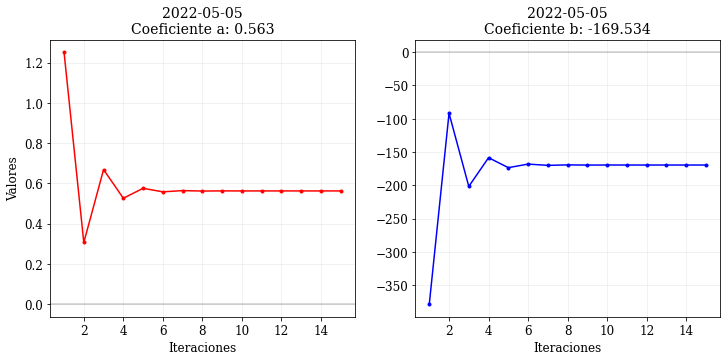


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn        1_G  \
max     37.767387  0.467689  1.085978  0.321247  473.710308  94.418294   
mean    35.154828  0.300408  0.728631  0.208828  412.264104  75.853923   
median  35.171240  0.349425  0.833342  0.197633  414.389628  75.675261   
min     31.896567  0.063181  0.221868  0.147623  333.130051  64.649351   
mode    35.171240  0.380107  0.958857  0.194799  427.513628  76.323740   
stdDev   1.300796  0.118219  0.252540  0.032503   28.936459   5.052921   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     352.091735  228.591622  228.591622  8.142639  8.142639  
mean    287.707385   49.233267   54.558512  1.756710  1.947279  
median  295.608658   44.860172   44.310633  1.575326  1.575326  
min     167.643640  -57.154454    0.000000 -2.046477  0.000000  
mode    318.444011    6.683416    0.010197  0.225919  0.000365  
stdDev   39.129280   58.717738   52.158087  2.094774  1.859727

coef_a      coef_b
11-Nov-2021  0.602035 -184.427731
04-Dic-2021  0.584979 -173.986589
02-Mar-2022  0.669090 -200.796199
18-Mar-2022  0.762287 -232.441374
03-Abr-2022  0.570261 -173.162548
19-Abr-2022  0.696847 -211.842739
27-Abr-2022  0.635883 -185.373554
05-May-2022  0.562548 -169.533635

In [13]:
# =============================================================
# Inputs iniciales
# =============================================================

# En caso de guardar los archivos
save_files = False
carpeta_output = os.getcwd() # output

elev_station = 2.5 # m
n_iteraciones = 15 # 40 <-- Establecer cantidad de iteraciones

lista_fechas = ['11-Nov-2021', '04-Dic-2021', '02-Mar-2022', '18-Mar-2022', '03-Abr-2022', '19-Abr-2022', '27-Abr-2022', '05-May-2022'] # '03-Abr',

# =============================================================
# Datos de estación: Velocidad de viento y ET
list_weather_st = [
    [6.4*1.60934, 0.430],
    [6.4*1.60934, 0.380],
    [4.8*1.60934, 0.430],
    [8.0*1.60934, 0.460],
    [6.4*1.60934, 0.410],
    [4.8*1.60934, 0.360],
    [4.8*1.60934, 0.330],
    [6.4*1.60934, 0.360]
]  # viento como 'mph*1.60934' (km/h), ET en mm/h = suma en 1h centrada en 10:30

# Coordenadas previamente seleccionados (Pixel Frio)
list_coords_pixf = [
    [-70.530185, -18.184348],  # 0 '2021-11-26' n1: 50 n2: 10
    [-70.530215, -18.184375],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.529585, -18.184482],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.529183, -18.18422], # 3 '2022-04-03' n1: 80 n2: 10 
    [-70.52963, -18.184365], # 4 '2022-05-05' n1: 40 n2: 10
    [-70.529963, -18.18462], # 5 '2022-05-21' n1: 50 n2: 10
    [-70.529945, -18.184622], # 6 '2022-06-14' n1: 50 n2: 5
    [-70.529362, -18.184386]
]
# para el primer df_pixeles_frio
# [-70.530208, -18.184683]
# [-70.529344, -18.184652]
# Coordenadas previamente seleccionados (Pixel Caliente)
# Pixeles ndvi-albedo
list_coords_pixc = [
    [-70.531281, -18.18059],  # 0 '2022-01-13' n1: 50 n2: 10
    [-70.530177, -18.181633],  # 1 '2022-01-29' n1: 50 n2: 10
    [-70.530246, -18.181757],  # 2 '2022-03-10' n1: 50 n2: 5
    [-70.529927, -18.182223],  # 3 '2022-04-03' n1: 80 n2: 10
    [-70.531325, -18.180563],  # 4 '2022-05-05' n1: 40 n2: 10 
    [-70.531057, -18.181093],  # 5 '2022-01-13' n1: 50 n2: 10
    [-70.53051, -18.181389],  # 6 '2022-06-14' n1: 50 n2: 5 de aquí cambiar
    [-70.529931, -18.1825]                                                      
]

# pixel caliente inicial
# [-70.534989, -18.178897]
# [-70.530471, -18.181666]
# list_coords_pixf = [
#     [-70.529644, -18.184389],  # 0 '2021-11-26' n1: 50 n2: 10
#     [-70.52963, -18.184345],  # 1 '2022-01-29' n1: 50 n2: 10
#     [-70.52963, -18.184426],  # 2 '2022-03-10' n1: 50 n2: 5
#     [-70.529394, -18.184386], # 3 '2022-04-03' n1: 80 n2: 10 
#     [-70.52963, -18.184365], # 4 '2022-05-05' n1: 40 n2: 10
#     [-70.529963, -18.18462], # 5 '2022-05-21' n1: 50 n2: 10
#     [-70.529652, -18.184365], # 6 '2022-06-14' n1: 50 n2: 5
#     [-70.529362, -18.184386],
#     [-70.529684, -18.184375],
#     [-70.529362, -18.184386]  # 7 '2022-06-14' n1: 50 n2: 5
# ]

# # Coordenadas previamente seleccionados (Pixel Caliente)
# # Pixeles ndvi-albedo
# list_coords_pixc = [
#     [-70.530435, -18.181379],  # 0 '2022-01-13' n1: 50 n2: 10
#     [-70.530177, -18.181633],  # 1 '2022-01-29' n1: 50 n2: 10
#     [-70.531336, -18.180573],  # 2 '2022-03-10' n1: 50 n2: 5
#     [-70.530767, -18.181307],  # 3 '2022-04-03' n1: 80 n2: 10
#     [-70.531325, -18.180563],  # 4 '2022-05-05' n1: 40 n2: 10 
#     [-70.531057, -18.181093],  # 5 '2022-01-13' n1: 50 n2: 10
#     [-70.530767, -18.181093],  # 6 '2022-06-14' n1: 50 n2: 5 de aquí cambiar
#     [-70.529931, -18.1825],
#     [-70.530735, -18.181083],
#     [-70.530231, -18.182479]    # 7 '2022-06-14' n1: 50 n2: 5                                                        
# ]
# =============================================================
# Procesamiento
# =============================================================

lista_imgprocesadas_ET = [] # Lista vacía que almacenará resultados

for index in range(n_imgs):

    # Selección de datos
    img_seleccionada = lista_imgprocesadas[index]
    img_productos = img_seleccionada['img_productos']
    d2 = img_seleccionada['d2']
    fecha = img_seleccionada['fecha']

    print(f'Procesando imagen {fecha} lai_method = {lai_method}\n')

    # Generar estadísticas y guardar en DataFrame
    img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
    img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')

    # =============================================================
    # 1. Establecer valores de pixel frío y caliente
    # Selección de datos mediante el'index'
    # =============================================================

    filtrado_ws, filtrado_et = list_weather_st[index]

    pixf_coord = list_coords_pixf[index]
    pixf_ee_coord = ee.Geometry.Point(pixf_coord)
    pix_f_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

    pixc_coord = list_coords_pixc[index]
    pixc_ee_coord = ee.Geometry.Point(pixc_coord)
    pix_c_values = get_pixel_values(pixc_ee_coord, d2, img_productos)

    # Valores obtenidos por get_pixel_values
    df_pixeles = pd.DataFrame.from_dict({'PixF':pix_f_values,
                                         'PixC':pix_c_values}, orient='columns')
    # Añadir Longitud y Latitud a los pixeles
    lonlat = {'PixF': list_coords_pixf[index], 'PixC': list_coords_pixc[index]}
    df_lonlat = pd.DataFrame(data=lonlat, index=['Longitud', 'Latitud'])

    df_pixeles = pd.concat([df_pixeles, df_lonlat])

    # Exportar datos de pixeles
    if save_files == True:
        df_pixeles.to_csv(os.path.join(carpeta_output, f'{fecha}_pixeles_selec.csv'))

    # =============================================================
    # 2. Flujo de calor sensible H - Proceso Iterativo
    # =============================================================
    resultados_f, resultados_c = parte_iterativa(n_iteraciones,
                                                 elev_station,
                                                 pix_f_values, pix_c_values,
                                                 filtrado_ws, filtrado_et)

    resultados_f_df = pd.DataFrame(resultados_f)
    resultados_c_df = pd.DataFrame(resultados_c)
    # display(resultados_c_df)

    # Guardar dataframe
    if save_files == True:
        resultados_f_df.to_csv(os.path.join(carpeta_output, f'{fecha}_iteraciones_pixf.csv'))
        resultados_c_df.to_csv(os.path.join(carpeta_output, f'{fecha}_iteraciones_pixc.csv'))

    # Coeficientes a y b finales de selección de pixeles frío y caliente
    coef_a = resultados_f[-1]['a_coef']
    coef_b = resultados_f[-1]['b_coef']
    print(f'\ncoef a: {coef_a}\ncoef b: {coef_b}\n')

    # Guardar Gráfica 1x2
    grafica_coefs(resultados_f_df, fecha, coef_a, coef_b,
                  # save_files=os.path.join(carpeta_output, f'{fecha}_coefs.png')
                 )

    # =============================================================
    # 3. Componentes de balance de energía
    # =============================================================

    # 1. Rn
    R_n = img_seleccionada['img_Rn']
    img_Rn = R_n.select('R_n').clip(predios_agricolas)

    # 2. G
    img_tempK = img_productos.select('Ts_k')
    img_G = img_tempK.expression('(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
                                 {'Ts_K': img_tempK,
                                  'albedo': img_productos.select('albedo'),
                                  'NDVI': img_productos.select('NDVI')}
                                ).multiply(R_n.select('R_n'))

    # 3. H
    img_H = get_H_corregido(img_productos, resultados_c, dem, elev_station)
    img_H_stats = get_stats(img_H, predios_agricolas, 30)
    # display(img_H_stats)

    # =============================================================
    # 4. Balance de energía: LE = Rn - G - H
    # Si H es superior a Rn, se producirán valores negativos de LE
    # =============================================================
    img_LE = img_Rn.expression('Rn - G - H',
                               {'Rn': img_Rn,
                                'G': img_G,
                                'H': img_H})

    # Filtrando valores negativos
    # img_LE_gt0 = img_LE.updateMask(img_LE.gt(0)) # Recorta
    img_LE_gt0 = img_LE.where(img_LE.lte(0), 0) # Filtra

    # Unir los componentes en una sola imagen
    img_compbalance = ee.Image([img_Rn, img_G, img_H, img_LE, img_LE_gt0]).rename(['0_Rn', '1_G', '2_H', '3_LE', '3_LE_vis'])
    img_compbalance_stats = get_stats(img_compbalance, predios_agricolas, 30)
    img_compbalance_stats_df = pd.DataFrame.from_dict(img_compbalance_stats, orient='index', dtype='float') # .round(3)

    # =============================================================
    # 5. Evapotranspiración del cultivo ETinst (mm/hr y mm/d)
    # =============================================================

    # ET (mm/hr)
    img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts':img_tempK}).rename('lambda')
    img_ET_inst = img_LE.expression('3600*img_LE/lambda', {'img_LE': img_LE,'lambda': img_lambda}).rename('ET')
    img_ET_inst_pos = img_LE_gt0.expression('3600*img_LE/lambda', {'img_LE': img_LE_gt0,'lambda': img_lambda}).rename('ET_pos')

    # ET (mm/día)      mm/hr * 24 hrs/dia = mm/dia
    img_ET_inst = img_ET_inst.multiply(24)
    img_ET_inst_pos = img_ET_inst_pos.multiply(24)

    # Generar estadísticas y guardar en dataframe
    img_ET_inst_stats = get_stats(img_ET_inst, predios_agricolas, 30)
    img_ET_inst_stats_pos = get_stats(img_ET_inst_pos, predios_agricolas, 30)

    img_ET_inst_stats_df = pd.DataFrame.from_dict(img_ET_inst_stats, orient='index', dtype='float')#.round(3)
    img_ET_inst_stats_pos_df = pd.DataFrame.from_dict(img_ET_inst_stats_pos, orient='index', dtype='float')#.round(3)

    # =============================================================
    # 6. Resultados
    # =============================================================

    # Generar dataframe final
    lista_dfs = [
        img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']],
        img_compbalance_stats_df,
        img_ET_inst_stats_df,
        img_ET_inst_stats_pos_df
    ]
    df_stats = pd.concat(lista_dfs, axis=1)

    if save_files == True:
        df_stats.to_csv(os.path.join(carpeta_output, f'{fecha}_resultados.csv'))

    # Visualización de resultados para comprobación
    print('\nResultados:')
    display(df_stats)

    # Unir imagenes de componentes y ET procesadas en una lista
    img_seleccionada['img_CompBalance'] = img_compbalance # ee.Image
    img_seleccionada['img_ETinst'] = img_ET_inst    # ee.Image
    img_seleccionada['pixeles_stats'] = df_pixeles  # df de valores solamente de pixeles
    img_seleccionada['stats'] = df_stats            # df general de la imagen
    img_seleccionada['pix_f'] = resultados_f_df     # df (f de frío)
    img_seleccionada['pix_c'] = resultados_c_df     # df (c de caliente)
    img_seleccionada['pixeles'] = {'coef_a':coef_a, 'coef_b':coef_b}

    # Finalmente agregamos cada imagen procesada a una lista
    lista_imgprocesadas_ET.append(img_seleccionada)

# Coeficientes finales
tabla_coefs(lista_imgprocesadas_ET, n_imgs, lista_fechas,
            # save_files=os.path.join(carpeta_output, 'tabla_coeficientes.csv')
           )

# lista_imgprocesadas_ET[index]['stats'] # Para ver los datos de las iteraciones por imagen

In [16]:
# =============================================================
# Q1 TABLE (Excel con merges + CSV) — UTM WGS84 Zone 19S
# =============================================================
import numpy as np
import pandas as pd
import os

# --- conversión a UTM con pyproj ---
try:
    from pyproj import Transformer
    transformer_utm19s = Transformer.from_crs("EPSG:4326", "EPSG:32719", always_xy=True)  # lon/lat -> UTM19S
except Exception as e:
    raise RuntimeError(
        "Necesito pyproj para convertir lon/lat a UTM. Instala con: pip install pyproj"
    ) from e

def _pick_from_series(sr: pd.Series, candidates, default=np.nan):
    if not isinstance(candidates, (list, tuple)):
        candidates = [candidates]
    idx = list(sr.index)
    low = {str(k).lower(): k for k in idx}
    # exact (case-insensitive)
    for c in candidates:
        c_low = str(c).lower()
        if c_low in low:
            return sr[low[c_low]]
    # contains (case-insensitive)
    for c in candidates:
        c_low = str(c).lower()
        for k in idx:
            if c_low in str(k).lower():
                return sr[k]
    return default

def _get_column(df: pd.DataFrame, name: str):
    if name in df.columns:
        return df[name]
    for c in df.columns:
        if str(c).lower() == name.lower():
            return df[c]
    for c in df.columns:
        if name.lower() in str(c).lower():
            return df[c]
    raise KeyError(f"Column '{name}' not found. Available: {list(df.columns)}")

# aliases robustos
NDVI_KEYS   = ['NDVI']
ALBEDO_KEYS = ['albedo','Albedo','ALBEDO','Alb']
LAI_KEYS    = ['LAI','IAF']
TS_KEYS     = ['Ts_k','Ts (K)','T(K)','TsK']
LON_KEYS    = ['Longitud','lon','longitude','x']
LAT_KEYS    = ['Latitud','lat','latitude','y']

rows = []
for img in lista_imgprocesadas_ET:
    fecha = img['fecha']
    df_pix = img['pixeles_stats']   # índices = variables; columnas = PixF / PixC
    a = img['pixeles']['coef_a']
    b = img['pixeles']['coef_b']

    try:   cold = _get_column(df_pix, 'PixF')
    except KeyError:
        cold = df_pix.iloc[:, 0]
    try:   hot  = _get_column(df_pix, 'PixC')
    except KeyError:
        hot  = df_pix.iloc[:, 1] if df_pix.shape[1] > 1 else df_pix.iloc[:, 0]

    # extraer lon/lat en grados (puede venir con coma decimal)
    def _to_float(v):
        return pd.to_numeric(str(v).replace(',', '.'), errors='coerce')

    cold_lon = _to_float(_pick_from_series(cold, LON_KEYS))
    cold_lat = _to_float(_pick_from_series(cold, LAT_KEYS))
    hot_lon  = _to_float(_pick_from_series(hot,  LON_KEYS))
    hot_lat  = _to_float(_pick_from_series(hot,  LAT_KEYS))

    # convertir a UTM 19S (WGS84)
    cold_e, cold_n = transformer_utm19s.transform(cold_lon, cold_lat) if pd.notna(cold_lon) and pd.notna(cold_lat) else (np.nan, np.nan)
    hot_e,  hot_n  = transformer_utm19s.transform(hot_lon,  hot_lat)  if pd.notna(hot_lon)  and pd.notna(hot_lat)  else (np.nan, np.nan)

    # armar filas
    rows.append({
        'Date': fecha, 'Pixel': 'Cold Pixel',
        'Easting (m)': cold_e, 'Northing (m)': cold_n,
        'NDVI': _to_float(_pick_from_series(cold, NDVI_KEYS)),
        'Albedo': _to_float(_pick_from_series(cold, ALBEDO_KEYS)),
        'LAI': _to_float(_pick_from_series(cold, LAI_KEYS)),
        'Ts (K)': _to_float(_pick_from_series(cold, TS_KEYS)),
        'a': a, 'b': b
    })
    rows.append({
        'Date': fecha, 'Pixel': 'Hot Pixel',
        'Easting (m)': hot_e, 'Northing (m)': hot_n,
        'NDVI': _to_float(_pick_from_series(hot, NDVI_KEYS)),
        'Albedo': _to_float(_pick_from_series(hot, ALBEDO_KEYS)),
        'LAI': _to_float(_pick_from_series(hot, LAI_KEYS)),
        'Ts (K)': _to_float(_pick_from_series(hot, TS_KEYS)),
        'a': a, 'b': b
    })

df_final = pd.DataFrame(rows)

# parse y ordenar fechas
def _try_parse_date(x):
    for fmt in ("%d-%b-%Y","%Y-%m-%d","%d/%m/%Y","%d-%m-%Y"):
        try:
            return pd.to_datetime(x, format=fmt)
        except Exception:
            pass
    return pd.NaT
df_final['_ord'] = df_final['Date'].map(_try_parse_date)
df_final = df_final.sort_values(['_ord','Date','Pixel']).drop(columns=['_ord'])

# redondeos Q1
round_map = {'Easting (m)':0, 'Northing (m)':0, 'NDVI':3, 'Albedo':2, 'LAI':2, 'Ts (K)':2, 'a':5, 'b':5}
for k, r in round_map.items():
    if k in df_final.columns:
        df_final[k] = df_final[k].round(r)

# ---------------- CSV (sin merges; repetimos a y b en ambas filas) ----------------
csv_cols = ['Date','Pixel','Easting (m)','Northing (m)','NDVI','Albedo','LAI','Ts (K)','a','b']
df_csv = df_final[csv_cols].copy()
csv_path = os.path.join(carpeta_output, "Pixel_Statistics_UTM19S_WGS84.csv")
df_csv.to_csv(csv_path, index=False, encoding='utf-8')
print(f"CSV saved: {csv_path}")

# ---------------- Excel con merges (Date, a, b) ----------------
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment, Font, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo

xlsx_path = os.path.join(carpeta_output, "Pixel_Statistics_UTM19S_WGS84.xlsx")
wb = Workbook()
ws = wb.active
ws.title = "Pixel Statistics"

headers = csv_cols
ws.append(headers)

for _, r in df_final.iterrows():
    ws.append([r.get(h, None) for h in headers])

# Estilos
bold = Font(bold=True)
center = Alignment(horizontal="center", vertical="center")
left   = Alignment(horizontal="left",   vertical="center")
right  = Alignment(horizontal="right",  vertical="center")
thin = Side(style='thin', color='000000')
border = Border(top=thin, bottom=thin, left=thin, right=thin)

for j, h in enumerate(headers, 1):
    cell = ws.cell(row=1, column=j)
    cell.font = bold
    cell.alignment = center
    cell.border = border

fmt_map = {
    'Easting (m)': '0', 'Northing (m)': '0',
    'NDVI': '0.000', 'Albedo': '0.00', 'LAI': '0.00', 'Ts (K)': '0.00',
    'a': '0.00000', 'b': '0.00000'
}
col_idx = {h: j for j, h in enumerate(headers, 1)}
for r in range(2, ws.max_row+1):
    ws.cell(row=r, column=col_idx['Date']).alignment = center
    ws.cell(row=r, column=col_idx['Pixel']).alignment = left
    for k, f in fmt_map.items():
        c = ws.cell(row=r, column=col_idx[k])
        c.number_format = f
        c.alignment = right
        c.border = border
    for j in range(1, len(headers)+1):
        ws.cell(row=r, column=j).border = border

# Autoancho
for j in range(1, len(headers)+1):
    col = get_column_letter(j)
    maxlen = max(len(str(ws.cell(row=r, column=j).value or "")) for r in range(1, ws.max_row+1))
    ws.column_dimensions[col].width = min(max(10, maxlen+2), 26)

# MERGES por fecha (agrupa Cold/Hot) en Date, a y b
row_start = 2
while row_start <= ws.max_row:
    date_val = ws.cell(row=row_start, column=col_idx['Date']).value
    r = row_start
    while r <= ws.max_row and ws.cell(row=r, column=col_idx['Date']).value == date_val:
        r += 1
    row_end = r - 1
    if row_end > row_start:
        ws.merge_cells(start_row=row_start, start_column=col_idx['Date'], end_row=row_end, end_column=col_idx['Date'])
        ws.merge_cells(start_row=row_start, start_column=col_idx['a'],    end_row=row_end, end_column=col_idx['a'])
        ws.merge_cells(start_row=row_start, start_column=col_idx['b'],    end_row=row_end, end_column=col_idx['b'])
        ws.cell(row=row_start, column=col_idx['Date']).alignment = center
        ws.cell(row=row_start, column=col_idx['a']).alignment    = center
        ws.cell(row=row_start, column=col_idx['b']).alignment    = center
    row_start = row_end + 1

# Tabla y nota
tbl = Table(displayName="PixelTable", ref=f"A1:{get_column_letter(ws.max_column)}{ws.max_row}")
tbl.tableStyleInfo = TableStyleInfo(name="TableStyleMedium9", showFirstColumn=False, showLastColumn=False,
                                    showRowStripes=True, showColumnStripes=False)
ws.add_table(tbl)

note_row = ws.max_row + 2
ws.cell(row=note_row, column=1, value="Note: Coordinates are reported in UTM (Zone 19S), WGS84 datum. Coefficients a and b are common to Cold/Hot pixel per date.").font = Font(italic=True)
ws.merge_cells(start_row=note_row, start_column=1, end_row=note_row, end_column=len(headers))

wb.save(xlsx_path)
print(f"Excel saved: {xlsx_path}")


CSV saved: c:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\notebooks\Pixel_Statistics_UTM19S_WGS84.csv
Excel saved: c:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\notebooks\Pixel_Statistics_UTM19S_WGS84.xlsx


## Tabla para paper

Procesando imagen 2021-11-26 lai_method = 2


coef a: 0.6020348454655464
coef b: -184.4277313564018



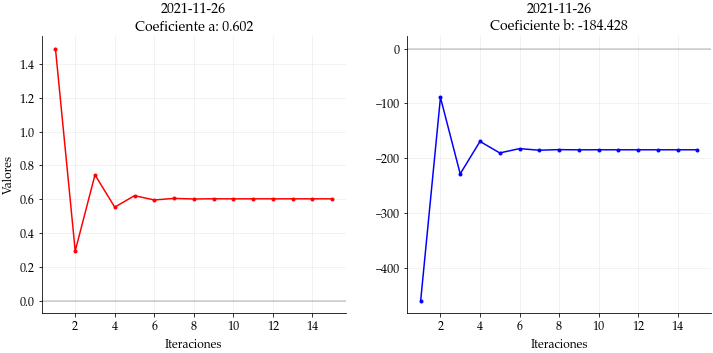


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     42.970403  0.484205  1.121259  0.334519  615.660300  135.135039   
mean    40.279763  0.287669  0.701419  0.247087  551.858498  123.084852   
median  40.312308  0.334747  0.801301  0.242581  554.426038  123.085715   
min     36.810936  0.059862  0.214777  0.197702  467.595988  111.516827   
mode    39.982604  0.367899  0.872807  0.242581  563.487399  124.436382   
stdDev   1.241444  0.110722  0.236525  0.023271   25.600750    4.522443   

               2_H        3_LE    3_LE_vis         ET     ET_pos  
max     422.498062  295.674943  295.674943  10.582013  10.582013  
mean    343.598543   85.325317   85.755056   3.061444   3.076907  
median  354.515980   76.661546   76.661546   2.714328   2.714328  
min     200.233299  -17.083680    0.000000  -0.615063   0.000000  
mode    345.496214   75.020645    0.104086   2.714328   0.003743  
stdDev   44.033341   63.476006   62.857170   2.273795   2.251487

Procesando imagen 2021-12-04 lai_method = 2


coef a: 0.5849792277389793
coef b: -173.98658915416263



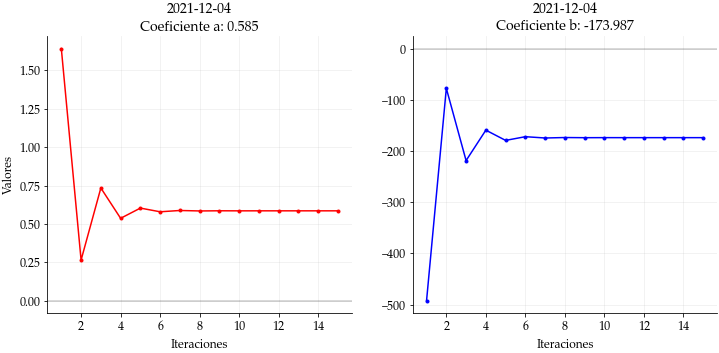


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     34.461521  0.465765  1.081867  0.320077  641.205774  113.294605   
mean    32.033228  0.284560  0.694776  0.240388  585.614268  103.000009   
median  31.989853  0.333093  0.798921  0.235867  589.490007  103.073010   
min     28.897641  0.061707  0.218718  0.191854  506.744443   92.362940   
mode    31.513866  0.373869  0.885241  0.234813  584.630322  102.447705   
stdDev   1.147105  0.107860  0.230411  0.021554   24.959265    4.258873   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     455.055797  279.948525  279.948525  9.942263  9.942263  
mean    395.556997   87.456901   87.551731  3.113282  3.116666  
median  404.612003   80.869886   80.869886  2.842186  2.842186  
min     260.822151   -6.151958    0.000000 -0.219670  0.000000  
mode    412.505215   77.021813   77.021813  1.834077  1.834077  
stdDev   40.104714   57.439968   57.291519  2.040907  2.035599

Procesando imagen 2022-03-02 lai_method = 2


coef a: 0.6690897021909579
coef b: -200.79619850933588



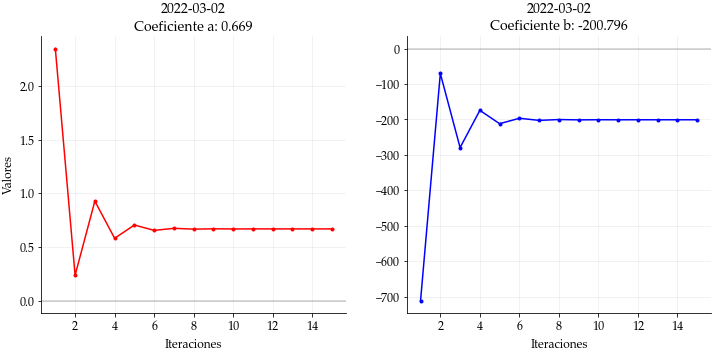


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     35.416797  0.446034  1.039718  0.295390  585.220530  108.826792   
mean    33.453969  0.273813  0.671820  0.220747  535.053191   95.926101   
median  33.459790  0.315355  0.760562  0.214127  536.757453   95.379772   
min     31.304541  0.062503  0.220419  0.175298  462.050341   85.917392   
mode    34.230677  0.344469  0.802934  0.207701  525.711287   93.562774   
stdDev   0.921540  0.101183  0.216146  0.022741   25.277738    4.287902   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     404.628247  220.527884  220.527884  7.852194  7.852194  
mean    352.770959   86.548519   86.592480  3.085871  3.087441  
median  358.865509   83.693039   83.693039  2.980997  2.984671  
min     257.968225   -4.207151    0.000000 -0.150221  0.000000  
mode    372.359068   83.693039   83.693039  2.980997  2.984671  
stdDev   31.620769   49.194234   49.115137  1.751745  1.748916

Procesando imagen 2022-03-18 lai_method = 2


coef a: 0.7622867922012877
coef b: -232.4413737407202



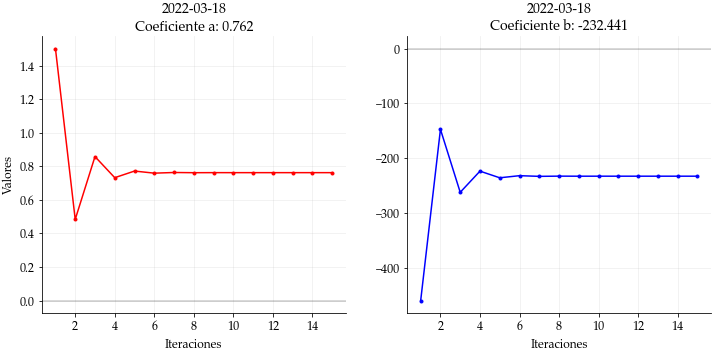


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     38.687716  0.444745  1.036963  0.320445  551.118585  111.902544   
mean    36.618961  0.284925  0.695557  0.226806  492.873648   97.291658   
median  36.607956  0.327042  0.785206  0.218188  494.665309   97.063066   
min     34.125275  0.063175  0.221854  0.175668  423.065271   86.574078   
mode    37.584030  0.348557  0.904125  0.212375  487.441209   97.063066   
stdDev   0.990786  0.108014  0.230739  0.026912   26.767347    4.548728   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     406.450333  279.565340  279.565340  9.979644  9.979644  
mean    321.734809   74.341175   76.829404  2.657846  2.746998  
median  332.036601   73.454222   73.454222  2.595799  2.595799  
min     176.274975  -50.098725    0.000000 -1.795238  0.000000  
mode    333.458941   23.019180    0.057005  0.791091  0.000294  
stdDev   49.376936   68.035242   64.757984  2.430926  2.313381

Procesando imagen 2022-04-03 lai_method = 2


coef a: 0.5702611092113188
coef b: -173.16254821225377



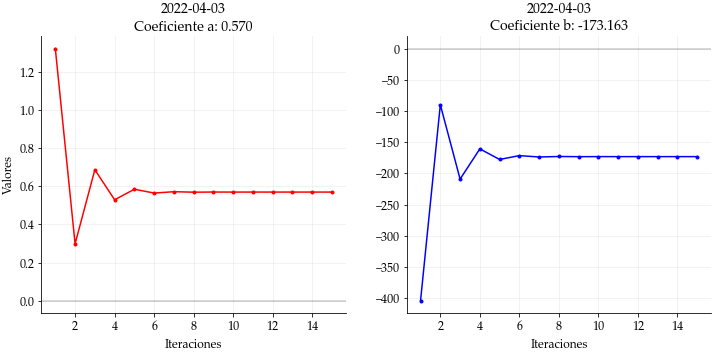


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     39.644950  0.438710  1.024073  0.315535  524.224209  110.920931   
mean    37.265798  0.282824  0.691069  0.222126  469.809055   93.782842   
median  37.296861  0.329235  0.789684  0.213809  470.363085   93.408006   
min     34.319210  0.062630  0.220690  0.167388  396.702152   81.970855   
mode    36.764866  0.342631  0.818065  0.211595  454.802171   90.055371   
stdDev   1.174076  0.106933  0.228431  0.028024   27.644889    4.910312   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     358.235392  242.136504  242.136504  8.646168  8.646168  
mean    300.109274   76.154072   76.906499  2.724472  2.751455  
median  308.007002   73.025335   73.279933  2.601956  2.601956  
min     185.578613  -22.124056    0.000000 -0.793419  0.000000  
mode    331.410491   45.018426    0.011263  2.724756  0.000404  
stdDev   37.791125   57.249098   56.137105  2.045561  2.005623

Procesando imagen 2022-04-19 lai_method = 2


coef a: 0.6968471707851901
coef b: -211.8427391331762



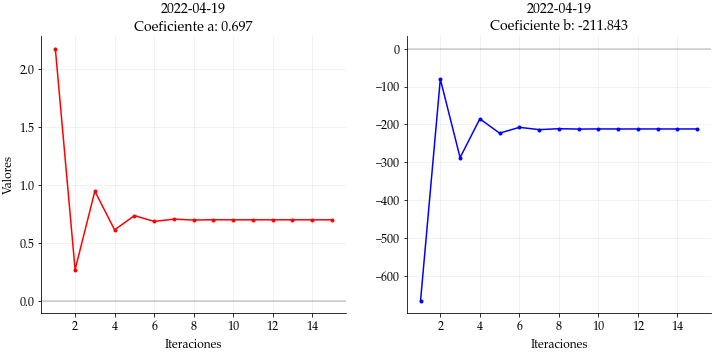


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     39.263306  0.487609  1.128531  0.310084  498.238976  104.098943   
mean    36.631618  0.294913  0.716892  0.214200  442.495965   85.606803   
median  36.619889  0.342288  0.818443  0.204332  444.651489   85.075656   
min     33.598729  0.058229  0.211289  0.156776  367.766786   73.715134   
mode    37.953455  0.362103  0.912626  0.201673  427.475597   84.701510   
stdDev   1.236703  0.115093  0.245862  0.030349   28.445639    5.106678   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     378.595439  249.765823  249.765823  8.911075  8.911075  
mean    301.232506   56.659914   62.289058  2.024790  2.226531  
median  311.481977   55.079253   55.830173  1.971064  1.971064  
min     166.009338  -61.117897    0.000000 -2.191493  0.000000  
mode    314.288151   45.128081    0.010175  0.406945  0.001046  
stdDev   46.163215   65.118970   58.006562  2.326766  2.071559

Procesando imagen 2022-04-27 lai_method = 2


coef a: 0.6358829146250787
coef b: -185.37355423814992



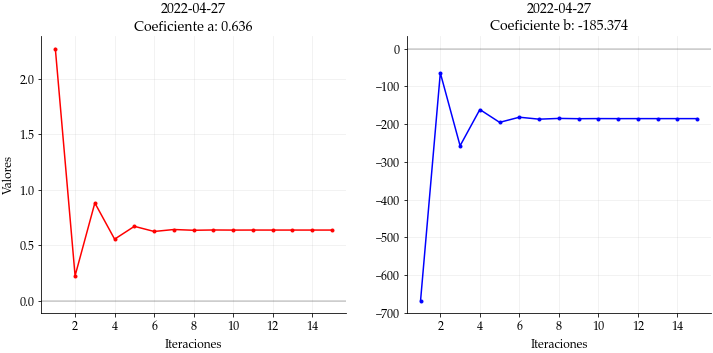


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn        1_G  \
max     26.670455  0.454590  1.057995  0.301037  525.723689  75.010548   
mean    24.715161  0.293702  0.714306  0.205890  464.368379  59.969296   
median  24.699592  0.340404  0.814462  0.195494  464.680945  59.933016   
min     22.140012  0.054399  0.203108  0.149202  382.440005  51.327607   
mode    25.451689  0.405236  0.848636  0.194865  445.453376  57.821331   
stdDev   0.958151  0.115123  0.245926  0.030231   28.713595   4.042687   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     394.065866  240.201718  240.201718  8.475815  8.475815  
mean    333.513548   70.752063   71.234607  2.501055  2.518142  
median  341.612486   63.117311   63.498321  2.214647  2.214647  
min     221.158762  -25.443495    0.000000 -0.900897  0.000000  
mode    321.534732   36.897217    0.000000  1.279989  0.003484  
stdDev   34.232568   51.535979   50.790797  1.819598  1.793172

Procesando imagen 2022-05-05 lai_method = 2


coef a: 0.5625482117647954
coef b: -169.53363457993922



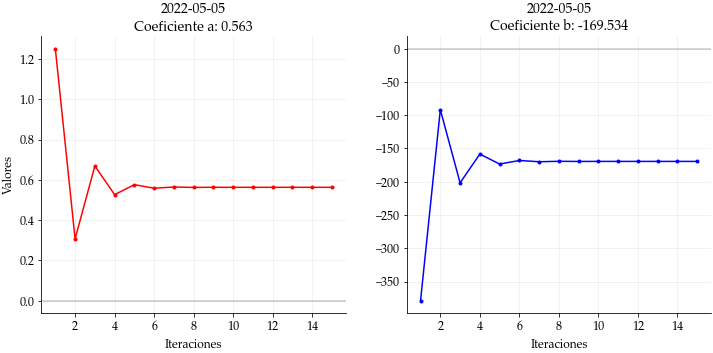


Resultados:


Ts_c      NDVI       LAI    albedo        0_Rn        1_G  \
max     37.767387  0.467689  1.085978  0.321247  473.710308  94.418294   
mean    35.154828  0.300408  0.728631  0.208828  412.264104  75.853923   
median  35.171240  0.349425  0.833342  0.197633  414.389628  75.675261   
min     31.896567  0.063181  0.221868  0.147623  333.130051  64.649351   
mode    35.171240  0.380107  0.958857  0.194799  427.513628  76.323740   
stdDev   1.300796  0.118219  0.252540  0.032503   28.936459   5.052921   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     352.091735  228.591622  228.591622  8.142639  8.142639  
mean    287.707385   49.233267   54.558512  1.756710  1.947279  
median  295.608658   44.860172   44.310633  1.575326  1.575326  
min     167.643640  -57.154454    0.000000 -2.046477  0.000000  
mode    318.444011    6.683416    0.010197  0.225919  0.000365  
stdDev   39.129280   58.717738   52.158087  2.094774  1.859727

✅ Q1 Summary Table with ETa⁺ saved to:
c:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\notebooks\Summary_Ranges_Q1_ETaPlus.csv


Acquisition Date            NDVI (–)             LAI (–)  \
0       2021-11-26  0.36 (0.15 – 0.45)  0.86 (0.42 – 1.04)   
1       2021-12-04  0.36 (0.16 – 0.44)  0.86 (0.42 – 1.03)   
2       2022-03-02  0.35 (0.15 – 0.41)  0.83 (0.41 – 0.96)   
3       2022-03-18  0.36 (0.15 – 0.43)  0.86 (0.40 – 1.00)   
4       2022-04-03  0.36 (0.15 – 0.42)  0.86 (0.40 – 0.98)   
5       2022-04-19  0.38 (0.14 – 0.45)  0.89 (0.39 – 1.04)   
6       2022-04-27  0.38 (0.15 – 0.44)  0.89 (0.40 – 1.03)   
7       2022-05-05  0.39 (0.13 – 0.45)  0.91 (0.37 – 1.04)   

           Albedo (–)                Rn (W m⁻²)                 G (W m⁻²)  \
0  0.24 (0.22 – 0.31)  558.69 (493.56 – 595.58)  121.51 (113.60 – 132.50)   
1  0.23 (0.21 – 0.29)  592.96 (524.87 – 628.47)   101.42 (94.77 – 111.05)   
2  0.21 (0.19 – 0.27)  541.69 (474.93 – 582.14)    94.31 (85.92 – 104.98)   
3  0.21 (0.19 – 0.28)  500.11 (435.96 – 545.76)    95.67 (86.57 – 107.04)   
4  0.21 (0.18 – 0.28)  476.73 (410.01 – 524.22)    92.07 (81.97 – 103.65)   
5  0.20 (0.17 – 0.29)  449.86 (382.49 – 498.24)     83.70 (73.72 – 95.12)   
6  0.19 (0.16 – 0.28)  470.68 (410.43 – 525.72)     58.45 (51.33 – 66.64)   
7  0.19 (0.16 – 0.27)  418.98 (357.51 – 473.71)     74.06 (64.65 – 84.71)   

                  H (W m⁻²)               LE (W m⁻²)         ETa (mm d⁻¹)  \
0  338.02 (216.22 – 422.50)  99.31 (-12.91 – 263.62)  3.56 (-0.46 – 9.44)   
1  391.25 (286.23 – 450.86)   99.91 (-5.03 – 246.04)  3.56 (-0.18 – 8.74)   
2  348.28 (264.53 – 404.63)   99.35 (-4.21 – 211.12)  3.54 (-0.15 – 7.52)   
3  310.44 (208.80 – 398.32)  93.87 (-31.10 – 230.99)  3.36 (-1.11 – 8.25)   
4  294.29 (191.79 – 355.37)  90.51 (-11.17 – 233.19)  3.24 (-0.40 – 8.33)   
5  288.95 (185.83 – 369.68)  77.32 (-47.42 – 215.26)  2.76 (-1.70 – 7.68)   
6  332.49 (244.74 – 394.07)  79.76 (-25.44 – 199.06)  2.82 (-0.90 – 7.03)   
7  281.85 (203.14 – 352.09)  63.47 (-54.77 – 178.57)  2.27 (-1.96 – 6.37)   

        ETa⁺ (mm d⁻¹)  
0  3.57 (0.00 – 9.44)  
1  3.56 (0.00 – 8.74)  
2  3.54 (0.00 – 7.52)  
3  3.37 (0.00 – 8.25)  
4  3.24 (0.00 – 8.33)  
5  2.79 (0.00 – 7.68)  
6  2.82 (0.00 – 7.03)  
7  2.29 (0.00 – 6.37)

In [17]:
# =============================================================
# IMPORTS
# =============================================================
import ee
import pandas as pd
import os

# =============================================================
# INPUTS INICIALES (tu bloque, se mantiene)
# =============================================================
# save_files, carpeta_output, elev_station, n_iteraciones, lista_fechas, list_weather_st,
# list_coords_pixf, list_coords_pixc, lista_imgprocesadas, n_imgs, predios_agricolas, dem,
# parte_iterativa, get_stats, get_pixel_values, grafica_coefs, lai_method
# (Se asume definidos previamente)

# =============================================================
# ROI: UTM 19S, WGS84 (EPSG:32719) + erosion to avoid border pixels
# =============================================================
RUTA_SHP_NEW      = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW         = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW  = 15  # meters (~0.5 Landsat pixel)

roi_new_fc   = ee.FeatureCollection(ASSET_NEW)
roi_new_geom = roi_new_fc.geometry().buffer(-BUFFER_ERODE_NEW)  # erode polygon

# =============================================================
# HELPERS (robustos y Q1-ready)
# =============================================================
def _select_any(img: ee.Image, names):
    """Devuelve la primera banda existente de una lista de candidatos."""
    if not isinstance(names, (list, tuple)):
        names = [names]
    for nm in names:
        try:
            return img.select(nm)
        except Exception:
            continue
    raise ValueError(f"No band found among {names}")

def _ensure_et_pos(img_et: ee.Image) -> ee.Image:
    """Garantiza que exista ET_pos = max(ET,0)."""
    try:
        img_et.select('ET_pos')
        return img_et
    except Exception:
        et = img_et.select('ET')
        et_pos = et.max(ee.Image(0)).rename('ET_pos')
        return et.addBands(et_pos)

def _reduce_mean_min_max(img: ee.Image, roi, scale=30):
    """mean, min, max en una sola pasada."""
    red = img.reduceRegion(
        reducer=ee.Reducer.mean()
                 .combine(ee.Reducer.min(), sharedInputs=True)
                 .combine(ee.Reducer.max(), sharedInputs=True),
        geometry=roi,
        scale=scale,
        maxPixels=1e13,
        bestEffort=True
    )
    return red.getInfo()

def _fmt_triplet(d, band, nd=2):
    """Formatea 'mean (min–max)' con nd decimales."""
    m  = d.get(f'{band}_mean', None)
    mn = d.get(f'{band}_min',  None)
    mx = d.get(f'{band}_max',  None)
    if None in (m, mn, mx):
        return ""
    return f"{float(m):.{nd}f} ({float(mn):.{nd}f} – {float(mx):.{nd}f})"

# =============================================================
# BUCLE DE PROCESAMIENTO (con ET y ET_pos SIEMPRE dentro de img_ETinst)
# =============================================================
lista_imgprocesadas_ET = []  # salida final

for index in range(n_imgs):
    # --- selección y logs ---
    img_seleccionada = lista_imgprocesadas[index]
    img_productos = img_seleccionada['img_productos']
    d2 = img_seleccionada['d2']
    fecha = img_seleccionada['fecha']

    print(f'Procesando imagen {fecha} lai_method = {lai_method}\n')

    # --- stats de productos base ---
    img_productos_dict = get_stats(img_productos, predios_agricolas, 30)
    img_productos_df = pd.DataFrame.from_dict(img_productos_dict, orient='index')

    # --- 1) Píxeles frío/caliente ---
    filtrado_ws, filtrado_et = list_weather_st[index]

    pixf_coord = list_coords_pixf[index]
    pixf_ee_coord = ee.Geometry.Point(pixf_coord)
    pix_f_values = get_pixel_values(pixf_ee_coord, d2, img_productos)

    pixc_coord = list_coords_pixc[index]
    pixc_ee_coord = ee.Geometry.Point(pixc_coord)
    pix_c_values = get_pixel_values(pixc_ee_coord, d2, img_productos)

    # dataframe de pixeles (valores + lon/lat)
    df_pixeles = pd.DataFrame.from_dict({'PixF': pix_f_values, 'PixC': pix_c_values}, orient='columns')
    lonlat = {'PixF': list_coords_pixf[index], 'PixC': list_coords_pixc[index]}
    df_lonlat = pd.DataFrame(data=lonlat, index=['Longitud', 'Latitud'])
    df_pixeles = pd.concat([df_pixeles, df_lonlat])

    if save_files:
        df_pixeles.to_csv(os.path.join(carpeta_output, f'{fecha}_pixeles_selec.csv'))

    # --- 2) H iterativo ---
    resultados_f, resultados_c = parte_iterativa(
        n_iteraciones, elev_station,
        pix_f_values, pix_c_values, filtrado_ws, filtrado_et
    )
    resultados_f_df = pd.DataFrame(resultados_f)
    resultados_c_df = pd.DataFrame(resultados_c)

    if save_files:
        resultados_f_df.to_csv(os.path.join(carpeta_output, f'{fecha}_iteraciones_pixf.csv'))
        resultados_c_df.to_csv(os.path.join(carpeta_output, f'{fecha}_iteraciones_pixc.csv'))

    coef_a = resultados_f[-1]['a_coef']
    coef_b = resultados_f[-1]['b_coef']
    print(f'\ncoef a: {coef_a}\ncoef b: {coef_b}\n')

    grafica_coefs(resultados_f_df, fecha, coef_a, coef_b)
    # si quieres guardar: pasa save_files=ruta en la función

    # --- 3) Componentes de balance ---
    R_n = img_seleccionada['img_Rn']
    img_Rn = R_n.select('R_n').clip(predios_agricolas)

    img_tempK = img_productos.select('Ts_k')
    img_G = img_tempK.expression(
        '(Ts_K - 273.15)*(0.0038 + 0.0074*albedo)*(1-0.98*NDVI**4)',
        {'Ts_K': img_tempK, 'albedo': img_productos.select('albedo'), 'NDVI': img_productos.select('NDVI')}
    ).multiply(R_n.select('R_n'))

    img_H = get_H_corregido(img_productos, resultados_c, dem, elev_station)

    # --- 4) LE y LE>=0 ---
    img_LE = img_Rn.expression('Rn - G - H', {'Rn': img_Rn, 'G': img_G, 'H': img_H})
    img_LE_gt0 = img_LE.where(img_LE.lte(0), 0)  # truncado a 0 (no máscara)
    img_compbalance = ee.Image([img_Rn, img_G, img_H, img_LE, img_LE_gt0]).rename(['0_Rn', '1_G', '2_H', '3_LE', '3_LE_vis'])
    img_compbalance_stats = get_stats(img_compbalance, predios_agricolas, 30)
    img_compbalance_stats_df = pd.DataFrame.from_dict(img_compbalance_stats, orient='index', dtype='float')

    # --- 5) ET (mm/hr) y a diario (mm/d) ---
    img_lambda = img_tempK.expression('(2.501 - 0.00236*(Ts - 273.15))*10**6', {'Ts': img_tempK}).rename('lambda')

    # instantánea
    img_ET_inst_raw = img_LE.expression('3600 * LE / lambda', {'LE': img_LE, 'lambda': img_lambda}).rename('ET')
    img_ET_inst_pos = img_LE_gt0.expression('3600 * LE / lambda', {'LE': img_LE_gt0, 'lambda': img_lambda}).rename('ET_pos')

    # diario
    img_ET_daily_raw = img_ET_inst_raw.multiply(24).rename('ET')      # ET
    img_ET_daily_pos = img_ET_inst_pos.multiply(24).rename('ET_pos')  # ET_pos

    # CLAVE: guardar ET y ET_pos en una sola imagen
    img_ETinst = ee.Image.cat([img_ET_daily_raw, img_ET_daily_pos])

    # estadísticos por ROI
    img_ET_inst_stats     = get_stats(img_ETinst.select('ET'),     predios_agricolas, 30)
    img_ET_inst_stats_pos = get_stats(img_ETinst.select('ET_pos'), predios_agricolas, 30)
    img_ET_inst_stats_df     = pd.DataFrame.from_dict(img_ET_inst_stats,     orient='index', dtype='float')
    img_ET_inst_stats_pos_df = pd.DataFrame.from_dict(img_ET_inst_stats_pos, orient='index', dtype='float')

    # --- 6) Consolidación de resultados ---
    lista_dfs = [
        img_productos_df[['Ts_c', 'NDVI', 'LAI', 'albedo']],
        img_compbalance_stats_df,
        img_ET_inst_stats_df,        # ET (raw)
        img_ET_inst_stats_pos_df     # ET_pos (truncado)
    ]
    df_stats = pd.concat(lista_dfs, axis=1)

    if save_files:
        df_stats.to_csv(os.path.join(carpeta_output, f'{fecha}_resultados.csv'))

    print('\nResultados:')
    display(df_stats)

    # guardar en estructura final
    img_seleccionada['img_CompBalance'] = img_compbalance         # ee.Image
    img_seleccionada['img_ETinst']      = img_ETinst              # ee.Image con ['ET','ET_pos']
    img_seleccionada['pixeles_stats']   = df_pixeles              # df valores de pixeles
    img_seleccionada['stats']           = df_stats                # df general
    img_seleccionada['pix_f']           = resultados_f_df
    img_seleccionada['pix_c']           = resultados_c_df
    img_seleccionada['pixeles']         = {'coef_a': coef_a, 'coef_b': coef_b}

    lista_imgprocesadas_ET.append(img_seleccionada)

# Si necesitas tabla de coeficientes:
# tabla_coefs(lista_imgprocesadas_ET, n_imgs, lista_fechas)

# =============================================================
# TABLA RESUMEN Q1 (mean – min – max), incluye ETa⁺ (ET_pos)
# =============================================================
COLS_Q1 = [
    ("NDVI (–)",             ("img_productos",   ["NDVI"],               2)),
    ("LAI (–)",              ("img_productos",   ["LAI","IAF"],          2)),
    ("Albedo (–)",           ("img_productos",   ["albedo","Albedo"],    2)),
    ("Rn (W m⁻²)",           ("img_CompBalance", ["0_Rn"],               2)),
    ("G (W m⁻²)",            ("img_CompBalance", ["1_G"],                2)),
    ("H (W m⁻²)",            ("img_CompBalance", ["2_H"],                2)),
    ("LE (W m⁻²)",           ("img_CompBalance", ["3_LE"],               2)),
    ("ETa (mm d⁻¹)",         ("img_ETinst",      ["ET"],                 2)),           # raw
    ("ETa⁺ (mm d⁻¹)",        ("img_ETinst",      ["ET_pos","ET"],        2)),           # truncada
]

rows = []
for rec in lista_imgprocesadas_ET:
    date_label = rec["fecha"]
    row = {"Acquisition Date": date_label}

    for label, (key_img, band_opts, nd) in COLS_Q1:
        ee_img = rec[key_img]
        if label.startswith("ETa⁺"):
            ee_img = _ensure_et_pos(ee_img)

        sel = _select_any(ee_img, band_opts)
        band = sel.bandNames().get(0).getInfo()

        stats = _reduce_mean_min_max(sel, roi_new_geom, scale=30)
        row[label] = _fmt_triplet(stats, band, nd=nd)

    rows.append(row)

df_ranges = pd.DataFrame(rows)

# ordenar por fecha si es posible
try:
    df_ranges["_d"] = pd.to_datetime(df_ranges["Acquisition Date"], errors="coerce")
    df_ranges = df_ranges.sort_values("_d").drop(columns=["_d"])
except Exception:
    pass

# export CSV
out_csv = os.path.join(carpeta_output, "Summary_Ranges_Q1_ETaPlus.csv")
df_ranges.to_csv(out_csv, index=False, encoding="utf-8-sig")

print(f"✅ Q1 Summary Table with ETa⁺ saved to:\n{out_csv}")
display(df_ranges)


In [18]:
# =============================================================
# IMPORTS
# =============================================================
import ee
import pandas as pd
import os

# =============================================================
# INPUTS INICIALES (tu bloque ya está definido previamente)
# Se asume que ya existen en memoria:
#   save_files, carpeta_output, elev_station, n_iteraciones, lista_fechas,
#   list_weather_st, list_coords_pixf, list_coords_pixc, lista_imgprocesadas,
#   n_imgs, predios_agricolas, dem, parte_iterativa, get_stats,
#   get_pixel_values, grafica_coefs, lai_method
# =============================================================

# =============================================================
# ROI: UTM 19S, WGS84 (EPSG:32719) + erosion buffer to avoid border pixels
# =============================================================
RUTA_SHP_NEW      = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW         = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW  = 15  # meters (~0.5 Landsat pixel)

roi_new_fc   = ee.FeatureCollection(ASSET_NEW)
roi_new_geom = roi_new_fc.geometry().buffer(-BUFFER_ERODE_NEW)

# =============================================================
# HELPERS
# =============================================================
def _select_any(img: ee.Image, names):
    """Return first existing band among candidate names."""
    if not isinstance(names, (list, tuple)):
        names = [names]
    for nm in names:
        try:
            return img.select(nm)
        except Exception:
            continue
    raise ValueError(f"No matching band among {names}")

def _ensure_et_pos(img_et: ee.Image) -> ee.Image:
    """Ensure ET_pos exists: ET_pos = max(ET, 0)."""
    try:
        img_et.select('ET_pos')
        return img_et
    except Exception:
        et = img_et.select('ET')
        et_pos = et.max(ee.Image(0)).rename('ET_pos')
        return et.addBands(et_pos)

def _reduce_mean_std_min_max(img: ee.Image, roi, scale=30):
    """Compute mean, stdDev, min, max."""
    red = img.reduceRegion(
        reducer=(ee.Reducer.mean()
                 .combine(ee.Reducer.stdDev(),  sharedInputs=True)
                 .combine(ee.Reducer.min(),     sharedInputs=True)
                 .combine(ee.Reducer.max(),     sharedInputs=True)),
        geometry=roi,
        scale=scale,
        maxPixels=1e13,
        bestEffort=True
    )
    return red.getInfo()

def _reduce_mean_min_max(img: ee.Image, roi, scale=30):
    """Compute mean, min, max only (optional supplementary table)."""
    red = img.reduceRegion(
        reducer=(ee.Reducer.mean()
                 .combine(ee.Reducer.min(), sharedInputs=True)
                 .combine(ee.Reducer.max(), sharedInputs=True)),
        geometry=roi,
        scale=scale,
        maxPixels=1e13,
        bestEffort=True
    )
    return red.getInfo()

def _fmt_mean_sd_range(d: dict, band: str, nd=2) -> str:
    """Format: mean ± SD (min – max)."""
    m  = d.get(f'{band}_mean',   None)
    sd = d.get(f'{band}_stdDev', None)
    mn = d.get(f'{band}_min',    None)
    mx = d.get(f'{band}_max',    None)
    if None in (m, sd, mn, mx):
        return ""
    return f"{float(m):.{nd}f} ± {float(sd):.{nd}f} ({float(mn):.{nd}f} – {float(mx):.{nd}f})"

def _fmt_triplet(d: dict, band: str, nd=2) -> str:
    """Format: mean (min – max)."""
    m  = d.get(f'{band}_mean', None)
    mn = d.get(f'{band}_min',  None)
    mx = d.get(f'{band}_max',  None)
    if None in (m, mn, mx):
        return ""
    return f"{float(m):.{nd}f} ({float(mn):.{nd}f} – {float(mx):.{nd}f})"


# =============================================================
# COLUMN DEFINITIONS (journal standard naming)
# =============================================================
COLS = [
    ("NDVI (–)",      ("img_productos",   ["NDVI"],               2)),
    ("LAI (–)",       ("img_productos",   ["LAI","IAF"],          2)),
    ("Albedo (–)",    ("img_productos",   ["albedo","Albedo"],    2)),
    ("Rn (W m⁻²)",    ("img_CompBalance", ["0_Rn"],               2)),
    ("G (W m⁻²)",     ("img_CompBalance", ["1_G"],                2)),
    ("H (W m⁻²)",     ("img_CompBalance", ["2_H"],                2)),
    ("LE (W m⁻²)",    ("img_CompBalance", ["3_LE"],               2)),
    ("ETa (mm d⁻¹)",  ("img_ETinst",      ["ET"],                 2)),            # raw
    ("ETa⁺ (mm d⁻¹)", ("img_ETinst",      ["ET_pos","ET"],        2)),            # truncated to 0
]

# =============================================================
# BUILD DATAFRAMES
# =============================================================
rows_meanSD = []
rows_minMax = []

for rec in lista_imgprocesadas_ET:
    date_label = rec["fecha"]
    row_sd  = {"Acquisition Date": date_label}
    row_min = {"Acquisition Date": date_label}

    for label, (key_img, band_opts, nd) in COLS:
        ee_img = rec[key_img]
        if label.startswith("ETa⁺"):
            ee_img = _ensure_et_pos(ee_img)

        sel = _select_any(ee_img, band_opts)
        band = sel.bandNames().get(0).getInfo()

        d1 = _reduce_mean_std_min_max(sel, roi_new_geom, scale=30)
        row_sd[label] = _fmt_mean_sd_range(d1, band, nd=nd)

        d2 = _reduce_mean_min_max(sel, roi_new_geom, scale=30)
        row_min[label] = _fmt_triplet(d2, band, nd=nd)

    rows_meanSD.append(row_sd)
    rows_minMax.append(row_min)

df_meanSD = pd.DataFrame(rows_meanSD)
df_minMax = pd.DataFrame(rows_minMax)

# ordenar por fecha
for df in (df_meanSD, df_minMax):
    try:
        df["_d"] = pd.to_datetime(df["Acquisition Date"], errors="coerce")
        df.sort_values("_d", inplace=True)
        df.drop(columns=["_d"], inplace=True)
    except:
        pass

# =============================================================
# EXPORT
# =============================================================
out_a = os.path.join(carpeta_output, "Summary_Ranges_Q1_meanSD.csv")
out_b = os.path.join(carpeta_output, "Summary_Ranges_Q1_minMax.csv")

df_meanSD.to_csv(out_a, index=False, encoding="utf-8-sig")
df_minMax.to_csv(out_b, index=False, encoding="utf-8-sig")

print("✅ ARCHIVOS GUARDADOS:")
print(" -", out_a)
print(" -", out_b)

df_meanSD  # mostrar tabla recomendada para paper Q1


✅ ARCHIVOS GUARDADOS:
 - c:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\notebooks\Summary_Ranges_Q1_meanSD.csv
 - c:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\notebooks\Summary_Ranges_Q1_minMax.csv


Acquisition Date                   NDVI (–)                    LAI (–)  \
0       2021-11-26  0.36 ± 0.06 (0.15 – 0.45)  0.86 ± 0.13 (0.42 – 1.04)   
1       2021-12-04  0.36 ± 0.06 (0.16 – 0.44)  0.86 ± 0.12 (0.42 – 1.03)   
2       2022-03-02  0.35 ± 0.05 (0.15 – 0.41)  0.83 ± 0.12 (0.41 – 0.96)   
3       2022-03-18  0.36 ± 0.06 (0.15 – 0.43)  0.86 ± 0.12 (0.40 – 1.00)   
4       2022-04-03  0.36 ± 0.06 (0.15 – 0.42)  0.86 ± 0.12 (0.40 – 0.98)   
5       2022-04-19  0.38 ± 0.06 (0.14 – 0.45)  0.89 ± 0.13 (0.39 – 1.04)   
6       2022-04-27  0.38 ± 0.06 (0.15 – 0.44)  0.89 ± 0.13 (0.40 – 1.03)   
7       2022-05-05  0.39 ± 0.06 (0.13 – 0.45)  0.91 ± 0.14 (0.37 – 1.04)   

                  Albedo (–)                        Rn (W m⁻²)  \
0  0.24 ± 0.01 (0.22 – 0.31)  558.69 ± 18.76 (493.56 – 595.58)   
1  0.23 ± 0.01 (0.21 – 0.29)  592.96 ± 18.51 (524.87 – 628.47)   
2  0.21 ± 0.01 (0.19 – 0.27)  541.69 ± 20.26 (474.93 – 582.14)   
3  0.21 ± 0.02 (0.19 – 0.28)  500.11 ± 21.00 (435.96 – 545.76)   
4  0.21 ± 0.02 (0.18 – 0.28)  476.73 ± 21.99 (410.01 – 524.22)   
5  0.20 ± 0.02 (0.17 – 0.29)  449.86 ± 22.82 (382.49 – 498.24)   
6  0.19 ± 0.02 (0.16 – 0.28)  470.68 ± 23.78 (410.43 – 525.72)   
7  0.19 ± 0.02 (0.16 – 0.27)  418.98 ± 23.65 (357.51 – 473.71)   

                         G (W m⁻²)                         H (W m⁻²)  \
0  121.51 ± 3.73 (113.60 – 132.50)  338.02 ± 32.13 (216.22 – 422.50)   
1   101.42 ± 3.34 (94.77 – 111.05)  391.25 ± 26.64 (286.23 – 450.86)   
2    94.31 ± 3.70 (85.92 – 104.98)  348.28 ± 25.32 (264.53 – 404.63)   
3    95.67 ± 3.96 (86.57 – 107.04)  310.44 ± 36.33 (208.80 – 398.32)   
4    92.07 ± 4.25 (81.97 – 103.65)  294.29 ± 29.00 (191.79 – 355.37)   
5     83.70 ± 4.42 (73.72 – 95.12)  288.95 ± 35.36 (185.83 – 369.68)   
6     58.45 ± 3.33 (51.33 – 66.64)  332.49 ± 25.43 (244.74 – 394.07)   
7     74.06 ± 4.37 (64.65 – 84.71)  281.85 ± 29.47 (203.14 – 352.09)   

                        LE (W m⁻²)                ETa (mm d⁻¹)  \
0  99.31 ± 46.02 (-12.91 – 263.62)  3.56 ± 1.65 (-0.46 – 9.44)   
1   99.91 ± 39.24 (-5.03 – 246.04)  3.56 ± 1.40 (-0.18 – 8.74)   
2   99.35 ± 38.53 (-4.21 – 211.12)  3.54 ± 1.37 (-0.15 – 7.52)   
3  93.87 ± 50.54 (-31.10 – 230.99)  3.36 ± 1.81 (-1.11 – 8.25)   
4  90.51 ± 43.64 (-11.17 – 233.19)  3.24 ± 1.56 (-0.40 – 8.33)   
5  77.32 ± 49.07 (-47.42 – 215.26)  2.76 ± 1.75 (-1.70 – 7.68)   
6  79.76 ± 39.06 (-25.44 – 199.06)  2.82 ± 1.38 (-0.90 – 7.03)   
7  63.47 ± 44.82 (-54.77 – 178.57)  2.27 ± 1.60 (-1.96 – 6.37)   

               ETa⁺ (mm d⁻¹)  
0  3.57 ± 1.64 (0.00 – 9.44)  
1  3.56 ± 1.39 (0.00 – 8.74)  
2  3.54 ± 1.37 (0.00 – 7.52)  
3  3.37 ± 1.76 (0.00 – 8.25)  
4  3.24 ± 1.55 (0.00 – 8.33)  
5  2.79 ± 1.63 (0.00 – 7.68)  
6  2.82 ± 1.36 (0.00 – 7.03)  
7  2.29 ± 1.46 (0.00 – 6.37)

# ----- GRÁFICO FINAL --------

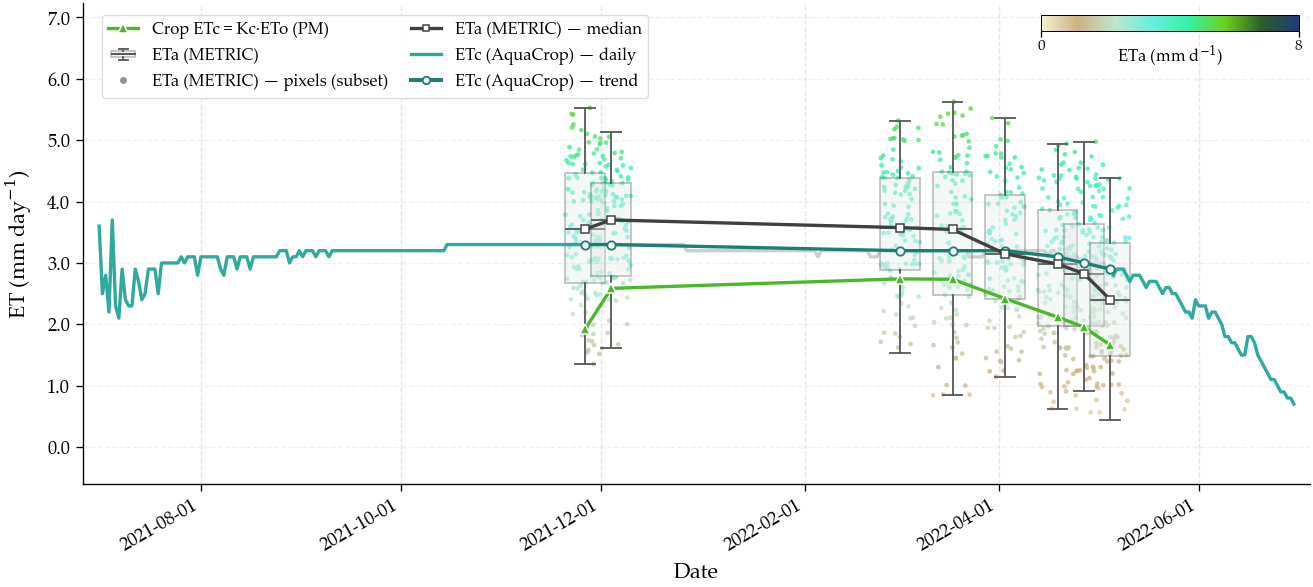

✅ Figure saved successfully at: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc\Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers.png


In [18]:
# -*- coding: utf-8 -*-
"""
Serie temporal Q1 con BOXPLOTS METRIC + NUBE DE PUNTOS (sin outliers) + línea de medianas
— Cajas ETc(METRIC) p5–p95 por fecha Landsat (SIN fliers)
— Línea que une las MEDIANAS (p50) de cada boxplot
— Nube de píxeles submuestreada y coloreada por ETc, filtrada por p5–p95 de cada fecha
— AquaCrop daily atenuado + tendencia en fechas METRIC
— ETc = Kc·ETo (PM) en fechas Landsat
— Exporta PNG 600 dpi (bbox_inches='tight')
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Earth Engine / geemap
import ee, geemap

# === Inline Jupyter (seguro) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# ================== RUTAS / CONFIG USUARIO ==================
CSV_PATH      = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\processed\tables\OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI NUEVA
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m (≈0.5 px)

# Opciones
USE_ET_POS          = True
SHOW_LANDSAT_VLINES = False
FIG_TS              = "Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers"

 # Kc mensual para ETc(PM)
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.56,11:0.62,12:0.64}

# ====== Estilo Q1 ======
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})

# Colores de series
C_ETC        = "#4ab928"   # ETc(PM)
C_AQC        = "#2ca89a"   # AquaCrop daily (fuera)
C_AQC_DIM    = "#bfc9c5"   # AquaCrop daily (dentro)
C_AQC_TREND  = "#1d7f72"   # AquaCrop trend
C_BOX_FACE   = "#dfeae6"   # relleno caja
C_BOX_EDGE   = "0.35"      # borde/whiskers
C_MED_LINE   = "0.25"      # línea de medianas

# —— Paleta para los píxeles (gradiente continuo)
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
CMAP_PIX = LinearSegmentedColormap.from_list("pixETc", palette_stops, N=256)

# ===== LEYENDA (Legend) =====
LEG_NCOL  = 2                 # Número de columnas en la leyenda (2 columnas)
LEG_LOC   = "upper left"      # Posición de la leyenda dentro del gráfico (esquina superior izquierda)
LEG_BBOX  = (0.01, 0.99)      # Desplazamiento (x, y) relativo dentro del área de la figura
LEG_FRAME = True              # Mostrar marco o caja alrededor de la leyenda

# ===== EJES (Axes settings) =====
Y_LABEL            = "ET (mm day$^{-1}$)"  # Etiqueta del eje Y (usa notación LaTeX para unidades)
Y_LABELPAD         = 8                     # Separación entre la etiqueta Y y el eje
Y_FORCE_ZERO_BASE  = True                  # Forzar que el eje Y inicie en 0
Y_ZERO_PAD_ABS     = 0.6                   # Margen inferior fijo (cuando se fuerza base cero)
Y_TOP_PAD_REL      = 0.05                  # Margen superior relativo (5 % del rango de datos)
Y_TOP_PAD_ABS      = 1.6                     # Margen superior mínimo absoluto (en unidades de ET)
X_MARGIN_DAYS      = 5                     # Margen horizontal en días al inicio/fin del eje X
X_TICK_EVERY_MONTHS= 2                     # Intervalo de ticks mayores del eje X (cada 2 meses)

# ===== RANGO / ESCALA (EE reduceRegion params) =====
ET_MIN, ET_MAX = 0.0, 8.0   # Valores mínimo y máximo de ET a considerar (para filtrar valores)
SCALE_M        = 30          # Resolución espacial de muestreo (m/píxel) en reduceRegion()
TILESCALE      = 8           # Factor de paralelización en Earth Engine (para evitar timeouts)

# ===== NUBE DE PUNTOS (Pixel scatter settings) =====
DRAW_POINTS             = True    # Dibujar o no la nube de píxeles submuestreados
FILTER_POINTS_BY_WHISKERS = True  # Filtra puntos fuera de los percentiles p5–p95 (quita outliers)
POINTS_PER_DATE_MAX     = 800     # Número máximo de píxeles por fecha (submuestreo)
POINTS_JITTER_DAYS_HALF = 6       # “Jitter” horizontal aleatorio ±6 días (para dispersión visual)
POINTS_MARKERSIZE       = 2.8     # Tamaño del marcador de cada punto (radio en px)
POINTS_ALPHA            = 0.78    # Transparencia de los puntos (0 = transparente, 1 = opaco)
POINTS_SEED             = None    # Semilla aleatoria para reproducibilidad del muestreo (None = aleatoria cada ejecución)

# ===== BARRA DE COLOR (Colorbar config) =====
CBAR_LABEL       = "ETa (mm d$^{-1}$)"  # Etiqueta de la barra de color (usa notación LaTeX)
CBAR_AUTORANGE   = False                # False = rango fijo, True = se ajusta al rango de datos
CBAR_VMIN        = 0.0                  # Valor mínimo del rango de la barra de color
CBAR_VMAX        = 8.0                  # Valor máximo del rango de la barra de color
CBAR_WIDTH_PCT   = "21%"                # Ancho relativo de la barra (respecto al eje principal)
CBAR_HEIGHT_PCT  = "3.4%"               # Alto relativo de la barra
CBAR_LOC         = 'upper right'        # Ubicación de la barra dentro del gráfico (esquina superior derecha)
CBAR_TICKS       = "minmax"             # Mostrar solo los valores mínimo y máximo ("auto" = más ticks)
CBAR_LABELPAD    = -5.7                 # Distancia entre el texto “ETc” y la barra (negativo = más cerca)
CBAR_TICKPAD     = 0.8                  # Espacio entre los valores numéricos de la barra y la barra misma


# ================== EE INIT ==================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ================== HELPERS (Estación / AquaCrop) ==================
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        cl = c.lower()
        if ("eto" in cl) or ("et0" in cl) or (cl == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if ("fecha" in c.lower()) or ("date" in c.lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date column found in AquaCrop sheet.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + \
                   pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("No ET or (E, Tr) columns in AquaCrop sheet.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy()
    et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ================== HELPERS (EE para cajas / puntos METRIC) ==================
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_percentiles_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
    }

def sample_pixels_values(img: ee.Image, geom: ee.Geometry,
                         nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) -> list:
    """Devuelve una lista de valores (submuestreados) del raster en ROI."""
    bname = get_band_name(img)
    if bname is None: return []
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    samp = (im.sample(region=geom, scale=SCALE_M, tileScale=TILESCALE, geometries=False)
              .randomColumn('rand', seed=seed)
              .sort('rand')
              .limit(int(nmax)))
    try:
        vals = samp.aggregate_array(bname).getInfo() or []
    except Exception:
        vals = []
    out = []
    for v in vals:
        try:
            fv = float(v)
            if np.isfinite(fv):
                out.append(fv)
        except Exception:
            pass
    return out

def percentiles_y_puntos_por_fecha_NEWROI(lista_imgs, fechas_l8, roi_fc):
    """
    Devuelve:
      dfp -> DataFrame con p5..p95 por fecha (para boxplots)
      points_dict -> dict {pd.Timestamp: np.array([vals])} para la nube (SIN outliers si se habilita)
    """
    rows = []
    points_dict = {}
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()

    for item in lista_imgs:
        f = pd.to_datetime(item["fecha"]).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue

        # Percentiles exactos en ROI
        d = reduce_percentiles_exact(img, geom)
        if not d or d["p50"] is None:
            continue

        # Guardamos stats para boxplot
        rows.append({
            "date": f,
            "p5":  float(d["p5"]),
            "p25": float(d["p25"]),
            "p50": float(d["p50"]),
            "p75": float(d["p75"]),
            "p95": float(d["p95"]),
        })

        # Submuestreo de píxeles
        vals = sample_pixels_values(img, geom, nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) if DRAW_POINTS else []

        # Filtro de outliers de la nube (por bigotes p5–p95)
        if FILTER_POINTS_BY_WHISKERS and vals:
            lo, hi = float(d["p5"]), float(d["p95"])
            vals = [v for v in vals if (v >= lo and v <= hi)]

        points_dict[pd.to_datetime(f)] = np.array(vals, dtype=float)

    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df, points_dict

def draw_metric_boxes_on_date_axis(ax, dfp, widths_days=12):
    """Dibuja cajas p5–p95 sobre el eje temporal (positions = fechas).
       Outliers desactivados explícitamente (showfliers=False)."""
    if dfp.empty:
        return None
    fechas = dfp["date"].tolist()
    stats = []
    for _, r in dfp.iterrows():
        stats.append(dict(
            label=r["date"].strftime("%Y-%m-%d"),
            med=r.p50, q1=r.p25, q3=r.p75, whislo=r.p5, whishi=r.p95
        ))
    positions = mdates.date2num(fechas)
    bxp = ax.bxp(stats, showfliers=False, positions=positions,
                 widths=widths_days, patch_artist=True, zorder=1)
    for box in bxp['boxes']:
        box.set_facecolor(C_BOX_FACE); box.set_alpha(0.35)
        box.set_edgecolor(C_BOX_EDGE); box.set_linewidth(1.1); box.set_zorder(1)
    for el in ["whiskers","caps","medians"]:
        for obj in bxp[el]:
            obj.set_color(C_BOX_EDGE); obj.set_linewidth(1.1); obj.set_zorder(1)
    return bxp

def draw_points_swarm(ax, points_dict, cmap, norm):
    """Nube de puntos con jitter y color por valor (pequeña, tenue, detrás)."""
    if not points_dict:
        return np.array([])
    rng = np.random.RandomState(POINTS_SEED)
    all_vals = []
    for d, vals in points_dict.items():
        if vals.size == 0:
            continue
        x0 = mdates.date2num(d)
        jitter = (rng.rand(vals.size) - 0.5) * 2 * POINTS_JITTER_DAYS_HALF
        x = x0 + jitter
        ax.scatter(
            x, vals,
            s=POINTS_MARKERSIZE**2, c=vals, cmap=cmap, norm=norm,
            alpha=POINTS_ALPHA, linewidths=0, zorder=0.9, rasterized=True
        )
        all_vals.append(vals)
    return np.concatenate(all_vals) if all_vals else np.array([])

# ================== HANDLER LEYENDA: símbolo real de caja ==================
class BoxLegend:
    def __init__(self, fc, ec): self.fc, self.ec = fc, ec

class HandlerBoxplot(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        fc, ec = orig_handle.fc, orig_handle.ec
        box = Rectangle((xdescent + 0.10*width, ydescent + 0.25*height),
                        0.80*width, 0.50*height,
                        facecolor=fc, edgecolor=ec, lw=1.1, alpha=0.35)
        median = plt.Line2D([xdescent + 0.12*width, xdescent + 0.88*width],
                            [ydescent + 0.50*height, ydescent + 0.50*height], color=ec, lw=1.2)
        midx = xdescent + 0.50*width
        whisk_top = plt.Line2D([midx, midx], [ydescent + 0.75*height, ydescent + 0.98*height], color=ec, lw=1.1)
        whisk_bot = plt.Line2D([midx, midx], [ydescent + 0.02*height, ydescent + 0.25*height], color=ec, lw=1.1)
        cap_top   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.98*height, ydescent + 0.98*height], color=ec, lw=1.1)
        cap_bot   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.02*height, ydescent + 0.02*height], color=ec, lw=1.1)
        for a in [box, median, whisk_top, whisk_bot, cap_top, cap_bot]: a.set_transform(trans)
        return [box, median, whisk_top, whisk_bot, cap_top, cap_bot]

# ================== FIGURA ==================
def fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, landsat_dates, df_boxes_newroi, points_dict):
    plt.close('all')

    idx_l8 = pd.to_datetime(landsat_dates).normalize()
    et0_daily.index     = pd.to_datetime(et0_daily.index).normalize()
    etc_aqc_daily.index = pd.to_datetime(etc_aqc_daily.index).normalize()

    start_date = min(etc_aqc_daily.index.min(), idx_l8.min())
    end_date   = max(etc_aqc_daily.index.max(), idx_l8.max())

    # ETc(PM) en fechas Landsat
    etcpm_l8  = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # Ventana METRIC (para atenuar AquaCrop)
    win_start, win_end = idx_l8.min(), idx_l8.max()

    fig, ax = plt.subplots(figsize=(13.2, 5.2), constrained_layout=False)

    # Estética base
    for s in ["left","bottom"]: ax.spines[s].set_linewidth(0.8)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", length=4, width=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.18)

    # AquaCrop daily
    idx_all = etc_aqc_daily.index; y_all = etc_aqc_daily.values
    inside_mask  = (idx_all >= win_start) & (idx_all <= win_end)
    y_all_clean = y_all.copy(); y_all_clean[inside_mask] = np.nan
    ax.plot(idx_all, y_all_clean, lw=2.0, color=C_AQC, alpha=0.98,
            label="ETc (AquaCrop) — daily (outside METRIC window)", zorder=2)
    ax.plot(idx_all[inside_mask], y_all[inside_mask], lw=2.0, color=C_AQC_DIM, alpha=0.85,
            label="ETc (AquaCrop) — daily (within METRIC window, dimmed)", zorder=1)

    # Tendencia AquaCrop (en fechas Landsat)
    aqc_on_metric = etc_aqc_daily.reindex(idx_l8).dropna()
    ln_aqc_trend, = ax.plot(
        aqc_on_metric.index, aqc_on_metric.values,
        "-o", lw=2, ms=5, mfc="white", mec=C_AQC_TREND, mew=1.1,
        color=C_AQC_TREND, label="ETc (AquaCrop) — trend on METRIC dates", zorder=3.2
    )

    # ===== NUBE DE PUNTOS coloreada (ya sin outliers) =====
    norm = Normalize(vmin=CBAR_VMIN, vmax=CBAR_VMAX)
    pix_vals_all = draw_points_swarm(ax, points_dict, cmap=CMAP_PIX, norm=norm) if DRAW_POINTS and points_dict else np.array([])

    # Cajas METRIC (SIN fliers)
    draw_metric_boxes_on_date_axis(ax, df_boxes_newroi, widths_days=12)

    # Línea de MEDIANAS (p50) uniendo cada fecha
    med_series = df_boxes_newroi.set_index('date')["p50"].sort_index()
    ln_med, = ax.plot(
        med_series.index, med_series.values,
        "-s", lw=2, ms=4.5, color=C_MED_LINE, mfc="white", mec=C_MED_LINE, mew=0.9,
        label="ETa (METRIC) — median", zorder=4
    )

    # ETc = Kc·ETo (PM)
    ln_etcpm, = ax.plot(
        idx_l8, etcpm_l8.values,
        marker="^", ms=6, lw=2.0, color=C_ETC,
        mec="white", mew=0.9, label="Crop ETc = Kc·ETo (PM)", zorder=3.1
    )

    # Ejes y límites
    ax.xaxis.set_major_locator(MonthLocator(interval=X_TICK_EVERY_MONTHS))
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    ax.set_xlabel("Date")
    ax.set_ylabel(Y_LABEL, labelpad=Y_LABELPAD)
    ax.set_xlim(pd.to_datetime(start_date) - pd.Timedelta(days=X_MARGIN_DAYS),
                pd.to_datetime(end_date)   + pd.Timedelta(days=X_MARGIN_DAYS))
    for lab in ax.get_xticklabels(which="major"):
        lab.set_rotation(30); lab.set_ha("right")

    # Límites Y (incluye puntos y p95)
    y_candidates = [etc_aqc_daily.values, med_series.values]
    if df_boxes_newroi is not None and not df_boxes_newroi.empty:
        y_candidates.append(df_boxes_newroi["p95"].values)
    if pix_vals_all.size > 0:
        y_candidates.append(pix_vals_all)
    arrcat = np.concatenate([np.asarray(a, float)[np.isfinite(a)] for a in y_candidates if len(a)>0])
    if arrcat.size > 0:
        y_min_data = float(np.nanmin(arrcat)); y_max_data = float(np.nanmax(arrcat))
        y_range    = max(1e-6, y_max_data - y_min_data)
        y_top_pad  = max(Y_TOP_PAD_REL * y_range, Y_TOP_PAD_ABS)
        y_hi       = y_max_data + y_top_pad
        y_lo       = 0.0 - float(Y_ZERO_PAD_ABS) if Y_FORCE_ZERO_BASE else y_min_data - 0.06*y_range
        ax.set_ylim(y_lo, y_hi)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Líneas verticales tenues
    for xnum in ax.get_xticks():
        ax.axvline(x=xnum, color="0.9", lw=0.8, ls="--", zorder=0)
    if SHOW_LANDSAT_VLINES:
        for x in idx_l8:
            ax.axvline(x, color="0.92", lw=0.8, zorder=0)

    # ===== LEYENDA =====
    class _BoxLegend(BoxLegend): pass
    box_handle = _BoxLegend(fc=C_BOX_FACE, ec=C_BOX_EDGE)

    # Tamaño uniforme para todos los símbolos
    LEG_MS = 4.2

    pixel_proxy = plt.Line2D([], [], linestyle="None", marker="o",
                            ms=LEG_MS, mfc="#7f8c87", mec="none", alpha=0.9)
    handles = [
        plt.Line2D([], [], marker="^", ms=6, lw=2.0, color=C_ETC,
                mec="white", mew=0.9),  # ETc = Kc·ETo (PM)
        box_handle,
        pixel_proxy,
        plt.Line2D([], [], marker="s", ms=4, lw=2.0, color=C_MED_LINE,
                mfc="white", mec=C_MED_LINE, mew=0.9),  # Mediana METRIC
        plt.Line2D([], [], color=C_AQC, lw=2.0),           # AquaCrop daily
        plt.Line2D([], [], color=C_AQC_TREND, lw=2.4, marker='o', ms=4.5,
                mfc="white", mec=C_AQC_TREND, mew=1.1)   # AquaCrop trend
    ]
    labels = [
        "Crop ETc = Kc·ETo (PM)",
        "ETa (METRIC)",
        "ETa (METRIC) — pixels (subset)",
        "ETa (METRIC) — median",
        "ETc (AquaCrop) — daily",
        "ETc (AquaCrop) — trend"
    ]
    leg = ax.legend(
        handles, labels, ncol=LEG_NCOL, loc=LEG_LOC, bbox_to_anchor=LEG_BBOX,
        frameon=LEG_FRAME, framealpha=0.92, facecolor="white", edgecolor="0.85",
        fancybox=True, borderaxespad=0.4, handlelength=1.8, columnspacing=1.4,
        handler_map={_BoxLegend: HandlerBoxplot()}
    )
    leg.get_frame().set_linewidth(0.8)


    # ===== Barra de color (esquina superior derecha) =====
    sm = plt.cm.ScalarMappable(norm=norm, cmap=CMAP_PIX)
    cax = inset_axes(ax, width=CBAR_WIDTH_PCT, height=CBAR_HEIGHT_PCT,
                     loc=CBAR_LOC, borderpad=0.7)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    if CBAR_TICKS == "minmax":
        cbar.set_ticks([norm.vmin, norm.vmax])
    cbar.set_label(CBAR_LABEL, fontsize=10, labelpad=CBAR_LABELPAD)
    cbar.outline.set_linewidth(0.6)
    cax.tick_params(axis='x', labelsize=9, pad=CBAR_TICKPAD)

    # Guardar
    output_dir = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, FIG_TS + ".png")

    fig.savefig(output_path, dpi=600, bbox_inches="tight", pad_inches=0.03)
    plt.show()
    print(f"✅ Figure saved successfully at: {output_path}")

# ================== MAIN ==================
def main():
    # Requiere 'lista_imgprocesadas_ET' en memoria:
    # [{'fecha':'YYYY-MM-DD','img_ETinst':ee.Image,'stats':DataFrame(...)}]
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    et0_daily     = read_et0_daily_from_station(CSV_PATH)
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)

    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)
    df_boxes_new, points_dict = percentiles_y_puntos_por_fecha_NEWROI(
        lista_imgprocesadas_ET, LANDSAT_DATES, fc_new
    )

    fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, LANDSAT_DATES,
                              df_boxes_new, points_dict)

if __name__ == "__main__":
    main()


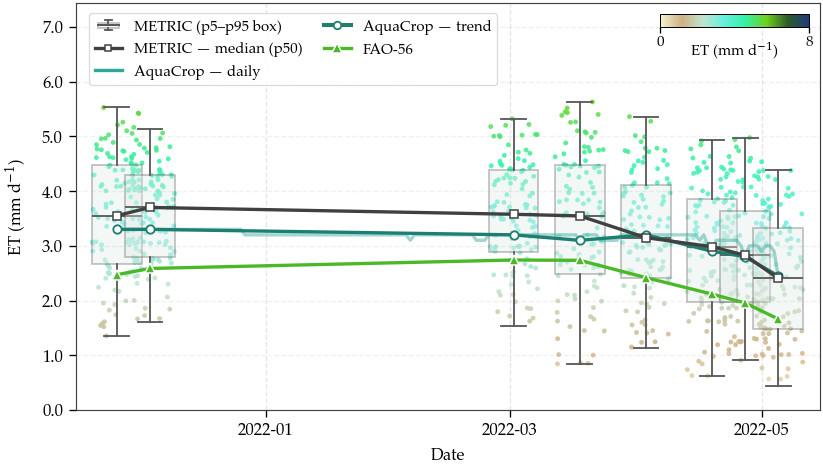

✅ Figure saved successfully at: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc\Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers.png


In [19]:
# -*- coding: utf-8 -*-
"""
Serie temporal Q1 con BOXPLOTS METRIC + NUBE DE PUNTOS (sin outliers) + línea de medianas
— Cajas ETc(METRIC) p5–p95 por fecha Landsat (SIN fliers)
— Línea que une las MEDIANAS (p50) de cada boxplot
— Nube de píxeles submuestreada y coloreada por ETc, filtrada por p5–p95 de cada fecha
— AquaCrop daily atenuado + tendencia en fechas METRIC
— ETc = Kc·ETo (PM) en fechas Landsat
— Exporta PNG 600 dpi (bbox_inches='tight')
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Earth Engine / geemap
import ee, geemap

# === Inline Jupyter (seguro) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# ================== RUTAS / CONFIG USUARIO ==================
CSV_PATH      = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\processed\tables\OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI NUEVA
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m (≈0.5 px)

# Opciones
USE_ET_POS          = True
SHOW_LANDSAT_VLINES = False
FIG_TS              = "Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers"

# Monthly Kc
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.62,11:0.8,12:0.64}

# ====== Estilo Q1 ======
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})

# Colores de series
C_ETC        = "#4ab928"   # ETc(PM)
C_AQC        = "#2ca89a"   # AquaCrop daily (fuera)
C_AQC_DIM    = "#bfc9c5"   # AquaCrop daily (dentro)
C_AQC_TREND  = "#1d7f72"   # AquaCrop trend
C_BOX_FACE   = "#dfeae6"   # relleno caja
C_BOX_EDGE   = "0.35"      # borde/whiskers
C_MED_LINE   = "0.25"      # línea de medianas

# —— Paleta para los píxeles (gradiente continuo)
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
CMAP_PIX = LinearSegmentedColormap.from_list("pixETc", palette_stops, N=256)

# ===== LEYENDA (Legend) =====
LEG_NCOL  = 2                 # Número de columnas en la leyenda (2 columnas)
LEG_LOC   = "upper left"      # Posición de la leyenda dentro del gráfico
LEG_BBOX  = (0.01, 0.99)      # Desplazamiento relativo (x, y)
LEG_FRAME = True              # Mostrar marco

# ===== EJES (Axes settings) =====
Y_LABEL            = "ET (mm d$^{-1}$)"  # Etiqueta del eje Y
Y_LABELPAD         = 8
Y_FORCE_ZERO_BASE  = True
Y_ZERO_PAD_ABS     = 0
Y_TOP_PAD_REL      = 0.05
Y_TOP_PAD_ABS      = 1.8
X_MARGIN_DAYS      = 10
X_TICK_EVERY_MONTHS= 2

# ===== RANGO / ESCALA (EE reduceRegion params) =====
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# ===== NUBE DE PUNTOS (Pixel scatter settings) =====
DRAW_POINTS             = True
FILTER_POINTS_BY_WHISKERS = True
POINTS_PER_DATE_MAX     = 800
POINTS_JITTER_DAYS_HALF = 6
POINTS_MARKERSIZE       = 2.9
POINTS_ALPHA            = 0.85
POINTS_SEED             = None

# ===== BARRA DE COLOR (Colorbar config) =====
CBAR_LABEL       = "ET (mm d$^{-1}$)"
CBAR_AUTORANGE   = False
CBAR_VMIN        = 0.0
CBAR_VMAX        = 8.0
CBAR_WIDTH_PCT   = "20%"
CBAR_HEIGHT_PCT  = "3.3%"
CBAR_LOC         = 'upper right'
CBAR_TICKS       = "minmax"
CBAR_LABELPAD    = -5.7
CBAR_TICKPAD     = 0.8

# ================== EE INIT ==================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ================== HELPERS (Estación / AquaCrop) ==================
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        cl = c.lower()
        if ("eto" in cl) or ("et0" in cl) or (cl == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if ("fecha" in c.lower()) or ("date" in c.lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date column found in AquaCrop sheet.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + \
                   pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("No ET or (E, Tr) columns in AquaCrop sheet.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy()
    et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ================== HELPERS (EE para cajas / puntos METRIC) ==================
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_percentiles_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
    }

def sample_pixels_values(img: ee.Image, geom: ee.Geometry,
                         nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) -> list:
    """Devuelve una lista de valores (submuestreados) del raster en ROI."""
    bname = get_band_name(img)
    if bname is None: return []
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    samp = (im.sample(region=geom, scale=SCALE_M, tileScale=TILESCALE, geometries=False)
              .randomColumn('rand', seed=seed)
              .sort('rand')
              .limit(int(nmax)))
    try:
        vals = samp.aggregate_array(bname).getInfo() or []
    except Exception:
        vals = []
    out = []
    for v in vals:
        try:
            fv = float(v)
            if np.isfinite(fv):
                out.append(fv)
        except Exception:
            pass
    return out

def percentiles_y_puntos_por_fecha_NEWROI(lista_imgs, fechas_l8, roi_fc):
    """
    Devuelve:
    dfp -> DataFrame con p5..p95 por fecha (para boxplots)
    points_dict -> dict {pd.Timestamp: np.array([vals])} para la nube (SIN outliers si se habilita)
    """
    rows = []
    points_dict = {}
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()

    for item in lista_imgs:
        f = pd.to_datetime(item["fecha"]).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue

        # Percentiles exactos en ROI
        d = reduce_percentiles_exact(img, geom)
        if not d or d["p50"] is None:
            continue

        # Guardamos stats para boxplot
        rows.append({
            "date": f,
            "p5":  float(d["p5"]),
            "p25": float(d["p25"]),
            "p50": float(d["p50"]),
            "p75": float(d["p75"]),
            "p95": float(d["p95"]),
        })

        # Submuestreo de píxeles
        vals = sample_pixels_values(img, geom, nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) if DRAW_POINTS else []

        # Filtro de outliers de la nube (por bigotes p5–p95)
        if FILTER_POINTS_BY_WHISKERS and vals:
            lo, hi = float(d["p5"]), float(d["p95"])
            vals = [v for v in vals if (v >= lo and v <= hi)]

        points_dict[pd.to_datetime(f)] = np.array(vals, dtype=float)

    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df, points_dict

def draw_metric_boxes_on_date_axis(ax, dfp, widths_days=9):
    """Dibuja cajas p5–p95 sobre el eje temporal (positions = fechas).
    Outliers desactivados explícitamente (showfliers=False)."""
    if dfp.empty:
        return None
    fechas = dfp["date"].tolist()
    stats = []
    for _, r in dfp.iterrows():
        stats.append(dict(
            label=r["date"].strftime("%Y-%m-%d"),
            med=r.p50, q1=r.p25, q3=r.p75, whislo=r.p5, whishi=r.p95
        ))
    positions = mdates.date2num(fechas)
    bxp = ax.bxp(stats, showfliers=False, positions=positions,
                 widths=widths_days, patch_artist=True, zorder=1)
    for box in bxp['boxes']:
        box.set_facecolor(C_BOX_FACE); box.set_alpha(0.35)
        box.set_edgecolor(C_BOX_EDGE); box.set_linewidth(1.1); box.set_zorder(1)
    for el in ["whiskers","caps","medians"]:
        for obj in bxp[el]:
            obj.set_color(C_BOX_EDGE); obj.set_linewidth(1.1); obj.set_zorder(1)
    return bxp

def draw_points_swarm(ax, points_dict, cmap, norm):
    """Nube de puntos con jitter y color por valor (pequeña, tenue, detrás)."""
    if not points_dict:
        return np.array([])
    rng = np.random.RandomState(POINTS_SEED)
    all_vals = []
    for d, vals in points_dict.items():
        if vals.size == 0:
            continue
        x0 = mdates.date2num(d)
        jitter = (rng.rand(vals.size) - 0.5) * 2 * POINTS_JITTER_DAYS_HALF
        x = x0 + jitter
        ax.scatter(
            x, vals,
            s=POINTS_MARKERSIZE**2, c=vals, cmap=cmap, norm=norm,
            alpha=POINTS_ALPHA, linewidths=0, zorder=0.9, rasterized=True
        )
        all_vals.append(vals)
    return np.concatenate(all_vals) if all_vals else np.array([])

# ================== HANDLER LEYENDA: símbolo real de caja ==================
class BoxLegend:
    def __init__(self, fc, ec): self.fc, self.ec = fc, ec

class HandlerBoxplot(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        fc, ec = orig_handle.fc, orig_handle.ec
        box = Rectangle((xdescent + 0.10*width, ydescent + 0.25*height),
                        0.80*width, 0.50*height,
                        facecolor=fc, edgecolor=ec, lw=1.1, alpha=0.35)
        median = plt.Line2D([xdescent + 0.12*width, xdescent + 0.88*width],
                            [ydescent + 0.50*height, ydescent + 0.50*height], color=ec, lw=1.2)
        midx = xdescent + 0.50*width
        whisk_top = plt.Line2D([midx, midx], [ydescent + 0.75*height, ydescent + 0.98*height], color=ec, lw=1.1)
        whisk_bot = plt.Line2D([midx, midx], [ydescent + 0.02*height, ydescent + 0.25*height], color=ec, lw=1.1)
        cap_top   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.98*height, ydescent + 0.98*height], color=ec, lw=1.1)
        cap_bot   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.02*height, ydescent + 0.02*height], color=ec, lw=1.1)
        for a in [box, median, whisk_top, whisk_bot, cap_top, cap_bot]: a.set_transform(trans)
        return [box, median, whisk_top, whisk_bot, cap_top, cap_bot]

# ================== FIGURA ==================
def fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, landsat_dates, df_boxes_newroi, points_dict):
    plt.close('all')

    idx_l8 = pd.to_datetime(landsat_dates).normalize()
    et0_daily.index     = pd.to_datetime(et0_daily.index).normalize()
    etc_aqc_daily.index = pd.to_datetime(etc_aqc_daily.index).normalize()

    start_date = idx_l8.min()
    end_date   = idx_l8.max()
    
    # ETc(PM) en fechas Landsat
    etcpm_l8  = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # Ventana METRIC (para atenuar AquaCrop)
    win_start, win_end = idx_l8.min(), idx_l8.max()

    fig, ax = plt.subplots(figsize=(8, 4.4), constrained_layout=False)

    # Marco alrededor del área de datos
    for s in ["top", "right", "left", "bottom"]:
        ax.spines[s].set_visible(True)
        ax.spines[s].set_linewidth(0.7)
        ax.spines[s].set_edgecolor("0.25")
    ax.tick_params(axis="both", which="both", length=4, width=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.18)

    # === AquaCrop daily SOLO dentro del rango METRIC ===
    idx_all = etc_aqc_daily.index
    mask = (idx_all >= win_start) & (idx_all <= win_end)

    ax.plot(idx_all[mask], etc_aqc_daily.values[mask],
            lw=2.0, color=C_AQC, alpha=0.45,
            label="ETc (AquaCrop) — daily", zorder=2.5)

    # Tendencia AquaCrop (en fechas Landsat)
    aqc_on_metric = etc_aqc_daily.reindex(idx_l8).dropna()
    ln_aqc_trend, = ax.plot(
        aqc_on_metric.index, aqc_on_metric.values,
        "-o", lw=2, ms=5, mfc="white", mec=C_AQC_TREND, mew=1.1,
        color=C_AQC_TREND, label="ETc (AquaCrop) — trend on METRIC dates", zorder=3.2
    )

    # ===== NUBE DE PUNTOS coloreada (ya sin outliers) =====
    norm = Normalize(vmin=CBAR_VMIN, vmax=CBAR_VMAX)
    pix_vals_all = draw_points_swarm(ax, points_dict, cmap=CMAP_PIX, norm=norm) if DRAW_POINTS and points_dict else np.array([])

    # Cajas METRIC (SIN fliers)
    draw_metric_boxes_on_date_axis(ax, df_boxes_newroi, widths_days=12)

    # Línea de MEDIANAS (p50) uniendo cada fecha
    med_series = df_boxes_newroi.set_index('date')["p50"].sort_index()
    ln_med, = ax.plot(
        med_series.index, med_series.values,
        "-s", lw=2, ms=4.5, color=C_MED_LINE, mfc="white", mec=C_MED_LINE, mew=0.9,
        label="ETa (METRIC) — median", zorder=4
    )

    # ETc = Kc·ETo (PM)
    ln_etcpm, = ax.plot(
        idx_l8, etcpm_l8.values,
        marker="^", ms=6, lw=2.0, color=C_ETC,
        mec="white", mew=0.9, label="Crop ETc = Kc·ETo (PM)", zorder=3.1
    )

    # Ejes y límites
    ax.xaxis.set_major_locator(MonthLocator(interval=X_TICK_EVERY_MONTHS))
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.set_xlabel("Date")
    ax.set_ylabel(Y_LABEL, labelpad=Y_LABELPAD)
    ax.set_xlim(pd.to_datetime(start_date) - pd.Timedelta(days=X_MARGIN_DAYS),
                pd.to_datetime(end_date)   + pd.Timedelta(days=X_MARGIN_DAYS))
    ax.tick_params(axis="x", which="major", labelrotation=0)
    for lab in ax.get_xticklabels(which="major"):
        lab.set_ha("center")

    # Límites Y (incluye puntos y p95)
    y_candidates = [etc_aqc_daily.values, med_series.values]
    if df_boxes_newroi is not None and not df_boxes_newroi.empty:
        y_candidates.append(df_boxes_newroi["p95"].values)
    if pix_vals_all.size > 0:
        y_candidates.append(pix_vals_all)
    arrcat = np.concatenate([np.asarray(a, float)[np.isfinite(a)] for a in y_candidates if len(a)>0])
    if arrcat.size > 0:
        y_min_data = float(np.nanmin(arrcat)); y_max_data = float(np.nanmax(arrcat))
        y_range    = max(1e-6, y_max_data - y_min_data)
        y_top_pad  = max(Y_TOP_PAD_REL * y_range, Y_TOP_PAD_ABS)
        y_hi       = y_max_data + y_top_pad
        y_lo       = 0.0 - float(Y_ZERO_PAD_ABS) if Y_FORCE_ZERO_BASE else y_min_data - 0.06*y_range
        ax.set_ylim(y_lo, y_hi)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Líneas verticales tenues
    for xnum in ax.get_xticks():
        ax.axvline(x=xnum, color="0.9", lw=0.8, ls="--", zorder=0)
    if SHOW_LANDSAT_VLINES:
        for x in idx_l8:
            ax.axvline(x, color="0.92", lw=0.8, zorder=0)

    # ===== LEYENDA =====
    class _BoxLegend(BoxLegend): pass
    box_handle = _BoxLegend(fc=C_BOX_FACE, ec=C_BOX_EDGE)

    # Tamaño uniforme para todos los símbolos
    LEG_MS = 3

    # Proxy de puntos (nube)
    pixel_proxy = plt.Line2D([], [], linestyle="None", marker="o",
                             ms=LEG_MS, mfc="#7f8c87", mec="none", alpha=0.9)

    # --- ORDEN Y ETIQUETAS ACTUALIZADAS ---
    # 1) METRIC (caja)
    # 2) METRIC — median
    # 3) AquaCrop — daily
    # 4) AquaCrop — trend
    # 5) FAO-Kc·ETo   (AL FINAL)
    handles = [
        box_handle,                                              # METRIC (boxplot)
        plt.Line2D([], [], marker="s", ms=4, lw=2.0, color=C_MED_LINE,
                   mfc="white", mec=C_MED_LINE, mew=0.9),        # METRIC — median
        plt.Line2D([], [], color=C_AQC, lw=2.0),                 # AquaCrop — daily
        plt.Line2D([], [], color=C_AQC_TREND, lw=2.4, marker='o', ms=4.5,
                   mfc="white", mec=C_AQC_TREND, mew=1.1),       # AquaCrop — trend
        plt.Line2D([], [], marker="^", ms=6, lw=2.0, color=C_ETC,
                   mec="white", mew=0.9),                        # FAO-Kc·ETo
    ]
    labels = [
        "METRIC (p5–p95 box)",
        "METRIC — median (p50)",
        "AquaCrop — daily",
        "AquaCrop — trend",
        "FAO-56",   # ← cambiado y movido al final
    ]

    leg = ax.legend(
        handles, labels, ncol=LEG_NCOL, loc=LEG_LOC, bbox_to_anchor=LEG_BBOX,
        frameon=LEG_FRAME, framealpha=0.92, facecolor="white", edgecolor="0.85",
        fancybox=True, borderaxespad=0.4, handlelength=1.8, columnspacing=1.4,
        handler_map={_BoxLegend: HandlerBoxplot()}
    )
    leg.get_frame().set_linewidth(0.8)

    # ===== Barra de color (esquina superior derecha) =====
    sm = plt.cm.ScalarMappable(norm=norm, cmap=CMAP_PIX)
    cax = inset_axes(ax, width=CBAR_WIDTH_PCT, height=CBAR_HEIGHT_PCT,
                     loc=CBAR_LOC, borderpad=0.7)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    if CBAR_TICKS == "minmax":
        cbar.set_ticks([norm.vmin, norm.vmax])
    cbar.set_label(CBAR_LABEL, fontsize=9, labelpad=CBAR_LABELPAD)
    cbar.outline.set_linewidth(0.6)
    cax.tick_params(axis='x', labelsize=9, pad=CBAR_TICKPAD)

    # Guardar
    output_dir = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, FIG_TS + ".png")

    fig.savefig(output_path, dpi=600, bbox_inches="tight", pad_inches=0.03)
    plt.show()
    print(f"✅ Figure saved successfully at: {output_path}")

# ================== MAIN ==================
def main():
    # Requiere 'lista_imgprocesadas_ET' en memoria:
    # [{'fecha':'YYYY-MM-DD','img_ETinst':ee.Image,'stats':DataFrame(...)}]
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    et0_daily     = read_et0_daily_from_station(CSV_PATH)
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)

    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)
    df_boxes_new, points_dict = percentiles_y_puntos_por_fecha_NEWROI(
        lista_imgprocesadas_ET, LANDSAT_DATES, fc_new
    )

    fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, LANDSAT_DATES,
                              df_boxes_new, points_dict)

if __name__ == "__main__":
    main()


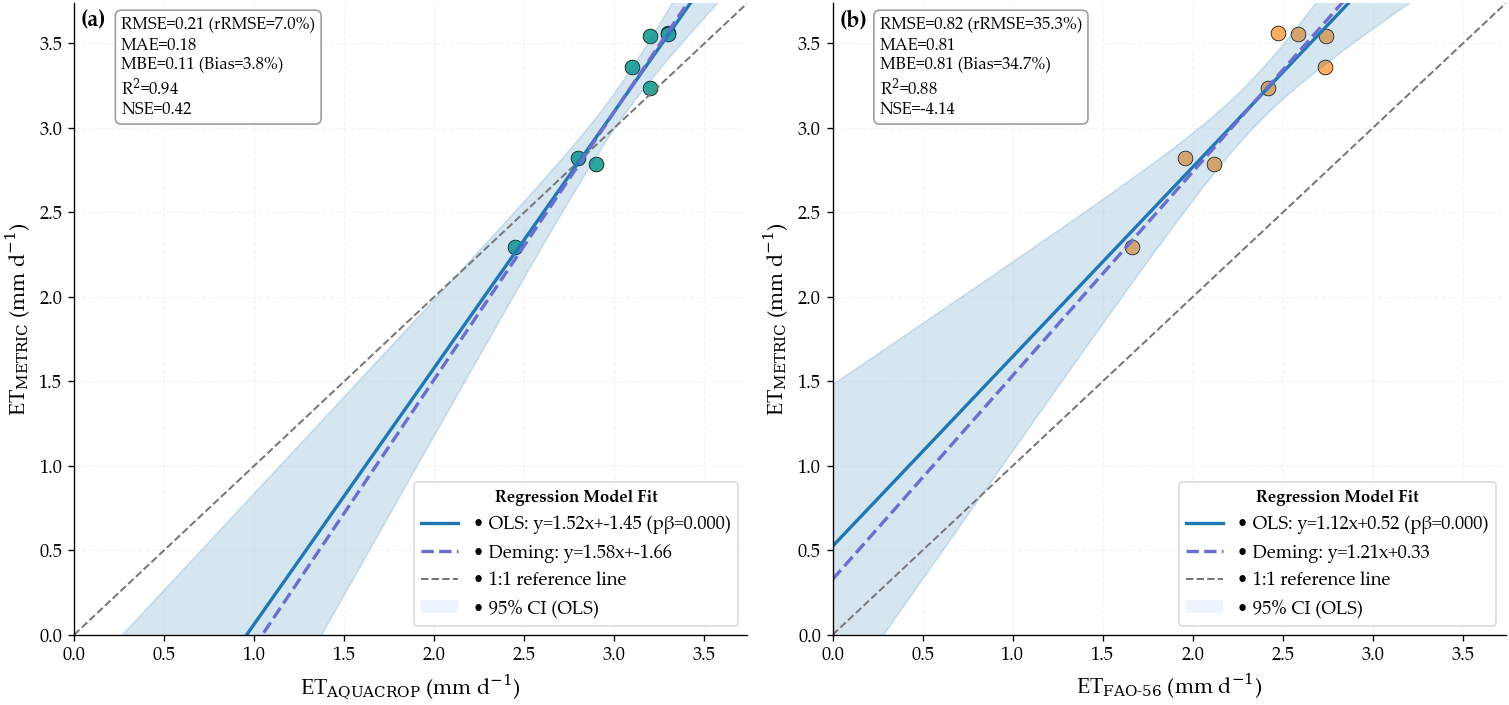

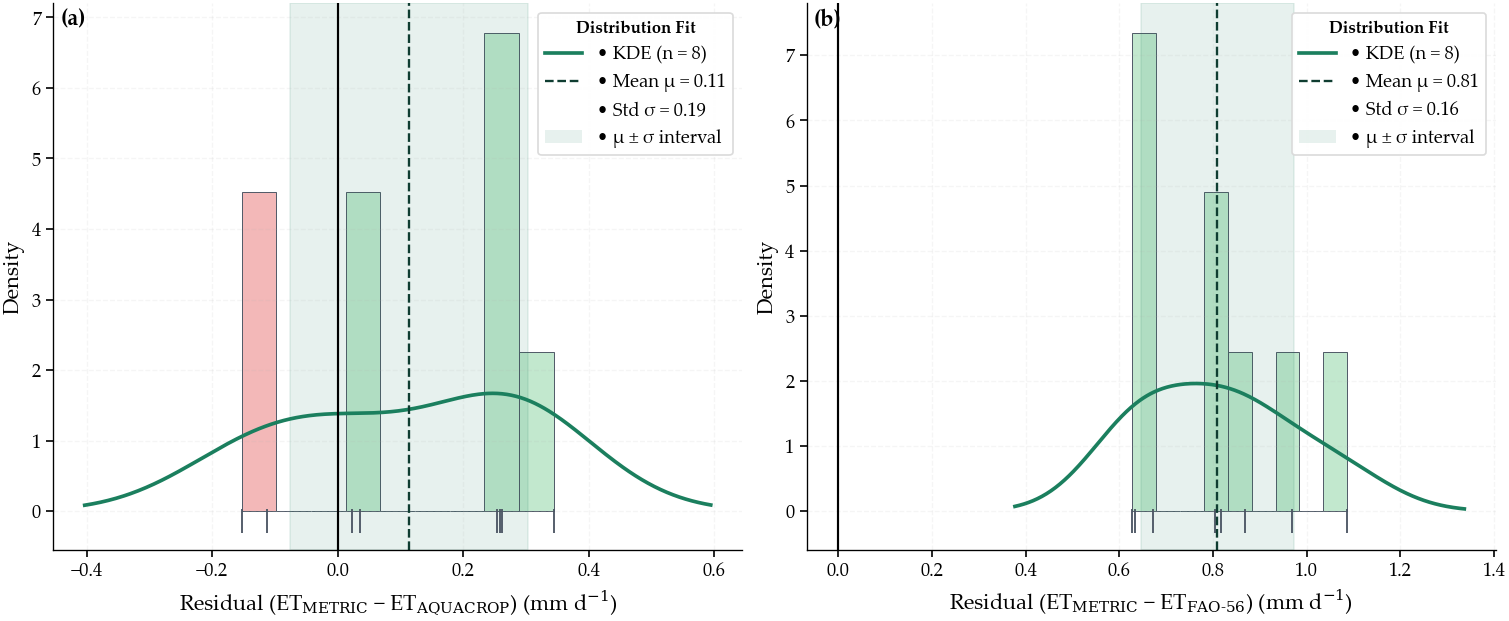


Values used in the figures:
             AquaCrop_daily  ETc_PM  METRIC_mean  Residual_mean_minus_AquaCrop  \
2021-11-26            3.30   2.472        3.558                         0.258   
2021-12-04            3.30   2.586        3.554                         0.254   
2022-03-02            3.20   2.740        3.544                         0.344   
2022-03-18            3.10   2.734        3.361                         0.261   
2022-04-03            3.20   2.419        3.236                         0.036   
2022-04-19            2.90   2.117        2.788                        -0.112   
2022-04-27            2.80   1.955        2.823                         0.023   
2022-05-05            2.45   1.663        2.297                        -0.153   

            Residual_mean_minus_PM  
2021-11-26                   1.086  
2021-12-04                   0.968  
2022-03-02                   0.804  
2022-03-18                   0.627  
2022-04-03                   0.817  
2022-04-19        

In [21]:
# -*- coding: utf-8 -*-
"""
Q1-ready paired figures (no figure titles):

Figure 1 (two panels) — LEGEND S1 (Scientific Box):
(a) Scatter: AquaCrop (daily on Landsat dates) vs ET_METRIC mean
(b) Scatter: FAO-56 (Kc·ETo) vs ET_METRIC mean
  - 1:1 line, OLS (95% CI band), Deming regression
  - Scientific Box legend (S1): OLS, Deming, 1:1, 95% CI
  - Compact metrics box: RMSE, rRMSE%, MAE, MBE, Bias%, R², NSE
  - p-value for OLS slope shown if SciPy is available
  - Same axis limits and ticks in both panels
  - Saves PNG + PDF

Figure 2 (two panels) — LEGEND D (Scientific Box):
(a) Histograma bicolor: Residual = ET_METRIC mean − ET_AQUACROP
(b) Histograma bicolor: Residual = ET_METRIC mean − ET_FAO-56
  - Colores distintos para residuales negativos/positivos
  - Rug plot en la base (todas las observaciones visibles)
  - Línea en 0, línea en μ y banda μ ± σ
  - KDE si SciPy disponible; si no, ajuste normal con μ y σ
  - Scientific Box legend (D)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from math import sqrt

# ────────────── USER CONFIG ──────────────
OUT_DIR       = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
CSV_PATH      = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/meteo/Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/tables/OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI (same as boxplots)
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15  # meters

# Band & mask
USE_ET_POS     = True
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# Monthly Kc
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.62,11:0.8,12:0.64}

# ────────────── Q1 plotting style ──────────────
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 13, "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11,
    "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.12,
    "axes.spines.top": False, "axes.spines.right": False,
})

# ────────────── Colors ──────────────
C_METME  = "#fdae61"   # points panel (b)
C_AQC    = "#2ca89a"   # points panel (a)
C_11     = "#777777"   # 1:1 line
C_OLS    = "#1f78b4"   # OLS line & CI
C_DEM    = "#6b6ecf"   # Deming line
C_CI     = "#9ec5ff"   # OLS band (light); solo para handle (patch) de leyenda

# Hist residuals (mejorado)
C_NEG    = "#f3b4b4"   # barras residuales negativos
C_POS    = "#bfe7cc"   # barras residuales positivos
C_EDGE   = "#4b5563"   # borde de barras y rug
C_PDF    = "#1b7f5e"   # curva KDE/Normal
C_MEAN   = "#0f3d31"   # línea de la media μ

# SciPy (opcional)
try:
    import scipy.stats as st
    from scipy.stats import gaussian_kde
    _SCIPY = True
except Exception:
    _SCIPY = False

# ────────────── Earth Engine ──────────────
import ee, geemap
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ────────────── Station & AquaCrop helpers ──────────────
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = next((c for c in cols if any(k in c.lower() for k in
                 ["fecha","date","datetime","timestamp","fecha hora","date/time"])), None)
    if c_fecha is None: raise KeyError("No date/datetime column found.")
    c_eto = next((c for c in cols if ("eto" in c.lower()) or ("et0" in c.lower()) or (c.lower()=="et")), None)
    if c_eto is None: raise KeyError("No ETo column found.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    c_fecha = next((c for c in df.columns if ("fecha" in str(c).lower()) or ("date" in str(c).lower())), None)
    if c_fecha is None: raise KeyError("AquaCrop: no date column.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("AquaCrop: no ET nor (E,Tr) columns.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy(); et0.index = pd.to_datetime(et0.index).normalize()
    vals = [(kc_ref_for_date(d) * et0.loc[d]) if d in et0.index and np.isfinite(et0.loc[d]) else np.nan
            for d in idx]
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ────────────── EE helpers ──────────────
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp): return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        return fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_stats_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]).combine(
                    reducer2=ee.Reducer.mean(), sharedInputs=True
               ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
               ),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {k: (float(red.get(f"{bname}_{k}")) if red.get(f"{bname}_{k}") is not None else np.nan)
            for k in ["p5","p25","p50","p75","p95","mean","stdDev"]}

def percentiles_media_por_fecha(lista_imgs, fechas_l8, roi_fc):
    rows, fset = [], set(pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist())
    geom = roi_fc.geometry()
    for item in lista_imgs:
        f = pd.to_datetime(item.get("fecha")).strftime("%Y-%m-%d")
        if f not in fset: continue
        img = item.get("img_ETinst")
        if img is None: continue
        d = reduce_stats_exact(img, geom)
        if not d or d["mean"] is None: continue
        rows.append({"date": f, **d})
    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df

# ────────────── Métricas & ajustes ──────────────
def met_stats(y_true, y_pred):
    x = np.asarray(y_true, float); y = np.asarray(y_pred, float)
    m = np.isfinite(x) & np.isfinite(y); x, y = x[m], y[m]
    if x.size == 0:
        return dict(n=0, RMSE=np.nan, MAE=np.nan, MBE=np.nan, R2=np.nan, NSE=np.nan)
    rmse = sqrt(np.mean((y-x)**2))
    mae  = np.mean(np.abs(y-x))
    mbe  = np.mean(y-x)
    r = np.corrcoef(x,y)[0,1] if (np.std(x)>0 and np.std(y)>0) else np.nan
    r2 = r**2 if np.isfinite(r) else np.nan
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2) if np.std(x)>0 else np.nan
    return dict(n=int(x.size), RMSE=rmse, MAE=mae, MBE=mbe, R2=r2, NSE=nse)

def _ols_params(X, Y):
    X1 = np.vstack([X, np.ones_like(X)]).T
    beta, _, _, _ = np.linalg.lstsq(X1, Y, rcond=None)
    yhat = X1 @ beta
    n, p = X1.shape
    s2 = np.sum((Y - yhat)**2) / max(n - p, 1)
    cov = s2 * np.linalg.inv(X1.T @ X1)
    se  = np.sqrt(np.diag(cov))
    return beta, cov, se, yhat, n, p

def _deming(x, y, lam=1.0):
    xbar, ybar = x.mean(), y.mean()
    s_xx = np.var(x, ddof=1); s_yy = np.var(y, ddof=1); s_xy = np.cov(x,y, ddof=1)[0,1]
    if not np.isfinite(s_xy): return np.nan, np.nan
    b = (s_yy - lam*s_xx + np.sqrt((s_yy - lam*s_xx)**2 + 4*lam*s_xy**2)) / (2*s_xy)
    a = ybar - b*xbar
    return float(b), float(a)

# ────────────── Figuras de dispersión con LEYENDA S1 ──────────────
def scatters_two_panels(x_left, y_left, x_right, y_right, out_png):
    os.makedirs(OUT_DIR, exist_ok=True)
    fig, axes = plt.subplots(1, 2, figsize=(12.6, 5.9), constrained_layout=True)

    def _draw(ax, Xs, Ys, point_color, xlabel, ylabel):
        sub = pd.DataFrame({"x": Xs, "y": Ys}).dropna()
        X = sub["x"].values; Y = sub["y"].values
        stats = met_stats(X, Y)

        xmax = max(1.05*max(np.nanmax(X), np.nanmax(Y)), 1.0)
        xs = np.linspace(0, xmax, 300)

        # OLS + banda CI
        beta, cov, se, yhat, n, p = _ols_params(X, Y)
        preds = np.vstack([xs, np.ones_like(xs)]).T @ beta
        se_line = np.sqrt(np.sum((np.vstack([xs, np.ones_like(xs)]).T @ cov) *
                                 np.vstack([xs, np.ones_like(xs)]).T, axis=1))
        tval = st.t.ppf(0.975, df=max(n-p,1)) if _SCIPY else 1.96
        lo, hi = preds - tval*se_line, preds + tval*se_line

        # Deming
        s_dem, i_dem = _deming(X, Y, 1.0)

        # PLOT: puntos + líneas
        ax.scatter(X, Y, s=78, color=point_color, edgecolor="k", linewidth=0.45)
        ax.plot([0, xmax], [0, xmax], "--", color=C_11, lw=1.2)               # 1:1
        ax.plot(xs, preds, lw=2.0, color=C_OLS)                               # OLS
        ax.fill_between(xs, lo, hi, alpha=0.18, color=C_OLS)                  # CI 95%
        if np.isfinite(s_dem):
            ax.plot(xs, s_dem*xs + i_dem, lw=2.0, ls="--", color=C_DEM)      # Deming

        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

        # p-value pendiente OLS
        if _SCIPY and se[0] > 0:
            t_slope = beta[0]/se[0]
            p_slope = 2*(1 - st.t.cdf(abs(t_slope), df=max(n-p,1)))
            ols_label_text = f"OLS: y={beta[0]:.2f}x+{beta[1]:.2f} (pβ={p_slope:.3f})"
        else:
            ols_label_text = f"OLS: y={beta[0]:.2f}x+{beta[1]:.2f}"

        dem_label_text = (f"Deming: y={s_dem:.2f}x+{i_dem:.2f}"
                          if np.isfinite(s_dem) else "Deming: n/a")

        # Métricas compactas (caja superior-izquierda)
        mean_x = np.nanmean(X)
        rrmse = 100 * stats['RMSE'] / mean_x if mean_x and np.isfinite(mean_x) else np.nan
        biasp = 100 * stats['MBE']  / mean_x if mean_x and np.isfinite(mean_x) else np.nan
        txt = (f"RMSE={stats['RMSE']:.2f} (rRMSE={rrmse:.1f}%)\n"
               f"MAE={stats['MAE']:.2f}\n"
               f"MBE={stats['MBE']:.2f} (Bias={biasp:.1f}%)\n"
               f"R$^2$={stats['R2']:.2f}\n"
               f"NSE={stats['NSE']:.2f}")
        ax.text(0.07, 0.98, txt, transform=ax.transAxes, va="top",
                bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="#999", alpha=0.95), fontsize=10)

        # ── LEYENDA S1 (Scientific Box) ──
        handles = [
            Line2D([], [], color=C_OLS, lw=2.0, label=f"• {ols_label_text}"),
            Line2D([], [], color=C_DEM, lw=2.0, ls="--", label=f"• {dem_label_text}"),
            Line2D([], [], color=C_11,  lw=1.2, ls="--", label="• 1:1 reference line"),
            Patch(facecolor=C_CI, alpha=0.18, edgecolor='none', label="• 95% CI (OLS)")
        ]
        leg = ax.legend(handles=handles, loc="lower right", frameon=True, title="Regression Model Fit")
        leg.get_frame().set_facecolor("white")
        leg.get_frame().set_alpha(0.95)
        leg.get_frame().set_edgecolor("#d9d9d9")
        leg.get_title().set_fontweight("bold")

        return xmax

    # (a): AquaCrop vs METRIC
    xmax_left = _draw(
        axes[0], x_left, y_left, C_AQC,
        xlabel=r"ET$_{\mathrm{AQUACROP}}$ (mm d$^{-1}$)",
        ylabel=r"ET$_{\mathrm{METRIC}}$ (mm d$^{-1}$)"
    )
    axes[0].text(0.01, 0.99, "(a)", transform=axes[0].transAxes, va="top", ha="left",
                 fontsize=13, fontweight="bold")

    # (b): FAO-56 vs METRIC
    xmax_right = _draw(
        axes[1], x_right, y_right, C_METME,
        xlabel=r"ET$_{\mathrm{FAO\text{-}56}}$ (mm d$^{-1}$)",
        ylabel=r"ET$_{\mathrm{METRIC}}$ (mm d$^{-1}$)"
    )
    axes[1].text(0.01, 0.99, "(b)", transform=axes[1].transAxes, va="top", ha="left",
                 fontsize=13, fontweight="bold")

    # Ejes comunes
    lim = min(4.5, max(xmax_left, xmax_right))
    for ax in axes:
        ax.set_xlim(0, lim); ax.set_ylim(0, lim)
        ax.set_xticks(np.arange(0, lim+0.001, 0.5))
        ax.set_yticks(np.arange(0, lim+0.001, 0.5))

    fig.savefig(os.path.join(OUT_DIR, out_png))
    fig.savefig(os.path.join(OUT_DIR, out_png.replace(".png", ".pdf")))
    plt.show()

# ────────────── Hist residuales con LEYENDA D ──────────────
def residuals_two_panels(res_left, label_left, res_right, label_right, out_png):
    os.makedirs(OUT_DIR, exist_ok=True)
    rL = np.asarray(pd.Series(res_left).dropna().values, float)
    rR = np.asarray(pd.Series(res_right).dropna().values, float)

    SHOW_SIGMA_BAND = True
    KDE_IF_AVAILABLE = True

    fig, axes = plt.subplots(1, 2, figsize=(12.6, 5.2), constrained_layout=True)

    def _nice_bins(x, target=9):
        if x.size == 0: return np.linspace(-1, 1, 5)
        xmin, xmax = float(np.min(x)), float(np.max(x))
        if xmin == xmax:
            xmin -= 0.25; xmax += 0.25
        span = xmax - xmin
        step = span / max(target, 3)
        return np.arange(xmin, xmax + step*0.999, step)

    def _draw(ax, r, xlabel):
        if r.size == 0:
            ax.text(0.5, 0.5, "No valid residuals", transform=ax.transAxes,
                    ha="center", va="center"); ax.set_axis_off(); return

        mu  = float(np.mean(r))
        sig = float(np.std(r, ddof=1)) if r.size>1 else float(np.std(r))
        bins = _nice_bins(r, target=9)

        # Hist base (densidad) bicolor
        n, b, patches = ax.hist(r, bins=bins, density=True, alpha=0.95,
                                edgecolor=C_EDGE, linewidth=0.6)
        for rect, left, right in zip(patches, b[:-1], b[1:]):
            center = 0.5*(left+right)
            rect.set_facecolor(C_NEG if center < 0 else C_POS)

        # Rug plot
        ylim_top = (n.max() if np.size(n) else 1.0)
        ax.plot(r, np.full_like(r, -0.02*ylim_top), '|', markersize=14,
                markeredgewidth=1.1, color=C_EDGE, clip_on=False)
        ax.margins(y=0.06)

        # Curva KDE o Normal
        xs = np.linspace(min(b[0], r.min()-0.25), max(b[-1], r.max()+0.25), 400)
        if _SCIPY and KDE_IF_AVAILABLE and r.size >= 2:
            kde = gaussian_kde(r)
            ys  = kde(xs)
            curve_label = f"KDE (n = {r.size})"
        else:
            if sig > 0:
                ys = (1/(sig*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/sig)**2)
            else:
                ys = np.zeros_like(xs)
            curve_label = "Normal fit"
        ax.plot(xs, ys, lw=2.2, color=C_PDF)

        # Banda μ ± σ
        if SHOW_SIGMA_BAND and sig > 0:
            ax.axvspan(mu - sig, mu + sig, color=C_PDF, alpha=0.10)

        # Líneas de referencia
        ax.axvline(0,  color="k",    lw=1.3)
        ax.axvline(mu, color=C_MEAN, lw=1.4, ls="--")

        # Etiquetas
        ax.set_xlabel(xlabel); ax.set_ylabel("Density")
        ax.tick_params(length=4, width=1)
        ax.grid(alpha=0.12, linestyle="--")

        # Leyenda D (Scientific Box)
        handles = [
            Line2D([], [], color=C_PDF, lw=2.2, label=f"• {curve_label}"),
            Line2D([], [], linestyle="--", color=C_MEAN, lw=1.4, label=f"• Mean μ = {mu:.2f}"),
            Line2D([], [], linestyle="none", marker=None, label=f"• Std σ = {sig:.2f}"),
        ]
        if SHOW_SIGMA_BAND and sig > 0:
            handles.append(Patch(facecolor=C_PDF, alpha=0.10, edgecolor='none',
                                 label="• μ ± σ interval"))
        leg = ax.legend(handles=handles, loc="upper right", frameon=True, title="Distribution Fit")
        leg.get_frame().set_facecolor("white")
        leg.get_frame().set_alpha(0.95)
        leg.get_frame().set_edgecolor("#d9d9d9")
        leg.get_title().set_fontweight("bold")

    _draw(axes[0], rL, label_left)
    axes[0].text(0.01, 0.99, "(a)", transform=axes[0].transAxes,
                 va="top", ha="left", fontsize=13, fontweight="bold")

    _draw(axes[1], rR, label_right)
    axes[1].text(0.01, 0.99, "(b)", transform=axes[1].transAxes,
                 va="top", ha="left", fontsize=13, fontweight="bold")

    fig.savefig(os.path.join(OUT_DIR, out_png))
    fig.savefig(os.path.join(OUT_DIR, out_png.replace(".png", ".pdf")))
    plt.show()

# ────────────── MAIN ──────────────
def main():
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Missing 'lista_imgprocesadas_ET' in memory with your METRIC images.")

    idx_l8 = pd.to_datetime(LANDSAT_DATES).normalize()
    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)

    # ET METRIC por fecha (media de ROI)
    df_stats = percentiles_media_por_fecha(lista_imgprocesadas_ET, LANDSAT_DATES, fc_new)
    mean = df_stats.set_index("date")["mean"].reindex(idx_l8)

    # ETc PM y AquaCrop en fechas Landsat
    et0_daily = read_et0_daily_from_station(CSV_PATH)
    etc_pm    = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)
    etc_aqc_on_l8 = etc_aqc_daily.reindex(idx_l8)

    # Figure 1: scatter con leyenda S1
    scatters_two_panels(
        x_left  = etc_aqc_on_l8,   y_left  = mean,
        x_right = etc_pm,          y_right = mean,
        out_png = "Scatters_mean_panels_ab.png"
    )

    # Figure 2: residuales con leyenda D
    res_mean_minus_aqc = mean - etc_aqc_on_l8
    res_mean_minus_pm  = mean - etc_pm
    residuals_two_panels(
        res_left   = res_mean_minus_aqc,
        label_left = r"Residual (ET$_{\mathrm{METRIC}}$ − ET$_{\mathrm{AQUACROP}}$) (mm d$^{-1}$)",
        res_right  = res_mean_minus_pm,
        label_right= r"Residual (ET$_{\mathrm{METRIC}}$ − ET$_{\mathrm{FAO\text{-}56}}$) (mm d$^{-1}$)",
        out_png    = "Residuals_mean_panels_ab_Q1.png"
    )

    # Valores usados (opcional)
    df_out = pd.DataFrame({
        "AquaCrop_daily": etc_aqc_on_l8,
        "ETc_PM": etc_pm,
        "METRIC_mean": mean,
        "Residual_mean_minus_AquaCrop": res_mean_minus_aqc,
        "Residual_mean_minus_PM": res_mean_minus_pm
    }).round(3)
    print("\nValues used in the figures:\n", df_out)

if __name__ == "__main__":
    main()


In [1]:
# -*- coding: utf-8 -*-
"""
Serie temporal Q1 con BOXPLOTS METRIC + NUBE DE PUNTOS (sin outliers) + línea de medianas
— Cajas ETc(METRIC) p5–p95 por fecha Landsat (SIN fliers)
— Línea que une las MEDIANAS (p50) de cada boxplot
— Nube de píxeles submuestreada y coloreada por ETc, filtrada por p5–p95 de cada fecha
— AquaCrop daily atenuado + tendencia en fechas METRIC
— ETc = Kc·ETo (PM) en fechas Landsat
— Exporta PNG 600 dpi (bbox_inches='tight')
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Earth Engine / geemap
import ee, geemap

# === Inline Jupyter (seguro) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# ================== RUTAS / CONFIG USUARIO ==================
CSV_PATH      = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\processed\tables\OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI NUEVA
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m (≈0.5 px)

# Opciones
USE_ET_POS          = True
SHOW_LANDSAT_VLINES = False
FIG_TS              = "Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers"

# Monthly Kc
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.56,11:0.8,12:0.64}

# ====== Estilo Q1 ======
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})

# Colores de series
C_ETC        = "#4ab928"   # ETc(PM)
C_AQC        = "#2ca89a"   # AquaCrop daily (fuera)
C_AQC_DIM    = "#bfc9c5"   # AquaCrop daily (dentro)
C_AQC_TREND  = "#1d7f72"   # AquaCrop trend
C_BOX_FACE   = "#dfeae6"   # relleno caja
C_BOX_EDGE   = "0.35"      # borde/whiskers
C_MED_LINE   = "0.25"      # línea de medianas

# —— Paleta para los píxeles (gradiente continuo)
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
CMAP_PIX = LinearSegmentedColormap.from_list("pixETc", palette_stops, N=256)

# ===== LEYENDA (Legend) =====
LEG_NCOL  = 2                 # Número de columnas en la leyenda (2 columnas)
LEG_LOC   = "upper left"      # Posición de la leyenda dentro del gráfico (esquina superior izquierda)
LEG_BBOX  = (0.01, 0.99)      # Desplazamiento (x, y) relativo dentro del área de la figura
LEG_FRAME = True              # Mostrar marco o caja alrededor de la leyenda

# ===== EJES (Axes settings) =====
Y_LABEL            = "ET (mm day$^{-1}$)"  # Etiqueta del eje Y (usa notación LaTeX para unidades)
Y_LABELPAD         = 8                     # Separación entre la etiqueta Y y el eje
Y_FORCE_ZERO_BASE  = True                  # Forzar que el eje Y inicie en 0
Y_ZERO_PAD_ABS     = 0                   # Margen inferior fijo (cuando se fuerza base cero)
Y_TOP_PAD_REL      = 0.05                  # Margen superior relativo (5 % del rango de datos)
Y_TOP_PAD_ABS      = 1.8                     # Margen superior mínimo absoluto (en unidades de ET)
X_MARGIN_DAYS      = 10                     # Margen horizontal en días al inicio/fin del eje X
X_TICK_EVERY_MONTHS= 2                     # Intervalo de ticks mayores del eje X (cada 2 meses)

# ===== RANGO / ESCALA (EE reduceRegion params) =====
ET_MIN, ET_MAX = 0.0, 8.0   # Valores mínimo y máximo de ET a considerar (para filtrar valores)
SCALE_M        = 30          # Resolución espacial de muestreo (m/píxel) en reduceRegion()
TILESCALE      = 8           # Factor de paralelización en Earth Engine (para evitar timeouts)

# ===== NUBE DE PUNTOS (Pixel scatter settings) =====
DRAW_POINTS             = True    # Dibujar o no la nube de píxeles submuestreados
FILTER_POINTS_BY_WHISKERS = True  # Filtra puntos fuera de los percentiles p5–p95 (quita outliers)
POINTS_PER_DATE_MAX     = 800     # Número máximo de píxeles por fecha (submuestreo)
POINTS_JITTER_DAYS_HALF = 6       # “Jitter” horizontal aleatorio ±6 días (para dispersión visual)
POINTS_MARKERSIZE       = 2.9     # Tamaño del marcador de cada punto (radio en px)
POINTS_ALPHA            = 0.85    # Transparencia de los puntos (0 = transparente, 1 = opaco)
POINTS_SEED             = None    # Semilla aleatoria para reproducibilidad del muestreo (None = aleatoria cada ejecución)

# ===== BARRA DE COLOR (Colorbar config) =====
CBAR_LABEL       = "ETa (mm d$^{-1}$)"  # Etiqueta de la barra de color (usa notación LaTeX)
CBAR_AUTORANGE   = False                # False = rango fijo, True = se ajusta al rango de datos
CBAR_VMIN        = 0.0                  # Valor mínimo del rango de la barra de color
CBAR_VMAX        = 8.0                  # Valor máximo del rango de la barra de color
CBAR_WIDTH_PCT   = "20%"                # Ancho relativo de la barra (respecto al eje principal)
CBAR_HEIGHT_PCT  = "3.3%"               # Alto relativo de la barra
CBAR_LOC         = 'upper right'        # Ubicación de la barra dentro del gráfico (esquina superior derecha)
CBAR_TICKS       = "minmax"             # Mostrar solo los valores mínimo y máximo ("auto" = más ticks)
CBAR_LABELPAD    = -5.7                 # Distancia entre el texto “ETc” y la barra (negativo = más cerca)
CBAR_TICKPAD     = 0.8                  # Espacio entre los valores numéricos de la barra y la barra misma


# ================== EE INIT ==================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ================== HELPERS (Estación / AquaCrop) ==================
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        cl = c.lower()
        if ("eto" in cl) or ("et0" in cl) or (cl == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if ("fecha" in c.lower()) or ("date" in c.lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date column found in AquaCrop sheet.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + \
                   pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("No ET or (E, Tr) columns in AquaCrop sheet.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy()
    et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ================== HELPERS (EE para cajas / puntos METRIC) ==================
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_percentiles_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
    }

def sample_pixels_values(img: ee.Image, geom: ee.Geometry,
                         nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) -> list:
    """Devuelve una lista de valores (submuestreados) del raster en ROI."""
    bname = get_band_name(img)
    if bname is None: return []
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    samp = (im.sample(region=geom, scale=SCALE_M, tileScale=TILESCALE, geometries=False)
              .randomColumn('rand', seed=seed)
              .sort('rand')
              .limit(int(nmax)))
    try:
        vals = samp.aggregate_array(bname).getInfo() or []
    except Exception:
        vals = []
    out = []
    for v in vals:
        try:
            fv = float(v)
            if np.isfinite(fv):
                out.append(fv)
        except Exception:
            pass
    return out

def percentiles_y_puntos_por_fecha_NEWROI(lista_imgs, fechas_l8, roi_fc):
    """
    Devuelve:
      dfp -> DataFrame con p5..p95 por fecha (para boxplots)
      points_dict -> dict {pd.Timestamp: np.array([vals])} para la nube (SIN outliers si se habilita)
    """
    rows = []
    points_dict = {}
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()

    for item in lista_imgs:
        f = pd.to_datetime(item["fecha"]).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue

        # Percentiles exactos en ROI
        d = reduce_percentiles_exact(img, geom)
        if not d or d["p50"] is None:
            continue

        # Guardamos stats para boxplot
        rows.append({
            "date": f,
            "p5":  float(d["p5"]),
            "p25": float(d["p25"]),
            "p50": float(d["p50"]),
            "p75": float(d["p75"]),
            "p95": float(d["p95"]),
        })

        # Submuestreo de píxeles
        vals = sample_pixels_values(img, geom, nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) if DRAW_POINTS else []

        # Filtro de outliers de la nube (por bigotes p5–p95)
        if FILTER_POINTS_BY_WHISKERS and vals:
            lo, hi = float(d["p5"]), float(d["p95"])
            vals = [v for v in vals if (v >= lo and v <= hi)]

        points_dict[pd.to_datetime(f)] = np.array(vals, dtype=float)

    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df, points_dict

def draw_metric_boxes_on_date_axis(ax, dfp, widths_days=9):
    """Dibuja cajas p5–p95 sobre el eje temporal (positions = fechas).
       Outliers desactivados explícitamente (showfliers=False)."""
    if dfp.empty:
        return None
    fechas = dfp["date"].tolist()
    stats = []
    for _, r in dfp.iterrows():
        stats.append(dict(
            label=r["date"].strftime("%Y-%m-%d"),
            med=r.p50, q1=r.p25, q3=r.p75, whislo=r.p5, whishi=r.p95
        ))
    positions = mdates.date2num(fechas)
    bxp = ax.bxp(stats, showfliers=False, positions=positions,
                 widths=widths_days, patch_artist=True, zorder=1)
    for box in bxp['boxes']:
        box.set_facecolor(C_BOX_FACE); box.set_alpha(0.35)
        box.set_edgecolor(C_BOX_EDGE); box.set_linewidth(1.1); box.set_zorder(1)
    for el in ["whiskers","caps","medians"]:
        for obj in bxp[el]:
            obj.set_color(C_BOX_EDGE); obj.set_linewidth(1.1); obj.set_zorder(1)
    return bxp

def draw_points_swarm(ax, points_dict, cmap, norm):
    """Nube de puntos con jitter y color por valor (pequeña, tenue, detrás)."""
    if not points_dict:
        return np.array([])
    rng = np.random.RandomState(POINTS_SEED)
    all_vals = []
    for d, vals in points_dict.items():
        if vals.size == 0:
            continue
        x0 = mdates.date2num(d)
        jitter = (rng.rand(vals.size) - 0.5) * 2 * POINTS_JITTER_DAYS_HALF
        x = x0 + jitter
        ax.scatter(
            x, vals,
            s=POINTS_MARKERSIZE**2, c=vals, cmap=cmap, norm=norm,
            alpha=POINTS_ALPHA, linewidths=0, zorder=0.9, rasterized=True
        )
        all_vals.append(vals)
    return np.concatenate(all_vals) if all_vals else np.array([])

# ================== HANDLER LEYENDA: símbolo real de caja ==================
class BoxLegend:
    def __init__(self, fc, ec): self.fc, self.ec = fc, ec

class HandlerBoxplot(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        fc, ec = orig_handle.fc, orig_handle.ec
        box = Rectangle((xdescent + 0.10*width, ydescent + 0.25*height),
                        0.80*width, 0.50*height,
                        facecolor=fc, edgecolor=ec, lw=1.1, alpha=0.35)
        median = plt.Line2D([xdescent + 0.12*width, xdescent + 0.88*width],
                            [ydescent + 0.50*height, ydescent + 0.50*height], color=ec, lw=1.2)
        midx = xdescent + 0.50*width
        whisk_top = plt.Line2D([midx, midx], [ydescent + 0.75*height, ydescent + 0.98*height], color=ec, lw=1.1)
        whisk_bot = plt.Line2D([midx, midx], [ydescent + 0.02*height, ydescent + 0.25*height], color=ec, lw=1.1)
        cap_top   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.98*height, ydescent + 0.98*height], color=ec, lw=1.1)
        cap_bot   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.02*height, ydescent + 0.02*height], color=ec, lw=1.1)
        for a in [box, median, whisk_top, whisk_bot, cap_top, cap_bot]: a.set_transform(trans)
        return [box, median, whisk_top, whisk_bot, cap_top, cap_bot]

# ================== FIGURA ==================
def fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, landsat_dates, df_boxes_newroi, points_dict):
    plt.close('all')

    idx_l8 = pd.to_datetime(landsat_dates).normalize()
    et0_daily.index     = pd.to_datetime(et0_daily.index).normalize()
    etc_aqc_daily.index = pd.to_datetime(etc_aqc_daily.index).normalize()

    start_date = idx_l8.min()
    end_date   = idx_l8.max()
    
    # ETc(PM) en fechas Landsat
    etcpm_l8  = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # Ventana METRIC (para atenuar AquaCrop)
    win_start, win_end = idx_l8.min(), idx_l8.max()

    fig, ax = plt.subplots(figsize=(8, 4.4), constrained_layout=False)

    # Estética base
    #for s in ["left","bottom"]: ax.spines[s].set_linewidth(0.8)
    #ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    # Marco alrededor del área de datos (los ejes)
    for s in ["top", "right", "left", "bottom"]:
        ax.spines[s].set_visible(True)
        ax.spines[s].set_linewidth(0.7)
        ax.spines[s].set_edgecolor("0.25")   # gris oscuro elegante
    ax.tick_params(axis="both", which="both", length=4, width=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.18)

    # AquaCrop daily
    # === AquaCrop daily SOLO dentro del rango METRIC ===
    idx_all = etc_aqc_daily.index
    mask = (idx_all >= win_start) & (idx_all <= win_end)

    ax.plot(idx_all[mask], etc_aqc_daily.values[mask],
            lw=2.0, color=C_AQC, alpha=0.45,
            label="ETc (AquaCrop) — daily", zorder=2.5)


    # Tendencia AquaCrop (en fechas Landsat)
    aqc_on_metric = etc_aqc_daily.reindex(idx_l8).dropna()
    ln_aqc_trend, = ax.plot(
        aqc_on_metric.index, aqc_on_metric.values,
        "-o", lw=2, ms=5, mfc="white", mec=C_AQC_TREND, mew=1.1,
        color=C_AQC_TREND, label="ETc (AquaCrop) — trend on METRIC dates", zorder=3.2
    )

    # ===== NUBE DE PUNTOS coloreada (ya sin outliers) =====
    norm = Normalize(vmin=CBAR_VMIN, vmax=CBAR_VMAX)
    pix_vals_all = draw_points_swarm(ax, points_dict, cmap=CMAP_PIX, norm=norm) if DRAW_POINTS and points_dict else np.array([])

    # Cajas METRIC (SIN fliers)
    draw_metric_boxes_on_date_axis(ax, df_boxes_newroi, widths_days=12)

    # Línea de MEDIANAS (p50) uniendo cada fecha
    med_series = df_boxes_newroi.set_index('date')["p50"].sort_index()
    ln_med, = ax.plot(
        med_series.index, med_series.values,
        "-s", lw=2, ms=4.5, color=C_MED_LINE, mfc="white", mec=C_MED_LINE, mew=0.9,
        label="ETa (METRIC) — median", zorder=4
    )

    # ETc = Kc·ETo (PM)
    ln_etcpm, = ax.plot(
        idx_l8, etcpm_l8.values,
        marker="^", ms=6, lw=2.0, color=C_ETC,
        mec="white", mew=0.9, label="Crop ETc = Kc·ETo (PM)", zorder=3.1
    )

    # Ejes y límites
    ax.xaxis.set_major_locator(MonthLocator(interval=X_TICK_EVERY_MONTHS))
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.set_xlabel("Date")
    ax.set_ylabel(Y_LABEL, labelpad=Y_LABELPAD)
    ax.set_xlim(pd.to_datetime(start_date) - pd.Timedelta(days=X_MARGIN_DAYS),
                pd.to_datetime(end_date)   + pd.Timedelta(days=X_MARGIN_DAYS))
    # (DESPUÉS)
    ax.tick_params(axis="x", which="major", labelrotation=0)
    for lab in ax.get_xticklabels(which="major"):
        lab.set_ha("center")   # centradas bajo el tick

    # Límites Y (incluye puntos y p95)
    y_candidates = [etc_aqc_daily.values, med_series.values]
    if df_boxes_newroi is not None and not df_boxes_newroi.empty:
        y_candidates.append(df_boxes_newroi["p95"].values)
    if pix_vals_all.size > 0:
        y_candidates.append(pix_vals_all)
    arrcat = np.concatenate([np.asarray(a, float)[np.isfinite(a)] for a in y_candidates if len(a)>0])
    if arrcat.size > 0:
        y_min_data = float(np.nanmin(arrcat)); y_max_data = float(np.nanmax(arrcat))
        y_range    = max(1e-6, y_max_data - y_min_data)
        y_top_pad  = max(Y_TOP_PAD_REL * y_range, Y_TOP_PAD_ABS)
        y_hi       = y_max_data + y_top_pad
        y_lo       = 0.0 - float(Y_ZERO_PAD_ABS) if Y_FORCE_ZERO_BASE else y_min_data - 0.06*y_range
        ax.set_ylim(y_lo, y_hi)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Líneas verticales tenues
    for xnum in ax.get_xticks():
        ax.axvline(x=xnum, color="0.9", lw=0.8, ls="--", zorder=0)
    if SHOW_LANDSAT_VLINES:
        for x in idx_l8:
            ax.axvline(x, color="0.92", lw=0.8, zorder=0)

    # ===== LEYENDA =====
    class _BoxLegend(BoxLegend): pass
    box_handle = _BoxLegend(fc=C_BOX_FACE, ec=C_BOX_EDGE)

    # Tamaño uniforme para todos los símbolos
    LEG_MS = 3

    pixel_proxy = plt.Line2D([], [], linestyle="None", marker="o",
                            ms=LEG_MS, mfc="#7f8c87", mec="none", alpha=0.9)
    handles = [
        plt.Line2D([], [], marker="^", ms=6, lw=2.0, color=C_ETC,
                mec="white", mew=0.9),             # Crop ETc = Kc·ETo (PM)
        box_handle,                                   # ETa (METRIC) – boxplot
        plt.Line2D([], [], marker="s", ms=4, lw=2.0, color=C_MED_LINE,
                mfc="white", mec=C_MED_LINE, mew=0.9),   # Mediana METRIC
        plt.Line2D([], [], color=C_AQC, lw=2.0),            # AquaCrop daily
        plt.Line2D([], [], color=C_AQC_TREND, lw=2.4, marker='o', ms=4.5,
                mfc="white", mec=C_AQC_TREND, mew=1.1)   # AquaCrop trend
    ]

    labels = [
        "Penman–Monteith",
        "METRIC",
        "METRIC — median",
        "AquaCrop — daily",
        "AquaCrop — trend"
    ]
    leg = ax.legend(
        handles, labels, ncol=LEG_NCOL, loc=LEG_LOC, bbox_to_anchor=LEG_BBOX,
        frameon=LEG_FRAME, framealpha=0.92, facecolor="white", edgecolor="0.85",
        fancybox=True, borderaxespad=0.4, handlelength=1.8, columnspacing=1.4,
        handler_map={_BoxLegend: HandlerBoxplot()}
    )
    leg.get_frame().set_linewidth(0.8)


    # ===== Barra de color (esquina superior derecha) =====
    sm = plt.cm.ScalarMappable(norm=norm, cmap=CMAP_PIX)
    cax = inset_axes(ax, width=CBAR_WIDTH_PCT, height=CBAR_HEIGHT_PCT,
                     loc=CBAR_LOC, borderpad=0.7)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    if CBAR_TICKS == "minmax":
        cbar.set_ticks([norm.vmin, norm.vmax])
    cbar.set_label(CBAR_LABEL, fontsize=9, labelpad=CBAR_LABELPAD)
    cbar.outline.set_linewidth(0.6)
    cax.tick_params(axis='x', labelsize=9, pad=CBAR_TICKPAD)

    # Guardar
    output_dir = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, FIG_TS + ".png")

    fig.savefig(output_path, dpi=600, bbox_inches="tight", pad_inches=0.03)
    plt.show()
    print(f"✅ Figure saved successfully at: {output_path}")

# ================== MAIN ==================
def main():
    # Requiere 'lista_imgprocesadas_ET' en memoria:
    # [{'fecha':'YYYY-MM-DD','img_ETinst':ee.Image,'stats':DataFrame(...)}]
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    et0_daily     = read_et0_daily_from_station(CSV_PATH)
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)

    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)
    df_boxes_new, points_dict = percentiles_y_puntos_por_fecha_NEWROI(
        lista_imgprocesadas_ET, LANDSAT_DATES, fc_new
    )

    fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, LANDSAT_DATES,
                              df_boxes_new, points_dict)

if __name__ == "__main__":      
    main()


RuntimeError: Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.

# GRAFICO FINAL COMPARACION

In [ ]:
# -*- coding: utf-8 -*-
"""
Serie temporal Q1 con BOXPLOTS METRIC + NUBE DE PUNTOS (sin outliers) + línea de medianas
— Cajas ETc(METRIC) p5–p95 por fecha Landsat (SIN fliers)
— Línea que une las MEDIANAS (p50) de cada boxplot
— Nube de píxeles submuestreada y coloreada por ETc, filtrada por p5–p95 de cada fecha
— AquaCrop daily atenuado + tendencia en fechas METRIC
— ETc = Kc·ETo (PM) en fechas Landsat
— Exporta PNG 600 dpi (bbox_inches='tight')
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Earth Engine / geemap
import ee, geemap

# === Inline Jupyter (seguro) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# ================== RUTAS / CONFIG USUARIO ==================
CSV_PATH      = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\processed\tables\OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI NUEVA
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m (≈0.5 px)

# Opciones
USE_ET_POS          = True
SHOW_LANDSAT_VLINES = False
FIG_TS              = "Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers"

# Monthly Kc
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.62,11:0.8,12:0.64}

# ====== Estilo Q1 ======
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})

# Colores de series
C_ETC        = "#4ab928"   # ETc(PM)
C_AQC        = "#2ca89a"   # AquaCrop daily (fuera)
C_AQC_DIM    = "#bfc9c5"   # AquaCrop daily (dentro)
C_AQC_TREND  = "#1d7f72"   # AquaCrop trend
C_BOX_FACE   = "#dfeae6"   # relleno caja
C_BOX_EDGE   = "0.35"      # borde/whiskers
C_MED_LINE   = "0.25"      # línea de medianas

# —— Paleta para los píxeles (gradiente continuo)
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
CMAP_PIX = LinearSegmentedColormap.from_list("pixETc", palette_stops, N=256)

# ===== LEYENDA (Legend) =====
LEG_NCOL  = 2                 # Número de columnas en la leyenda (2 columnas)
LEG_LOC   = "upper left"      # Posición de la leyenda dentro del gráfico
LEG_BBOX  = (0.01, 0.99)      # Desplazamiento relativo (x, y)
LEG_FRAME = True              # Mostrar marco

# ===== EJES (Axes settings) =====
Y_LABEL            = "ET (mm day$^{-1}$)"  # Etiqueta del eje Y
Y_LABELPAD         = 8
Y_FORCE_ZERO_BASE  = True
Y_ZERO_PAD_ABS     = 0
Y_TOP_PAD_REL      = 0.05
Y_TOP_PAD_ABS      = 1.8
X_MARGIN_DAYS      = 10
X_TICK_EVERY_MONTHS= 2

# ===== RANGO / ESCALA (EE reduceRegion params) =====
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# ===== NUBE DE PUNTOS (Pixel scatter settings) =====
DRAW_POINTS             = True
FILTER_POINTS_BY_WHISKERS = True
POINTS_PER_DATE_MAX     = 800
POINTS_JITTER_DAYS_HALF = 6
POINTS_MARKERSIZE       = 2.9
POINTS_ALPHA            = 0.85
POINTS_SEED             = None

# ===== BARRA DE COLOR (Colorbar config) =====
CBAR_LABEL       = "ETa (mm d$^{-1}$)"
CBAR_AUTORANGE   = False
CBAR_VMIN        = 0.0
CBAR_VMAX        = 8.0
CBAR_WIDTH_PCT   = "20%"
CBAR_HEIGHT_PCT  = "3.3%"
CBAR_LOC         = 'upper right'
CBAR_TICKS       = "minmax"
CBAR_LABELPAD    = -5.7
CBAR_TICKPAD     = 0.8

# ================== EE INIT ==================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ================== HELPERS (Estación / AquaCrop) ==================
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        cl = c.lower()
        if ("eto" in cl) or ("et0" in cl) or (cl == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if ("fecha" in c.lower()) or ("date" in c.lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date column found in AquaCrop sheet.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + \
                   pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("No ET or (E, Tr) columns in AquaCrop sheet.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy()
    et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ================== HELPERS (EE para cajas / puntos METRIC) ==================
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_percentiles_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
    }

def sample_pixels_values(img: ee.Image, geom: ee.Geometry,
                         nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) -> list:
    """Devuelve una lista de valores (submuestreados) del raster en ROI."""
    bname = get_band_name(img)
    if bname is None: return []
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    samp = (im.sample(region=geom, scale=SCALE_M, tileScale=TILESCALE, geometries=False)
              .randomColumn('rand', seed=seed)
              .sort('rand')
              .limit(int(nmax)))
    try:
        vals = samp.aggregate_array(bname).getInfo() or []
    except Exception:
        vals = []
    out = []
    for v in vals:
        try:
            fv = float(v)
            if np.isfinite(fv):
                out.append(fv)
        except Exception:
            pass
    return out

def percentiles_y_puntos_por_fecha_NEWROI(lista_imgs, fechas_l8, roi_fc):
    """
    Devuelve:
    dfp -> DataFrame con p5..p95 por fecha (para boxplots)
    points_dict -> dict {pd.Timestamp: np.array([vals])} para la nube (SIN outliers si se habilita)
    """
    rows = []
    points_dict = {}
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()

    for item in lista_imgs:
        f = pd.to_datetime(item["fecha"]).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue

        # Percentiles exactos en ROI
        d = reduce_percentiles_exact(img, geom)
        if not d or d["p50"] is None:
            continue

        # Guardamos stats para boxplot
        rows.append({
            "date": f,
            "p5":  float(d["p5"]),
            "p25": float(d["p25"]),
            "p50": float(d["p50"]),
            "p75": float(d["p75"]),
            "p95": float(d["p95"]),
        })

        # Submuestreo de píxeles
        vals = sample_pixels_values(img, geom, nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) if DRAW_POINTS else []

        # Filtro de outliers de la nube (por bigotes p5–p95)
        if FILTER_POINTS_BY_WHISKERS and vals:
            lo, hi = float(d["p5"]), float(d["p95"])
            vals = [v for v in vals if (v >= lo and v <= hi)]

        points_dict[pd.to_datetime(f)] = np.array(vals, dtype=float)

    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df, points_dict

def draw_metric_boxes_on_date_axis(ax, dfp, widths_days=9):
    """Dibuja cajas p5–p95 sobre el eje temporal (positions = fechas).
    Outliers desactivados explícitamente (showfliers=False)."""
    if dfp.empty:
        return None
    fechas = dfp["date"].tolist()
    stats = []
    for _, r in dfp.iterrows():
        stats.append(dict(
            label=r["date"].strftime("%Y-%m-%d"),
            med=r.p50, q1=r.p25, q3=r.p75, whislo=r.p5, whishi=r.p95
        ))
    positions = mdates.date2num(fechas)
    bxp = ax.bxp(stats, showfliers=False, positions=positions,
                 widths=widths_days, patch_artist=True, zorder=1)
    for box in bxp['boxes']:
        box.set_facecolor(C_BOX_FACE); box.set_alpha(0.35)
        box.set_edgecolor(C_BOX_EDGE); box.set_linewidth(1.1); box.set_zorder(1)
    for el in ["whiskers","caps","medians"]:
        for obj in bxp[el]:
            obj.set_color(C_BOX_EDGE); obj.set_linewidth(1.1); obj.set_zorder(1)
    return bxp

def draw_points_swarm(ax, points_dict, cmap, norm):
    """Nube de puntos con jitter y color por valor (pequeña, tenue, detrás)."""
    if not points_dict:
        return np.array([])
    rng = np.random.RandomState(POINTS_SEED)
    all_vals = []
    for d, vals in points_dict.items():
        if vals.size == 0:
            continue
        x0 = mdates.date2num(d)
        jitter = (rng.rand(vals.size) - 0.5) * 2 * POINTS_JITTER_DAYS_HALF
        x = x0 + jitter
        ax.scatter(
            x, vals,
            s=POINTS_MARKERSIZE**2, c=vals, cmap=cmap, norm=norm,
            alpha=POINTS_ALPHA, linewidths=0, zorder=0.9, rasterized=True
        )
        all_vals.append(vals)
    return np.concatenate(all_vals) if all_vals else np.array([])

# ================== HANDLER LEYENDA: símbolo real de caja ==================
class BoxLegend:
    def __init__(self, fc, ec): self.fc, self.ec = fc, ec

class HandlerBoxplot(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        fc, ec = orig_handle.fc, orig_handle.ec
        box = Rectangle((xdescent + 0.10*width, ydescent + 0.25*height),
                        0.80*width, 0.50*height,
                        facecolor=fc, edgecolor=ec, lw=1.1, alpha=0.35)
        median = plt.Line2D([xdescent + 0.12*width, xdescent + 0.88*width],
                            [ydescent + 0.50*height, ydescent + 0.50*height], color=ec, lw=1.2)
        midx = xdescent + 0.50*width
        whisk_top = plt.Line2D([midx, midx], [ydescent + 0.75*height, ydescent + 0.98*height], color=ec, lw=1.1)
        whisk_bot = plt.Line2D([midx, midx], [ydescent + 0.02*height, ydescent + 0.25*height], color=ec, lw=1.1)
        cap_top   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.98*height, ydescent + 0.98*height], color=ec, lw=1.1)
        cap_bot   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.02*height, ydescent + 0.02*height], color=ec, lw=1.1)
        for a in [box, median, whisk_top, whisk_bot, cap_top, cap_bot]: a.set_transform(trans)
        return [box, median, whisk_top, whisk_bot, cap_top, cap_bot]

# ================== FIGURA ==================
def fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, landsat_dates, df_boxes_newroi, points_dict):
    plt.close('all')

    idx_l8 = pd.to_datetime(landsat_dates).normalize()
    et0_daily.index     = pd.to_datetime(et0_daily.index).normalize()
    etc_aqc_daily.index = pd.to_datetime(etc_aqc_daily.index).normalize()

    start_date = idx_l8.min()
    end_date   = idx_l8.max()
    
    # ETc(PM) en fechas Landsat
    etcpm_l8  = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # Ventana METRIC (para atenuar AquaCrop)
    win_start, win_end = idx_l8.min(), idx_l8.max()

    fig, ax = plt.subplots(figsize=(8, 4.4), constrained_layout=False)

    # Marco alrededor del área de datos
    for s in ["top", "right", "left", "bottom"]:
        ax.spines[s].set_visible(True)
        ax.spines[s].set_linewidth(0.7)
        ax.spines[s].set_edgecolor("0.25")
    ax.tick_params(axis="both", which="both", length=4, width=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.18)

    # === AquaCrop daily SOLO dentro del rango METRIC ===
    idx_all = etc_aqc_daily.index
    mask = (idx_all >= win_start) & (idx_all <= win_end)

    ax.plot(idx_all[mask], etc_aqc_daily.values[mask],
            lw=2.0, color=C_AQC, alpha=0.45,
            label="ETc (AquaCrop) — daily", zorder=2.5)

    # Tendencia AquaCrop (en fechas Landsat)
    aqc_on_metric = etc_aqc_daily.reindex(idx_l8).dropna()
    ln_aqc_trend, = ax.plot(
        aqc_on_metric.index, aqc_on_metric.values,
        "-o", lw=2, ms=5, mfc="white", mec=C_AQC_TREND, mew=1.1,
        color=C_AQC_TREND, label="ETc (AquaCrop) — trend on METRIC dates", zorder=3.2
    )

    # ===== NUBE DE PUNTOS coloreada (ya sin outliers) =====
    norm = Normalize(vmin=CBAR_VMIN, vmax=CBAR_VMAX)
    pix_vals_all = draw_points_swarm(ax, points_dict, cmap=CMAP_PIX, norm=norm) if DRAW_POINTS and points_dict else np.array([])

    # Cajas METRIC (SIN fliers)
    draw_metric_boxes_on_date_axis(ax, df_boxes_newroi, widths_days=12)

    # Línea de MEDIANAS (p50) uniendo cada fecha
    med_series = df_boxes_newroi.set_index('date')["p50"].sort_index()
    ln_med, = ax.plot(
        med_series.index, med_series.values,
        "-s", lw=2, ms=4.5, color=C_MED_LINE, mfc="white", mec=C_MED_LINE, mew=0.9,
        label="ETa (METRIC) — median", zorder=4
    )

    # ETc = Kc·ETo (PM)
    ln_etcpm, = ax.plot(
        idx_l8, etcpm_l8.values,
        marker="^", ms=6, lw=2.0, color=C_ETC,
        mec="white", mew=0.9, label="Crop ETc = Kc·ETo (PM)", zorder=3.1
    )

    # Ejes y límites
    ax.xaxis.set_major_locator(MonthLocator(interval=X_TICK_EVERY_MONTHS))
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.set_xlabel("Date")
    ax.set_ylabel(Y_LABEL, labelpad=Y_LABELPAD)
    ax.set_xlim(pd.to_datetime(start_date) - pd.Timedelta(days=X_MARGIN_DAYS),
                pd.to_datetime(end_date)   + pd.Timedelta(days=X_MARGIN_DAYS))
    ax.tick_params(axis="x", which="major", labelrotation=0)
    for lab in ax.get_xticklabels(which="major"):
        lab.set_ha("center")

    # Límites Y (incluye puntos y p95)
    y_candidates = [etc_aqc_daily.values, med_series.values]
    if df_boxes_newroi is not None and not df_boxes_newroi.empty:
        y_candidates.append(df_boxes_newroi["p95"].values)
    if pix_vals_all.size > 0:
        y_candidates.append(pix_vals_all)
    arrcat = np.concatenate([np.asarray(a, float)[np.isfinite(a)] for a in y_candidates if len(a)>0])
    if arrcat.size > 0:
        y_min_data = float(np.nanmin(arrcat)); y_max_data = float(np.nanmax(arrcat))
        y_range    = max(1e-6, y_max_data - y_min_data)
        y_top_pad  = max(Y_TOP_PAD_REL * y_range, Y_TOP_PAD_ABS)
        y_hi       = y_max_data + y_top_pad
        y_lo       = 0.0 - float(Y_ZERO_PAD_ABS) if Y_FORCE_ZERO_BASE else y_min_data - 0.06*y_range
        ax.set_ylim(y_lo, y_hi)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Líneas verticales tenues
    for xnum in ax.get_xticks():
        ax.axvline(x=xnum, color="0.9", lw=0.8, ls="--", zorder=0)
    if SHOW_LANDSAT_VLINES:
        for x in idx_l8:
            ax.axvline(x, color="0.92", lw=0.8, zorder=0)

    # ===== LEYENDA =====
    class _BoxLegend(BoxLegend): pass
    box_handle = _BoxLegend(fc=C_BOX_FACE, ec=C_BOX_EDGE)

    # Tamaño uniforme para todos los símbolos
    LEG_MS = 3

    # Proxy de puntos (nube)
    pixel_proxy = plt.Line2D([], [], linestyle="None", marker="o",
                             ms=LEG_MS, mfc="#7f8c87", mec="none", alpha=0.9)

    # --- ORDEN Y ETIQUETAS ACTUALIZADAS ---
    # 1) METRIC (caja)
    # 2) METRIC — median
    # 3) AquaCrop — daily
    # 4) AquaCrop — trend
    # 5) FAO-Kc·ETo   (AL FINAL)
    handles = [
        box_handle,                                              # METRIC (boxplot)
        plt.Line2D([], [], marker="s", ms=4, lw=2.0, color=C_MED_LINE,
                   mfc="white", mec=C_MED_LINE, mew=0.9),        # METRIC — median
        plt.Line2D([], [], color=C_AQC, lw=2.0),                 # AquaCrop — daily
        plt.Line2D([], [], color=C_AQC_TREND, lw=2.4, marker='o', ms=4.5,
                   mfc="white", mec=C_AQC_TREND, mew=1.1),       # AquaCrop — trend
        plt.Line2D([], [], marker="^", ms=6, lw=2.0, color=C_ETC,
                   mec="white", mew=0.9),                        # FAO-Kc·ETo
    ]
    labels = [
        "METRIC",
        "METRIC — median",
        "AquaCrop — daily",
        "AquaCrop — trend",
        "FAO-Kc·ETo",   # ← cambiado y movido al final
    ]

    leg = ax.legend(
        handles, labels, ncol=LEG_NCOL, loc=LEG_LOC, bbox_to_anchor=LEG_BBOX,
        frameon=LEG_FRAME, framealpha=0.92, facecolor="white", edgecolor="0.85",
        fancybox=True, borderaxespad=0.4, handlelength=1.8, columnspacing=1.4,
        handler_map={_BoxLegend: HandlerBoxplot()}
    )
    leg.get_frame().set_linewidth(0.8)

    # ===== Barra de color (esquina superior derecha) =====
    sm = plt.cm.ScalarMappable(norm=norm, cmap=CMAP_PIX)
    cax = inset_axes(ax, width=CBAR_WIDTH_PCT, height=CBAR_HEIGHT_PCT,
                     loc=CBAR_LOC, borderpad=0.7)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    if CBAR_TICKS == "minmax":
        cbar.set_ticks([norm.vmin, norm.vmax])
    cbar.set_label(CBAR_LABEL, fontsize=9, labelpad=CBAR_LABELPAD)
    cbar.outline.set_linewidth(0.6)
    cax.tick_params(axis='x', labelsize=9, pad=CBAR_TICKPAD)

    # Guardar
    output_dir = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, FIG_TS + ".png")

    fig.savefig(output_path, dpi=600, bbox_inches="tight", pad_inches=0.03)
    plt.show()
    print(f"✅ Figure saved successfully at: {output_path}")

# ================== MAIN ==================
def main():
    # Requiere 'lista_imgprocesadas_ET' en memoria:
    # [{'fecha':'YYYY-MM-DD','img_ETinst':ee.Image,'stats':DataFrame(...)}]
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    et0_daily     = read_et0_daily_from_station(CSV_PATH)
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)

    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)
    df_boxes_new, points_dict = percentiles_y_puntos_por_fecha_NEWROI(
        lista_imgprocesadas_ET, LANDSAT_DATES, fc_new
    )

    fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, LANDSAT_DATES,
                              df_boxes_new, points_dict)

if __name__ == "__main__":
    main()


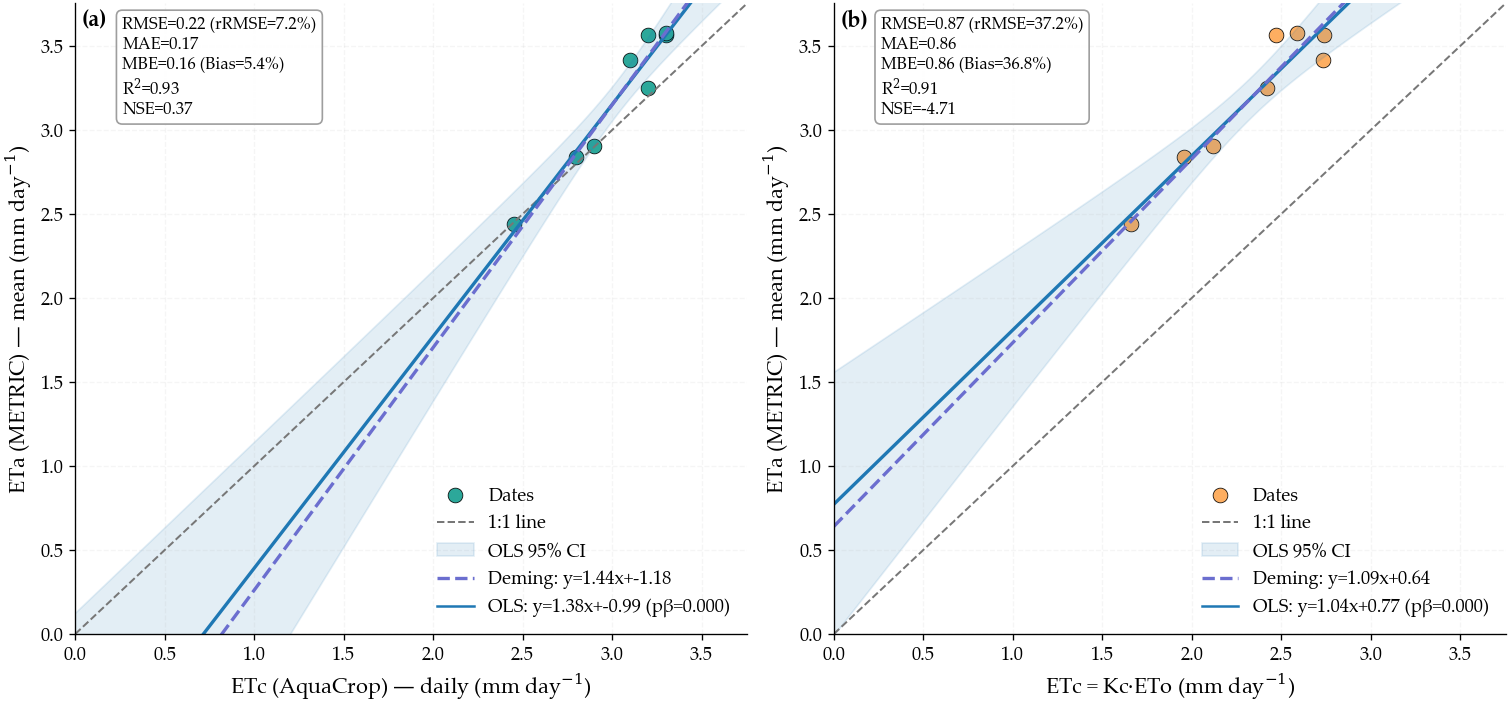

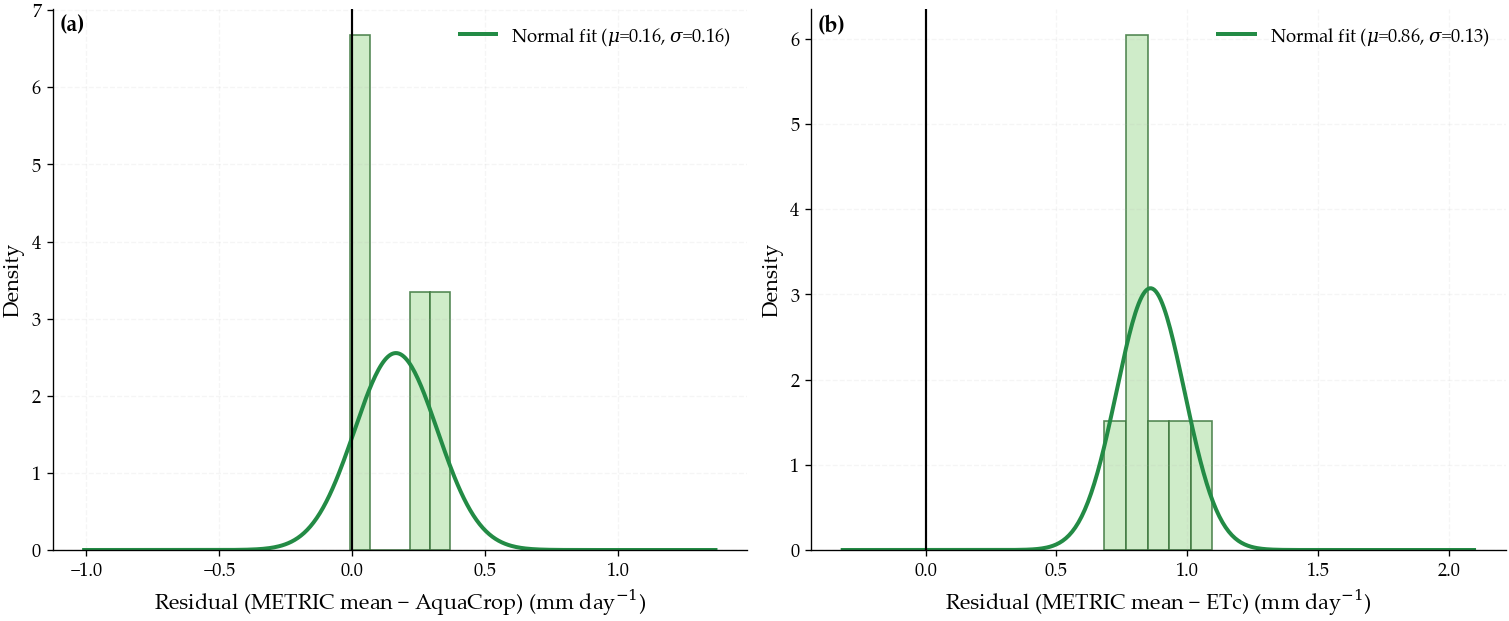


Values used in the figures:
             AquaCrop_daily  ETc_PM  METRIC_mean  Residual_mean_minus_AquaCrop  \
2021-11-26            3.30   2.472        3.568                         0.268   
2021-12-04            3.30   2.586        3.575                         0.275   
2022-03-02            3.20   2.740        3.566                         0.366   
2022-03-18            3.10   2.734        3.417                         0.317   
2022-04-03            3.20   2.419        3.251                         0.051   
2022-04-19            2.90   2.117        2.907                         0.007   
2022-04-27            2.80   1.955        2.837                         0.037   
2022-05-05            2.45   1.663        2.441                        -0.009   

            Residual_mean_minus_PM  
2021-11-26                   1.096  
2021-12-04                   0.989  
2022-03-02                   0.825  
2022-03-18                   0.683  
2022-04-03                   0.832  
2022-04-19        

In [45]:
# -*- coding: utf-8 -*-
"""
Q1-ready paired figures (no figure titles):

Figure 1 (two panels):
(a) Scatter: AquaCrop (daily on Landsat dates) vs ETa(METRIC mean)
(b) Scatter: ETc = Kc·ETo (PM) vs ETa(METRIC mean)
  - 1:1 line, OLS (95% CI band), Deming regression
  - Compact metrics box: RMSE, rRMSE%, MAE, MBE, Bias%, R², NSE
  - p-value for OLS slope shown if SciPy is available
  - Same axis limits and ticks in both panels
  - Saves PNG + PDF

Figure 2 (two panels):
(a) Histogram: Residual = METRIC mean − AquaCrop
(b) Histogram: Residual = METRIC mean − ETc(PM)
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# ────────────── USER CONFIG ──────────────
OUT_DIR       = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
CSV_PATH      = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/meteo/Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/tables/OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI (same as boxplots)
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15  # meters

# Band & mask
USE_ET_POS     = True
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# Monthly Kc
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.56,11:0.8,12:0.64}

# Q1 plotting style
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 13, "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11,
    "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.12,
    "axes.spines.top": False, "axes.spines.right": False,
})

# Colors
C_METME  = "#fdae61"
C_AQC    = "#2ca89a"
C_11     = "#777777"
C_OLS    = "#1f78b4"
C_DEM    = "#6b6ecf"
C_HIST   = "#c7e9c0"
C_PDF    = "#238b45"

# SciPy (optional for p-values)
try:
    import scipy.stats as st
    _SCIPY = True
except Exception:
    _SCIPY = False

# ────────────── Earth Engine ──────────────
import ee, geemap
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ────────────── Station & AquaCrop helpers ──────────────
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = next((c for c in cols if any(k in c.lower() for k in
                 ["fecha","date","datetime","timestamp","fecha hora","date/time"])), None)
    if c_fecha is None: raise KeyError("No date/datetime column found.")
    c_eto = next((c for c in cols if ("eto" in c.lower()) or ("et0" in c.lower()) or (c.lower()=="et")), None)
    if c_eto is None: raise KeyError("No ETo column found.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    c_fecha = next((c for c in df.columns if ("fecha" in str(c).lower()) or ("date" in str(c).lower())), None)
    if c_fecha is None: raise KeyError("AquaCrop: no date column.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("AquaCrop: no ET nor (E,Tr) columns.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d): return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy(); et0.index = pd.to_datetime(et0.index).normalize()
    vals = [(kc_ref_for_date(d) * et0.loc[d]) if d in et0.index and np.isfinite(et0.loc[d]) else np.nan
            for d in idx]
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ────────────── EE helpers ──────────────
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp): return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        return fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_stats_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]).combine(
                    reducer2=ee.Reducer.mean(), sharedInputs=True
               ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
               ),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {k: (float(red.get(f"{bname}_{k}")) if red.get(f"{bname}_{k}") is not None else np.nan)
            for k in ["p5","p25","p50","p75","p95","mean","stdDev"]}

def percentiles_media_por_fecha(lista_imgs, fechas_l8, roi_fc):
    rows, fset = [], set(pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist())
    geom = roi_fc.geometry()
    for item in lista_imgs:
        f = pd.to_datetime(item.get("fecha")).strftime("%Y-%m-%d")
        if f not in fset: continue
        img = item.get("img_ETinst")
        if img is None: continue
        d = reduce_stats_exact(img, geom)
        if not d or d["mean"] is None: continue
        rows.append({"date": f, **d})
    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df

# ────────────── Metrics & fits ──────────────
def met_stats(y_true, y_pred):
    x = np.asarray(y_true, float); y = np.asarray(y_pred, float)
    m = np.isfinite(x) & np.isfinite(y); x, y = x[m], y[m]
    if x.size == 0:
        return dict(n=0, RMSE=np.nan, MAE=np.nan, MBE=np.nan, R2=np.nan, NSE=np.nan)
    rmse = sqrt(np.mean((y-x)**2))
    mae  = np.mean(np.abs(y-x))
    mbe  = np.mean(y-x)
    r = np.corrcoef(x,y)[0,1] if (np.std(x)>0 and np.std(y)>0) else np.nan
    r2 = r**2 if np.isfinite(r) else np.nan
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2) if np.std(x)>0 else np.nan
    return dict(n=int(x.size), RMSE=rmse, MAE=mae, MBE=mbe, R2=r2, NSE=nse)

def _ols_params(X, Y):
    X1 = np.vstack([X, np.ones_like(X)]).T
    beta, _, _, _ = np.linalg.lstsq(X1, Y, rcond=None)
    yhat = X1 @ beta
    n, p = X1.shape
    s2 = np.sum((Y - yhat)**2) / max(n - p, 1)
    cov = s2 * np.linalg.inv(X1.T @ X1)
    se  = np.sqrt(np.diag(cov))
    return beta, cov, se, yhat, n, p

def _deming(x, y, lam=1.0):
    xbar, ybar = x.mean(), y.mean()
    s_xx = np.var(x, ddof=1); s_yy = np.var(y, ddof=1); s_xy = np.cov(x,y, ddof=1)[0,1]
    if not np.isfinite(s_xy): return np.nan, np.nan
    b = (s_yy - lam*s_xx + np.sqrt((s_yy - lam*s_xx)**2 + 4*lam*s_xy**2)) / (2*s_xy)
    a = ybar - b*xbar
    return float(b), float(a)

# ────────────── Two-panel figures ──────────────
def scatters_two_panels(x_left, y_left, x_right, y_right, out_png):
    """
    1×2 figure:
      (a) AquaCrop vs METRIC mean
      (b) ETc(PM) vs METRIC mean
    Adds 1:1, OLS (95% CI band + p for slope), Deming; common axes; panel letters.
    """
    os.makedirs(OUT_DIR, exist_ok=True)
    fig, axes = plt.subplots(1, 2, figsize=(12.6, 5.9), constrained_layout=True)

    def _draw(ax, Xs, Ys, point_color, xlabel, ylabel):
        sub = pd.DataFrame({"x": Xs, "y": Ys}).dropna()
        X = sub["x"].values; Y = sub["y"].values
        stats = met_stats(X, Y)

        xmax = max(1.05*max(np.nanmax(X), np.nanmax(Y)), 1.0)
        xs = np.linspace(0, xmax, 300)

        # OLS + CI band
        beta, cov, se, yhat, n, p = _ols_params(X, Y)
        preds = np.vstack([xs, np.ones_like(xs)]).T @ beta
        se_line = np.sqrt(np.sum((np.vstack([xs, np.ones_like(xs)]).T @ cov) *
                                 np.vstack([xs, np.ones_like(xs)]).T, axis=1))
        tval = st.t.ppf(0.975, df=max(n-p,1)) if _SCIPY else 1.96
        lo, hi = preds - tval*se_line, preds + tval*se_line

        # Deming
        s_dem, i_dem = _deming(X, Y, 1.0)

        # Plot
        ax.scatter(X, Y, s=78, color=point_color, edgecolor="k", linewidth=0.45, label="Dates")
        ax.plot([0, xmax], [0, xmax], "--", color=C_11, lw=1.2, label="1:1 line")
        ax.plot(xs, preds, lw=2.0, color=C_OLS)
        ax.fill_between(xs, lo, hi, alpha=0.12, color=C_OLS, label="OLS 95% CI")
        if np.isfinite(s_dem):
            ax.plot(xs, s_dem*xs + i_dem, lw=2.0, ls="--", color=C_DEM,
                    label=f"Deming: y={s_dem:.2f}x+{i_dem:.2f}")

        ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

        # p-value slope
        if _SCIPY and se[0] > 0:
            t_slope = beta[0]/se[0]
            p_slope = 2*(1 - st.t.cdf(abs(t_slope), df=max(n-p,1)))
            ols_label = f"OLS: y={beta[0]:.2f}x+{beta[1]:.2f} (pβ={p_slope:.3f})"
        else:
            ols_label = f"OLS: y={beta[0]:.2f}x+{beta[1]:.2f}"
        ax.plot([], [], color=C_OLS, label=ols_label)

        # Metrics (rRMSE%, Bias%)
        mean_x = np.nanmean(X)
        rrmse = 100 * stats['RMSE'] / mean_x if mean_x and np.isfinite(mean_x) else np.nan
        biasp = 100 * stats['MBE']  / mean_x if mean_x and np.isfinite(mean_x) else np.nan
        txt = (f"RMSE={stats['RMSE']:.2f} (rRMSE={rrmse:.1f}%)\n"
               f"MAE={stats['MAE']:.2f}\n"
               f"MBE={stats['MBE']:.2f} (Bias={biasp:.1f}%)\n"
               f"R$^2$={stats['R2']:.2f}\n"
               f"NSE={stats['NSE']:.2f}")
        ax.text(0.07, 0.98, txt, transform=ax.transAxes, va="top",
                bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="#999", alpha=0.95), fontsize=10)
        ax.legend(frameon=False, loc="lower right")

        return xmax

    # LEFT (a): AquaCrop vs METRIC mean
    xmax_left = _draw(
        axes[0], x_left, y_left, C_AQC,
        xlabel="ETc (AquaCrop) — daily (mm day$^{-1}$)",
        ylabel="ETa (METRIC) — mean (mm day$^{-1}$)"
    )
    axes[0].text(0.01, 0.99, "(a)", transform=axes[0].transAxes, va="top", ha="left",
                 fontsize=13, fontweight="bold")

    # RIGHT (b): ETc(PM) vs METRIC mean
    xmax_right = _draw(
        axes[1], x_right, y_right, C_METME,
        xlabel="ETc = Kc·ETo (mm day$^{-1}$)",
        ylabel="ETa (METRIC) — mean (mm day$^{-1}$)"
    )
    axes[1].text(0.01, 0.99, "(b)", transform=axes[1].transAxes, va="top", ha="left",
                 fontsize=13, fontweight="bold")

    # Common axes/ticks
    lim = min(4.5, max(xmax_left, xmax_right))
    for ax in axes:
        ax.set_xlim(0, lim); ax.set_ylim(0, lim)
        ax.set_xticks(np.arange(0, lim+0.001, 0.5))
        ax.set_yticks(np.arange(0, lim+0.001, 0.5))

    # Save
    os.makedirs(OUT_DIR, exist_ok=True)
    fig.savefig(os.path.join(OUT_DIR, out_png))
    fig.savefig(os.path.join(OUT_DIR, out_png.replace(".png", ".pdf")))
    plt.show()

def residuals_two_panels(res_left, label_left, res_right, label_right, out_png):
    """Two histograms with panel letters (a) and (b)."""
    os.makedirs(OUT_DIR, exist_ok=True)
    rL = np.asarray(pd.Series(res_left).dropna().values, float)
    rR = np.asarray(pd.Series(res_right).dropna().values, float)

    fig, axes = plt.subplots(1, 2, figsize=(12.6, 5.2), constrained_layout=True)

    def _draw(ax, r, xlabel):
        if r.size == 0:
            ax.text(0.5, 0.5, "No valid residuals", transform=ax.transAxes,
                    ha="center", va="center"); ax.set_axis_off(); return
        mu  = float(np.mean(r))
        sig = float(np.std(r, ddof=1)) if r.size>1 else float(np.std(r))
        xs  = np.linspace(min(r)-1, max(r)+1, 400)
        pdf = (1/(sig*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/sig)**2) if sig>0 else np.zeros_like(xs)

        ax.hist(r, bins=min(8, max(5, r.size//2)), density=True,
                color=C_HIST, edgecolor="#3c763d", alpha=0.85)
        ax.plot(xs, pdf, lw=2.4, color=C_PDF, label=f"Normal fit ($\\mu$={mu:.2f}, $\\sigma$={sig:.2f})")
        ax.axvline(0, color="k", lw=1.3)
        ax.set_xlabel(xlabel); ax.set_ylabel("Density")
        ax.legend(frameon=False)

    _draw(axes[0], rL, label_left)
    axes[0].text(0.01, 0.99, "(a)", transform=axes[0].transAxes,
                 va="top", ha="left", fontsize=13, fontweight="bold")

    _draw(axes[1], rR, label_right)
    axes[1].text(0.01, 0.99, "(b)", transform=axes[1].transAxes,
                 va="top", ha="left", fontsize=13, fontweight="bold")

    fig.savefig(os.path.join(OUT_DIR, out_png))
    fig.savefig(os.path.join(OUT_DIR, out_png.replace(".png", ".pdf")))
    plt.show()

# ────────────── MAIN ──────────────
def main():
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Missing 'lista_imgprocesadas_ET' in memory with your METRIC images.")

    idx_l8 = pd.to_datetime(LANDSAT_DATES).normalize()

    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)

    df_stats = percentiles_media_por_fecha(lista_imgprocesadas_ET, LANDSAT_DATES, fc_new)
    mean = df_stats.set_index("date")["mean"].reindex(idx_l8)

    et0_daily = read_et0_daily_from_station(CSV_PATH)
    etc_pm    = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)
    etc_aqc_on_l8 = etc_aqc_daily.reindex(idx_l8)

    # Figure 1: two scatters (AquaCrop on the LEFT, PM on the RIGHT)
    scatters_two_panels(
        x_left  = etc_aqc_on_l8,   y_left  = mean,
        x_right = etc_pm,          y_right = mean,
        out_png = "Scatters_mean_panels_ab.png"
    )

    # Figure 2: residual histograms (unchanged)
    res_mean_minus_aqc = mean - etc_aqc_on_l8
    res_mean_minus_pm  = mean - etc_pm
    residuals_two_panels(
        res_left   = res_mean_minus_aqc,
        label_left = "Residual (METRIC mean − AquaCrop) (mm day$^{-1}$)",
        res_right  = res_mean_minus_pm,
        label_right= "Residual (METRIC mean − ETc) (mm day$^{-1}$)",
        out_png    = "Residuals_mean_panels_ab.png"
    )

    # Optional: print values used
    df_out = pd.DataFrame({
        "AquaCrop_daily": etc_aqc_on_l8,
        "ETc_PM": etc_pm,
        "METRIC_mean": mean,
        "Residual_mean_minus_AquaCrop": res_mean_minus_aqc,
        "Residual_mean_minus_PM": res_mean_minus_pm
    }).round(3)
    print("\nValues used in the figures:\n", df_out)

if __name__ == "__main__":
    main()


In [29]:
# -*- coding: utf-8 -*-
"""
Serie temporal Q1 con BOXPLOTS METRIC + NUBE DE PUNTOS (sin outliers) + línea de medianas
— Cajas ETc(METRIC) p5–p95 por fecha Landsat (SIN fliers)
— Línea que une las MEDIANAS (p50) de cada boxplot
— Nube de píxeles submuestreada y coloreada por ETc, filtrada por p5–p95 de cada fecha
— AquaCrop daily atenuado + tendencia en fechas METRIC
— ETc = Kc·ETo (PM) en fechas Landsat
— Exporta PNG 600 dpi (bbox_inches='tight')
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Earth Engine / geemap
import ee, geemap

# === Inline Jupyter (seguro) ===
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# ================== RUTAS / CONFIG USUARIO ==================
CSV_PATH      = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\raw\meteo\Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\data\processed\tables\OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2023-10-15","2024-01-11","2024-01-27","2024-02-04",
    "2024-02-20","2024-03-15","2024-04-16","2024-04-24",
]

# ROI NUEVA
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m (≈0.5 px)

# Opciones
USE_ET_POS          = True
SHOW_LANDSAT_VLINES = False
FIG_TS              = "Q1_ts_with_METRIC_boxes_points_palette_NEWROI_MEDIANLINE_noOutliers"

# Kc mensual para ETc(PM)
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.56,11:0.62,12:0.64}

# ====== Estilo Q1 ======
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 0.8,
})

# Colores de series
C_ETC        = "#4ab928"   # ETc(PM)
C_AQC        = "#2ca89a"   # AquaCrop daily (fuera)
C_AQC_DIM    = "#bfc9c5"   # AquaCrop daily (dentro)
C_AQC_TREND  = "#1d7f72"   # AquaCrop trend
C_BOX_FACE   = "#dfeae6"   # relleno caja
C_BOX_EDGE   = "0.35"      # borde/whiskers
C_MED_LINE   = "0.25"      # línea de medianas

# —— Paleta para los píxeles (gradiente continuo)
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
CMAP_PIX = LinearSegmentedColormap.from_list("pixETc", palette_stops, N=256)

# ===== LEYENDA (Legend) =====
LEG_NCOL  = 2                 # Número de columnas en la leyenda (2 columnas)
LEG_LOC   = "upper left"      # Posición de la leyenda dentro del gráfico
LEG_BBOX  = (0.01, 0.99)      # Desplazamiento (x, y) relativo dentro del área de la figura
LEG_FRAME = True              # Mostrar marco en la leyenda

# ===== EJES (Axes settings) =====
Y_LABEL            = "ET (mm day$^{-1}$)"
Y_LABELPAD         = 8
Y_FORCE_ZERO_BASE  = True
Y_ZERO_PAD_ABS     = 0.6
Y_TOP_PAD_REL      = 0.05
Y_TOP_PAD_ABS      = 1.4
X_MARGIN_DAYS      = 7                     # margen lateral pequeño (ajustado)
X_TICK_EVERY_MONTHS= 2

# ===== RANGO / ESCALA (EE reduceRegion params) =====
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# ===== NUBE DE PUNTOS (Pixel scatter settings) =====
DRAW_POINTS             = True
FILTER_POINTS_BY_WHISKERS = True
POINTS_PER_DATE_MAX     = 800
POINTS_JITTER_DAYS_HALF = 6
POINTS_MARKERSIZE       = 2.8
POINTS_ALPHA            = 0.78
POINTS_SEED             = None

# ===== BARRA DE COLOR (Colorbar config) =====
CBAR_LABEL       = "ETa (mm d$^{-1}$)"
CBAR_AUTORANGE   = False
CBAR_VMIN        = 0.0
CBAR_VMAX        = 8.0
CBAR_WIDTH_PCT   = "21%"
CBAR_HEIGHT_PCT  = "3.4%"
CBAR_LOC         = 'upper right'
CBAR_TICKS       = "minmax"
CBAR_LABELPAD    = -5.7
CBAR_TICKPAD     = 0.8


# ================== EE INIT ==================
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ================== HELPERS (Estación / AquaCrop) ==================
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        cl = c.lower()
        if ("eto" in cl) or ("et0" in cl) or (cl == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if ("fecha" in c.lower()) or ("date" in c.lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date column found in AquaCrop sheet.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + \
                   pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("No ET or (E, Tr) columns in AquaCrop sheet.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy()
    et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ================== HELPERS (EE para cajas / puntos METRIC) ==================
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_percentiles_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    return {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
    }

def sample_pixels_values(img: ee.Image, geom: ee.Geometry,
                         nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) -> list:
    """Devuelve una lista de valores (submuestreados) del raster en ROI."""
    bname = get_band_name(img)
    if bname is None: return []
    im = img.select(bname).updateMask(img.select(bname).gte(ET_MIN).And(img.select(bname).lte(ET_MAX)))
    samp = (im.sample(region=geom, scale=SCALE_M, tileScale=TILESCALE, geometries=False)
              .randomColumn('rand', seed=seed)
              .sort('rand')
              .limit(int(nmax)))
    try:
        vals = samp.aggregate_array(bname).getInfo() or []
    except Exception:
        vals = []
    out = []
    for v in vals:
        try:
            fv = float(v)
            if np.isfinite(fv):
                out.append(fv)
        except Exception:
            pass
    return out

def percentiles_y_puntos_por_fecha_NEWROI(lista_imgs, fechas_l8, roi_fc):
    """
    Devuelve:
      dfp -> DataFrame con p5..p95 por fecha (para boxplots)
      points_dict -> dict {pd.Timestamp: np.array([vals])} para la nube (SIN outliers si se habilita)
    """
    rows = []
    points_dict = {}
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()

    for item in lista_imgs:
        f = pd.to_datetime(item["fecha"]).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue

        # Percentiles exactos en ROI
        d = reduce_percentiles_exact(img, geom)
        if not d or d["p50"] is None:
            continue

        # Guardamos stats para boxplot
        rows.append({
            "date": f,
            "p5":  float(d["p5"]),
            "p25": float(d["p25"]),
            "p50": float(d["p50"]),
            "p75": float(d["p75"]),
            "p95": float(d["p95"]),
        })

        # Submuestreo de píxeles
        vals = sample_pixels_values(img, geom, nmax=POINTS_PER_DATE_MAX, seed=POINTS_SEED) if DRAW_POINTS else []

        # Filtro de outliers de la nube (por bigotes p5–p95)
        if FILTER_POINTS_BY_WHISKERS and vals:
            lo, hi = float(d["p5"]), float(d["p95"])
            vals = [v for v in vals if (v >= lo and v <= hi)]

        points_dict[pd.to_datetime(f)] = np.array(vals, dtype=float)

    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df, points_dict

def draw_metric_boxes_on_date_axis(ax, dfp, widths_days=12):
    """Dibuja cajas p5–p95 sobre el eje temporal (positions = fechas).
       Outliers desactivados explícitamente (showfliers=False)."""
    if dfp.empty:
        return None
    fechas = dfp["date"].tolist()
    stats = []
    for _, r in dfp.iterrows():
        stats.append(dict(
            label=r["date"].strftime("%Y-%m-%d"),
            med=r.p50, q1=r.p25, q3=r.p75, whislo=r.p5, whishi=r.p95
        ))
    positions = mdates.date2num(fechas)
    bxp = ax.bxp(stats, showfliers=False, positions=positions,
                 widths=widths_days, patch_artist=True, zorder=1)
    for box in bxp['boxes']:
        box.set_facecolor(C_BOX_FACE); box.set_alpha(0.35)
        box.set_edgecolor(C_BOX_EDGE); box.set_linewidth(1.1); box.set_zorder(1)
    for el in ["whiskers","caps","medians"]:
        for obj in bxp[el]:
            obj.set_color(C_BOX_EDGE); obj.set_linewidth(1.1); obj.set_zorder(1)
    return bxp

def draw_points_swarm(ax, points_dict, cmap, norm):
    """Nube de puntos con jitter y color por valor (pequeña, tenue, detrás)."""
    if not points_dict:
        return np.array([])
    rng = np.random.RandomState(POINTS_SEED)
    all_vals = []
    for d, vals in points_dict.items():
        if vals.size == 0:
            continue
        x0 = mdates.date2num(d)
        jitter = (rng.rand(vals.size) - 0.5) * 2 * POINTS_JITTER_DAYS_HALF
        x = x0 + jitter
        ax.scatter(
            x, vals,
            s=POINTS_MARKERSIZE**2, c=vals, cmap=cmap, norm=norm,
            alpha=POINTS_ALPHA, linewidths=0, zorder=0.9, rasterized=True
        )
        all_vals.append(vals)
    return np.concatenate(all_vals) if all_vals else np.array([])

# ================== HANDLER LEYENDA: símbolo real de caja ==================
class BoxLegend:
    def __init__(self, fc, ec): self.fc, self.ec = fc, ec

class HandlerBoxplot(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        fc, ec = orig_handle.fc, orig_handle.ec
        box = Rectangle((xdescent + 0.10*width, ydescent + 0.25*height),
                        0.80*width, 0.50*height,
                        facecolor=fc, edgecolor=ec, lw=1.1, alpha=0.35)
        median = plt.Line2D([xdescent + 0.12*width, xdescent + 0.88*width],
                            [ydescent + 0.50*height, ydescent + 0.50*height], color=ec, lw=1.2)
        midx = xdescent + 0.50*width
        whisk_top = plt.Line2D([midx, midx], [ydescent + 0.75*height, ydescent + 0.98*height], color=ec, lw=1.1)
        whisk_bot = plt.Line2D([midx, midx], [ydescent + 0.02*height, ydescent + 0.25*height], color=ec, lw=1.1)
        cap_top   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.98*height, ydescent + 0.98*height], color=ec, lw=1.1)
        cap_bot   = plt.Line2D([midx-0.14*width, midx+0.14*width], [ydescent + 0.02*height, ydescent + 0.02*height], color=ec, lw=1.1)
        for a in [box, median, whisk_top, whisk_bot, cap_top, cap_bot]: a.set_transform(trans)
        return [box, median, whisk_top, whisk_bot, cap_top, cap_bot]

# ================== FIGURA ==================
def fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, landsat_dates, df_boxes_newroi, points_dict):
    plt.close('all')

    # Fechas Landsat normalizadas
    idx_l8 = pd.to_datetime(landsat_dates).normalize()
    et0_daily.index     = pd.to_datetime(et0_daily.index).normalize()
    etc_aqc_daily.index = pd.to_datetime(etc_aqc_daily.index).normalize()

    # ETc(PM) en fechas Landsat
    etcpm_l8  = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # Ventana METRIC (para recortar el eje X y atenuar AquaCrop)
    win_start, win_end = idx_l8.min(), idx_l8.max()

    # >>> Mantener tamaño de figura tal cual
    fig, ax = plt.subplots(figsize=(13.2, 5.2), constrained_layout=False)

    # Estética base
    for s in ["left","bottom"]: ax.spines[s].set_linewidth(0.8)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", length=4, width=0.8)
    ax.grid(axis="y", linestyle="--", alpha=0.18)

    # AquaCrop daily (fuera/dentro de ventana METRIC)
    idx_all = etc_aqc_daily.index; y_all = etc_aqc_daily.values
    inside_mask  = (idx_all >= win_start) & (idx_all <= win_end)
    y_all_clean = y_all.copy(); y_all_clean[inside_mask] = np.nan
    ax.plot(idx_all, y_all_clean, lw=2.0, color=C_AQC, alpha=0.98,
            label="ETc (AquaCrop) — daily (outside METRIC window)", zorder=2)
    ax.plot(idx_all[inside_mask], y_all[inside_mask], lw=2.0, color=C_AQC_DIM, alpha=0.85,
            label="ETc (AquaCrop) — daily (within METRIC window, dimmed)", zorder=1)

    # Tendencia AquaCrop (en fechas Landsat)
    aqc_on_metric = etc_aqc_daily.reindex(idx_l8).dropna()
    ln_aqc_trend, = ax.plot(
        aqc_on_metric.index, aqc_on_metric.values,
        "-o", lw=2, ms=5, mfc="white", mec=C_AQC_TREND, mew=1.1,
        color=C_AQC_TREND, label="ETc (AquaCrop) — trend on METRIC dates", zorder=3.2
    )

    # ===== NUBE DE PUNTOS coloreada (ya sin outliers) =====
    norm = Normalize(vmin=CBAR_VMIN, vmax=CBAR_VMAX)
    pix_vals_all = draw_points_swarm(ax, points_dict, cmap=CMAP_PIX, norm=norm) if DRAW_POINTS and points_dict else np.array([])

    # Cajas METRIC (SIN fliers)
    draw_metric_boxes_on_date_axis(ax, df_boxes_newroi, widths_days=12)

    # Línea de MEDIANAS (p50) uniendo cada fecha
    med_series = df_boxes_newroi.set_index('date')["p50"].sort_index()
    ln_med, = ax.plot(
        med_series.index, med_series.values,
        "-s", lw=2, ms=4.5, color=C_MED_LINE, mfc="white", mec=C_MED_LINE, mew=0.9,
        label="ETa (METRIC) — median", zorder=4
    )

    # ETc = Kc·ETo (PM)
    ln_etcpm, = ax.plot(
        idx_l8, etcpm_l8.values,
        marker="^", ms=6, lw=2.0, color=C_ETC,
        mec="white", mew=0.9, label="Crop ETc = Kc·ETo (PM)", zorder=3.1
    )

    # Ejes y límites
    ax.xaxis.set_major_locator(MonthLocator(interval=X_TICK_EVERY_MONTHS))
    ax.minorticks_off()
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
    ax.set_xlabel("Date")
    ax.set_ylabel(Y_LABEL, labelpad=Y_LABELPAD)

    # === Límites del eje X: SOLO intervalo METRIC + margen lateral pequeño ===
    ax.set_xlim(win_start - pd.Timedelta(days=X_MARGIN_DAYS),
                win_end   + pd.Timedelta(days=X_MARGIN_DAYS))
    for lab in ax.get_xticklabels(which="major"):
        lab.set_rotation(30); lab.set_ha("right")

    # Límites Y (incluye puntos y p95)
    y_candidates = [etc_aqc_daily.values, med_series.values]
    if df_boxes_newroi is not None and not df_boxes_newroi.empty:
        y_candidates.append(df_boxes_newroi["p95"].values)
    if pix_vals_all.size > 0:
        y_candidates.append(pix_vals_all)
    arrcat = np.concatenate([np.asarray(a, float)[np.isfinite(a)] for a in y_candidates if len(a)>0])
    if arrcat.size > 0:
        y_min_data = float(np.nanmin(arrcat)); y_max_data = float(np.nanmax(arrcat))
        y_range    = max(1e-6, y_max_data - y_min_data)
        y_top_pad  = max(Y_TOP_PAD_REL * y_range, Y_TOP_PAD_ABS)
        y_hi       = y_max_data + y_top_pad
        y_lo       = 0.0 - float(Y_ZERO_PAD_ABS) if Y_FORCE_ZERO_BASE else y_min_data - 0.06*y_range
        ax.set_ylim(y_lo, y_hi)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # Líneas verticales tenues
    for xnum in ax.get_xticks():
        ax.axvline(x=xnum, color="0.9", lw=0.8, ls="--", zorder=0)
    if SHOW_LANDSAT_VLINES:
        for x in idx_l8:
            ax.axvline(x, color="0.92", lw=0.8, zorder=0)

    # ===== LEYENDA =====
    class _BoxLegend(BoxLegend): pass
    box_handle = _BoxLegend(fc=C_BOX_FACE, ec=C_BOX_EDGE)

    LEG_MS = 4.2  # tamaño uniforme

    # (Se eliminó la entrada 'pixels subset' de la leyenda)
    handles = [
        plt.Line2D([], [], marker="^", ms=6, lw=2.0, color=C_ETC,
                   mec="white", mew=0.9),                     # ETc = Kc·ETo (PM)
        box_handle,                                           # ETa (METRIC) cajas
        plt.Line2D([], [], marker="s", ms=4, lw=2.0,
                   color=C_MED_LINE, mfc="white",
                   mec=C_MED_LINE, mew=0.9),                  # Mediana METRIC
        plt.Line2D([], [], color=C_AQC, lw=2.0),              # AquaCrop daily
        plt.Line2D([], [], color=C_AQC_TREND, lw=2.4, marker='o', ms=4.5,
                   mfc="white", mec=C_AQC_TREND, mew=1.1)     # AquaCrop trend
    ]
    labels = [
        "Crop ETc = Kc·ETo (PM)",
        "ETa (METRIC)",
        "ETa (METRIC) — median",
        "ETc (AquaCrop) — daily",
        "ETc (AquaCrop) — trend"
    ]
    leg = ax.legend(
        handles, labels, ncol=LEG_NCOL, loc=LEG_LOC, bbox_to_anchor=LEG_BBOX,
        frameon=LEG_FRAME, framealpha=0.92, facecolor="white", edgecolor="0.85",
        fancybox=True, borderaxespad=0.4, handlelength=1.8, columnspacing=1.4,
        handler_map={_BoxLegend: HandlerBoxplot()}
    )
    leg.get_frame().set_linewidth(0.8)

    # ===== Barra de color (esquina superior derecha) =====
    sm = plt.cm.ScalarMappable(norm=norm, cmap=CMAP_PIX)
    cax = inset_axes(ax, width=CBAR_WIDTH_PCT, height=CBAR_HEIGHT_PCT,
                     loc=CBAR_LOC, borderpad=0.7)
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    if CBAR_TICKS == "minmax":
        cbar.set_ticks([norm.vmin, norm.vmax])
    cbar.set_label(CBAR_LABEL, fontsize=10, labelpad=CBAR_LABELPAD)
    cbar.outline.set_linewidth(0.6)
    cax.tick_params(axis='x', labelsize=9, pad=CBAR_TICKPAD)

    # Guardar
    output_dir = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, FIG_TS + ".png")

    fig.savefig(output_path, dpi=600, bbox_inches="tight", pad_inches=0.03)
    plt.show()
    print(f"✅ Figure saved successfully at: {output_path}")

# ================== MAIN ==================
def main():
    # Requiere 'lista_imgprocesadas_ET' en memoria:
    # [{'fecha':'YYYY-MM-DD','img_ETinst':ee.Image,'stats':DataFrame(...)}]
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    et0_daily     = read_et0_daily_from_station(CSV_PATH)
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)

    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)
    df_boxes_new, points_dict = percentiles_y_puntos_por_fecha_NEWROI(
        lista_imgprocesadas_ET, LANDSAT_DATES, fc_new
    )

    fig_timeseries_with_boxes(et0_daily, etc_aqc_daily, LANDSAT_DATES,
                              df_boxes_new, points_dict)

if __name__ == "__main__":
    main()


KeyError: 'date'

# ----- GRÁFICA CORRELACIONES FINALES -----

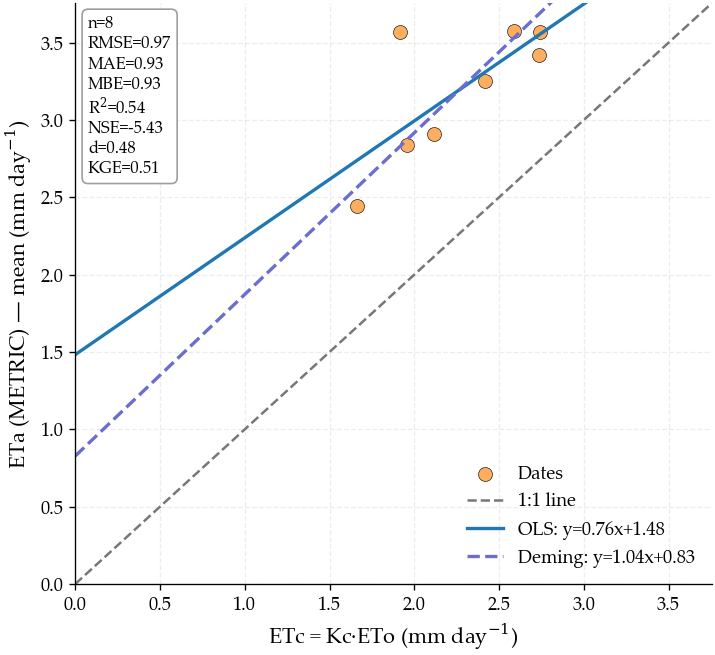

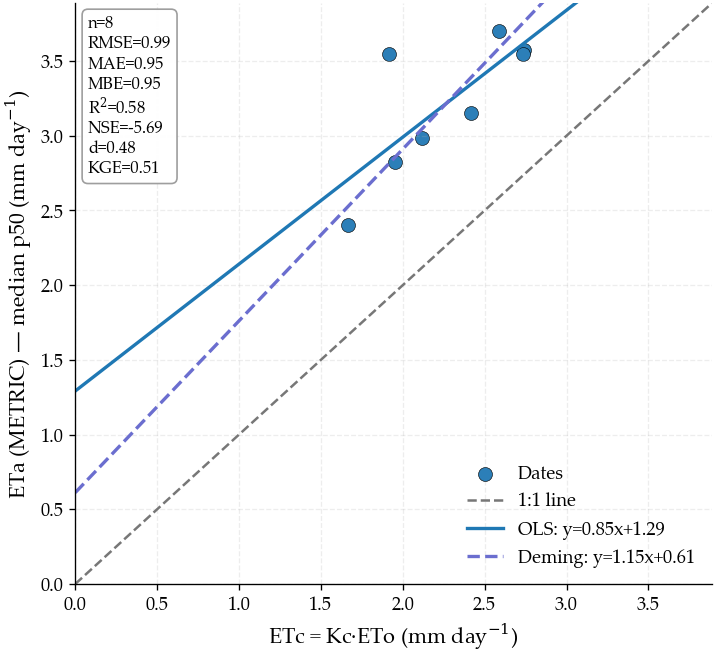

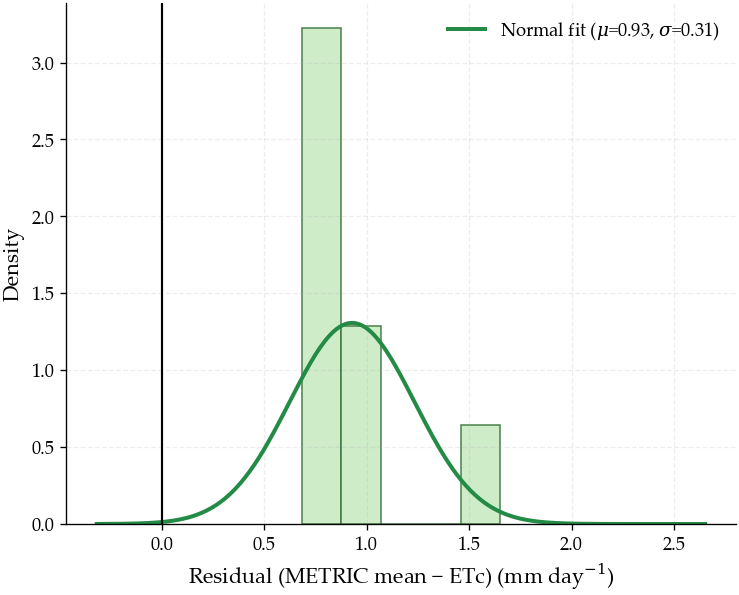

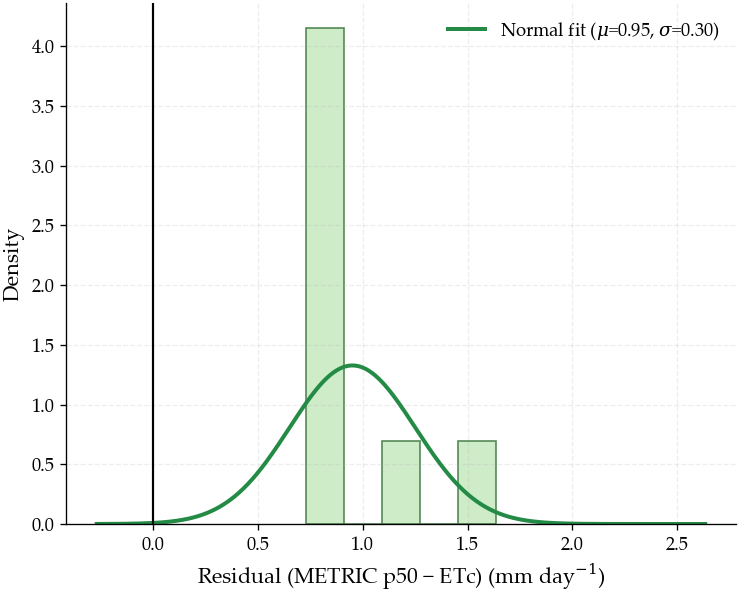

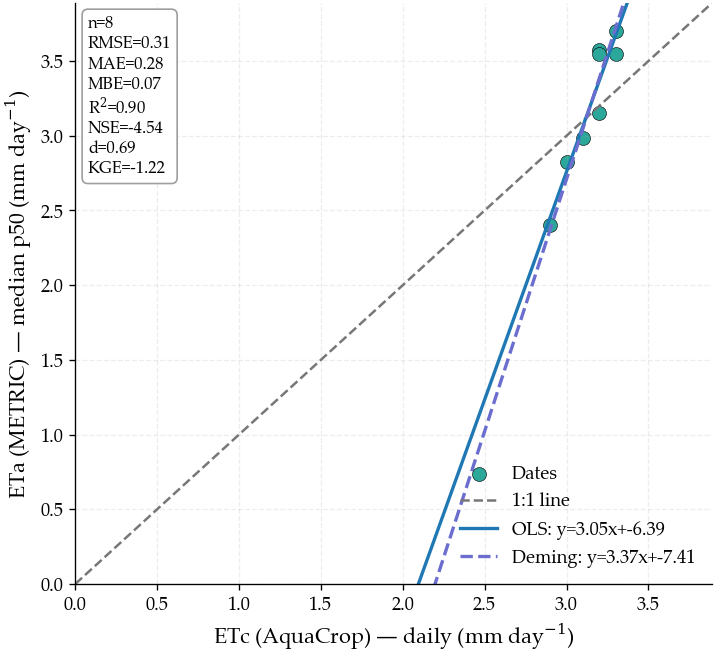

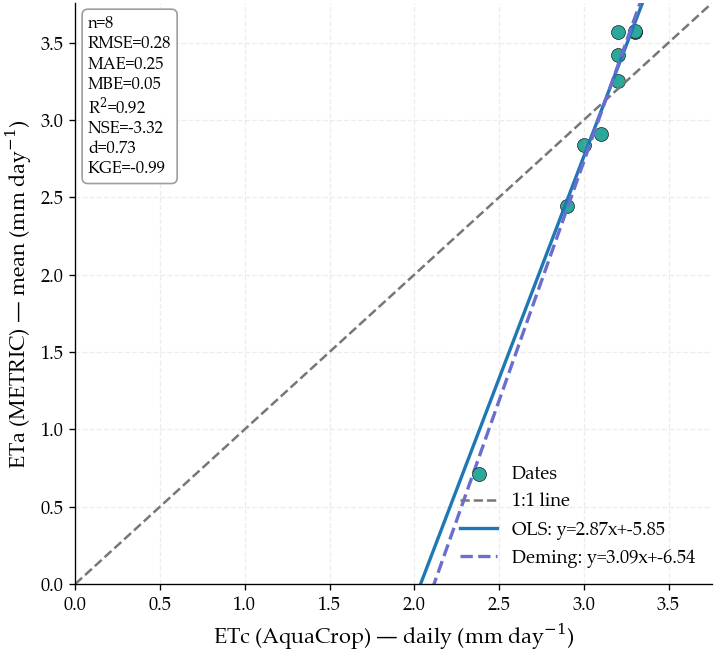


Valores usados en las figuras:
             ETc_PM  AquaCrop_daily  METRIC_mean  METRIC_p50  \
2021-11-26   1.916             3.3        3.568       3.550   
2021-12-04   2.586             3.3        3.575       3.700   
2022-03-02   2.740             3.2        3.566       3.576   
2022-03-18   2.734             3.2        3.417       3.546   
2022-04-03   2.419             3.2        3.251       3.149   
2022-04-19   2.117             3.1        2.907       2.983   
2022-04-27   1.955             3.0        2.837       2.827   
2022-05-05   1.663             2.9        2.441       2.404   

            Residual_mean_minus_PM  Residual_p50_minus_PM  
2021-11-26                   1.652                  1.634  
2021-12-04                   0.989                  1.115  
2022-03-02                   0.825                  0.835  
2022-03-18                   0.683                  0.811  
2022-04-03                   0.832                  0.730  
2022-04-19                   0.790     

In [30]:
# -*- coding: utf-8 -*-
"""
Gráficos Q1 consistentes con los boxplots (SIN títulos en las figuras):
- MISMO ETc(METRIC) que las cajas: p50 (mediana) y media con la MISMA máscara y ROI erosionado.
- Scatter 1: ETc = Kc·ETo vs ETc(METRIC mean)
- Scatter 2: ETc = Kc·ETo vs ETc(METRIC p50)
- Scatter 3: AquaCrop (diario en fechas Landsat) vs ETc(METRIC p50)
- Histograma 1: residuos (METRIC mean − ETc_PM)
- Histograma 2: residuos (METRIC p50 − ETc_PM)
- Scatter 4 (nuevo): AquaCrop (diario en fechas Landsat) vs ETc(METRIC mean)

Requisitos: tener en memoria `lista_imgprocesadas_ET` y acceso a EE.
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# ────────────── CONFIG USUARIO ──────────────
OUT_DIR       = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
CSV_PATH      = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/meteo/Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/tables/OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI (igual a tus boxplots)
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m

# Banda y máscara (igual a tus boxplots)
USE_ET_POS     = True
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# Kc mensual (igual a tu curva)
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.56,11:0.62,12:0.64}

# Estilo Q1 (Palatino)
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 13, "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11,
    "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.22,
    "axes.spines.top": False, "axes.spines.right": False,
})

# Colores
C_PM     = "#4ab928"   # ETc(Kc·ETo)
C_METME  = "#fdae61"   # puntos METRIC mean
C_MET50  = "#2c7fb8"   # puntos METRIC p50
C_AQC    = "#2ca89a"   # puntos AquaCrop
C_11     = "#777777"   # 1:1
C_OLS    = "#1f78b4"
C_DEM    = "#6b6ecf"
C_HIST   = "#c7e9c0"
C_PDF    = "#238b45"

# ────────────── Earth Engine ──────────────
import ee, geemap
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ────────────── Utilidades estación / AquaCrop ──────────────
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if any(k in c.lower() for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        if ("eto" in c.lower()) or ("et0" in c.lower()) or (c.lower() == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    c_fecha = None
    for c in df.columns:
        if ("fecha" in str(c).lower()) or ("date" in str(c).lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("AquaCrop: no date column.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("AquaCrop: no ET nor (E,Tr) columns.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy(); et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ────────────── EE helpers: ROI + reducciones ──────────────
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_stats_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    """Misma máscara/ROI que el boxplot, devolviendo p5..p95 + media + std."""
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]).combine(
                    reducer2=ee.Reducer.mean(), sharedInputs=True
               ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
               ),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    out = {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
        "mean": red.get(f"{bname}_mean"),
        "stdDev": red.get(f"{bname}_stdDev"),
    }
    return out

def percentiles_media_por_fecha(lista_imgs, fechas_l8, roi_fc):
    """DataFrame con p5..p95 + mean + std por fecha (solo fechas en LANDSAT_DATES)."""
    rows = []
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()
    for item in lista_imgs:
        f = pd.to_datetime(item.get("fecha")).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue
        d = reduce_stats_exact(img, geom)
        if not d or d["p50"] is None:
            continue
        rows.append({"date": f, **{k: float(d[k]) if d[k] is not None else np.nan
                                   for k in ["p5","p25","p50","p75","p95","mean","stdDev"]}})
    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df

# ────────────── Métricas y ajustes ──────────────
def met_stats(y_true, y_pred):
    x = np.asarray(y_true, float); y = np.asarray(y_pred, float)
    m = np.isfinite(x) & np.isfinite(y); x, y = x[m], y[m]
    n = x.size
    if n == 0:
        return dict(n=0, RMSE=np.nan, MAE=np.nan, MBE=np.nan, R2=np.nan, NSE=np.nan, d=np.nan, KGE=np.nan)
    rmse = sqrt(np.mean((y-x)**2)); mae  = np.mean(np.abs(y-x)); mbe  = np.mean(y-x)
    r = np.corrcoef(x,y)[0,1] if (np.std(x)>0 and np.std(y)>0) else np.nan
    r2 = r**2 if np.isfinite(r) else np.nan
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2) if np.std(x)>0 else np.nan
    beta = y.mean()/x.mean() if x.mean()!=0 else np.nan
    alpha= np.std(y)/np.std(x) if np.std(x)>0 else np.nan
    kge  = 1 - sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2) if np.all(np.isfinite([r,alpha,beta])) else np.nan
    dden = np.sum((np.abs(y-x.mean()) + np.abs(x-x.mean()))**2)
    d    = 1 - np.sum((y-x)**2)/dden if dden>0 else np.nan
    return dict(n=int(n), RMSE=rmse, MAE=mae, MBE=mbe, R2=r2, NSE=nse, d=d, KGE=kge)

def _ols(x,y):
    if len(x) < 2: return np.nan, np.nan
    A = np.vstack([x, np.ones_like(x)]).T
    s, i = np.linalg.lstsq(A, y, rcond=None)[0]
    return float(s), float(i)

def _deming(x, y, lam=1.0):
    xbar, ybar = x.mean(), y.mean()
    s_xx = np.var(x, ddof=1); s_yy = np.var(y, ddof=1); s_xy = np.cov(x,y, ddof=1)[0,1]
    if not np.isfinite(s_xy): return np.nan, np.nan
    b = (s_yy - lam*s_xx + np.sqrt((s_yy - lam*s_xx)**2 + 4*lam*s_xy**2)) / (2*s_xy)
    a = ybar - b*xbar
    return float(b), float(a)

# ────────────── Figuras (sin títulos) ──────────────
def fig_scatter_xy(x_series, y_series, xlabel, ylabel, color_pts, out_png):
    sub = pd.DataFrame({"x": x_series, "y": y_series}).dropna()
    if sub.empty:
        print(f"[Aviso] No hay pares válidos para scatter."); return
    X = sub["x"].values; Y = sub["y"].values
    stats = met_stats(X, Y)
    xmax = max(1.05*max(np.nanmax(X), np.nanmax(Y)), 1.0)
    xs = np.linspace(0, xmax, 300)
    s_ols, i_ols = _ols(X,Y); s_dem, i_dem = _deming(X,Y, 1.0)

    plt.figure(figsize=(6.2,5.7))
    plt.scatter(X, Y, s=70, color=color_pts, edgecolor="k", linewidth=0.35, label="Dates")
    plt.plot([0, xmax], [0, xmax], "--", color=C_11, label="1:1 line")
    if np.isfinite(s_ols): plt.plot(xs, s_ols*xs + i_ols, lw=2.0, color=C_OLS, label=f"OLS: y={s_ols:.2f}x+{i_ols:.2f}")
    if np.isfinite(s_dem): plt.plot(xs, s_dem*xs + i_dem, lw=2.0, ls="--", color=C_DEM, label=f"Deming: y={s_dem:.2f}x+{i_dem:.2f}")
    plt.xlim(0, xmax); plt.ylim(0, xmax)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    txt = (f"n={stats['n']}\nRMSE={stats['RMSE']:.2f}\nMAE={stats['MAE']:.2f}\nMBE={stats['MBE']:.2f}\n"
           f"R$^2$={stats['R2']:.2f}\nNSE={stats['NSE']:.2f}\nd={stats['d']:.2f}\nKGE={stats['KGE']:.2f}")
    plt.text(0.02, 0.98, txt, transform=plt.gca().transAxes, va="top",
             bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="#999", alpha=0.95))
    os.makedirs(OUT_DIR, exist_ok=True); plt.legend(frameon=False, loc="lower right")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, out_png)); plt.show()

def fig_residual_hist(residuals, xlabel, out_png):
    r = np.asarray(residuals, float); r = r[np.isfinite(r)]
    if r.size == 0:
        print("[Aviso] No hay residuos válidos para histograma."); return
    mu  = float(np.mean(r))
    sig = float(np.std(r, ddof=1)) if r.size>1 else float(np.std(r))
    xs = np.linspace(min(r)-1, max(r)+1, 400)
    pdf = (1/(sig*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/sig)**2) if sig>0 else np.zeros_like(xs)

    plt.figure(figsize=(6.4,5.2))
    plt.hist(r, bins=min(8, max(5, r.size//2)), density=True, color=C_HIST, edgecolor="#3c763d", alpha=0.85)
    plt.plot(xs, pdf, lw=2.4, color=C_PDF, label=f"Normal fit ($\\mu$={mu:.2f}, $\\sigma$={sig:.2f})")
    plt.axvline(0, color="k", lw=1.3)
    plt.xlabel(xlabel); plt.ylabel("Density")
    plt.legend(frameon=False)
    os.makedirs(OUT_DIR, exist_ok=True); plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, out_png)); plt.show()

# ────────────── MAIN ──────────────
def main():
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    idx_l8 = pd.to_datetime(LANDSAT_DATES).normalize()

    # EE: ROI erosionado
    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)

    # 1) MISMO origen que el boxplot: p5..p95 + mean + std (misma máscara y ROI)
    df_stats = percentiles_media_por_fecha(lista_imgprocesadas_ET, LANDSAT_DATES, fc_new)
    p50  = df_stats.set_index("date")["p50"].reindex(idx_l8)
    mean = df_stats.set_index("date")["mean"].reindex(idx_l8)

    # 2) ETc = Kc·ETo (PM) en fechas Landsat
    et0_daily = read_et0_daily_from_station(CSV_PATH)
    etc_pm    = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # 2b) AquaCrop diario muestreado en fechas Landsat
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)
    etc_aqc_on_l8 = etc_aqc_daily.reindex(idx_l8)

    # ─── FIGURAS ───
    # (1) Scatter: ETc(PM) vs METRIC mean
    fig_scatter_xy(
        x_series = etc_pm,
        y_series = mean,
        xlabel   = "ETc = Kc·ETo (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — mean (mm day$^{-1}$)",
        color_pts= C_METME,
        out_png  = "ETc_PM_vs_METRIC_mean.png"
    )

    # (2) Scatter: ETc(PM) vs METRIC median (p50)
    fig_scatter_xy(
        x_series = etc_pm,
        y_series = p50,
        xlabel   = "ETc = Kc·ETo (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — median p50 (mm day$^{-1}$)",
        color_pts= C_MET50,
        out_png  = "ETc_PM_vs_METRIC_p50.png"
    )

    # (3) Histograma de residuos — ORDENADO primero con MEDIA
    residual_mean = mean - etc_pm
    fig_residual_hist(
        residuals = residual_mean,
        xlabel    = "Residual (METRIC mean − ETc) (mm day$^{-1}$)",
        out_png   = "Residuals_hist_METRICmean_minus_ETcPM.png"
    )

    # (4) Histograma de residuos — luego con MEDIANA (p50)
    residual_p50 = p50 - etc_pm
    fig_residual_hist(
        residuals = residual_p50,
        xlabel    = "Residual (METRIC p50 − ETc) (mm day$^{-1}$)",
        out_png   = "Residuals_hist_METRICp50_minus_ETcPM.png"
    )

    # (5) Scatter: AquaCrop vs METRIC p50
    fig_scatter_xy(
        x_series = etc_aqc_on_l8,
        y_series = p50,
        xlabel   = "ETc (AquaCrop) — daily (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — median p50 (mm day$^{-1}$)",
        color_pts= C_AQC,
        out_png  = "AquaCrop_vs_METRIC_p50.png"
    )

    # (6) Scatter (NUEVO): AquaCrop vs METRIC mean
    fig_scatter_xy(
        x_series = etc_aqc_on_l8,
        y_series = mean,
        xlabel   = "ETc (AquaCrop) — daily (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — mean (mm day$^{-1}$)",
        color_pts= C_AQC,
        out_png  = "AquaCrop_vs_METRIC_mean.png"
    )

    # (opcional) imprime en consola los valores usados
    df_out = pd.DataFrame({
        "ETc_PM": etc_pm,
        "AquaCrop_daily": etc_aqc_on_l8,
        "METRIC_mean": mean,
        "METRIC_p50": p50,
        "Residual_mean_minus_PM": residual_mean,
        "Residual_p50_minus_PM": residual_p50
    }).round(3)
    print("\nValores usados en las figuras:\n", df_out)

if __name__ == "__main__":
    main()


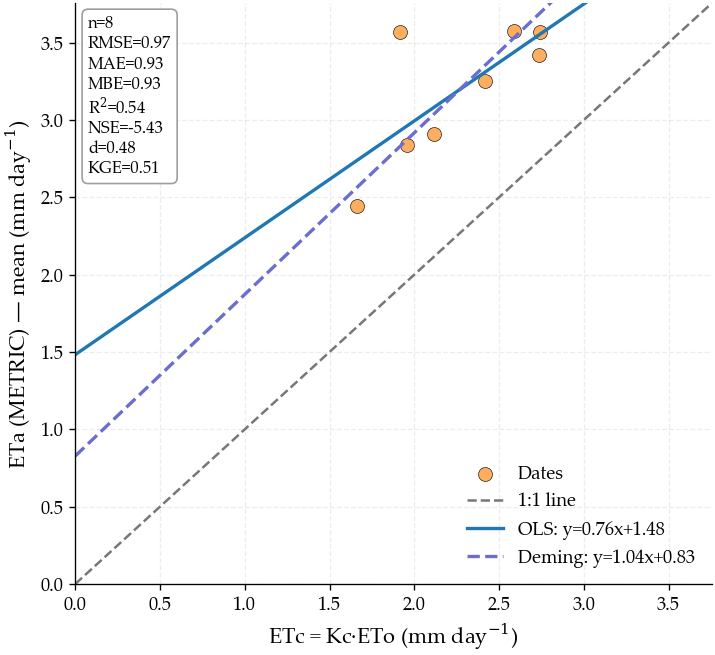

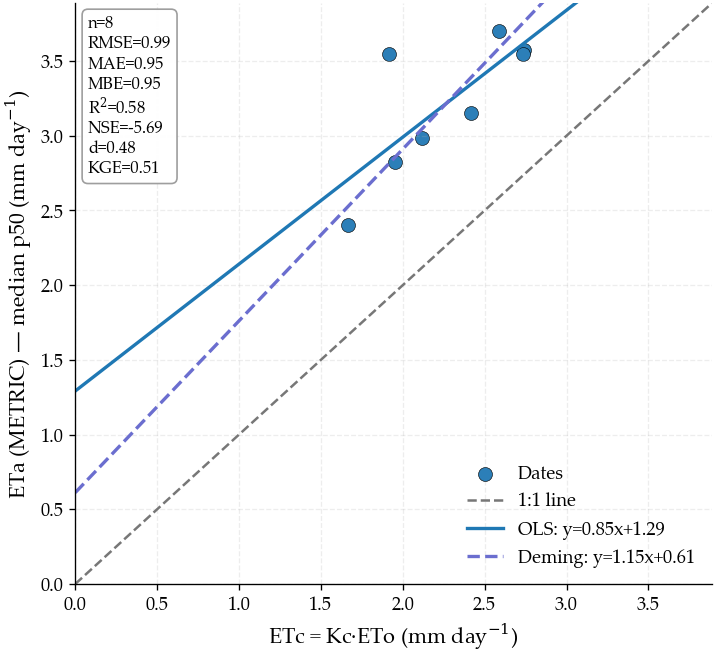

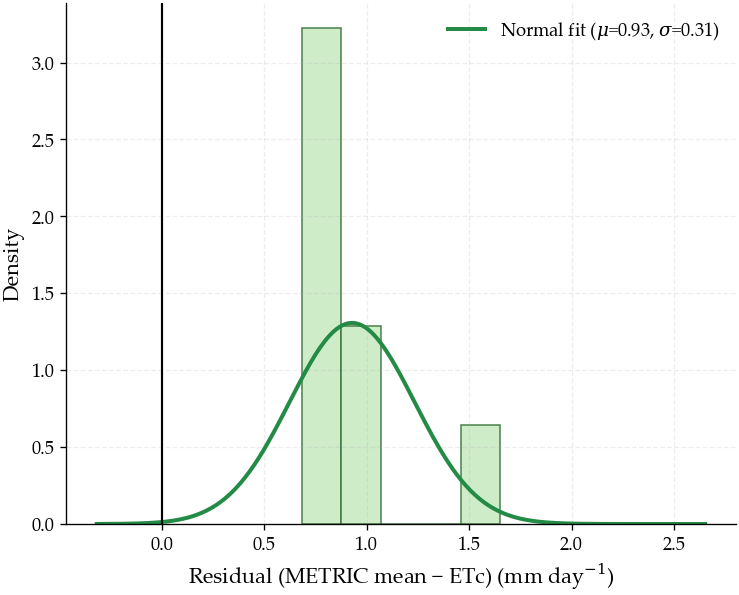

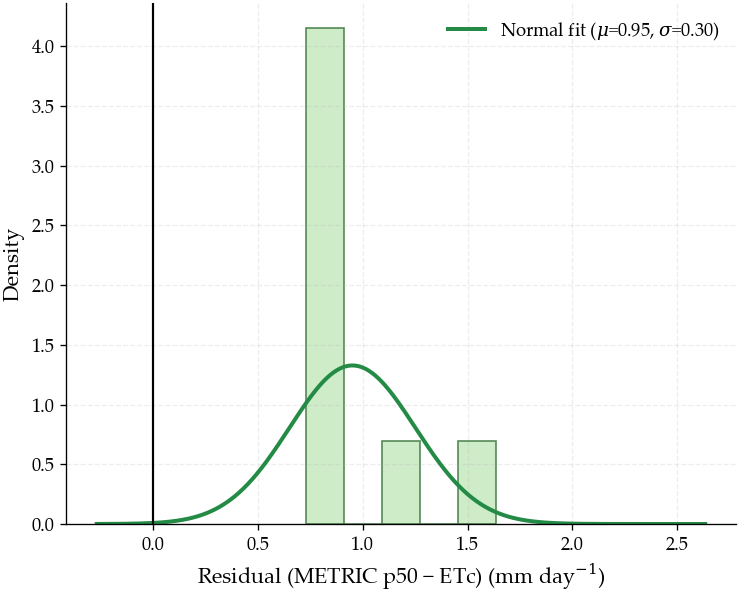

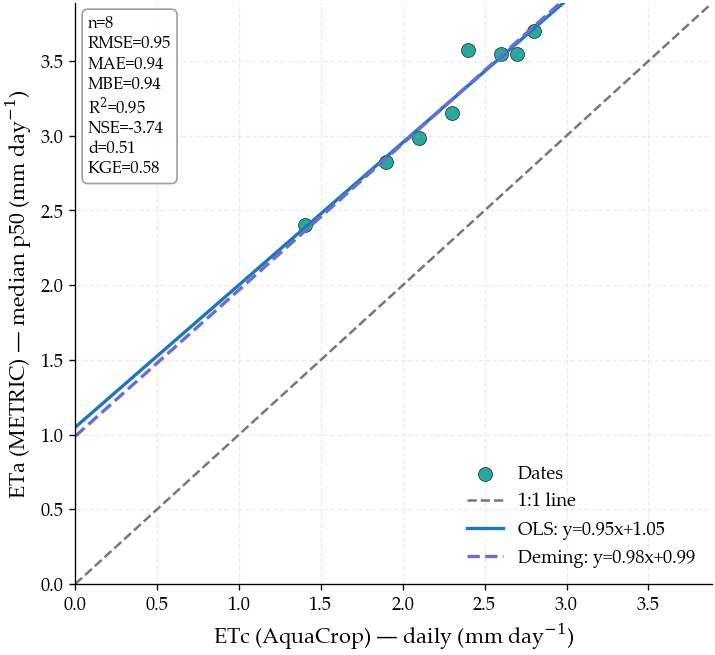

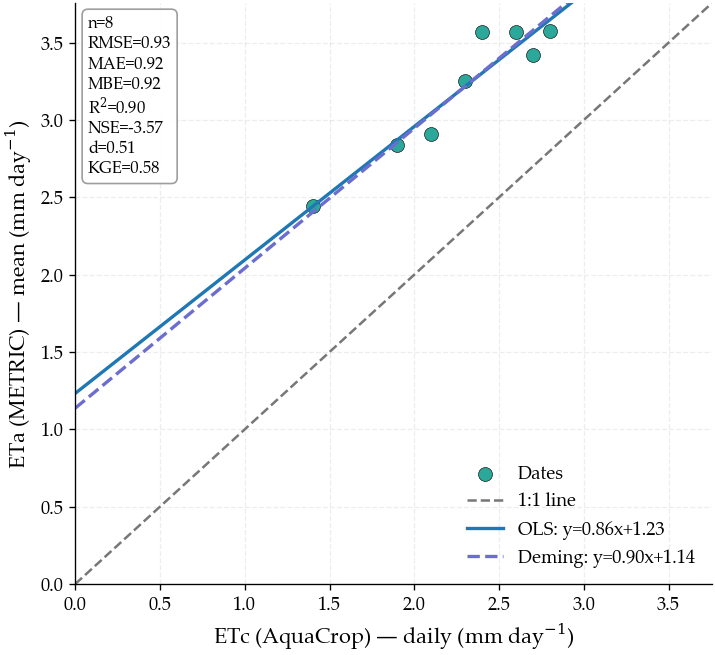

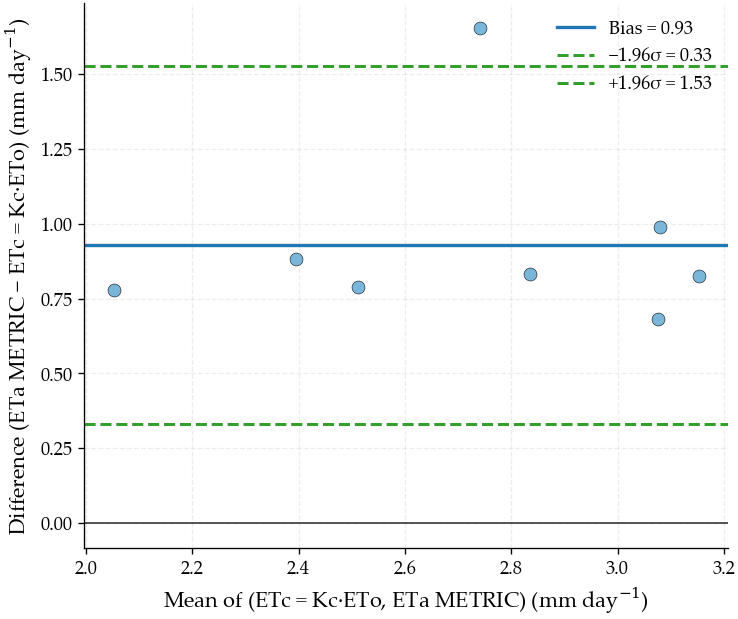

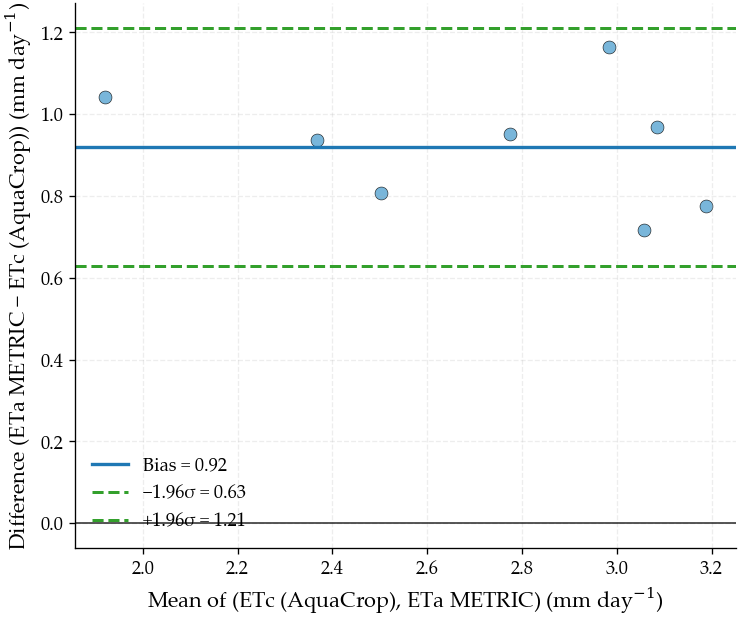

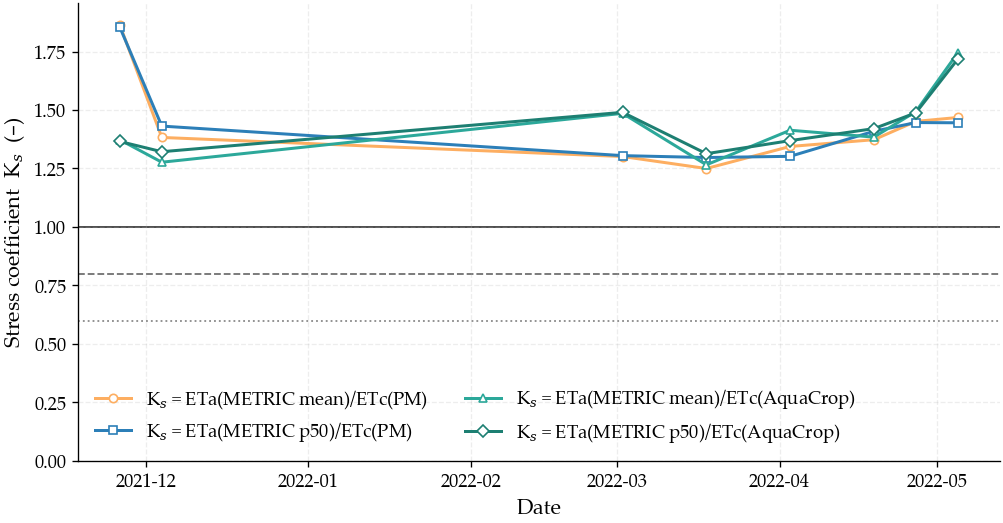


Valores usados en las figuras:
             ETc_PM  AquaCrop_daily  METRIC_mean  METRIC_p50  \
2021-11-26   1.916             2.6        3.568       3.550   
2021-12-04   2.586             2.8        3.575       3.700   
2022-03-02   2.740             2.4        3.566       3.576   
2022-03-18   2.734             2.7        3.417       3.546   
2022-04-03   2.419             2.3        3.251       3.149   
2022-04-19   2.117             2.1        2.907       2.983   
2022-04-27   1.955             1.9        2.837       2.827   
2022-05-05   1.663             1.4        2.441       2.404   

            Residual_mean_minus_PM  Residual_p50_minus_PM  
2021-11-26                   1.652                  1.634  
2021-12-04                   0.989                  1.115  
2022-03-02                   0.825                  0.835  
2022-03-18                   0.683                  0.811  
2022-04-03                   0.832                  0.730  
2022-04-19                   0.790     

In [45]:
# -*- coding: utf-8 -*-
"""
Comparaciones Q1 entre ETa (METRIC) y ETc (FAO-56 / AquaCrop)
— Figuras SIN títulos (ideal para paper)
— Mantiene Palatino, 600 dpi, y tu ROI erosionado y máscara p5–p95

Incluye:
(1) Scatter: ETc(PM) vs ETa(METRIC mean)
(2) Scatter: ETc(PM) vs ETa(METRIC p50)
(3) Histograma de residuos: (METRIC mean − ETc_PM)
(4) Histograma de residuos: (METRIC p50 − ETc_PM)
(5) Scatter: AquaCrop (daily@Landsat) vs ETa(METRIC p50)
(6) Scatter: AquaCrop (daily@Landsat) vs ETa(METRIC mean)
(7) Bland–Altman: ETa(METRIC mean) vs ETc(PM)
(8) Bland–Altman: ETa(METRIC mean) vs ETc(AquaCrop)
(9) Serie temporal de K_s = ETa/ETc (PM y AquaCrop; mean y p50)

REQUISITOS:
- Variable global `lista_imgprocesadas_ET` en memoria con ítems:
  [{"fecha": "YYYY-MM-DD", "img_ETinst": ee.Image, ...}, ...]
- Acceso a EE y a tus rutas de estación/AquaCrop/ROI
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt

# ────────────── CONFIG USUARIO ──────────────
OUT_DIR       = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc"
CSV_PATH      = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/meteo/Data_Meteo_Tacna.csv"
AQC_XLSX_PATH = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/tables/OlivoAquacrop-21-22.xlsx"
AQC_SHEET     = "Olivo"

LANDSAT_DATES = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03",
    "2022-04-19", "2022-04-27", "2022-05-05",
]

# ROI (igual a tus boxplots)
RUTA_SHP_NEW = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"
ASSET_NEW    = "projects/ee-joluhumu/assets/Olive"
BUFFER_ERODE_NEW = 15   # m

# Banda y máscara (igual a tus boxplots)
USE_ET_POS     = True
ET_MIN, ET_MAX = 0.0, 8.0
SCALE_M        = 30
TILESCALE      = 8

# Kc mensual (igual a tu curva)
Kc_ref_by_month = {1:0.65,2:0.66,3:0.62,4:0.58,5:0.54,6:0.48,7:0.47,8:0.48,9:0.52,10:0.56,11:0.62,12:0.64}

# Estilo Q1 (Palatino)
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 600,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.03,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype","Book Antiqua","Palatino","TeX Gyre Pagella","Times New Roman","Times"],
    "mathtext.fontset": "dejavuserif",
    "axes.labelsize": 13, "xtick.labelsize": 11, "ytick.labelsize": 11, "legend.fontsize": 11,
    "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.22,
    "axes.spines.top": False, "axes.spines.right": False,
})

# Colores
C_PM     = "#4ab928"   # ETc(Kc·ETo)
C_METME  = "#fdae61"   # puntos METRIC mean
C_MET50  = "#2c7fb8"   # puntos METRIC p50
C_AQC    = "#2ca89a"   # puntos AquaCrop
C_11     = "#777777"   # 1:1
C_OLS    = "#1f78b4"
C_DEM    = "#6b6ecf"
C_HIST   = "#c7e9c0"
C_PDF    = "#238b45"

# ────────────── Earth Engine ──────────────
import ee, geemap
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ────────────── Utilidades estación / AquaCrop ──────────────
def _detect_cols_station(df):
    cols = [c.strip() for c in df.columns]
    c_fecha = None
    for c in cols:
        if any(k in c.lower() for k in ["fecha","date","datetime","timestamp","fecha hora","date/time"]):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("No date/datetime column found in station file.")
    c_eto = None
    for c in cols:
        if ("eto" in c.lower()) or ("et0" in c.lower()) or (c.lower() == "et"):
            c_eto = c; break
    if c_eto is None: raise KeyError("No ETo/ET0/ET column found in station file.")
    return c_fecha, c_eto

def read_et0_daily_from_station(csv_path=CSV_PATH):
    df = pd.read_csv(csv_path, low_memory=False, encoding_errors="ignore")
    df.columns = [c.strip() for c in df.columns]
    col_fecha, col_et0 = _detect_cols_station(df)
    df[col_fecha] = pd.to_datetime(df[col_fecha], errors="coerce")
    df[col_et0]   = pd.to_numeric(df[col_et0], errors="coerce")
    df = df.dropna(subset=[col_fecha, col_et0])
    df["Date"] = df[col_fecha].dt.normalize()
    s = df.groupby("Date")[col_et0].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name = "ETo_mm_d"
    return s

def read_aquacrop_etc_daily(xlsx_path=AQC_XLSX_PATH, sheet=AQC_SHEET):
    df = pd.read_excel(xlsx_path, sheet_name=sheet)
    c_fecha = None
    for c in df.columns:
        if ("fecha" in str(c).lower()) or ("date" in str(c).lower()):
            c_fecha = c; break
    if c_fecha is None: raise KeyError("AquaCrop: no date column.")
    df[c_fecha] = pd.to_datetime(df[c_fecha], errors="coerce")
    if "ET" not in df.columns and all(x in df.columns for x in ["E","Tr"]):
        df["ET"] = pd.to_numeric(df["E"], errors="coerce").fillna(0) + pd.to_numeric(df["Tr"], errors="coerce").fillna(0)
    elif "ET" in df.columns:
        df["ET"] = pd.to_numeric(df["ET"], errors="coerce")
    else:
        raise KeyError("AquaCrop: no ET nor (E,Tr) columns.")
    df = df.dropna(subset=[c_fecha, "ET"]).copy()
    df["Date"] = df[c_fecha].dt.normalize()
    s = df.groupby("Date")["ET"].sum().sort_index()
    s.index = pd.to_datetime(s.index).normalize()
    s.name  = "ETc_AquaCrop_mm_d"
    return s

def kc_ref_for_date(d):
    return float(Kc_ref_by_month.get(int(pd.Timestamp(d).month), 0.55))

def compute_etc_pm_on_landsat(et0_daily, landsat_dates):
    idx = pd.to_datetime(landsat_dates).normalize()
    et0 = et0_daily.copy(); et0.index = pd.to_datetime(et0.index).normalize()
    vals = []
    for d in idx:
        eto_d = et0.loc[d] if d in et0.index else np.nan
        kc_d  = kc_ref_for_date(d)
        vals.append(kc_d * eto_d if np.isfinite(eto_d) else np.nan)
    return pd.Series(vals, index=idx, name="ETc_PM_landsat")

# ────────────── EE helpers: ROI + reducciones ──────────────
def load_fc(path_shp: str, asset: str) -> ee.FeatureCollection:
    if os.path.exists(path_shp):
        return geemap.shp_to_ee(path_shp)
    return ee.FeatureCollection(asset)

def erode_fc(fc: ee.FeatureCollection, meters: float) -> ee.FeatureCollection:
    if meters and meters > 0:
        def _erode(f):
            geom = f.geometry().buffer(-meters).simplify(meters/3.0)
            return f.setGeometry(geom)
        fc = fc.map(_erode)
    return fc

def get_band_name(img: ee.Image) -> str:
    names = img.bandNames().getInfo()
    if "ET_pos" in names and USE_ET_POS: return "ET_pos"
    if "ET" in names: return "ET"
    return None

def reduce_stats_exact(img: ee.Image, geom: ee.Geometry) -> dict:
    """Misma máscara/ROI que el boxplot, devolviendo p5..p95 + mean + std."""
    bname = get_band_name(img)
    if bname is None: return {}
    im = img.select(bname)
    im = im.updateMask(im.gte(ET_MIN).And(im.lte(ET_MAX)))
    red = im.reduceRegion(
        reducer=ee.Reducer.percentile([5,25,50,75,95]).combine(
                    reducer2=ee.Reducer.mean(), sharedInputs=True
               ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
               ),
        geometry=geom, scale=SCALE_M, maxPixels=1e10, tileScale=TILESCALE
    ).getInfo() or {}
    out = {
        "p5":  red.get(f"{bname}_p5"),
        "p25": red.get(f"{bname}_p25"),
        "p50": red.get(f"{bname}_p50"),
        "p75": red.get(f"{bname}_p75"),
        "p95": red.get(f"{bname}_p95"),
        "mean": red.get(f"{bname}_mean"),
        "stdDev": red.get(f"{bname}_stdDev"),
    }
    return out

def percentiles_media_por_fecha(lista_imgs, fechas_l8, roi_fc):
    """DataFrame con p5..p95 + mean + std por fecha (solo fechas en LANDSAT_DATES)."""
    rows = []
    fechas = pd.to_datetime(fechas_l8).strftime("%Y-%m-%d").tolist()
    fset   = set(fechas)
    geom   = roi_fc.geometry()
    for item in lista_imgs:
        f = pd.to_datetime(item.get("fecha")).strftime("%Y-%m-%d")
        if f not in fset:
            continue
        img = item.get("img_ETinst")
        if img is None:
            continue
        d = reduce_stats_exact(img, geom)
        if not d or d["p50"] is None:
            continue
        rows.append({"date": f, **{k: float(d[k]) if d[k] is not None else np.nan
                                   for k in ["p5","p25","p50","p75","p95","mean","stdDev"]}})
    df = pd.DataFrame(rows).sort_values("date")
    df["date"] = pd.to_datetime(df["date"])
    return df

# ────────────── Métricas y ajustes ──────────────
def met_stats(y_true, y_pred):
    x = np.asarray(y_true, float); y = np.asarray(y_pred, float)
    m = np.isfinite(x) & np.isfinite(y); x, y = x[m], y[m]
    n = x.size
    if n == 0:
        return dict(n=0, RMSE=np.nan, MAE=np.nan, MBE=np.nan, R2=np.nan, NSE=np.nan, d=np.nan, KGE=np.nan)
    rmse = sqrt(np.mean((y-x)**2)); mae  = np.mean(np.abs(y-x)); mbe  = np.mean(y-x)
    r = np.corrcoef(x,y)[0,1] if (np.std(x)>0 and np.std(y)>0) else np.nan
    r2 = r**2 if np.isfinite(r) else np.nan
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2) if np.std(x)>0 else np.nan
    beta = y.mean()/x.mean() if x.mean()!=0 else np.nan
    alpha= np.std(y)/np.std(x) if np.std(x)>0 else np.nan
    kge  = 1 - sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2) if np.all(np.isfinite([r,alpha,beta])) else np.nan
    dden = np.sum((np.abs(y-x.mean()) + np.abs(x-x.mean()))**2)
    d    = 1 - np.sum((y-x)**2)/dden if dden>0 else np.nan
    return dict(n=int(n), RMSE=rmse, MAE=mae, MBE=mbe, R2=r2, NSE=nse, d=d, KGE=kge)

def _ols(x,y):
    if len(x) < 2: return np.nan, np.nan
    A = np.vstack([x, np.ones_like(x)]).T
    s, i = np.linalg.lstsq(A, y, rcond=None)[0]
    return float(s), float(i)

def _deming(x, y, lam=1.0):
    xbar, ybar = x.mean(), y.mean()
    s_xx = np.var(x, ddof=1); s_yy = np.var(y, ddof=1); s_xy = np.cov(x,y, ddof=1)[0,1]
    if not np.isfinite(s_xy): return np.nan, np.nan
    b = (s_yy - lam*s_xx + np.sqrt((s_yy - lam*s_xx)**2 + 4*lam*s_xy**2)) / (2*s_xy)
    a = ybar - b*xbar
    return float(b), float(a)

# ────────────── Figuras (sin títulos) ──────────────
def fig_scatter_xy(x_series, y_series, xlabel, ylabel, color_pts, out_png):
    sub = pd.DataFrame({"x": x_series, "y": y_series}).dropna()
    if sub.empty:
        print(f"[Aviso] No hay pares válidos para scatter."); return
    X = sub["x"].values; Y = sub["y"].values
    stats = met_stats(X, Y)
    xmax = max(1.05*max(np.nanmax(X), np.nanmax(Y)), 1.0)
    xs = np.linspace(0, xmax, 300)
    s_ols, i_ols = _ols(X,Y); s_dem, i_dem = _deming(X,Y, 1.0)

    plt.figure(figsize=(6.2,5.7))
    plt.scatter(X, Y, s=70, color=color_pts, edgecolor="k", linewidth=0.35, label="Dates")
    plt.plot([0, xmax], [0, xmax], "--", color=C_11, label="1:1 line")
    if np.isfinite(s_ols): plt.plot(xs, s_ols*xs + i_ols, lw=2.0, color=C_OLS, label=f"OLS: y={s_ols:.2f}x+{i_ols:.2f}")
    if np.isfinite(s_dem): plt.plot(xs, s_dem*xs + i_dem, lw=2.0, ls="--", color=C_DEM, label=f"Deming: y={s_dem:.2f}x+{i_dem:.2f}")
    plt.xlim(0, xmax); plt.ylim(0, xmax)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    txt = (f"n={stats['n']}\nRMSE={stats['RMSE']:.2f}\nMAE={stats['MAE']:.2f}\nMBE={stats['MBE']:.2f}\n"
           f"R$^2$={stats['R2']:.2f}\nNSE={stats['NSE']:.2f}\nd={stats['d']:.2f}\nKGE={stats['KGE']:.2f}")
    plt.text(0.02, 0.98, txt, transform=plt.gca().transAxes, va="top",
             bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="#999", alpha=0.95))
    os.makedirs(OUT_DIR, exist_ok=True); plt.legend(frameon=False, loc="lower right")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, out_png)); plt.show()

def fig_residual_hist(residuals, xlabel, out_png):
    r = np.asarray(residuals, float); r = r[np.isfinite(r)]
    if r.size == 0:
        print("[Aviso] No hay residuos válidos para histograma."); return
    mu  = float(np.mean(r))
    sig = float(np.std(r, ddof=1)) if r.size>1 else float(np.std(r))
    xs = np.linspace(min(r)-1, max(r)+1, 400)
    pdf = (1/(sig*np.sqrt(2*np.pi))) * np.exp(-0.5*((xs-mu)/sig)**2) if sig>0 else np.zeros_like(xs)

    plt.figure(figsize=(6.4,5.2))
    plt.hist(r, bins=min(8, max(5, r.size//2)), density=True, color=C_HIST, edgecolor="#3c763d", alpha=0.85)
    plt.plot(xs, pdf, lw=2.4, color=C_PDF, label=f"Normal fit ($\\mu$={mu:.2f}, $\\sigma$={sig:.2f})")
    plt.axvline(0, color="k", lw=1.3)
    plt.xlabel(xlabel); plt.ylabel("Density")
    plt.legend(frameon=False)
    os.makedirs(OUT_DIR, exist_ok=True); plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, out_png)); plt.show()

# —— NUEVO: Bland–Altman
def fig_bland_altman(x_series, y_series, xlabel, out_png):
    """
    Bland–Altman: diferencia vs media (y − x vs (x+y)/2).
    x_series: referencia (ETc), y_series: METRIC (ETa)
    """
    sub = pd.DataFrame({"x": x_series, "y": y_series}).dropna()
    if sub.empty:
        print("[Aviso] No hay pares válidos para Bland–Altman."); return
    x = sub["x"].values.astype(float)
    y = sub["y"].values.astype(float)
    m = 0.5 * (x + y)
    d = y - x  # sesgo: METRIC − ETc

    mu  = float(np.mean(d))
    sd  = float(np.std(d, ddof=1)) if d.size>1 else float(np.std(d))
    loa1, loa2 = mu - 1.96*sd, mu + 1.96*sd  # límites de acuerdo 95%

    plt.figure(figsize=(6.4,5.4))
    plt.scatter(m, d, s=60, color="#6baed6", edgecolor="k", linewidth=0.35, alpha=0.9)
    plt.axhline(mu,  color="#1f78b4", lw=2.0, label=f"Bias = {mu:.2f}")
    plt.axhline(loa1, color="#33a02c", lw=1.8, ls="--", label=f"−1.96σ = {loa1:.2f}")
    plt.axhline(loa2, color="#33a02c", lw=1.8, ls="--", label=f"+1.96σ = {loa2:.2f}")
    plt.axhline(0, color="k", lw=1.1, alpha=0.7)

    plt.xlabel(f"Mean of ({xlabel}, ETa METRIC) (mm day$^{{-1}}$)")
    plt.ylabel("Difference (ETa METRIC − {0}) (mm day$^{{-1}}$)".format(xlabel))
    plt.legend(frameon=False, loc="best")
    os.makedirs(OUT_DIR, exist_ok=True)
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, out_png)); plt.show()

# —— NUEVO: Serie temporal de K_s = ETa/ETc (PM y AquaCrop)
def fig_stress_timeseries(idx_dates, etc_pm, etc_aqc_on_l8, ea_mean, ea_p50, out_png):
    """
    Serie temporal de K_s = ETa/ETc con líneas guía.
    Dibuja dos pares: (PM vs METRIC mean/p50) y (AquaCrop vs METRIC mean/p50)
    """
    # Alinear
    ks_pm_mean = (ea_mean / etc_pm).replace([np.inf, -np.inf], np.nan)
    ks_pm_p50  = (ea_p50  / etc_pm).replace([np.inf, -np.inf], np.nan)
    ks_aq_mean = (ea_mean / etc_aqc_on_l8).replace([np.inf, -np.inf], np.nan)
    ks_aq_p50  = (ea_p50  / etc_aqc_on_l8).replace([np.inf, -np.inf], np.nan)

    plt.figure(figsize=(8.6,4.6))
    # Líneas guía
    for y, ls, col in [(1.0,"-", "0.25"), (0.8,"--","0.45"), (0.6,":","0.55")]:
        plt.axhline(y, color=col, lw=1.1, ls=ls, zorder=0)

    # Curvas (PM)
    plt.plot(idx_dates, ks_pm_mean, "-o", ms=5, lw=1.8, mfc="white", mec="#fdae61", mew=1.0,
             color="#fdae61", label="K$_s$ = ETa(METRIC mean)/ETc(PM)")
    plt.plot(idx_dates, ks_pm_p50, "-s", ms=5, lw=1.8, mfc="white", mec="#2c7fb8", mew=1.0,
             color="#2c7fb8", label="K$_s$ = ETa(METRIC p50)/ETc(PM)")

    # Curvas (AquaCrop)
    plt.plot(idx_dates, ks_aq_mean, "-^", ms=5, lw=1.8, mfc="white", mec="#2ca89a", mew=1.0,
             color="#2ca89a", label="K$_s$ = ETa(METRIC mean)/ETc(AquaCrop)")
    plt.plot(idx_dates, ks_aq_p50, "-D", ms=5, lw=1.8, mfc="white", mec="#1d7f72", mew=1.0,
             color="#1d7f72", label="K$_s$ = ETa(METRIC p50)/ETc(AquaCrop)")

    plt.ylabel("Stress coefficient  K$_s$  (–)")
    plt.xlabel("Date")
    ymax = np.nanmax([ks_pm_mean, ks_pm_p50, ks_aq_mean, ks_aq_p50])
    plt.ylim(0.0, max(1.25, (ymax if np.isfinite(ymax) else 1.0)*1.05))
    plt.legend(ncol=2, frameon=False, loc="best")
    plt.grid(True, linestyle="--", alpha=0.22)
    plt.tight_layout()
    os.makedirs(OUT_DIR, exist_ok=True)
    plt.savefig(os.path.join(OUT_DIR, out_png))
    plt.show()

# ────────────── MAIN ──────────────
def main():
    if "lista_imgprocesadas_ET" not in globals():
        raise RuntimeError("Falta 'lista_imgprocesadas_ET' en memoria con tus imágenes METRIC.")

    idx_l8 = pd.to_datetime(LANDSAT_DATES).normalize()

    # EE: ROI erosionado
    fc_new = erode_fc(load_fc(RUTA_SHP_NEW, ASSET_NEW), BUFFER_ERODE_NEW)

    # 1) MISMO origen que el boxplot: p5..p95 + mean + std (misma máscara y ROI)
    df_stats = percentiles_media_por_fecha(lista_imgprocesadas_ET, LANDSAT_DATES, fc_new)
    p50  = df_stats.set_index("date")["p50"].reindex(idx_l8)
    mean = df_stats.set_index("date")["mean"].reindex(idx_l8)

    # 2) ETc = Kc·ETo (PM) en fechas Landsat
    et0_daily = read_et0_daily_from_station(CSV_PATH)
    etc_pm    = compute_etc_pm_on_landsat(et0_daily, idx_l8)

    # 2b) AquaCrop diario muestreado en fechas Landsat
    etc_aqc_daily = read_aquacrop_etc_daily(AQC_XLSX_PATH, AQC_SHEET)
    etc_aqc_on_l8 = etc_aqc_daily.reindex(idx_l8)

    # ─── FIGURAS EXISTENTES ───
    # (1) Scatter: ETc(PM) vs METRIC mean
    fig_scatter_xy(
        x_series = etc_pm,
        y_series = mean,
        xlabel   = "ETc = Kc·ETo (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — mean (mm day$^{-1}$)",
        color_pts= C_METME,
        out_png  = "ETc_PM_vs_METRIC_mean.png"
    )

    # (2) Scatter: ETc(PM) vs METRIC median (p50)
    fig_scatter_xy(
        x_series = etc_pm,
        y_series = p50,
        xlabel   = "ETc = Kc·ETo (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — median p50 (mm day$^{-1}$)",
        color_pts= C_MET50,
        out_png  = "ETc_PM_vs_METRIC_p50.png"
    )

    # (3) Histograma de residuos — ORDENADO primero con MEDIA
    residual_mean = mean - etc_pm
    fig_residual_hist(
        residuals = residual_mean,
        xlabel    = "Residual (METRIC mean − ETc) (mm day$^{-1}$)",
        out_png   = "Residuals_hist_METRICmean_minus_ETcPM.png"
    )

    # (4) Histograma de residuos — luego con MEDIANA (p50)
    residual_p50 = p50 - etc_pm
    fig_residual_hist(
        residuals = residual_p50,
        xlabel    = "Residual (METRIC p50 − ETc) (mm day$^{-1}$)",
        out_png   = "Residuals_hist_METRICp50_minus_ETcPM.png"
    )

    # (5) Scatter: AquaCrop vs METRIC p50
    fig_scatter_xy(
        x_series = etc_aqc_on_l8,
        y_series = p50,
        xlabel   = "ETc (AquaCrop) — daily (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — median p50 (mm day$^{-1}$)",
        color_pts= C_AQC,
        out_png  = "AquaCrop_vs_METRIC_p50.png"
    )

    # (6) Scatter: AquaCrop vs METRIC mean
    fig_scatter_xy(
        x_series = etc_aqc_on_l8,
        y_series = mean,
        xlabel   = "ETc (AquaCrop) — daily (mm day$^{-1}$)",
        ylabel   = "ETa (METRIC) — mean (mm day$^{-1}$)",
        color_pts= C_AQC,
        out_png  = "AquaCrop_vs_METRIC_mean.png"
    )

    # ─── NUEVO ───
    # (7) Bland–Altman: ETa(METRIC) vs ETc(PM)
    fig_bland_altman(
        x_series = etc_pm,
        y_series = mean,  # puedes replicar con p50 si deseas
        xlabel   = "ETc = Kc·ETo",
        out_png  = "BlandAltman_METRIC_vs_ETcPM.png"
    )

    # (8) Bland–Altman: ETa(METRIC) vs ETc(AquaCrop)
    fig_bland_altman(
        x_series = etc_aqc_on_l8,
        y_series = mean,
        xlabel   = "ETc (AquaCrop)",
        out_png  = "BlandAltman_METRIC_vs_AquaCrop.png"
    )

    # (9) Serie temporal de K_s = ETa/ETc (PM y AquaCrop; mean y p50)
    fig_stress_timeseries(
        idx_dates = idx_l8,
        etc_pm = etc_pm,
        etc_aqc_on_l8 = etc_aqc_on_l8,
        ea_mean = mean,
        ea_p50  = p50,
        out_png = "Ks_timeseries_METRIC_vs_ETc_PM_AquaCrop.png"
    )

    # (opcional) imprime en consola los valores usados
    df_out = pd.DataFrame({
        "ETc_PM": etc_pm,
        "AquaCrop_daily": etc_aqc_on_l8,
        "METRIC_mean": mean,
        "METRIC_p50": p50,
        "Residual_mean_minus_PM": residual_mean,
        "Residual_p50_minus_PM": residual_p50
    }).round(3)
    print("\nValores usados en las figuras:\n", df_out)

if __name__ == "__main__":
    main()


# ---- GRÁFICO METEOROLÓGICO ----

C:\Users\joluh\AppData\Local\Temp\ipykernel_29296\2243456948.py:53: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)
C:\Users\joluh\AppData\Local\Temp\ipykernel_29296\2243456948.py:53: UserWarning: Parsing dates in %m/%d/%Y %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)
C:\Users\joluh\AppData\Local\Temp\ipykernel_29296\2243456948.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


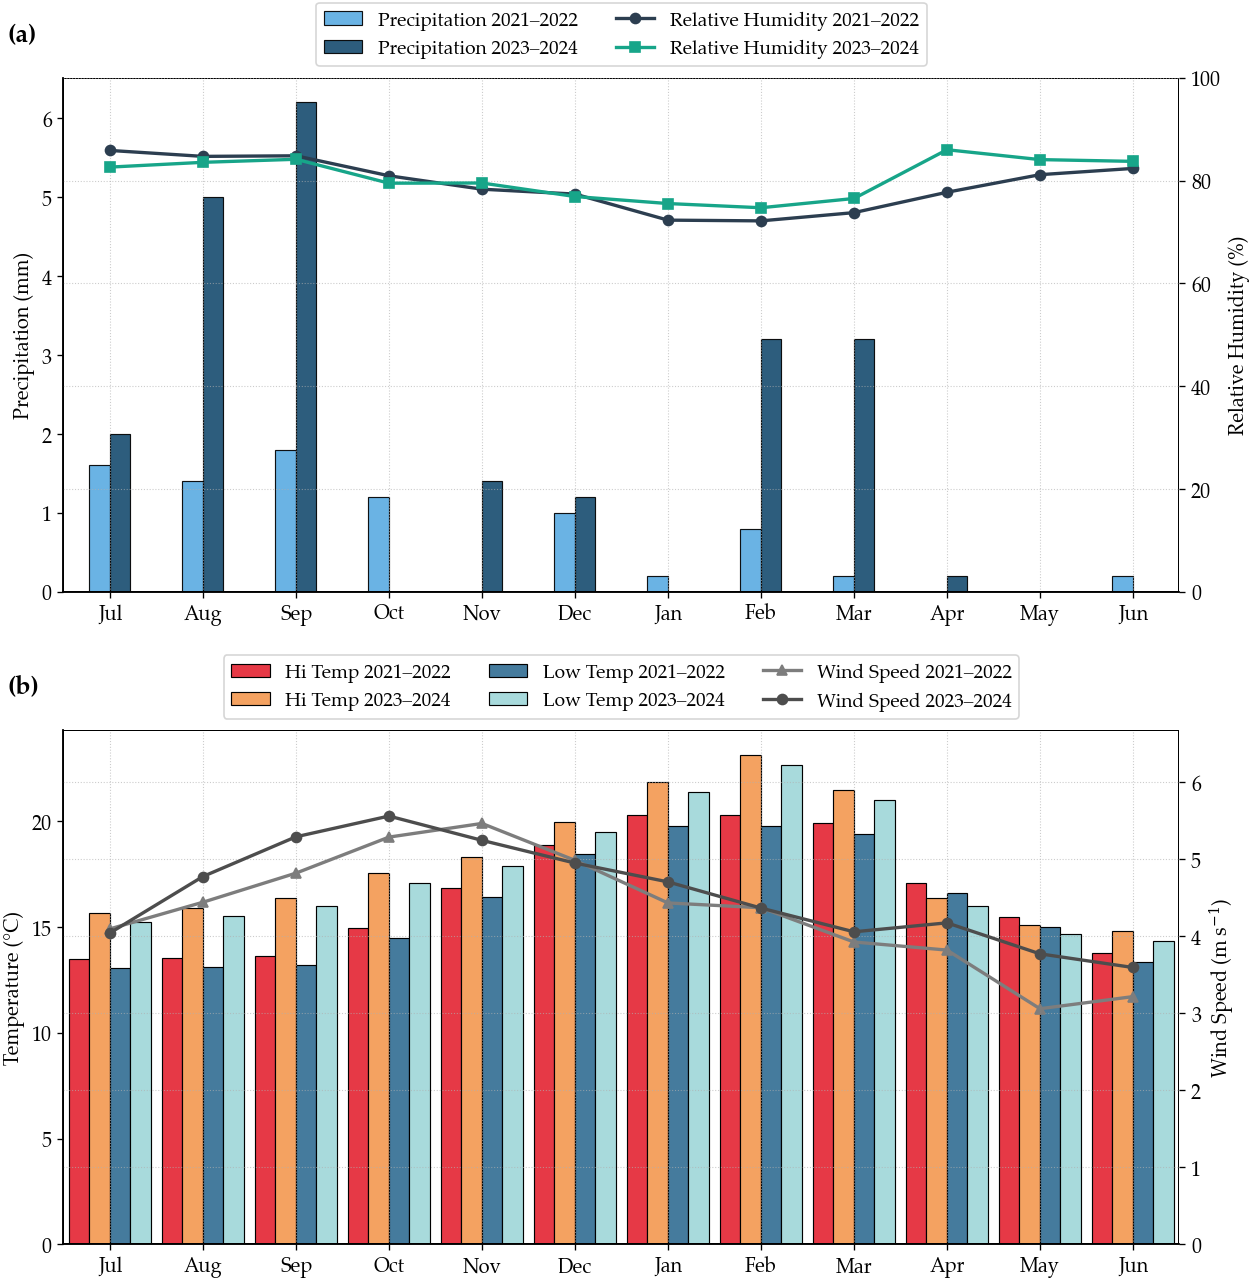

✅ Figura exportada correctamente en:
C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\meteo\Meteo_Precip_RH_HiLowTemp_Wind_JulJun_2021-22_vs_2023-24.png


In [18]:
# -*- coding: utf-8 -*-
"""
Title: Meteorological Data Analysis (2021–2022 vs 2023–2024) – Q1-ready
Description: (a) Precipitation + Relative Humidity, (b) Hi Temp / Low Temp + Wind Speed, para Jul→Jun
Author: José Luis Huanuqueño
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import os

# ==== inline (seguro) ====
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

# =========================
# 0) Estilo global
# =========================
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Palatino Linotype','Palatino','TeX Gyre Pagella','Times New Roman','DejaVu Serif'],
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11.5,
    'figure.titlesize': 16,
    'grid.linestyle': ':',
    'grid.linewidth': 0.65,
    'grid.alpha': 0.65,
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.9,
})

# =========================
# 1) Carga y columnas
# =========================
CSV_PATH = 'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/raw/meteo/Data_Meteo_Tacna.csv'
df = pd.read_csv(CSV_PATH, low_memory=False)

# columna de fecha (detecta nombres usuales)
date_col = next((c for c in df.columns if any(k in c.lower()
                  for k in ['fecha','date','time','timestamp','datetime'])), None)
if date_col is None:
    raise ValueError("No se detectó la columna de fecha (usa 'Fecha' o 'Date').")

df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)
df = df.dropna(subset=[date_col]).copy()

# columnas EXACTAS de temperatura de tu archivo:
COL_TMAX = 'Hi Temp'   # máxima diaria
COL_TMIN = 'Low Temp'  # mínima diaria

# detectar el resto con nombres comunes
def pick(cols, keys):
    for c in cols:
        cl = c.lower()
        if any(k in cl for k in keys):
            return c
    return None

cols = list(df.columns)
COL_RAIN = pick(cols, ['rain','precip','pp','prcp','lluv'])
COL_WIND = pick(cols, ['wind_speed','wind','ws','viento'])
COL_RH   = pick(cols, ['out_hum','hum','hr','relative'])

for c in [COL_TMAX, COL_TMIN, COL_RAIN, COL_WIND, COL_RH]:
    if c is not None and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Orden Jul→Jun
df['Year']  = df[date_col].dt.year
df['Month'] = df[date_col].dt.month
jj_index    = lambda m: ((m - 7) % 12) + 1
df['JJ']    = df['Month'].apply(jj_index)

# =========================
# 2) Campañas
# =========================
mask_c1 = (df[date_col] >= '2021-07-01') & (df[date_col] <= '2022-06-30')  # 2021–2022
mask_c2 = (df[date_col] >= '2023-07-01') & (df[date_col] <= '2024-06-30')  # 2023–2024

c1 = df.loc[mask_c1].copy()
c2 = df.loc[mask_c2].copy()

# =========================
# 3) Agregación mensual (Jul..Jun)
# =========================
def monthly_series(d, col, how='mean'):
    if col is None or col not in d.columns:
        return np.full(12, np.nan)
    g = d.groupby('JJ')[col]
    s = g.sum() if how == 'sum' else g.mean()
    return s.reindex(range(1,13)).to_numpy()

S1 = {
    'rain': monthly_series(c1, COL_RAIN, 'sum'),
    'rh':   monthly_series(c1, COL_RH,   'mean'),
    'tmax': monthly_series(c1, COL_TMAX, 'mean'),
    'tmin': monthly_series(c1, COL_TMIN, 'mean'),
    'wind': monthly_series(c1, COL_WIND, 'mean'),
}
S2 = {
    'rain': monthly_series(c2, COL_RAIN, 'sum'),
    'rh':   monthly_series(c2, COL_RH,   'mean'),
    'tmax': monthly_series(c2, COL_TMAX, 'mean'),
    'tmin': monthly_series(c2, COL_TMIN, 'mean'),
    'wind': monthly_series(c2, COL_WIND, 'mean'),
}

# =========================
# 4) Colores
# =========================
COL = {
    'pr_c1':  '#5DADE2',  'pr_c2':  '#1B4F72',
    'rh_c1':  '#2C3E50',  'rh_c2':  '#17A589',
    'tmax_c1':'#E63946',  'tmax_c2':'#F4A261',
    'tmin_c1':'#457B9D',  'tmin_c2':'#A8DADC',
    'ws_c1':  '#7D7D7D',  'ws_c2':  '#4D4D4D',
}

# =========================
# 5) Figura con recuadros
# =========================
months_jj = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
x = np.arange(12)
bar_w = 0.22

fig = plt.figure(figsize=(12, 12), facecolor='white')
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.27)

# ---------- (a) Precip + RH ----------
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(x - bar_w/2, S1['rain'], width=bar_w, label='Precipitation 2021–2022',
        color=COL['pr_c1'], edgecolor='black', linewidth=0.7, alpha=0.92)
ax1.bar(x + bar_w/2, S2['rain'], width=bar_w, label='Precipitation 2023–2024',
        color=COL['pr_c2'], edgecolor='black', linewidth=0.7, alpha=0.92)
ax1.set_ylabel('Precipitation (mm)')
ax1.set_xticks(x); ax1.set_xticklabels(months_jj)
ax1.set_xlim(-0.5, 11.5); ax1.set_ylim(bottom=0)
ax1.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(x, S1['rh'], marker='o', linewidth=2.0, color=COL['rh_c1'],
         label='Relative Humidity 2021–2022')
ax2.plot(x, S2['rh'], marker='s', linewidth=2.0, color=COL['rh_c2'],
         label='Relative Humidity 2023–2024')
ax2.set_ylabel('Relative Humidity (%)'); ax2.set_ylim(0, 100)

# Leyenda y etiqueta (a)
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper center', ncol=2, frameon=True,
           bbox_to_anchor=(0.5, 1.165))
ax1.text(-0.05, 1.06, '(a)', transform=ax1.transAxes, fontsize=15, fontweight='bold', va='bottom')

# Recuadro
ax1.add_patch(Rectangle((0,0), 1,1, transform=ax1.transAxes, fill=False,
                        lw=1.2, ec='black', zorder=10))

# ---------- (b) Hi/Low Temp + Wind ----------
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(x - 1.5*bar_w, S1['tmax'], bar_w, label='Hi Temp 2021–2022',
        color=COL['tmax_c1'], edgecolor='black', linewidth=0.7)
ax3.bar(x - 0.5*bar_w, S2['tmax'], bar_w, label='Hi Temp 2023–2024',
        color=COL['tmax_c2'], edgecolor='black', linewidth=0.7)
ax3.bar(x + 0.5*bar_w, S1['tmin'], bar_w, label='Low Temp 2021–2022',
        color=COL['tmin_c1'], edgecolor='black', linewidth=0.7)
ax3.bar(x + 1.5*bar_w, S2['tmin'], bar_w, label='Low Temp 2023–2024',
        color=COL['tmin_c2'], edgecolor='black', linewidth=0.7)
ax3.set_ylabel('Temperature (°C)')
ax3.set_xticks(x); ax3.set_xticklabels(months_jj)
ax3.set_xlim(-0.5, 11.5); ax3.set_ylim(bottom=0)
ax3.grid(axis='y')

ax4 = ax3.twinx()
ax4.plot(x, S1['wind'], marker='^', linewidth=2.0, color=COL['ws_c1'],
         label='Wind Speed 2021–2022')
ax4.plot(x, S2['wind'], marker='o', linewidth=2.0, color=COL['ws_c2'],
         label='Wind Speed 2023–2024')
ax4.set_ylabel('Wind Speed (m s$^{-1}$)')
ws_max = np.nanmax([np.nanmax(S1['wind']), np.nanmax(S2['wind'])])
ax4.set_ylim(0, ws_max*1.20 if np.isfinite(ws_max) else 5)

# Leyenda y etiqueta (b)
h3,l3 = ax3.get_legend_handles_labels()
h4,l4 = ax4.get_legend_handles_labels()
ax3.legend(h3+h4, l3+l4, loc='upper center', ncol=3, frameon=True,
           bbox_to_anchor=(0.5, 1.165))
ax3.text(-0.05, 1.06, '(b)', transform=ax3.transAxes, fontsize=15, fontweight='bold', va='bottom')

# Recuadro
ax3.add_patch(Rectangle((0,0), 1,1, transform=ax3.transAxes, fill=False,
                        lw=1.2, ec='black', zorder=10))

# =========================
# 6) Layout y exportación
# =========================
plt.subplots_adjust(top=0.92)
plt.tight_layout()

# 📁 Exportación PNG 600 dpi
OUT_PATH = r"C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\meteo\Meteo_Precip_RH_HiLowTemp_Wind_JulJun_2021-22_vs_2023-24.png"

plt.savefig(OUT_PATH, dpi=600, bbox_inches='tight')
plt.show()
print(f"✅ Figura exportada correctamente en:\n{OUT_PATH}")


In [14]:
# Con pixel Frio [-79.775487, -6.601604], # 0 '2022-01-13' n1: 50 n2: 10
tabla_coefs(lista_imgprocesadas_ET, n_imgs, lista_fechas)

coef_a      coef_b
11-Nov-2021  0.450297 -136.445664
04-Dic-2021  0.584979 -173.986589
02-Mar-2022  0.784394 -236.097448
18-Mar-2022  0.763184 -232.751293
03-Abr-2022  0.570261 -173.162548
19-Abr-2022  0.696847 -211.842739
27-Abr-2022  0.538965 -156.320668
05-May-2022  0.562548 -169.533635
08-Jul-2022  0.245271  -71.038590
24-Jul-2022  0.287349  -83.001093

In [40]:
# [-79.78527, -6.598056],  # 0 '2022-01-13' n1: 50 n2: 10   [-79.785803, -6.598076] mejor albedo
tabla_coefs(lista_imgprocesadas_ET, n_imgs, lista_fechas)

coef_a      coef_b
11-Nov-2021  0.429618 -130.030032
04-Dic-2021  0.411812 -120.724943
02-Mar-2022  0.742022 -223.021434
18-Mar-2022  0.798012 -243.683633
03-Abr-2022  0.558015 -169.393703
19-Abr-2022  0.372529 -111.583436
27-Abr-2022  0.550710 -159.793879
05-May-2022  0.562548 -169.533635
08-Jul-2022  0.245271  -71.038590
24-Jul-2022  0.179835  -50.724380

# 2. Revisión de resultados

## 2.1. Descarga imagenes .tif

Se ha generado un diccionario con los productos dentro

In [ ]:
# Archivos generados (igual al de imagenes procesadas)
len(lista_imgprocesadas_ET)

In [16]:
# Acceder a los nombres del diccionario de una imagen
pprint(lista_imgprocesadas_ET[0].keys())

dict_keys(['img_Rn', 'img_SR', 'img_toa', 'img_productos', 'd2', 'doy', 'fecha', 'img_CompBalance', 'img_ETinst', 'pixeles_stats', 'stats', 'pix_f', 'pix_c', 'pixeles'])


In [17]:
# Accediendo a los productos generados en img_productos
lista_imgprocesadas_ET[0]['img_productos'].bandNames().getInfo()

['NDVI',
 'SAVI',
 'LAI',
 'albedo',
 'Ts_k',
 'Ts_c',
 't_sw',
 'e_0',
 'e_NB',
 'cos_theta',
 'cos_theta_1',
 'slope',
 'elevation']

### 2.1.1. NDVI

In [ ]:
# Visualización con geemap
img_ndvi = lista_imgprocesadas_ET[0]['img_productos'].select('NDVI')

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_ndvi, {}, 'img_ndvi')
Map

In [16]:
# Descarga imagenes NDVI
ruta= 'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Graficos'
for img_index in range(len(lista_imgprocesadas_ET)):
    img = lista_imgprocesadas_ET[img_index]['img_productos'].select('NDVI')
    geemap.ee_export_image(ee_object=img,
                           filename=f'{ruta}/{lista_ids[img_index][-8:]}_NDVIclip.tif',
                           scale=30,
                           region=predios_bound,
                           file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211126_NDVIclip.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211204_NDVIclip.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220302_NDVIclip.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220318_NDVIclip.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220403_NDVIclip.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220419_NDVIclip.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220427_NDVIc

### 2.1.2. Temperatura Superficial

In [17]:
# Descarga imagenes Temperatura
for img_index in range(len(lista_imgprocesadas_ET)):
    img = lista_imgprocesadas_ET[img_index]['img_productos'].select('Ts_k')
    geemap.ee_export_image(ee_object=img,
                           filename=f'{ruta}/{lista_ids[img_index][-8:]}_Ts_k.tif',
                           scale=30,
                           region=predios_bound,
                           file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211126_Ts_k.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211204_Ts_k.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220302_Ts_k.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220318_Ts_k.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220403_Ts_k.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220419_Ts_k.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220427_Ts_k.tif
Generating URL ...
P

### 2.1.3. Albedo

In [18]:
# Descarga imagenes Albedo
for img_index in range(len(lista_imgprocesadas_ET)):
    img = lista_imgprocesadas_ET[img_index]['img_productos'].select('albedo')
    geemap.ee_export_image(ee_object=img,
                           filename=f'{ruta}/{lista_ids[img_index][-8:]}_Albedo.tif',
                           scale=30,
                           region=predios_bound,
                           file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211126_Albedo.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211204_Albedo.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220302_Albedo.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220318_Albedo.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220403_Albedo.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220419_Albedo.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220427_Albedo.tif
Genera

### 2.1.4. IAF

In [ ]:
img_ts = lista_imgprocesadas_ET[0]['img_productos'].select('LAI')

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_ts, {}, 'prueba')
Map

In [ ]:
# # Probando una imagen
# geemap.ee_export_image(ee_object=img_ts,
#                        filename=f'productos/LAI/{lista_ids[0][-8:]}_LAI_prueba.tif',
#                        scale=30,
#                        region=predios_agricolas.geometry(),
#                        file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to G:\Mi unidad\Archivos Tesis\Python\productos\LAI\20220113_LAI_prueba.tif


In [19]:
# Descarga imagenes IAF
for img_index in range(len(lista_imgprocesadas_ET)):
    img = lista_imgprocesadas_ET[img_index]['img_productos'].select('LAI')
    geemap.ee_export_image(ee_object=img,
                           filename=f'{ruta}/{lista_ids[img_index][-8:]}_LAI.tif',
                           scale=30,
                           region=predios_bound,
                           file_per_band=False)

# No descarga con bordes recortados

Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211126_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211204_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220302_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220318_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220403_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220419_LAI.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220427_LAI.tif
Generating URL ...
Please w

### 2.1.5. ETinst

In [ ]:
imgET = lista_imgprocesadas_ET[0]['img_ETinst']

paleta_ET = ["#F5F5D9", "#91CC7F", "#8BFF00", "#52E0CF", "#136400", "#0000FF"] # 
vis_ET = {'min': 0, 'max': 10, 'palette': paleta_ET}

Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(imgET, vis_ET, 'imgET')
Map

In [21]:
# imgET = lista_imgprocesadas_ET[0]['img_ETinst']

# Descarga imagenes IAF
for img_index in range(len(lista_imgprocesadas_ET)):
    img = lista_imgprocesadas_ET[img_index]['img_ETinst']
    geemap.ee_export_image(ee_object=img,
                           filename=f'{ruta}/{lista_ids[img_index][-8:]}_ETinst.tif',
                           scale=30,
                           region=predios_bound,
                           file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211126_ETinst.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20211204_ETinst.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220302_ETinst.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220318_ETinst.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220403_ETinst.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220419_ETinst.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive\Graficos\20220427_ETinst.tif
Genera

## 2.2. Tablas

### Tabla 1: Tabla pixeles

In [22]:
# Generar la tabla de pixeles
tabla_pixeles1 = tabla_pixeles(lista_imgprocesadas_ET, 
                               lista_fechas,
                               # save_files=os.path.join(carpeta_output, 'tabla_pixeles_LAI4.csv')
                               )
tabla_pixeles1

Fecha    Pixel   Longitud    Latitud      NDVI    Albedo      Ts (K)  \
0  11-Nov-2021  P. Frío -70.529644 -18.184389  0.484205  0.198828  309.960936   
1  11-Nov-2021  P. Cal. -70.534989 -18.178897  0.075882  0.291534  314.726113   
0  04-Dic-2021  P. Frío -70.530215 -18.184375  0.424648  0.214396  303.387140   
1  04-Dic-2021  P. Cal. -70.530177 -18.181633  0.073755  0.245562  307.309617   
0  02-Mar-2022  P. Frío -70.529963 -18.184386  0.399446  0.192645  304.614203   
1  02-Mar-2022  P. Cal. -70.531358 -18.180359  0.083669  0.248751  308.463527   
0  18-Mar-2022  P. Frío -70.529394 -18.184386  0.443197  0.175668  307.275275   
1  18-Mar-2022  P. Cal. -70.530767 -18.181307  0.105515  0.253570  311.344050   
0  03-Abr-2022  P. Frío -70.529630 -18.184365  0.436985  0.176361  307.469210   
1  03-Abr-2022  P. Cal. -70.531325 -18.180563  0.148809  0.250370  312.388627   
0  19-Abr-2022  P. Frío -70.529963 -18.184620  0.411252  0.180993  307.472892   
1  19-Abr-2022  P. Cal. -70.531057 -18.181093  0.130276  0.242835  311.123690   
0  27-Abr-2022  P. Frío -70.529609 -18.184386  0.450510  0.165683  295.427591   
1  27-Abr-2022  P. Cal. -70.530510 -18.181389  0.073391  0.227126  299.471021   
0  05-May-2022  P. Frío -70.529362 -18.184386  0.467689  0.154299  305.046567   
1  05-May-2022  P. Cal. -70.529931 -18.182500  0.189829  0.218402  308.849263   
0  08-Jul-2022  P. Frío -70.529684 -18.184375  0.484666  0.149438  302.010326   
1  08-Jul-2022  P. Cal. -70.530735 -18.181083  0.072462  0.220199  306.941908   
0  24-Jul-2022  P. Frío -70.529362 -18.184386  0.486307  0.141106  299.925540   
1  24-Jul-2022  P. Cal. -70.530231 -18.182479  0.202527  0.220711  303.707812   

        IAF         a           b  
0  1.121259  0.450297 -136.445664  
1  0.248999  0.450297 -136.445664  
0  0.994034  0.584979 -173.986589  
1  0.244455  0.584979 -173.986589  
0  0.940198  0.784394 -236.097448  
1  0.265634  0.784394 -236.097448  
0  1.033658  0.763184 -232.751293  
1  0.312302  0.763184 -232.751293  
0  1.020387  0.570261 -173.162548  
1  0.404786  0.570261 -173.162548  
0  0.965417  0.696847 -211.842739  
1  0.365196  0.696847 -211.842739  
0  1.049280  0.538965 -156.320668  
1  0.243677  0.538965 -156.320668  
0  1.085978  0.562548 -169.533635  
1  0.492412  0.562548 -169.533635  
0  1.122244  0.245271  -71.038590  
1  0.241692  0.245271  -71.038590  
0  1.125748  0.287349  -83.001093  
1  0.519539  0.287349  -83.001093

#### Generar shapefile de pixeles fríos y calientes

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from glob import glob

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import os
from glob import glob

# --- 1) Construir GeoDataFrame en EPSG:4326 (lon/lat) ---
tabla_pixeles1["geometry"] = tabla_pixeles1.apply(
    lambda r: Point(r["Longitud"], r["Latitud"]), axis=1
)
gdf_stats = gpd.GeoDataFrame(tabla_pixeles1, geometry="geometry", crs="EPSG:4326")

# --- 2) (Opcional) reproyectar a UTM 19S para análisis en metros ---
gdf_stats_utm = gdf_stats.to_crs(32719)

# --- 3) Fechas a exportar ---
fechas = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05"
]

# Asegura carpeta de salida
carpeta_pixeles = ruta
os.makedirs(carpeta_pixeles, exist_ok=True)

# --- 4) Exportar por fecha en UTM 19S ---
for fecha in fechas:
    gdf_pixeles = gdf_stats_utm.query("Fecha == @fecha")
    if gdf_pixeles.empty:
        continue
    # Evita caracteres raros en nombre de archivo
    fname = fecha.replace(" ", "_").replace(":", "-")
    gdf_pixeles.to_file(
        os.path.join(carpeta_pixeles, f"{fname}_pixeles.shp"),
        driver="ESRI Shapefile"
    )

# --- 5) (NO recomendado) Sobrescribir CRS en archivos ya escritos ---
# Si un .shp quedó sin CRS, usa set_crs (solo declara), no .crs= :
# for shp in glob(os.path.join(ruta, "*.shp")):
#     g = gpd.read_file(shp)
#     if g.crs is None:
#         g = g.set_crs(32719)  # solo si SABES que ya está en 32719
#         g.to_file(shp, driver="ESRI Shapefile")


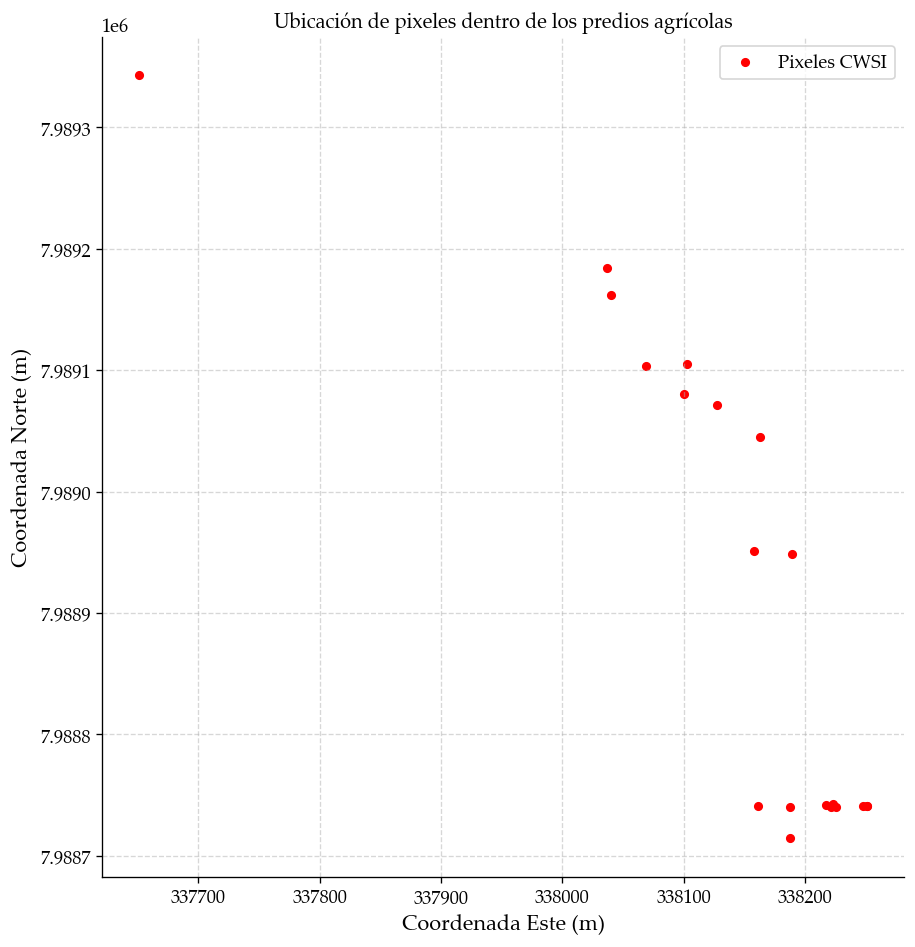

In [ ]:
# =========================
# CONFIG E IMPORTS
# =========================
import os
from glob import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# =========================
# 1) LEER PREDIOS
# =========================
predios = gpd.read_file(ruta)

if predios.crs is None:
    # ⚠️ IMPORTANTE: si tu shapefile no trae CRS, debes declararlo tú.
    # Para Ferreñafe (Lambayeque) suele ser UTM 17S -> EPSG:32717
    # Para Tacna es UTM 19S -> EPSG:32719
    raise ValueError(
        "El shapefile de predios no tiene CRS. Declara el correcto: "
        "predios = predios.set_crs(32717)  # Ferreñafe (UTM 17S) o 32719 para Tacna."
    )

# =========================
# 2) CONSTRUIR GEO-DF DE PÍXELES
# =========================
# Detectar si Longitud/Latitud están en grados o en metros:
lon_abs_max = pd.to_numeric(tabla_pixeles1["Longitud"], errors="coerce").abs().max()
lat_abs_max = pd.to_numeric(tabla_pixeles1["Latitud"],  errors="coerce").abs().max()
son_grados = (lon_abs_max <= 180) and (lat_abs_max <= 90)

# Crear geometría
gdf_stats = gpd.GeoDataFrame(
    tabla_pixeles1.copy(),
    geometry=tabla_pixeles1.apply(lambda r: Point(float(r["Longitud"]), float(r["Latitud"])), axis=1),
    crs=("EPSG:4326" if son_grados else predios.crs)  # si NO son grados, asumimos ya está en el mismo CRS de predios
)

# Si estaba en grados, reproyectar a CRS de predios (metros)
if son_grados and (gdf_stats.crs != predios.crs):
    gdf_stats = gdf_stats.to_crs(predios.crs)

# =========================
# 3) EXPORTAR POR FECHA (opcional)
# =========================
os.makedirs(ruta, exist_ok=True)

fechas = [
    "2021-11-26", "2021-12-04",
    "2022-03-02", "2022-03-18", "2022-04-03", 
    "2022-04-19", "2022-04-27", "2022-05-05"
]

for fecha in fechas:
    gdf_pix = gdf_stats.query("Fecha == @fecha")
    if gdf_pix.empty:
        continue
    fname = fecha.replace(" ", "_").replace(":", "-")
    gdf_pix.to_file(os.path.join(ruta, f"{fname}_pixeles.shp"), driver="ESRI Shapefile")

# =========================
# 4) PLOT ALINEADO
# =========================
# Asegura mismos CRS (por si predios venía en otro)
if gdf_stats.crs != predios.crs:
    gdf_stats = gdf_stats.to_crs(predios.crs)

fig, ax = plt.subplots(figsize=(8, 8))
predios.boundary.plot(ax=ax, color="green", linewidth=1, label="Predios agrícolas")
gdf_stats.plot(ax=ax, color="red", markersize=20, label="Pixeles CWSI")

ax.legend()
ax.set_title("Ubicación de pixeles dentro de los predios agrícolas", fontsize=12)
ax.set_xlabel("Coordenada Este (m)")
ax.set_ylabel("Coordenada Norte (m)")
ax.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Tabla 2: Tabla promedios + desv. std

In [27]:
# Tabla de rangos (2 decimales)
def rangos(index, variable):

    promedio = lista_imgprocesadas_ET[index]['stats'][variable]['mean']
    minimo = lista_imgprocesadas_ET[index]['stats'][variable]['min']
    maximo = lista_imgprocesadas_ET[index]['stats'][variable]['max']
    rangos_valores = f"{promedio:.2f} ({minimo:.2f} - {maximo:.2f})"
    return rangos_valores

lista_nombres = ['NDVI', 'LAI', 'Albedo', 'Rn (W m-2)', 'G (W m-2)', 'H (W m-2)', 'ETc (mm d-1)', 'ETc pos (mm d-1)']
lista_variables = ['NDVI', 'LAI', 'albedo', '0_Rn', '1_G', '2_H', 'ET', 'ET_pos']
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

# Armar cuadro estadístico x(min-max)
lista_resultados = []
for index in range(n_imgs):
    result_int = []
    for variable in lista_variables:
        valores = rangos(index, variable)
        result_int.append(valores)
    dict_result = {f"{lista_fechas[index]}": result_int}
    df = pd.DataFrame(data=dict_result, index=lista_nombres)
    lista_resultados.append(df)

# Unir dfs en uno solo
df_resultados = pd.concat(lista_resultados, axis=1) # df_resultados.T para transpuesta
# df_resultados.to_csv(os.path.join(carpeta_output, 'tabla_resumen.csv'))
df_resultados

11-Nov-2021               04-Dic-2021  \
NDVI                    0.29 (0.06 - 0.48)        0.28 (0.06 - 0.47)   
LAI                     0.70 (0.21 - 1.12)        0.69 (0.22 - 1.08)   
Albedo                  0.25 (0.20 - 0.33)        0.24 (0.19 - 0.32)   
Rn (W m-2)        551.86 (467.60 - 615.66)  585.61 (506.74 - 641.21)   
G (W m-2)         123.08 (111.52 - 135.14)   103.00 (92.36 - 113.29)   
H (W m-2)         378.55 (281.51 - 438.43)  395.56 (260.82 - 455.06)   
ETc (mm d-1)           1.79 (-1.22 - 7.67)       3.11 (-0.22 - 9.94)   
ETc pos (mm d-1)        1.85 (0.00 - 7.67)        3.12 (0.00 - 9.94)   

                               02-Mar-2022               18-Mar-2022  \
NDVI                    0.27 (0.06 - 0.45)        0.28 (0.06 - 0.44)   
LAI                     0.67 (0.22 - 1.04)        0.70 (0.22 - 1.04)   
Albedo                  0.22 (0.18 - 0.30)        0.23 (0.18 - 0.32)   
Rn (W m-2)        535.05 (462.05 - 585.22)  492.87 (423.07 - 551.12)   
G (W m-2)           95.93 (85.92 - 108.83)    97.29 (86.57 - 111.90)   
H (W m-2)         360.16 (246.95 - 422.79)  321.33 (174.56 - 406.96)   
ETc (mm d-1)           2.83 (-0.85 - 8.28)      2.67 (-1.81 - 10.04)   
ETc pos (mm d-1)        2.85 (0.00 - 8.28)       2.76 (0.00 - 10.04)   

                               03-Abr-2022               19-Abr-2022  \
NDVI                    0.28 (0.06 - 0.44)        0.29 (0.06 - 0.49)   
LAI                     0.69 (0.22 - 1.02)        0.72 (0.21 - 1.13)   
Albedo                  0.22 (0.17 - 0.32)        0.21 (0.16 - 0.31)   
Rn (W m-2)        469.81 (396.70 - 524.22)  442.50 (367.77 - 498.24)   
G (W m-2)           93.78 (81.97 - 110.92)    85.61 (73.72 - 104.10)   
H (W m-2)         300.11 (185.58 - 358.24)  301.23 (166.01 - 378.60)   
ETc (mm d-1)           2.72 (-0.79 - 8.65)       2.02 (-2.19 - 8.91)   
ETc pos (mm d-1)        2.75 (0.00 - 8.65)        2.23 (0.00 - 8.91)   

                               27-Abr-2022               05-May-2022  \
NDVI                    0.29 (0.05 - 0.45)        0.30 (0.06 - 0.47)   
LAI                     0.71 (0.20 - 1.06)        0.73 (0.22 - 1.09)   
Albedo                  0.21 (0.15 - 0.30)        0.21 (0.15 - 0.32)   
Rn (W m-2)        464.37 (382.44 - 525.72)  412.26 (333.13 - 473.71)   
G (W m-2)            59.97 (51.33 - 75.01)     75.85 (64.65 - 94.42)   
H (W m-2)         346.55 (254.98 - 398.30)  287.71 (167.64 - 352.09)   
ETc (mm d-1)           2.03 (-1.05 - 7.28)       1.76 (-2.05 - 8.14)   
ETc pos (mm d-1)        2.05 (0.00 - 7.28)        1.95 (0.00 - 8.14)   

                               08-Jul-2022               24-Jul-2022  
NDVI                    0.31 (0.05 - 0.48)        0.30 (0.06 - 0.49)  
LAI                     0.74 (0.20 - 1.12)        0.74 (0.22 - 1.13)  
Albedo                  0.19 (0.14 - 0.29)        0.19 (0.14 - 0.29)  
Rn (W m-2)        356.85 (278.91 - 413.50)  383.36 (302.84 - 444.81)  
G (W m-2)            57.86 (47.26 - 76.40)     59.45 (49.12 - 79.10)  
H (W m-2)         267.93 (227.71 - 302.10)  288.70 (228.42 - 326.17)  
ETc (mm d-1)           1.09 (-1.09 - 4.03)       1.24 (-1.24 - 5.02)  
ETc pos (mm d-1)        1.17 (0.00 - 4.03)        1.32 (0.00 - 5.02)

In [28]:
# Tabla de rangos (2 decimales)
def rangos(index, variable):

    promedio = lista_imgprocesadas_ET[index]['stats'][variable]['mean']
    minimo = lista_imgprocesadas_ET[index]['stats'][variable]['min']
    maximo = lista_imgprocesadas_ET[index]['stats'][variable]['max']
    rangos_valores = f"{promedio:.2f} ({minimo:.2f} - {maximo:.2f})"
    return rangos_valores

lista_nombres = ['NDVI', 'LAI', 'Albedo', 'Rn (W m-2)', 'G (W m-2)', 'H (W m-2)', 'ETc (mm d-1)', 'ETc pos (mm d-1)']
lista_variables = ['NDVI', 'LAI', 'albedo', '0_Rn', '1_G', '2_H', 'ET', 'ET_pos']
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May', '14-Jun']

# Armar cuadro estadístico x(min-max)
lista_resultados = []
for index in range(n_imgs):
    result_int = []
    for variable in lista_variables:
        valores = rangos(index, variable)
        result_int.append(valores)
    dict_result = {f"{lista_fechas[index]}": result_int}
    df = pd.DataFrame(data=dict_result, index=lista_nombres)
    lista_resultados.append(df)

# Unir dfs en uno solo
df_resultados = pd.concat(lista_resultados, axis=1) # df_resultados.T para transpuesta
df_resultados.to_csv(os.path.join(carpeta_output, 'tabla_resumen.csv'))
df_resultados

11-Nov-2021               04-Dic-2021  \
NDVI                    0.29 (0.06 - 0.48)        0.28 (0.06 - 0.47)   
LAI                     0.70 (0.21 - 1.12)        0.69 (0.22 - 1.08)   
Albedo                  0.25 (0.20 - 0.33)        0.24 (0.19 - 0.32)   
Rn (W m-2)        551.86 (467.60 - 615.66)  585.61 (506.74 - 641.21)   
G (W m-2)         123.08 (111.52 - 135.14)   103.00 (92.36 - 113.29)   
H (W m-2)         378.55 (281.51 - 438.43)  395.56 (260.82 - 455.06)   
ETc (mm d-1)           1.79 (-1.22 - 7.67)       3.11 (-0.22 - 9.94)   
ETc pos (mm d-1)        1.85 (0.00 - 7.67)        3.12 (0.00 - 9.94)   

                               02-Mar-2022               18-Mar-2022  \
NDVI                    0.27 (0.06 - 0.45)        0.28 (0.06 - 0.44)   
LAI                     0.67 (0.22 - 1.04)        0.70 (0.22 - 1.04)   
Albedo                  0.22 (0.18 - 0.30)        0.23 (0.18 - 0.32)   
Rn (W m-2)        535.05 (462.05 - 585.22)  492.87 (423.07 - 551.12)   
G (W m-2)           95.93 (85.92 - 108.83)    97.29 (86.57 - 111.90)   
H (W m-2)         360.16 (246.95 - 422.79)  321.33 (174.56 - 406.96)   
ETc (mm d-1)           2.83 (-0.85 - 8.28)      2.67 (-1.81 - 10.04)   
ETc pos (mm d-1)        2.85 (0.00 - 8.28)       2.76 (0.00 - 10.04)   

                               03-Abr-2022               19-Abr-2022  \
NDVI                    0.28 (0.06 - 0.44)        0.29 (0.06 - 0.49)   
LAI                     0.69 (0.22 - 1.02)        0.72 (0.21 - 1.13)   
Albedo                  0.22 (0.17 - 0.32)        0.21 (0.16 - 0.31)   
Rn (W m-2)        469.81 (396.70 - 524.22)  442.50 (367.77 - 498.24)   
G (W m-2)           93.78 (81.97 - 110.92)    85.61 (73.72 - 104.10)   
H (W m-2)         300.11 (185.58 - 358.24)  301.23 (166.01 - 378.60)   
ETc (mm d-1)           2.72 (-0.79 - 8.65)       2.02 (-2.19 - 8.91)   
ETc pos (mm d-1)        2.75 (0.00 - 8.65)        2.23 (0.00 - 8.91)   

                               27-Abr-2022               05-May-2022  \
NDVI                    0.29 (0.05 - 0.45)        0.30 (0.06 - 0.47)   
LAI                     0.71 (0.20 - 1.06)        0.73 (0.22 - 1.09)   
Albedo                  0.21 (0.15 - 0.30)        0.21 (0.15 - 0.32)   
Rn (W m-2)        464.37 (382.44 - 525.72)  412.26 (333.13 - 473.71)   
G (W m-2)            59.97 (51.33 - 75.01)     75.85 (64.65 - 94.42)   
H (W m-2)         346.55 (254.98 - 398.30)  287.71 (167.64 - 352.09)   
ETc (mm d-1)           2.03 (-1.05 - 7.28)       1.76 (-2.05 - 8.14)   
ETc pos (mm d-1)        2.05 (0.00 - 7.28)        1.95 (0.00 - 8.14)   

                               08-Jul-2022               24-Jul-2022  
NDVI                    0.31 (0.05 - 0.48)        0.30 (0.06 - 0.49)  
LAI                     0.74 (0.20 - 1.12)        0.74 (0.22 - 1.13)  
Albedo                  0.19 (0.14 - 0.29)        0.19 (0.14 - 0.29)  
Rn (W m-2)        356.85 (278.91 - 413.50)  383.36 (302.84 - 444.81)  
G (W m-2)            57.86 (47.26 - 76.40)     59.45 (49.12 - 79.10)  
H (W m-2)         267.93 (227.71 - 302.10)  288.70 (228.42 - 326.17)  
ETc (mm d-1)           1.09 (-1.09 - 4.03)       1.24 (-1.24 - 5.02)  
ETc pos (mm d-1)        1.17 (0.00 - 4.03)        1.32 (0.00 - 5.02)

## 2.3. Revisión de productos

In [115]:
pprint(lista_imgprocesadas)

[{'d2': <ee.ee_number.Number object at 0x0000021ED0C6DCC0>,
  'doy': <ee.ee_number.Number object at 0x0000021ECEE0DB00>,
  'fecha': '2021-11-26',
  'img_CompBalance': <ee.image.Image object at 0x0000021ECF1C27B0>,
  'img_ETinst': <ee.image.Image object at 0x0000021ECF1A34D0>,
  'img_Rn': <ee.image.Image object at 0x0000021ECF2383B0>,
  'img_SR': <ee.image.Image object at 0x0000021ED0CC7590>,
  'img_productos': <ee.image.Image object at 0x0000021ECF238A70>,
  'img_toa': <ee.image.Image object at 0x0000021ED05A30B0>,
  'pix_c':     iter        Ts_k      Ts_dem   Z_om     u_200        u*       r_ah  \
0      1  316.120403  316.416153  0.005  5.402196  0.209019  34.956900   
1      2  316.120403  316.416153  0.005       NaN  0.354310   9.903595   
2      3  316.120403  316.416153  0.005       NaN  0.295362  18.233260   
3      4  316.120403  316.416153  0.005       NaN  0.314181  15.024358   
4      5  316.120403  316.416153  0.005       NaN  0.307418  16.118435   
5      6  316.120403  31

In [54]:
# Visualizar imágenes

# 0 '2022-01-13'
# 1 '2022-01-29'
# 2 '2022-03-10'
# 3 '2022-04-03'
# 4 '2022-05-05'
# 5 '2022-05-21'
# 6 '2022-06-14'

n_img = 0

# Mapas a visualizar
img_temp = lista_imgprocesadas[n_img]['img_productos'].select('Ts_c')
img_rgb = lista_imgprocesadas[n_img]['img_toa'].clip(predios_bound)
fecha = lista_imgprocesadas[n_img]['fecha']
img_albedo = lista_imgprocesadas[n_img]['img_productos'].select('albedo')
img_lai = lista_imgprocesadas[n_img]['img_productos'].select('LAI')

print(fecha)

img_H = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('2_H')
img_Rn = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('0_Rn')
img_le = lista_imgprocesadas_ET[n_img]['img_CompBalance'].select('3_LE_vis')

img_ndvi = lista_imgprocesadas[n_img]['img_productos'].select('NDVI')

# Seleccionar imagen ET
img_ET = lista_imgprocesadas_ET[n_img]['img_ETinst']
img_ETpos = img_ET.updateMask(img_ET.gte(0))
img_ETnega = img_ET.updateMask(img_ET.lt(0))

img_albedo_rangos = img_albedo.updateMask(img_albedo.gte(0.17))

# Parámetros de visualización
paleta_ET = ["F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"]

vis_params_ndvi = {'min': 0,#lista_imgprocesadas_ET[n_img]['stats']['NDVI']['min'],
                   'max': 1,#lista_imgprocesadas_ET[n_img]['stats']['NDVI']['max'],
                   'palette': ndvi_cmap}

vis_params_lai = {
    'min': 0,
    'max': 2,
    'palette': ndvi_cmap#cmp.get_palette('gray')
}
vis_params_alb = {
    'min': 0,
    'max': 0.25,
    'palette': ndvi_cmap#cmp.get_palette('gray')
}
vis_params_alb_rangos = {
    'min': 0.17,
    'max': 0.25,
    'palette': ndvi_cmap #cmp.get_palette('gray')
}

vis_paramsp = {'min': 0,
               'max': 10,
               # 'max': int(max_et),
               'palette': paleta_ET} #cmp.get_palette('Grays')}

vis_paramset = {'min': 0,
               'max': 10,
               # 'max': int(max_et),
               'palette': paleta_ET} #cmp.get_palette('Grays')}

vis_paramsn = {'min': lista_imgprocesadas_ET[n_img]['stats']['ET']['min'],
               'max': 0,
               'palette': cmp.get_palette('Reds_r')}

vis_paramst = {'min': lista_imgprocesadas_ET[n_img]['stats']['Ts_c']['min'],
               'max': lista_imgprocesadas_ET[n_img]['stats']['Ts_c']['max'],
               'palette': cmp.get_palette('RdYlBu_r')}  # YlGnBu

vis_params_le = {'min': lista_imgprocesadas_ET[n_img]['stats']['3_LE_vis']['min'],
                 'max': lista_imgprocesadas_ET[n_img]['stats']['3_LE_vis']['max'],
                 'palette': ndvi_cmap}#cmp.get_palette('RdYlBu_r')}  # YlGnBu

vis_params_H = {'min': lista_imgprocesadas_ET[n_img]['stats']['2_H']['min'],
                'max': lista_imgprocesadas_ET[n_img]['stats']['2_H']['max'],
                'palette': cmp.get_palette('Grays')}

display(lista_imgprocesadas_ET[n_img]['stats'])

# Mapas
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')

Map.addLayer(img_ndvi, vis_params_ndvi, 'img_ndvi')
Map.addLayer(img_albedo, vis_params_alb, 'albedo')
Map.addLayer(img_lai, vis_params_lai, 'lai')

Map.addLayer(img_ET, vis_paramset, 'img_ET')
Map.addLayer(img_ETpos, vis_paramsp, 'img_ETpos')
Map.addLayer(img_ETnega, vis_paramsn, 'img_ETnega')

Map.addLayer(img_H, vis_params_H, 'img_H')
Map.addLayer(img_le, vis_params_le, 'img_le')
Map.addLayer(img_temp, vis_paramst, 'img_temp')

# Map.addLayer(img_albedo_rangos, vis_params_alb_rangos, 'albedo_gt17')

# Prueba: Selección de pixeles
# Map.addLayer(ee.Geometry.Point(list_coords_pixf1[n_img]), {}, 'Pixel F anterior')
# Map.addLayer(ee.Geometry.Point(list_coords_pixf[n_img]), {}, 'Pixel F')
# Map.addLayer(ee.Geometry.Point(list_coords_pixc1[n_img]), {}, 'Pixel C anterior')
# Map.addLayer(ee.Geometry.Point(list_coords_pixc[n_img]), {}, 'Pixel C')

# Map.addLayer(ee.Geometry.Point(), {}, 'Pixel C final')

Map.add_colorbar(vis_paramset, orientation='horizontal') #, label='ET')
Map

2021-11-26


Ts_c      NDVI       LAI    albedo        0_Rn         1_G  \
max     42.970403  0.484205  1.121259  0.334519  615.660300  135.135039   
mean    40.279763  0.287669  0.701419  0.247087  551.858498  123.084852   
median  40.312308  0.334747  0.801301  0.242581  554.426038  123.085715   
min     36.810936  0.059862  0.214777  0.197702  467.595988  111.516827   
mode    39.982604  0.367899  0.872807  0.242581  563.487399  124.436382   
stdDev   1.241444  0.110722  0.236525  0.023271   25.600750    4.522443   

               2_H        3_LE    3_LE_vis        ET    ET_pos  
max     438.427165  214.393254  214.393254  7.672995  7.672995  
mean    378.545492   49.816153   51.668522  1.786979  1.853596  
median  382.331084   43.352142   43.352142  1.531880  1.545278  
min     281.514988  -34.019594    0.000000 -1.223147  0.000000  
mode    378.469296   18.676319    0.022312  0.665471  0.000802  
stdDev   29.971875   48.904373   46.593367  1.752377  1.669131

Map(center=[-18.18141181765202, -70.53212395232164], controls=(WidgetControl(options=['position', 'transparent…

In [82]:
Map = geemap.Map()
Map.centerObject(predios_agricolas, 16)
Map.addLayer(img_rgb, vis_rgb, 'img_rgb')
Map.addLayer(img_H, vis_params_H, 'img_H')
Map.addLayer(img_ETnega, vis_paramsn, 'img_ETnega')
Map

Map(center=[-18.181625165280263, -70.53173820767091], controls=(WidgetControl(options=['position', 'transparen…

In [83]:
Map.user_rois.geometry().coordinates().getInfo()

[]

#### LAI

In [ ]:
ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03'] # -0.2 - 1  '0048fb',

lai_paleta = ['ffffff', 'ce7e45', 'df923d', 'f1b555', 'fcd163', '99b718', '74a901',
    '66a000', '529400', '3e8601', '207401', '056201', '004c00', '023b01',
    '012e01', '011d01', '011301']

ts_cmap = ['fefccc', 'fbd976', 'f08c39', 'ea4a33', 'e43d32', '812026']

albedo_cmap = ['68181f', 'd6604d', 'f9dbc7', 'd1e5f0', '2166ac', '053061'] # 0 - 0.5

In [ ]:
import math
import os

import ee

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from geemap import cartoee

In [58]:
def get_grafica_cartoee_color(image, 
                              vis_params,                              
                              text=None, 
                              title_map=None,
                              label=None, 
                              save_fig=None,
                              nogrid=None):
    
    """Obtener gráficas con cartoee
    La variable zoom_region debe asignarse según la zona de estudio.
    Para modificaciones seguir: https://geemap.org/cartoee/#cartoee-module
    """

    # Establecer área de plot usando las coordenadas de predios_bound.coordinates().getInfo()
    extent = 0.0004
    zoom_region = [
        -70.53539711730724 - extent,   # west  - extent
        -18.185505011017327 - extent,  # south - extent
        -70.52796183246036 + extent,   # east  + extent
        -18.177618129602468 + extent   # north + extent
    ]
    
    # Establecer figsize para plot
    # fig = plt.figure(figsize=(5,5)) # Para juntar en forma de mosaicos
    fig = plt.figure(figsize=(8,6)) # Para analizar
    # fig = plt.figure(figsize=(16,12)) # Para recortar la barra
    
    # ee.Image a plotear
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # Añadir grillas
    if nogrid is None:
        cartoee.add_gridlines(ax, 
                              interval=0.005, 
                              ytick_rotation=90, 
                              linestyle=":", 
                              linewidth=0 # Grillas invisibles
                              ) # xtick_rotation=45

    # Añadir barra de color
    if label is not None:
        cartoee.add_colorbar(ax, 
                             vis_params=vis_params, 
                             loc='right', 
                             # label=label, 
                             posOpts=[0.785, 0.22, 0.02, 0.5],
                             tick_font_size=12
                             # ticks=[15, 20, 25, 30, 35], # LAI
                             # drawedges=True, 
                             # extend='both', # Genera flechas hacia los extremos
                             )
        ax.text(-70.5369+2*extent, -18.1786, label, fontsize=12)

    # Añadir texto
    if title_map is not None:
        ax.set_title(title_map) # , fontsize=11
        
    if text is not None:
        ax.text(-70.5339, -18.177618129602464, text, fontsize=12) 
        # fontsize=18 para mejor visibilidad en mosaicos
        
    # add scale bar
    scale_bar_dict = {
          "length": 100, 
          "xy": (0.9, 0.05), 
          "linewidth": 2,
          "fontsize": 12,
          "color": "black",
          "unit": "m",
          "ha": "center",
          "va": "bottom",    
    }
    cartoee.add_scale_bar_lite(ax, **scale_bar_dict)
    
    ax.tick_params(axis = 'both') # , labelsize = 9
    
    # Guardar graficas
    if save_fig is not None:

        ruta = r'C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Resultados'
        ruta_img = os.path.join(ruta, f'{save_fig}.png')
        plt.savefig(ruta_img, bbox_inches = 'tight', pad_inches = .1)#, dpi=400)
        # Recortar márgenes con ayuda de bbox_inches y pad_inches

    plt.show()

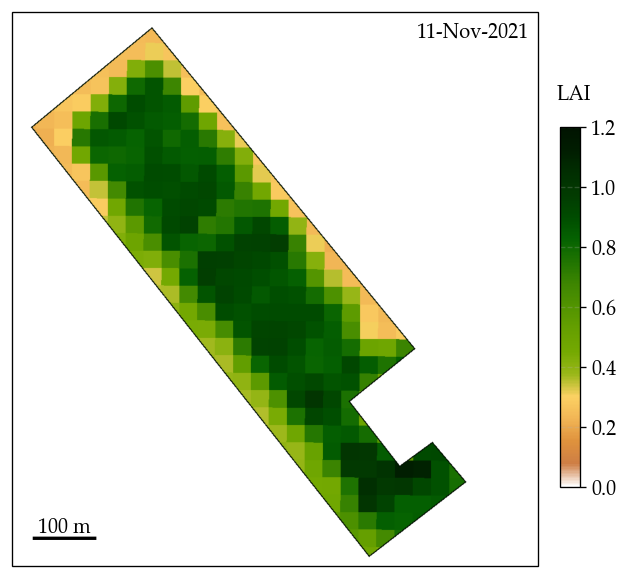

In [59]:
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
vis_params_lai = {'min': 0, 'max': 1.2,  'palette': lai_paleta}
index = 0

img_productos = lista_imgprocesadas[index]['img_productos']
img = img_productos.select(lista_variables[1])

get_grafica_cartoee_color(img.blend(predios_vis),
                          vis_params_lai,
                          text=lista_fechas[index],
                          title_map=None,
                          label= 'LAI', #'ETc ($mm\;d^{-1}$)',
                          save_fig=f"LAI_{lista_fechas[index].replace('-', '')}",  # -> PNG 600 dpi en la carpeta
                          nogrid=True)

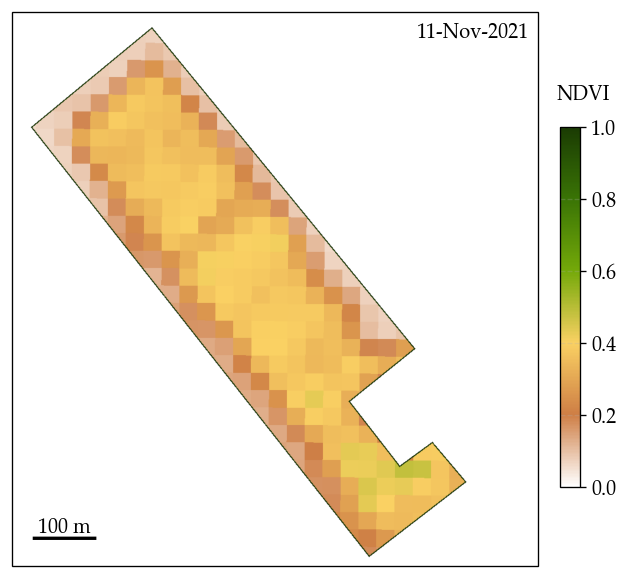

In [60]:
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
vis_params_lai = {'min': 0, 'max': 1,  'palette': ndvi_cmap}
index = 0

img_productos = lista_imgprocesadas[index]['img_productos']
img = img_productos.select(lista_variables[0])

get_grafica_cartoee_color(img.blend(predios_vis),
                          vis_params_lai,
                          text=lista_fechas[index],
                          title_map=None,
                          label= 'NDVI', #'ETc ($mm\;d^{-1}$)',
                          save_fig=f"NDVI_{lista_fechas[index].replace('-', '')}",  # -> PNG 600 dpi en la carpeta
                          nogrid=True)

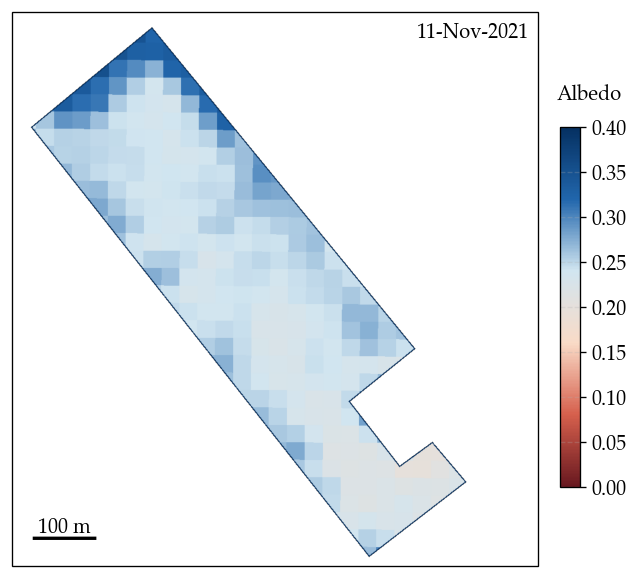

In [61]:
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
vis_params_lai = {'min': 0, 'max': 0.4,  'palette': albedo_cmap}
index = 0

img_productos = lista_imgprocesadas[index]['img_productos']
img = img_productos.select(lista_variables[2])

get_grafica_cartoee_color(img.blend(predios_vis),
                          vis_params_lai,
                          text=lista_fechas[index],
                          title_map=None,
                          label= 'Albedo', #'ETc ($mm\;d^{-1}$)',
                          save_fig=f"Albedo_{lista_fechas[index].replace('-', '')}",  # -> PNG 600 dpi en la carpeta
                          nogrid=True)

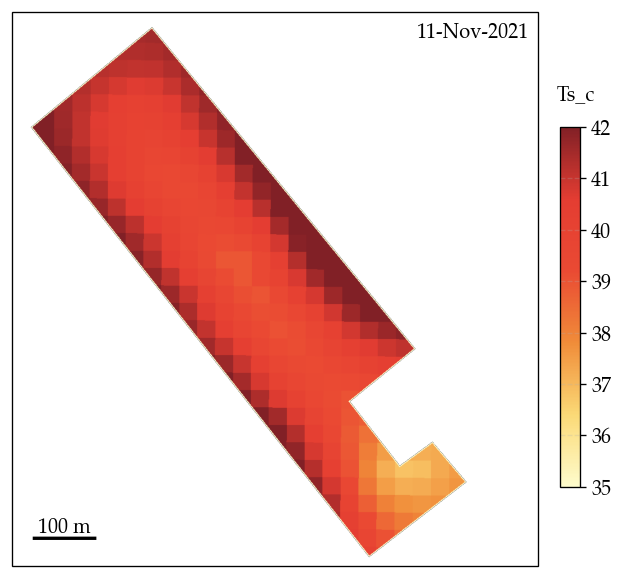

In [62]:
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
vis_params_lai = {'min': 35, 'max': 42,  'palette': ts_cmap}
index = 0

img_productos = lista_imgprocesadas[index]['img_productos']
img = img_productos.select(lista_variables[3])

get_grafica_cartoee_color(img.blend(predios_vis),
                          vis_params_lai,
                          text=lista_fechas[index],
                          title_map=None,
                          label= 'Ts_c', #'ETc ($mm\;d^{-1}$)',
                          save_fig=f"Ts_c_{lista_fechas[index].replace('-', '')}",  # -> PNG 600 dpi en la carpeta
                          nogrid=True)

# 3. Gráficas

In [29]:
from geemap import cartoee        # Elaboración de gráficas
import cartopy.crs as ccrs        # Importar sistema de coordenadas para gráficas

In [152]:
lista_fechas

['11-Nov-2021',
 '04-Dic-2021',
 '02-Mar-2022',
 '18-Mar-2022',
 '03-Abr-2022',
 '19-Abr-2022',
 '27-Abr-2022',
 '05-May-2022',
 '08-Jul-2022',
 '24-Jul-2022']

✅ Exported: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics\Mosaic_LAI.png


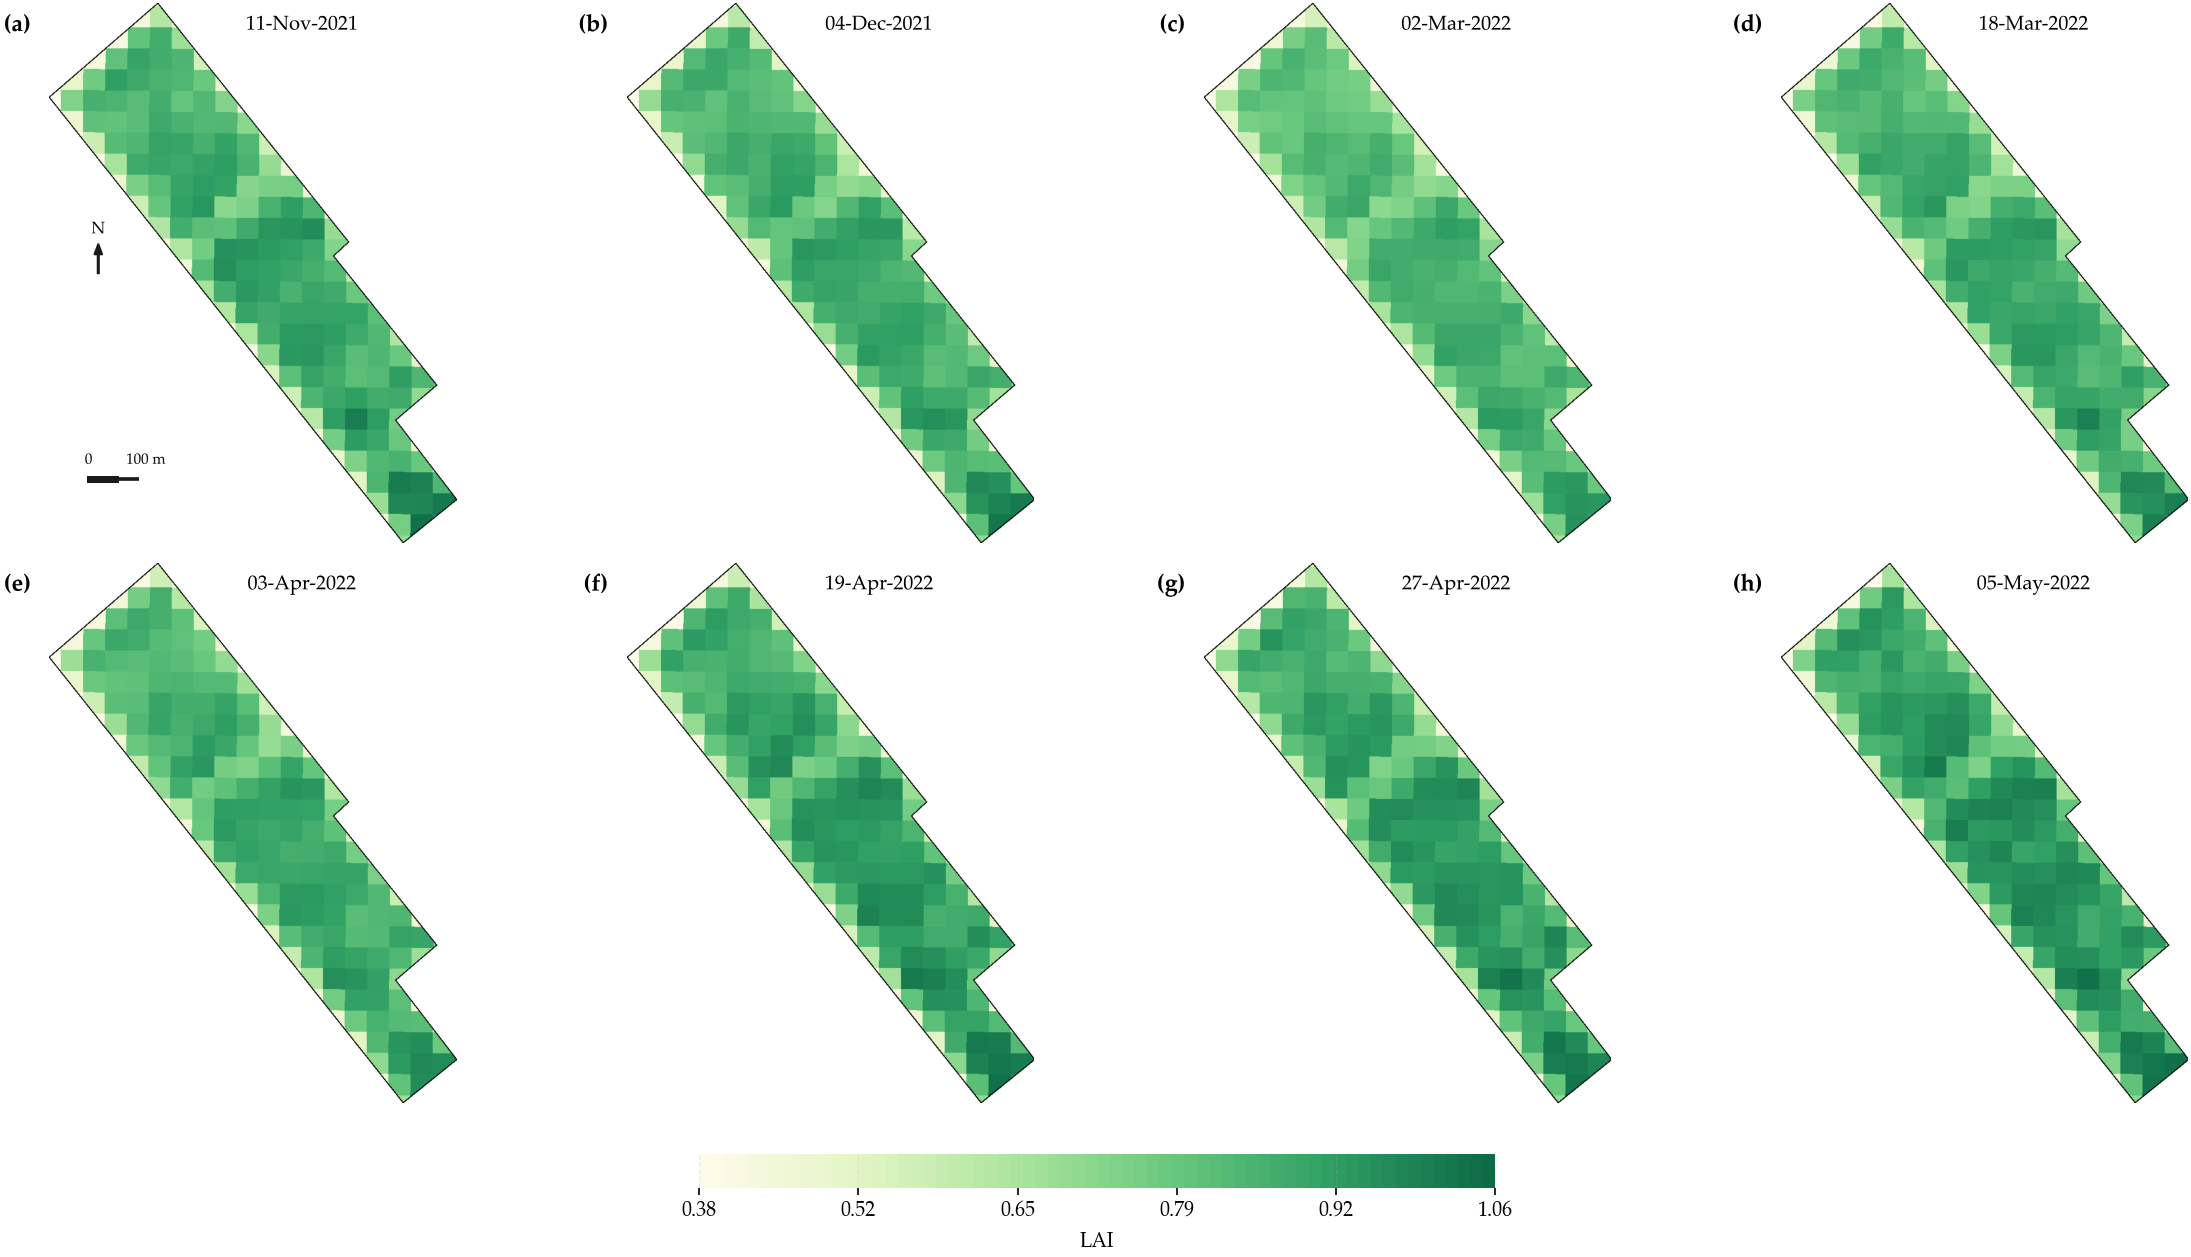

✅ Exported: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics\Mosaic_NDVI.png


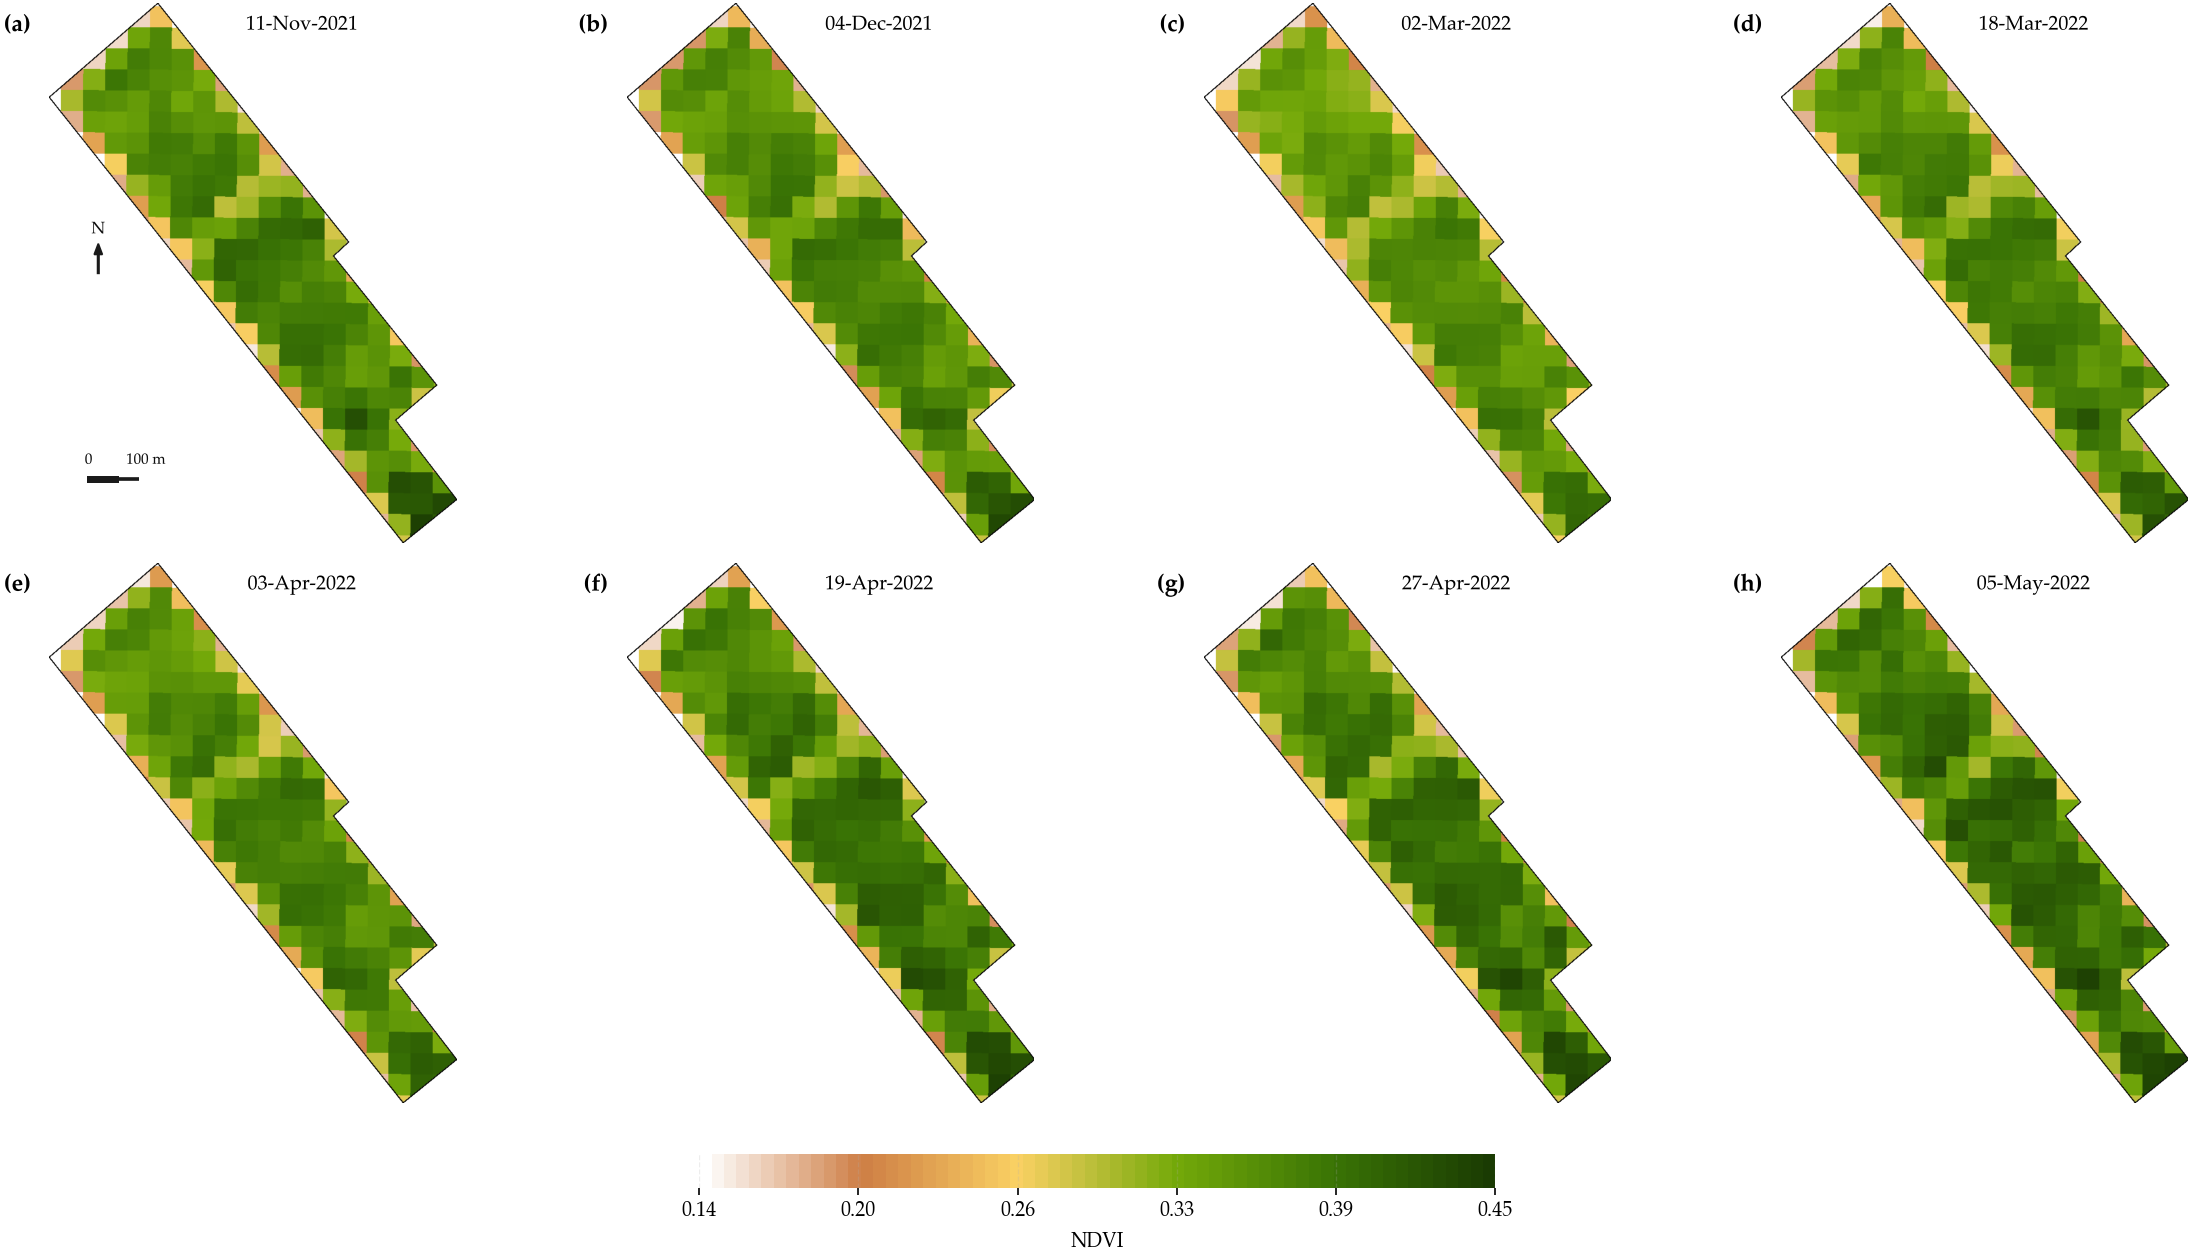

✅ Exported: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics\Mosaic_Ts.png


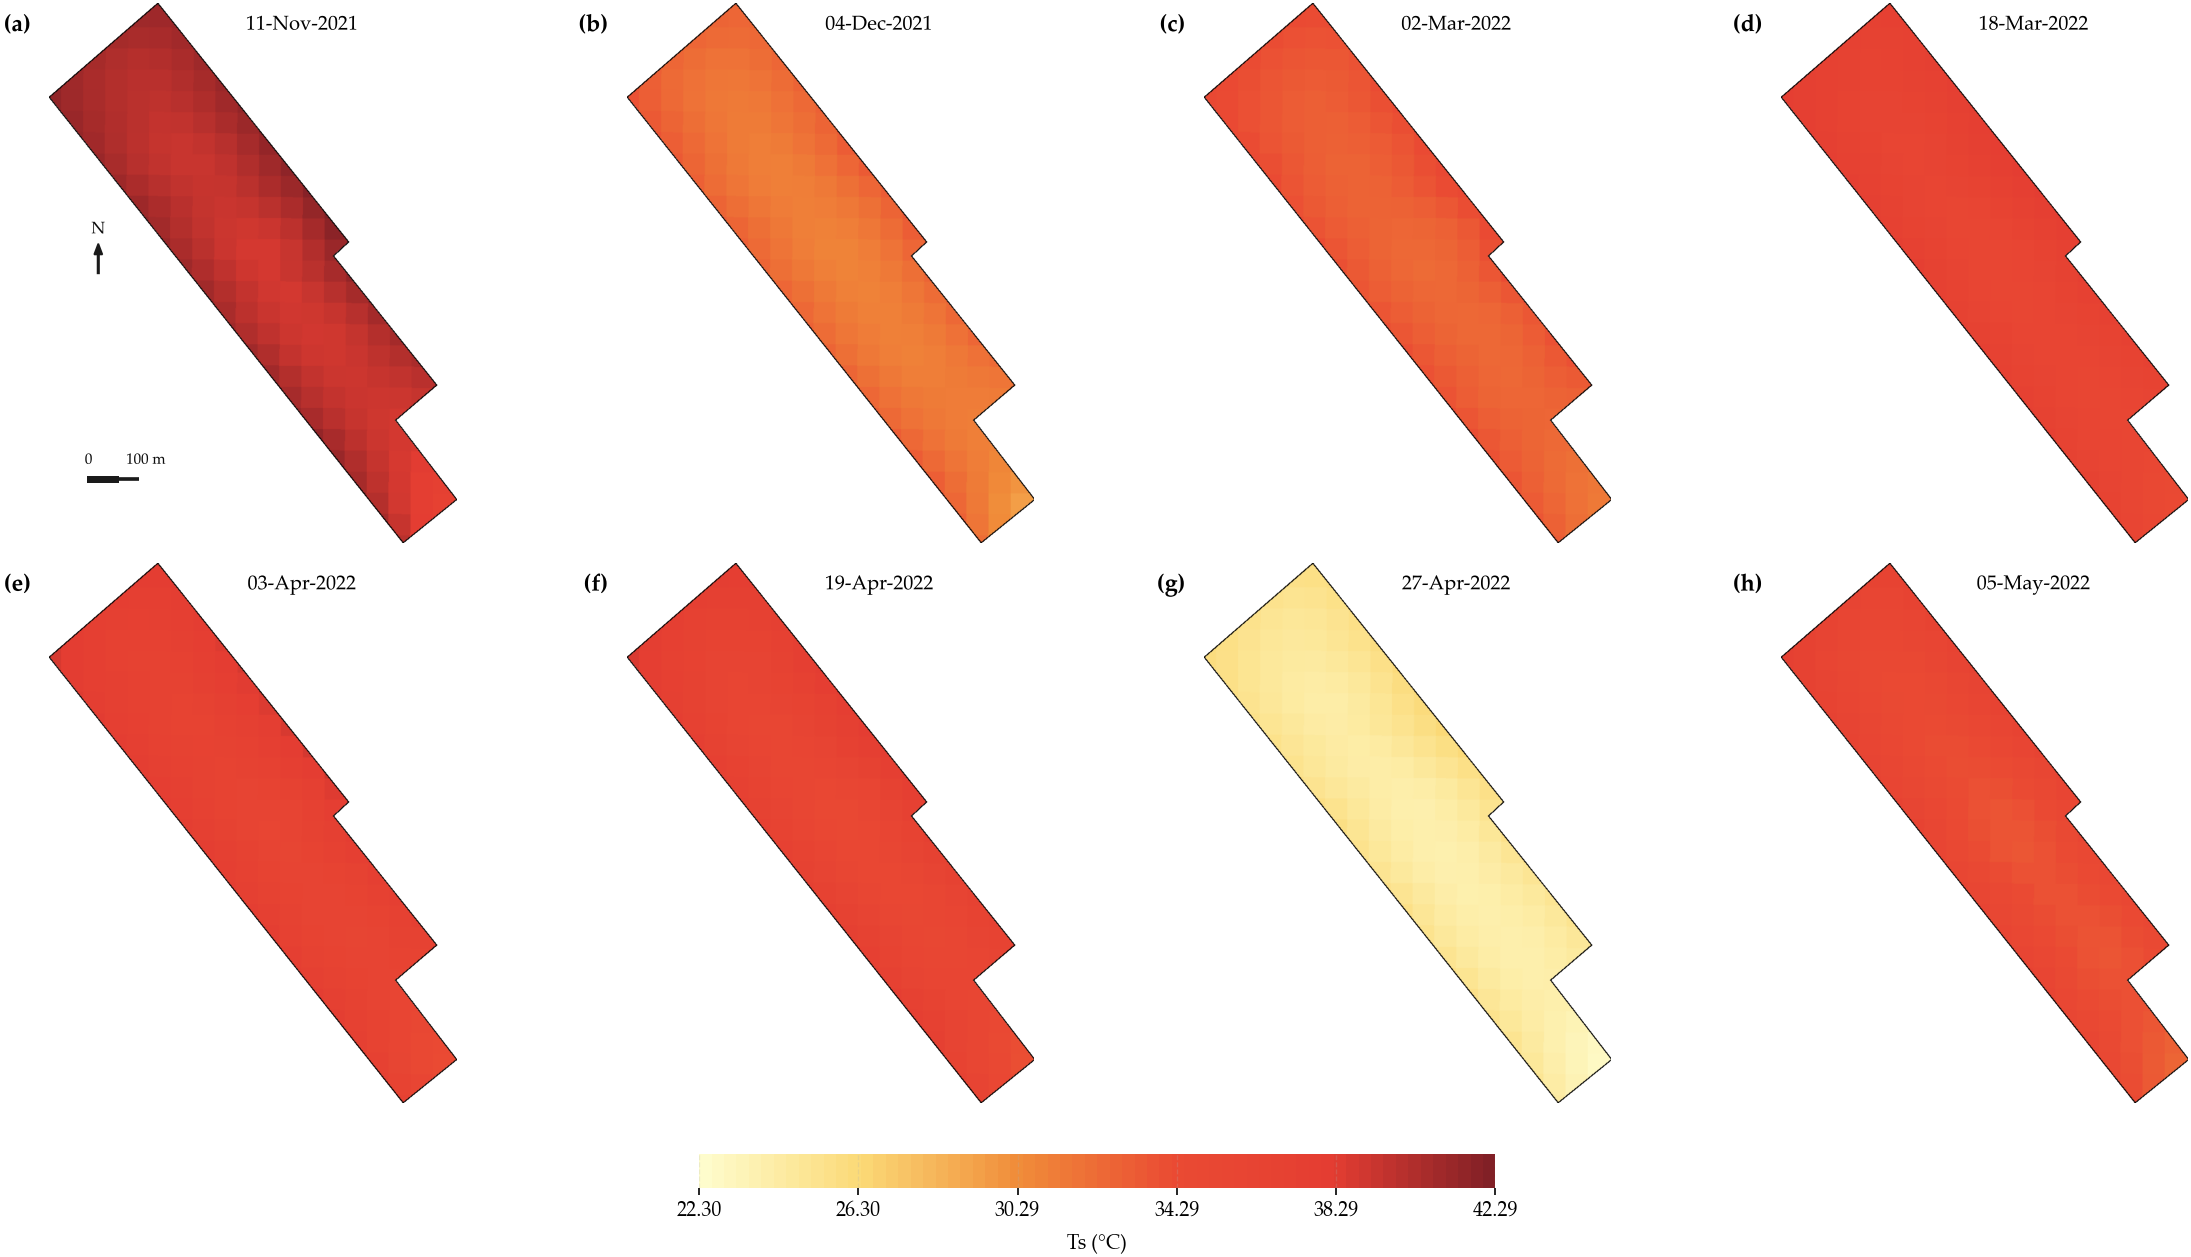

✅ Exported: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics\Mosaic_Albedo.png


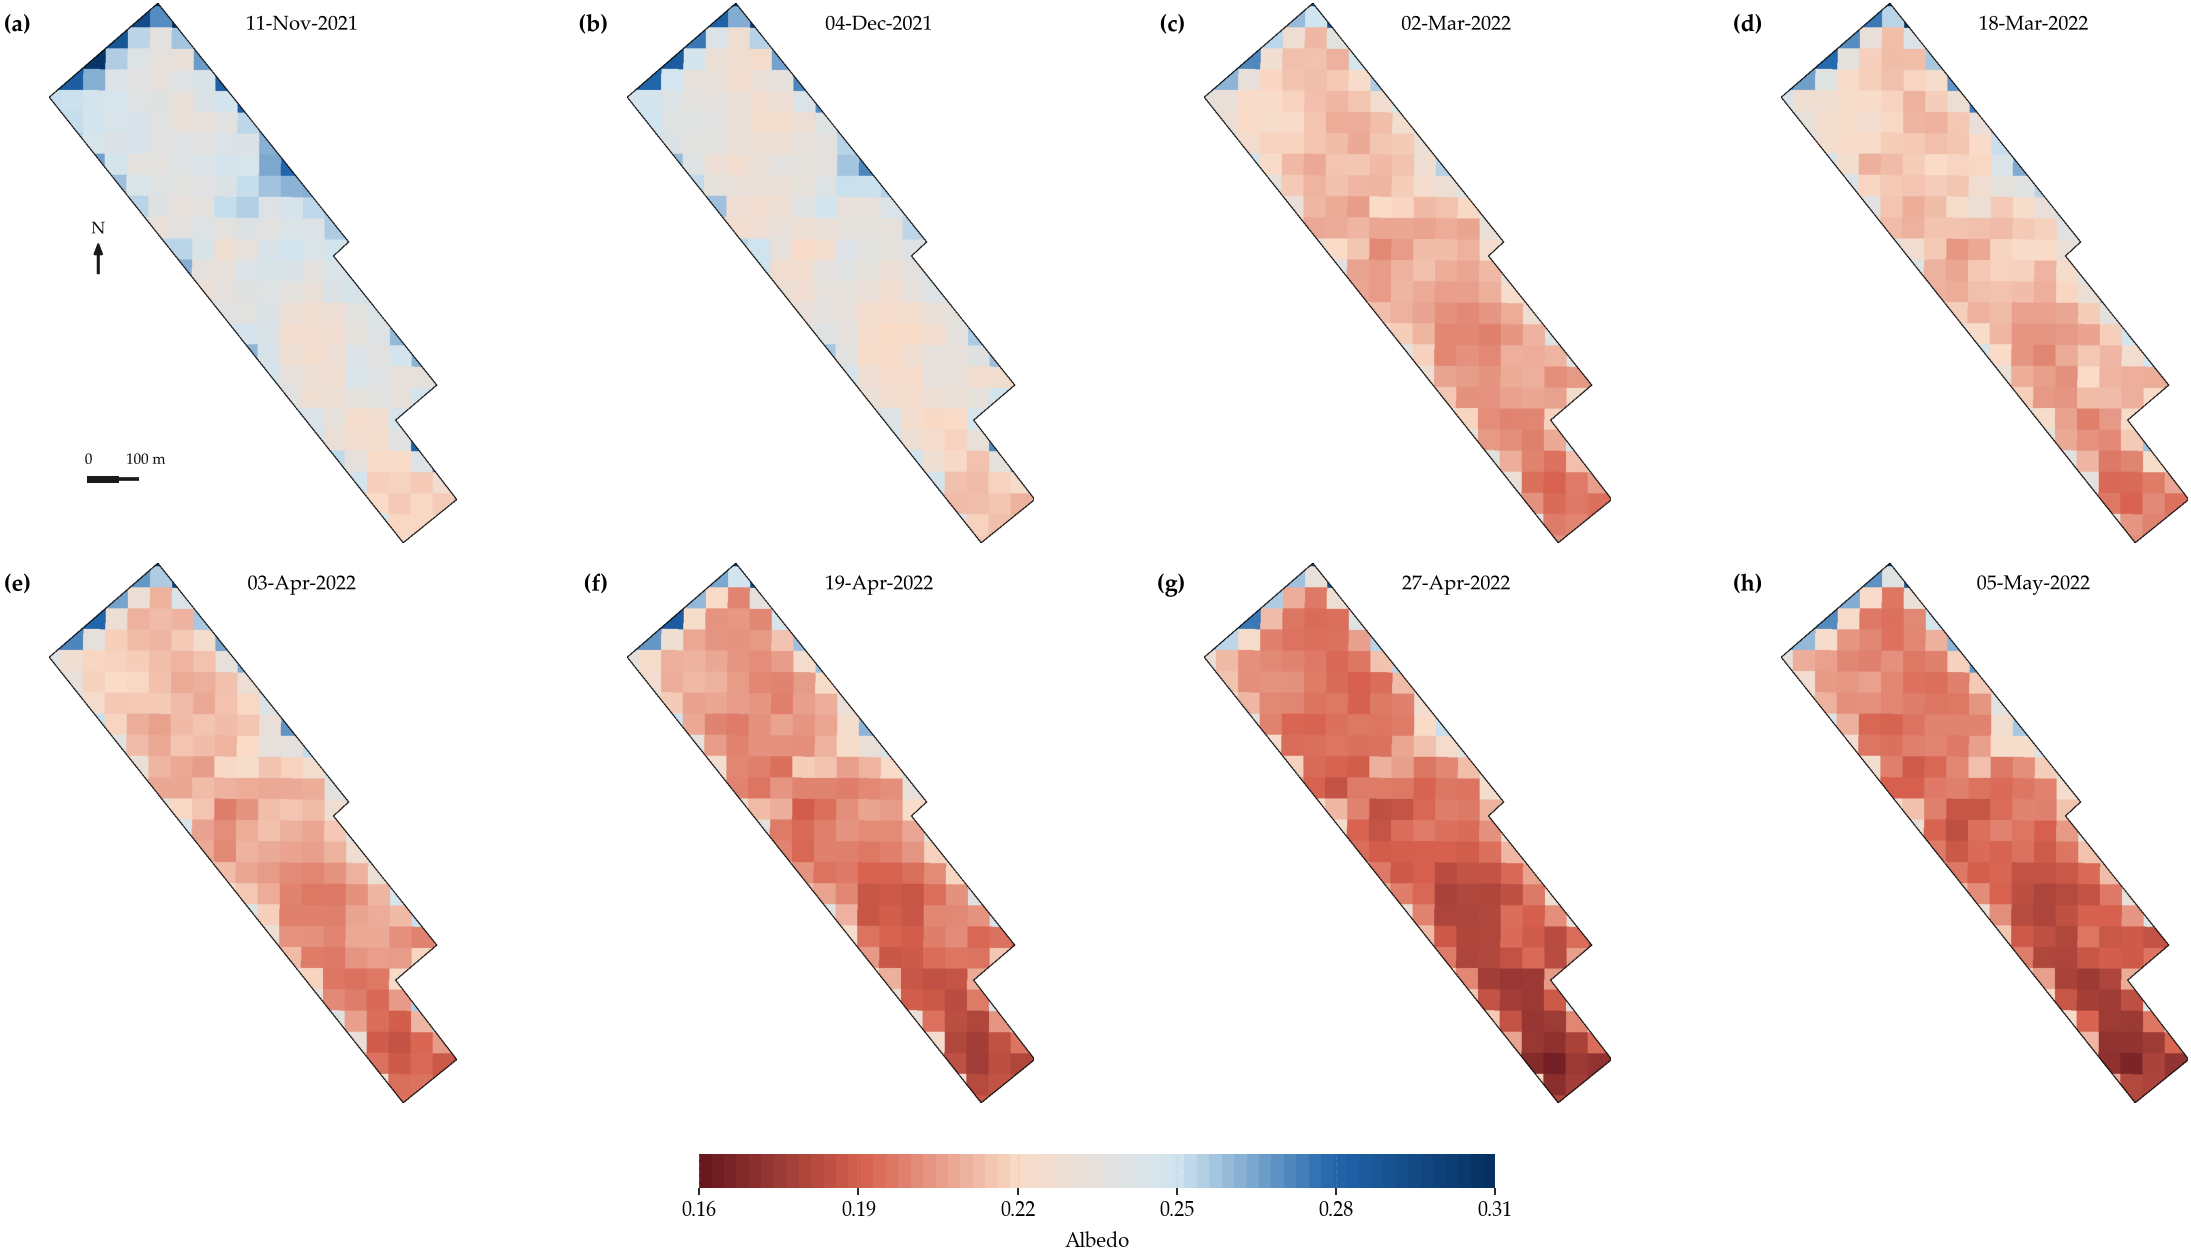

In [38]:
# -*- coding: utf-8 -*-
"""
Time-series mosaics (LAI, NDVI, Ts, Albedo) — ROI 'Olive' clipped + outline
- Same aesthetics as your ETc mosaic (dates top-left/right, (a–h), north+scale in (a)).
- Thin horizontal colorbar on an EXTRA bottom row (centered between cols 2 and 3).
- Global dynamic range per variable computed INSIDE the ROI (reduceRegion) with 2% padding.
- Only the ROI is rendered (clip); outside is transparent.
- ROI outline drawn on top (configurable color/width/opacity).
- English labels + dates (even if input dates are Spanish).
- Exports PNG at 600 dpi.

Preferred ROI: ee.FeatureCollection("projects/ee-joluhumu/assets/Olive")
Fallback    : local Shapefile "C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Parcelas/Olive.shp"
"""

# ===================== IMPORTS & INIT =====================
import os, math, re
import ee, geemap
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geemap import cartoee
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
from matplotlib.patheffects import withStroke
import string
from datetime import datetime

# Earth Engine
try:
    geemap.ee_initialize()
except Exception:
    ee.Initialize()

# ===================== GLOBAL STYLE =====================
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype", "Book Antiqua", "Palatino", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "dejavuserif",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ===================== USER PATHS / ROI =====================
ROI_ASSET = "projects/ee-joluhumu/assets/Olive"
SHP_PATH  = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"

# ===================== DATE LABEL CONTROLS (adjust here) =====================
DATE_FMT     = "%d-%b-%Y"     # English output, e.g., 11-Jan-2024
DATE_FONTSZ  = 12
DATE_MODE    = "axes"         # "axes" -> relative axes coords (easy to reposition), "geo" -> lat/lon
DATE_POS_AX  = (0.62, 0.98)   # if DATE_MODE=="axes": (x,y) in [0..1]; try (0.70,0.98), (0.60,0.96), etc.
DATE_HALIGN  = "center"       # 'left' | 'center' | 'right'
DATE_VALIGN  = "top"          # 'top' | 'center' | 'bottom'

# If DATE_MODE=="geo", these are used (computed from ROI bbox by default; you can override):
DATE_OFFSET_X = 0.02          # fraction of bbox width from left
DATE_OFFSET_Y = 0.02          # fraction of bbox height from top

# ===================== ROI OUTLINE PARAMETERS =====================
ROI_BORDER_COLOR   = "000000"  # black (hex without '#')
ROI_BORDER_WIDTH   = 2         # pixels (try 1.5, 2, 3, 4)
ROI_BORDER_OPACITY = 1.0       # 0..1  (e.g., 0.6 for subtle)

# ===================== BUILD ROI + BBOX =====================
def get_roi_geometry_and_bbox():
    """Load ROI as ee.FeatureCollection -> geometry + bbox [xmin,ymin,xmax,ymax]."""
    roi_fc = None
    try:
        roi_fc = ee.FeatureCollection(ROI_ASSET)
        _ = roi_fc.limit(1).getInfo()
    except Exception:
        roi_fc = None
    if roi_fc is None:
        roi_fc = geemap.shp_to_ee(SHP_PATH)

    roi_geom = roi_fc.geometry()
    bounds = roi_geom.bounds(1).coordinates().get(0).getInfo()
    xs = [p[0] for p in bounds]; ys = [p[1] for p in bounds]
    bbox = [min(xs), min(ys), max(xs), max(ys)]
    return roi_geom, bbox

roi_geom, zoom_region = get_roi_geometry_and_bbox()
scale_m = 30  # Landsat

# ===================== HELPERS =====================
def _fix_hex_list(ls):
    out = []
    for c in ls:
        c = c.strip()
        if not c.startswith('#'):
            c = '#' + c
        out.append(c)
    return out

def compute_global_minmax(lista_imgs, band, region, scale, soft_bounds=(0,1), pad_frac=0.02):
    """Global min/max across dates inside ROI; padded and clipped to soft bounds."""
    vmins, vmaxs = [], []
    for entry in lista_imgs:
        img = entry['img_productos'].select(band)
        d = img.reduceRegion(
            reducer=ee.Reducer.minMax(),
            geometry=region,
            scale=scale,
            maxPixels=1e9,
            bestEffort=True
        ).getInfo()
        if d and f"{band}_min" in d and f"{band}_max" in d:
            vmin = float(d[f"{band}_min"]); vmax = float(d[f"{band}_max"])
            if np.isfinite(vmin) and np.isfinite(vmax) and vmax > vmin:
                vmins.append(vmin); vmaxs.append(vmax)
    if vmins:
        vmin = min(vmins); vmax = max(vmaxs)
        pad = pad_frac * (vmax - vmin)
        vmin -= pad; vmax += pad
    else:
        vmin, vmax = soft_bounds
    lo, hi = soft_bounds
    vmin = max(vmin, lo); vmax = min(vmax, hi)
    if vmin >= vmax:
        vmin, vmax = lo, hi
    return float(vmin), float(vmax)

def make_roi_outline_image(color_hex="000000", width_px=2, opacity=1.0):
    outline = ee.Image().paint(roi_geom, 1, width_px)
    vis = {"palette": [f"#{color_hex}"]}
    img = outline.visualize(**vis)
    if opacity < 1.0:
        img = img.updateMask(ee.Image.constant(opacity))
    return img

# ---- Date normalization to English (handles Spanish month names/abbr) ----
_SP2EN = {
    # short
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "set": "Sep", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec",
    # long
    "enero": "Jan", "febrero": "Feb", "marzo": "Mar", "abril": "Apr", "mayo": "May", "junio": "Jun",
    "julio": "Jul", "agosto": "Aug", "septiembre": "Sep", "setiembre": "Sep", "octubre": "Oct",
    "noviembre": "Nov", "diciembre": "Dec",
}

def normalize_dates_to_english(date_list, out_fmt="%d-%b-%Y"):
    out = []
    for s in date_list:
        s0 = str(s).strip()
        # try common numeric formats first
        for fmt in ("%d-%m-%Y", "%Y-%m-%d", "%d/%m/%Y", "%d.%m.%Y", "%d %b %Y", "%d-%b-%Y"):
            try:
                dt = datetime.strptime(s0, fmt)
                out.append(dt.strftime(out_fmt))
                break
            except Exception:
                pass
        else:
            # replace Spanish month token with English, keeping day and year
            tokens = re.split(r"[-/\s]", s0)
            if len(tokens) == 3:
                d, m, y = tokens
                m_low = m.lower()
                if m_low in _SP2EN:
                    m_en = _SP2EN[m_low]
                    try:
                        dt = datetime.strptime(f"{d}-{m_en}-{y}", "%d-%b-%Y")
                        out.append(dt.strftime(out_fmt))
                        continue
                    except Exception:
                        pass
            # if all fails, return original string
            out.append(s0)
    return out

# ===================== NORTH + SCALE =====================
def scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12):
    trans = ax.transAxes
    x0, y0 = loc; L = width_axes
    pad = 0.015
    bg = FancyBboxPatch((x0-pad, y0-pad), L+2*pad, 0.04,
                        transform=trans, boxstyle="round,pad=0.01,rounding_size=0.02",
                        linewidth=0, facecolor=(1,1,1,0.6), zorder=9)
    ax.add_patch(bg)
    ax.plot([x0, x0+L], [y0, y0], transform=trans, lw=2.2, solid_capstyle='butt', color='0.1', zorder=10)
    ax.plot([x0, x0+L/2], [y0, y0], transform=trans, lw=4.2, color='0.1', zorder=10)
    ax.text(x0-0.013, y0 + 0.020,'0         100 m', transform=trans,
            fontsize=9, va='bottom', color='0.05',
            path_effects=[withStroke(linewidth=2, foreground='white', alpha=0.8)], zorder=11)

def north_arrow(ax, loc=(0.12, 0.50)):
    x, y = loc; trans = ax.transAxes
    bg = FancyBboxPatch((x-0.03, y-0.02), 0.06, 0.10,
                        transform=trans, boxstyle="round,pad=0.01,rounding_size=0.02",
                        linewidth=0, facecolor=(1,1,1,0.6), zorder=9)
    ax.add_patch(bg)
    ax.arrow(x, y, 0, 0.055, transform=trans,
             width=0.0035, head_width=0.02, head_length=0.02,
             color='0.1', length_includes_head=True, zorder=10)
    ax.text(x, y+0.065, 'N', transform=trans, ha='center', va='bottom',
            fontsize=10, color='0.05',
            path_effects=[withStroke(linewidth=2, foreground='white', alpha=0.8)], zorder=11)

# ===================== PALETTES =====================
albedo_cmap = _fix_hex_list(['68181f','d6604d','f9dbc7','d1e5f0','2166ac','053061'])
ndvi_cmap   = _fix_hex_list(['ffffff','ce7e45','fad163','74a909','3a7405','1a3b03'])
ts_cmap     = _fix_hex_list(['fefccc','fbd976','f08c39','ea4a33','e43d32','812026'])
lai_paleta  = _fix_hex_list(['fdfbe9','e2f5c4','a9e49c','67c77d','2e9e63','0d6b47'])

# ===================== VARIABLE CONFIG =====================
VARIABLES = [
    {"band": "LAI",    "label": "LAI",       "palette": lai_paleta,  "soft_bounds": (0.0, 3.0),  "outfile": "Mosaic_LAI.png"},
    {"band": "NDVI",   "label": "NDVI",      "palette": ndvi_cmap,   "soft_bounds": (0.0, 1.0),  "outfile": "Mosaic_NDVI.png"},
    {"band": "Ts_c",   "label": "Ts (°C)",   "palette": ts_cmap,     "soft_bounds": (20., 60.),  "outfile": "Mosaic_Ts.png"},
    {"band": "albedo", "label": "Albedo",    "palette": albedo_cmap, "soft_bounds": (0.0, 0.50), "outfile": "Mosaic_Albedo.png"},
]

RANGE_OVERRIDES = {
    # "LAI": (0.0, 2.5),
    # "NDVI": (0.0, 1.0),
    # "Ts_c": (32., 41.),
    # "albedo": (0.0, 0.5),
}

# ===================== MAIN FUNCTION =====================
def plot_mosaic_variable(lista_imgs, lista_fechas,
                         band, label, palette, soft_bounds, outfile,
                         dynamic_range=True,
                         out_dir=r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics",
                         predios_vis=None):
    """Create 4xN mosaic for one variable across dates, clipped to ROI, with English dates and adjustable position."""

    # 0) English dates
    fechas_en = normalize_dates_to_english(lista_fechas, out_fmt=DATE_FMT)

    # 1) Range inside ROI
    if (not dynamic_range) and (band in RANGE_OVERRIDES):
        VMIN, VMAX = RANGE_OVERRIDES[band]
    else:
        VMIN, VMAX = compute_global_minmax(lista_imgs, band, roi_geom, scale_m, soft_bounds=soft_bounds)
    vis_params = {"min": float(VMIN), "max": float(VMAX), "palette": palette}
    roi_outline_img = make_roi_outline_image(ROI_BORDER_COLOR, ROI_BORDER_WIDTH, ROI_BORDER_OPACITY)

    # 2) Grid with extra row for colorbar
    n_imgs = len(lista_imgs)
    cols = 4
    rows_panels = math.ceil(n_imgs / cols)
    rows_total  = rows_panels + 1
    height_ratios = [1]*rows_panels + [0.18]

    fig = plt.figure(figsize=(20, 5 * rows_panels + 1.2))
    gs  = fig.add_gridspec(nrows=rows_total, ncols=cols,
                           height_ratios=height_ratios, wspace=0.03, hspace=0.05)

    axs = []
    for r in range(rows_panels):
        row = []
        for c in range(cols):
            row.append(fig.add_subplot(gs[r, c], projection=ccrs.PlateCarree()))
        axs.append(row)
    fig.subplots_adjust(left=0.035, right=0.99, top=0.985, bottom=0.08, wspace=0.03, hspace=0.05)

    # Positions if DATE_MODE == "geo"
    xmin, ymin, xmax, ymax = zoom_region
    dx = xmax - xmin; dy = ymax - ymin
    FECHA_X_geo = xmin + DATE_OFFSET_X * dx
    FECHA_Y_geo = ymax - DATE_OFFSET_Y * dy

    pe = [withStroke(linewidth=3, foreground="white", alpha=0.9)]
    abc = list(string.ascii_lowercase)

    # 3) Panels
    for idx in range(rows_panels):
        for jdx in range(cols):
            i = idx * cols + jdx
            ax = axs[idx][jdx]
            if i < n_imgs:
                # Image clipped to ROI
                base = lista_imgs[i]['img_productos'].select(band).clip(roi_geom)
                img_to_show = base if (predios_vis is None) else base.blend(predios_vis)

                cartoee.add_layer(ax, img_to_show, dims=1000, region=zoom_region, vis_params=vis_params)
                cartoee.add_layer(ax, roi_outline_img, region=zoom_region, dims=1000)

                # (a) panel tag
                ax.text(-0.045, 0.98, f'({abc[i]})', transform=ax.transAxes,
                        fontsize=14, fontweight='bold', va='top', ha='right',
                        path_effects=pe, zorder=11, clip_on=False)

                # DATE label (English) — choose mode
                if DATE_MODE.lower() == "axes":
                    ax.text(DATE_POS_AX[0], DATE_POS_AX[1], fechas_en[i],
                            transform=ax.transAxes, fontsize=DATE_FONTSZ,
                            va=DATE_VALIGN, ha=DATE_HALIGN,
                            path_effects=pe, zorder=11)
                else:  # "geo"
                    ax.text(FECHA_X_geo, FECHA_Y_geo, fechas_en[i],
                            transform=ccrs.PlateCarree(), fontsize=DATE_FONTSZ,
                            va='top', ha='left', path_effects=pe, zorder=11)

                ax.set_rasterization_zorder(1)
                ax.axis('off')

                if i == 0:
                    scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12)
                    north_arrow(ax,   loc=(0.12, 0.50))
            else:
                ax.axis('off')

    # remove empty axes if any
    for k in range(n_imgs, rows_panels * cols):
        r, c = divmod(k, cols)
        fig.delaxes(axs[r][c])

    # 4) Colorbar (between columns 2 and 3)
    cax = fig.add_subplot(gs[-1, 2:4])
    box = cax.get_position()
    new_height = box.height * 0.35
    y_centered = box.y0 + (box.height - new_height) / 2
    scale_width = 0.70
    new_width   = box.width * scale_width
    shift_factor = 1.86
    x_centered  = box.x0 - (new_width / shift_factor)
    cax.set_position([x_centered, y_centered, new_width, new_height])

    cmap_dense = LinearSegmentedColormap.from_list("pal", palette, N=max(64, len(palette)))
    ticks = np.linspace(VMIN, VMAX, 6)
    cb = mpl.colorbar.ColorbarBase(
        cax, cmap=cmap_dense, norm=mpl.colors.Normalize(vmin=VMIN, vmax=VMAX),
        orientation="horizontal", ticks=ticks, spacing="proportional"
    )
    cb.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    cb.ax.tick_params(labelsize=12, length=4, width=1)
    cb.set_label(f'{label}', fontsize=12, labelpad=6)
    for s in cax.spines.values(): s.set_visible(False)

    # 5) Save
    os.makedirs(out_dir, exist_ok=True)
    out_png = os.path.join(out_dir, outfile)
    fig.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
    print(f"✅ Exported: {out_png}")
    plt.show()

# ===================== CALLS (generate 4 mosaics) =====================
out_dir = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics"
predios_vis = None  # optional extra outlines (ee.Image)

plot_mosaic_variable(
    lista_imgprocesadas_ET, lista_fechas,
    band="LAI", label="LAI", palette=lai_paleta,
    soft_bounds=(0.0, 3.0), outfile="Mosaic_LAI.png",
    dynamic_range=True, out_dir=out_dir, predios_vis=predios_vis
)

plot_mosaic_variable(
    lista_imgprocesadas_ET, lista_fechas,
    band="NDVI", label="NDVI", palette=ndvi_cmap,
    soft_bounds=(0.0, 1.0), outfile="Mosaic_NDVI.png",
    dynamic_range=True, out_dir=out_dir, predios_vis=predios_vis
)

plot_mosaic_variable(
    lista_imgprocesadas_ET, lista_fechas,
    band="Ts_c", label="Ts (°C)", palette=ts_cmap,
    soft_bounds=(20., 60.), outfile="Mosaic_Ts.png",
    dynamic_range=True, out_dir=out_dir, predios_vis=predios_vis
)

plot_mosaic_variable(
    lista_imgprocesadas_ET, lista_fechas,
    band="albedo", label="Albedo", palette=albedo_cmap,
    soft_bounds=(0.0, 0.50), outfile="Mosaic_Albedo.png",
    dynamic_range=True, out_dir=out_dir, predios_vis=predios_vis
)


C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_11-Nov-2021.png


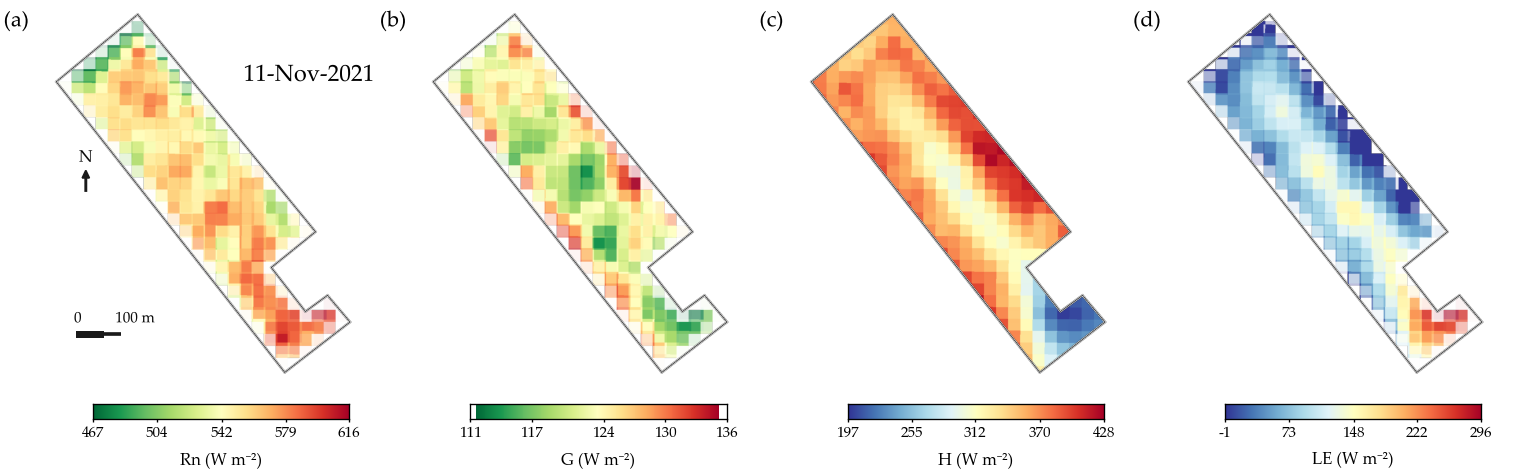

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_04-Dic-2021.png


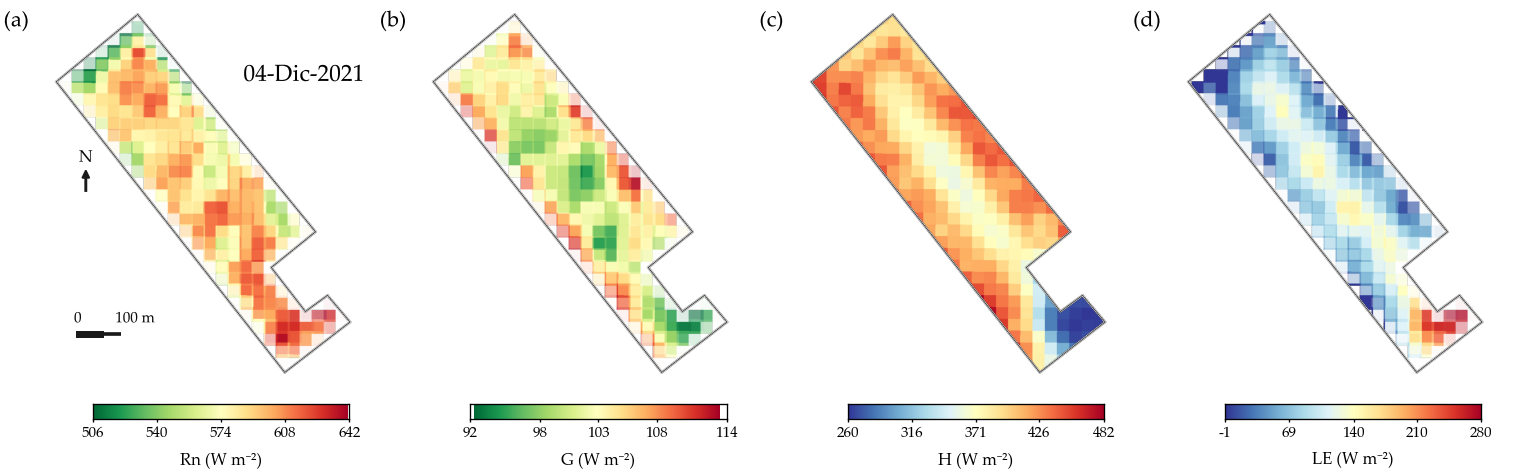

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_02-Mar-2022.png


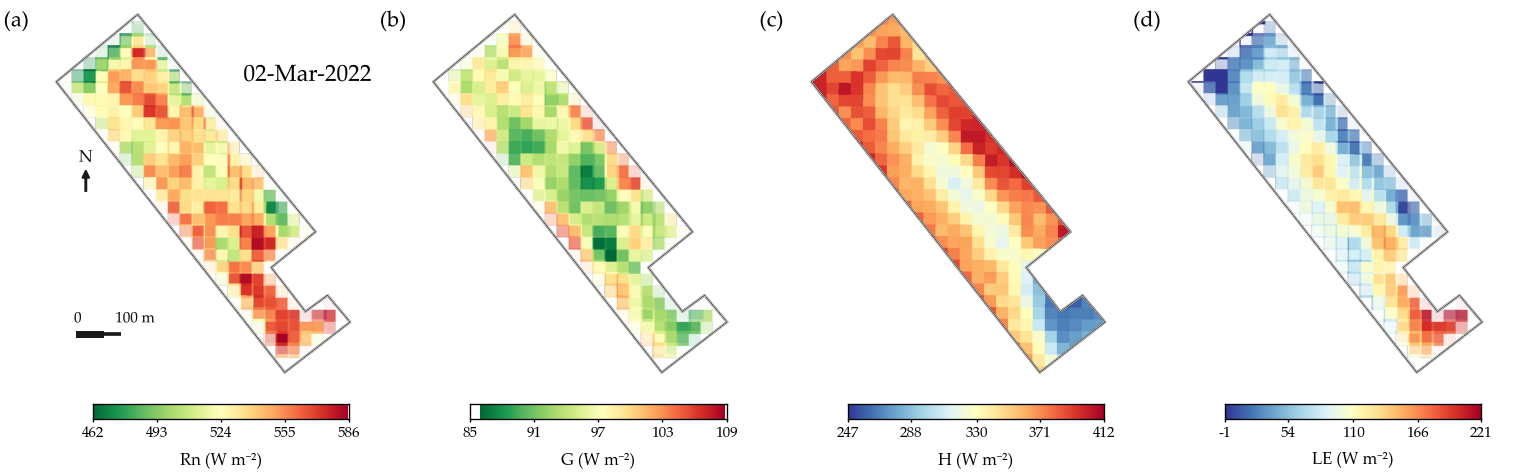

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_18-Mar-2022.png


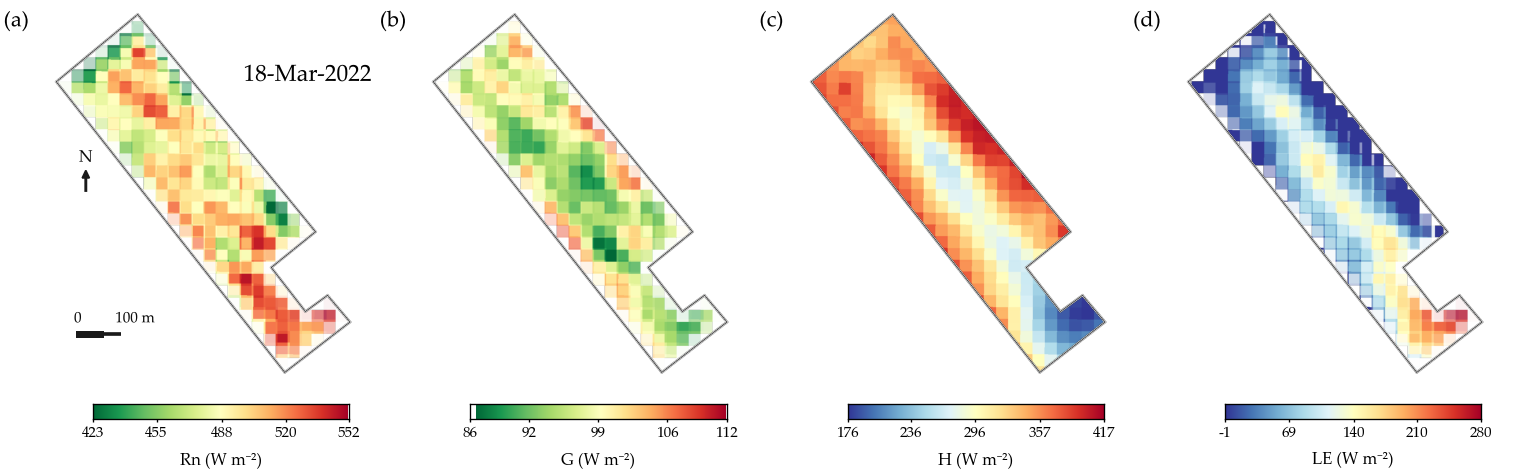

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_03-Abr-2022.png


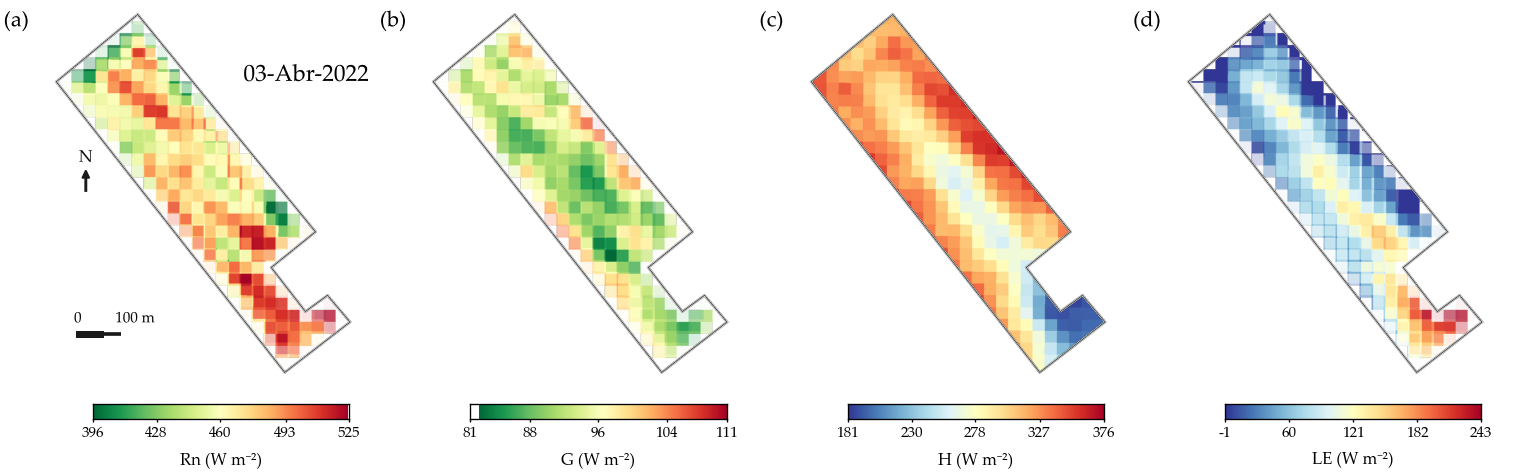

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_19-Abr-2022.png


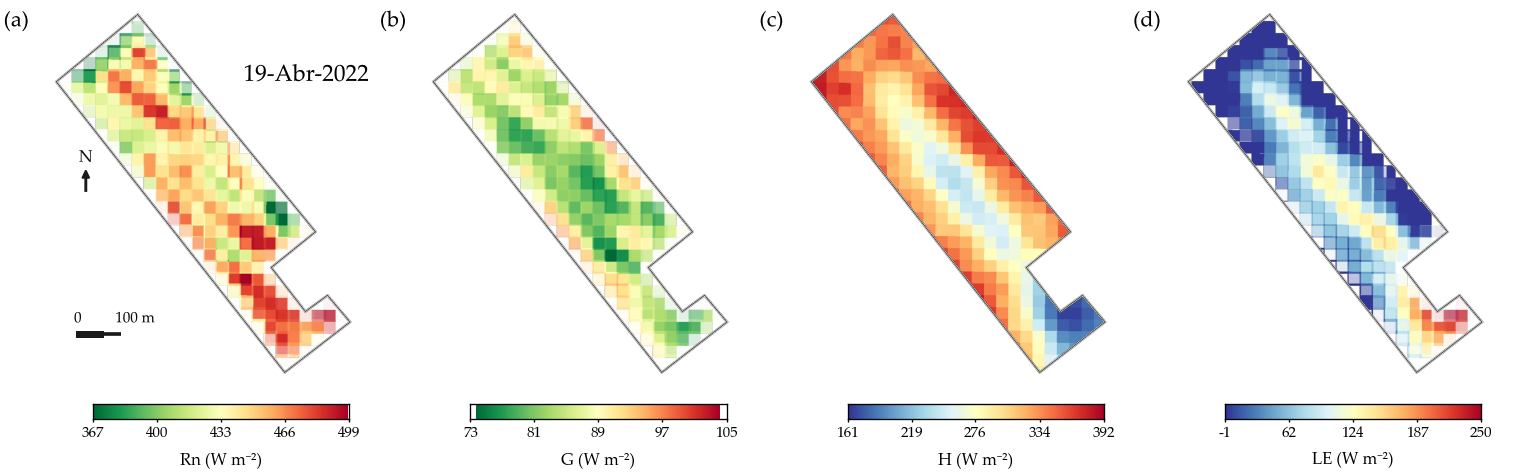

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\1823776192.py:236: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exportado: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaico_Balance_27-Abr-2022.png


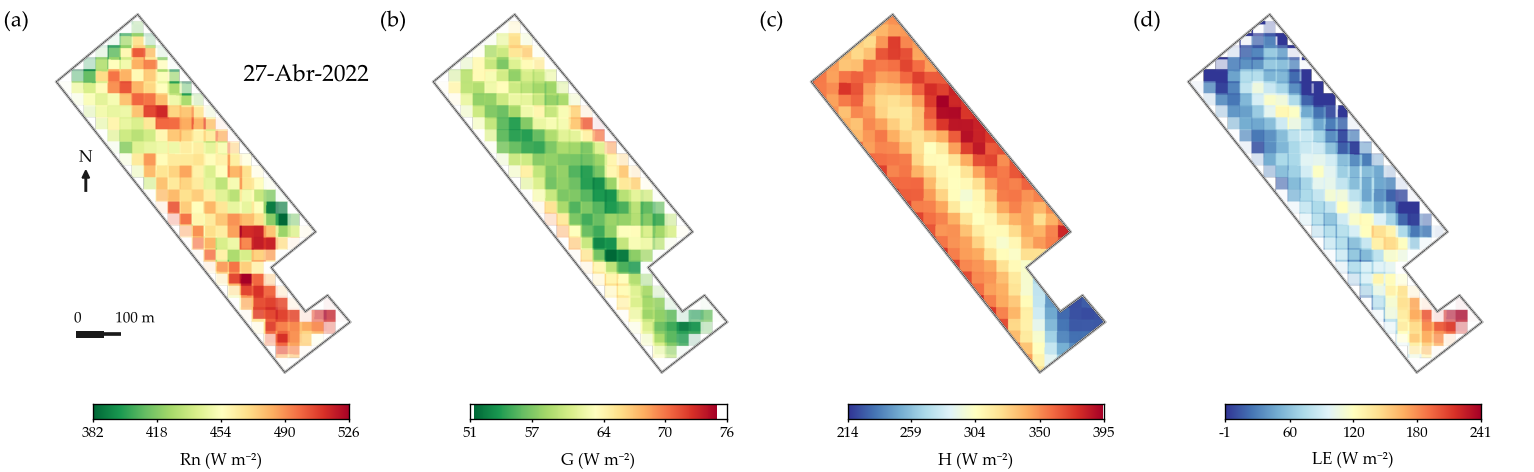

KeyboardInterrupt: 

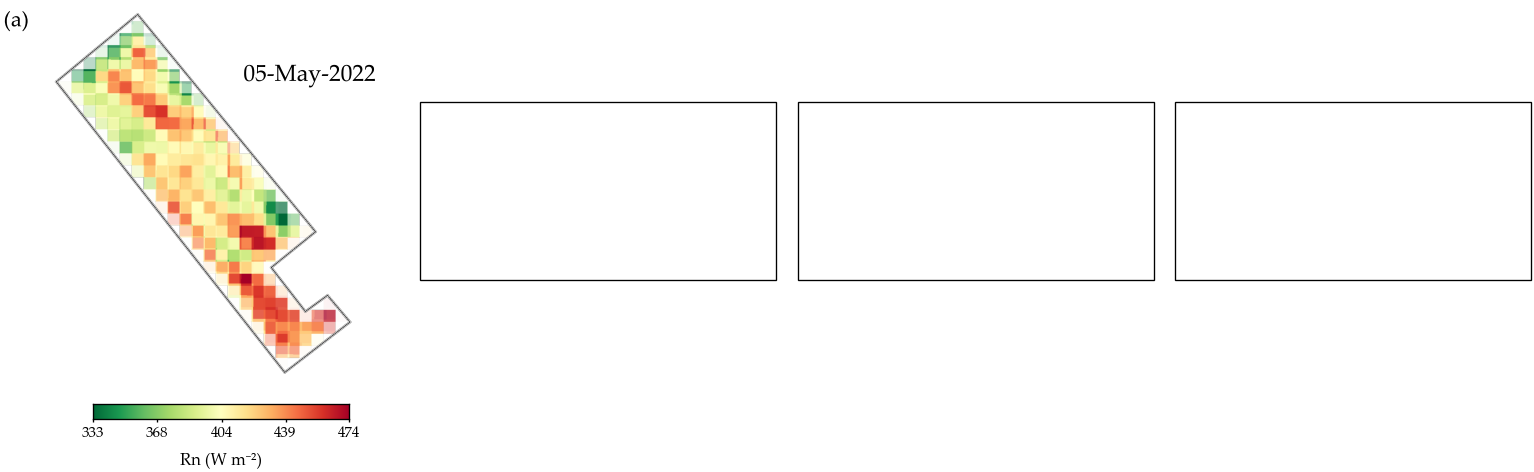

In [51]:
# -*- coding: utf-8 -*-
"""
Mosaicos Q1-ready de Rn, G, H y LE con borde del área (ROI)
- Fecha arriba-izq. en (a); letras (a–d) a la izquierda.
- Escala y norte solo en (a).
- Colorbar continua HORIZONTAL, centrada, sin espacios en blanco.
- Ticks enteros (sin decimales) con extremos incluidos.
- Exporta PNG a 600 dpi.
- NUEVO: contorno del área (halo blanco + trazo negro) en cada panel.
"""

# ========== IMPORTS ==========
import os, math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
from matplotlib.patheffects import withStroke

import ee, geemap
from geemap import cartoee
import geemap.colormaps as cmp

# ========== EE INIT ==========
try:
    geemap.ee_initialize()
except Exception:
    ee.Initialize()

# ========== ESTILO ==========
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype", "Book Antiqua", "Palatino", "Times New Roman"],
    "mathtext.fontset": "dejavuserif",
})

# ========== REGIÓN ==========
extent = 0.0004
zoom_region = [
    -70.53539711730724 - extent,
    -18.185505011017327 - extent,
    -70.52796183246036 + extent,
    -18.177618129602468 + extent
]
region_geom = ee.Geometry.Rectangle(zoom_region)
scale_m = 30

# ========== PALETAS ==========
vis_Rn = {'palette': cmp.get_palette('RdYlGn_r')}
vis_G  = {'palette': cmp.get_palette('RdYlGn_r')}
vis_H  = {'palette': cmp.get_palette('RdYlBu_r')}
vis_LE = {'palette': cmp.get_palette('RdYlBu_r')}

lista_paletas   = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W m⁻²)', 'G (W m⁻²)', 'H (W m⁻²)', 'LE (W m⁻²)']



# ===================== NORTH + SCALE =====================
def scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12):
    trans = ax.transAxes
    x0, y0 = loc; L = width_axes
    pad = 0.015
    bg = FancyBboxPatch((x0-pad, y0-pad), L+2*pad, 0.04,
                        transform=trans, boxstyle="round,pad=0.01,rounding_size=0.02",
                        linewidth=0, facecolor=(1,1,1,0.6), zorder=9)
    ax.add_patch(bg)
    ax.plot([x0, x0+L], [y0, y0], transform=trans, lw=2.2, solid_capstyle='butt', color='0.1', zorder=10)
    ax.plot([x0, x0+L/2], [y0, y0], transform=trans, lw=4.2, color='0.1', zorder=10)
    ax.text(x0-0.013, y0 + 0.020,'0         100 m', transform=trans,
            fontsize=9, va='bottom', color='0.05',
            path_effects=[withStroke(linewidth=2, foreground='white', alpha=0.8)], zorder=11)

def north_arrow(ax, loc=(0.12, 0.50)):
    x, y = loc; trans = ax.transAxes
    bg = FancyBboxPatch((x-0.03, y-0.02), 0.06, 0.10,
                        transform=trans, boxstyle="round,pad=0.01,rounding_size=0.02",
                        linewidth=0, facecolor=(1,1,1,0.6), zorder=9)
    ax.add_patch(bg)
    ax.arrow(x, y, 0, 0.055, transform=trans,
             width=0.0035, head_width=0.02, head_length=0.02,
             color='0.1', length_includes_head=True, zorder=10)
    ax.text(x, y+0.065, 'N', transform=trans, ha='center', va='bottom',
            fontsize=10, color='0.05',
            path_effects=[withStroke(linewidth=2, foreground='white', alpha=0.8)], zorder=11)

def obtener_min_max(img, band, geom, scale=30):
    stats = img.select(band).reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=geom, scale=scale,
        bestEffort=True, maxPixels=1e9
    )
    vmin = stats.get(f'{band}_min').getInfo()
    vmax = stats.get(f'{band}_max').getInfo()
    if vmin is None or vmax is None:
        vmin, vmax = 0, 1
    if vmax == vmin:
        vmax = vmin + 1e-6
    span = vmax - vmin
    eps  = max(span*1e-9, 1e-9)
    return float(vmin - eps), float(vmax + eps)

def _to_cmap(palette_list, name='custom'):
    pal = [c if str(c).startswith('#') else f'#{c}' for c in palette_list]
    return LinearSegmentedColormap.from_list(name, pal, N=256)

def nice_int_ticks(vmin, vmax, n=5):
    a, b = int(np.floor(vmin)), int(np.ceil(vmax))
    if a == b: b = a + 1
    ticks = np.linspace(a, b, n)
    ticks = np.round(ticks).astype(int)
    ticks[0], ticks[-1] = a, b
    uniq, idx = np.unique(ticks, return_index=True)
    ticks = uniq[np.sort(idx)]
    if ticks.size < 3:
        mid = int(round((a + b)/2))
        ticks = np.unique(np.array([a, mid, b], dtype=int))
    return ticks

def draw_horizontal_colorbar_imshow(fig, cax, vmin, vmax, cmap, etiqueta, ticks):
    """Barra continua sin espacios blancos usando imshow."""
    grad = np.linspace(vmin, vmax, 512, dtype=float)[None, :]
    cax.imshow(grad, aspect='auto', cmap=cmap,
               extent=[vmin, vmax, 0, 1], origin='lower', interpolation='nearest')
    for spine in cax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_edgecolor('black')
    cax.set_yticks([])
    cax.set_xlim(vmin, vmax)
    cax.set_xticks(ticks)
    cax.set_xticklabels([f"{t}" for t in ticks], fontsize=9)
    cax.tick_params(axis='x', length=2, pad=2)
    cax.set_xlabel(etiqueta, fontsize=10, labelpad=6)

# ======= NUEVO: utilidades para contorno del área =======
def _roi_geometry(roi):
    """Asegura que tengamos una Geometry a partir de Geometry, Feature o FeatureCollection."""
    try:
        return ee.FeatureCollection(roi).geometry()
    except Exception:
        return ee.Feature(roi).geometry()

def add_roi_outline(ax, roi, region, dims=1000,
                    halo_width=6, line_width=2,
                    halo_color='#ffffff', line_color='#111111'):
    """
    Dibuja el contorno del ROI con halo blanco y trazo negro encima.
    """
    geom = _roi_geometry(roi)
    # Halo blanco (más grueso)
    halo = ee.Image().byte().paint(geom, 1, halo_width)
    cartoee.add_layer(
        ax, halo, region=region,
        vis_params={'min': 0, 'max': 1, 'palette': [halo_color]},
        dims=dims, opacity=1.0
    )
    # Trazo negro (fino)
    line = ee.Image().byte().paint(geom, 1, line_width)
    cartoee.add_layer(
        ax, line, region=region,
        vis_params={'min': 0, 'max': 1, 'palette': [line_color]},
        dims=dims, opacity=1.0
    )

# ========== FUNCIÓN PRINCIPAL ==========
def plot_balance_mosaico(
        lista_imgs, lista_fechas,
        out_dir=r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics",
        roi_borde=None,              # <— pasa aquí tu Feature/FC/Geometry (p. ej., predios_agricolas)
        halo_width=6, line_width=2   # grosor del halo y del trazo
    ):
    os.makedirs(out_dir, exist_ok=True)
    letras = [chr(97+i) for i in range(26)]
    pe = [withStroke(linewidth=3, foreground="white", alpha=0.9)]

    for idx, fecha in enumerate(lista_fechas):
        img_productos = lista_imgs[idx]['img_CompBalance']

        fig = plt.figure(figsize=(16, 5.6))
        gs  = fig.add_gridspec(ncols=4, nrows=1, wspace=0.06, hspace=0.0)
        axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

        # Fecha en (a)
        axs[0].text(zoom_region[0] + 0.0036,
                    zoom_region[3] - 0.0014,
                    fecha, transform=ccrs.PlateCarree(),
                    fontsize=14, va='top', path_effects=pe)

        for i in range(4):
            ax       = axs[i]
            band     = lista_variables[i]
            etiqueta = lista_etiquetas[i]
            cmap     = _to_cmap(lista_paletas[i]['palette'], name=f'pal_{i}')

            # Rango dinámico por panel
            vmin, vmax = obtener_min_max(img_productos, band, region_geom, scale=scale_m)
            vis = {'min': vmin, 'max': vmax, 'palette': lista_paletas[i]['palette']}

            # Mapa
            cartoee.add_layer(ax, img_productos.select(band),
                              region=zoom_region, vis_params=vis, dims=1000)
            ax.axis('off')

            # Contorno del ROI (si se provee)
            if roi_borde is not None:
                add_roi_outline(ax, roi_borde, zoom_region,
                                dims=1000, halo_width=halo_width, line_width=line_width)

            # (a–d)
            ax.text(-0.04, 0.98, f'({letras[i]})',
                    transform=ax.transAxes, ha='right', va='top',
                    fontsize=13, path_effects=pe)

            # ===== COLORBAR (imshow, sin blancos) =====
            box = ax.get_position()
            cb_h = 0.022
            cb_w = box.width * 0.72
            cb_x = box.x0 + (box.width - cb_w)/2
            cb_y = box.y0 - 0.060
            cax  = fig.add_axes([cb_x, cb_y, cb_w, cb_h])

            ticks = nice_int_ticks(vmin, vmax, n=5)
            draw_horizontal_colorbar_imshow(fig, cax, vmin, vmax, cmap, etiqueta, ticks)

        # Escala y norte solo en (a)
        scalebar_100m(axs[0], loc=(0.10, 0.12), width_axes=0.12)
        north_arrow(axs[0], loc=(0.12, 0.50))

        plt.tight_layout()
        out_png = os.path.join(os.path.abspath(out_dir), f"Mosaico_Balance_{fecha}.png")
        plt.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
        print(f"✅ Exportado: {out_png}")
        plt.show()

# ========== LLAMADA ==========
# Sustituye 'predios_agricolas' por tu ROI (FeatureCollection/Feature/Geometry) o usa 'ruta_ferrenafe'
# Ejemplo:
# plot_balance_mosaico(lista_imgprocesadas_ET, lista_fechas, roi_borde=predios_agricolas)

plot_balance_mosaico(
    lista_imgprocesadas_ET,
    lista_fechas,
    roi_borde=predios_agricolas,   # <— tu borde aquí
    halo_width=6,                  # halo blanco (px de EE)
    line_width=2                   # trazo negro (px de EE)
)


C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_11-Nov-2021_ROI.png


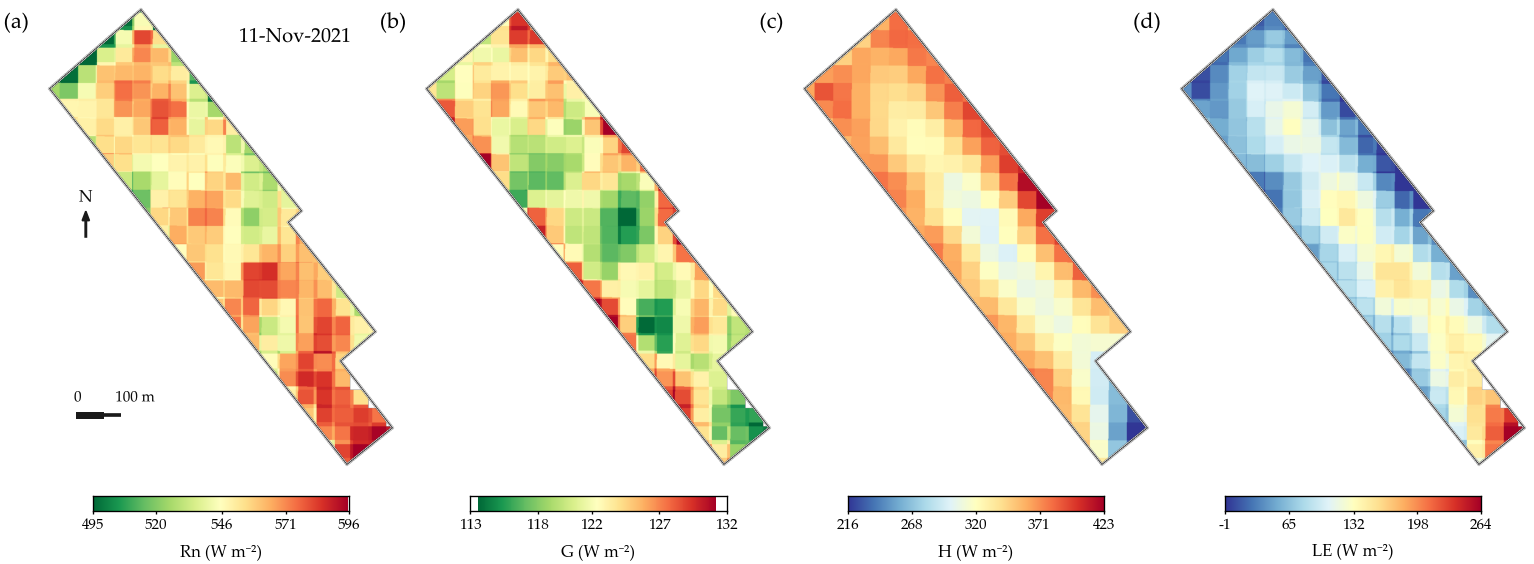

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_04-Dec-2021_ROI.png


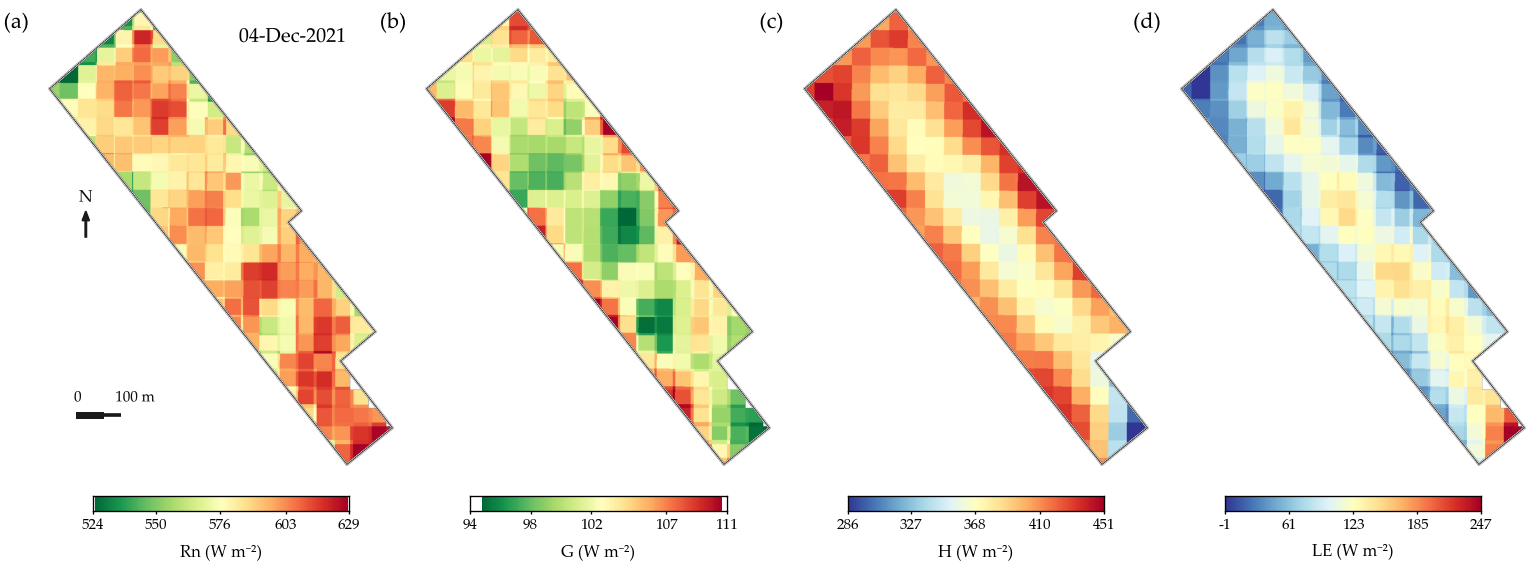

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_02-Mar-2022_ROI.png


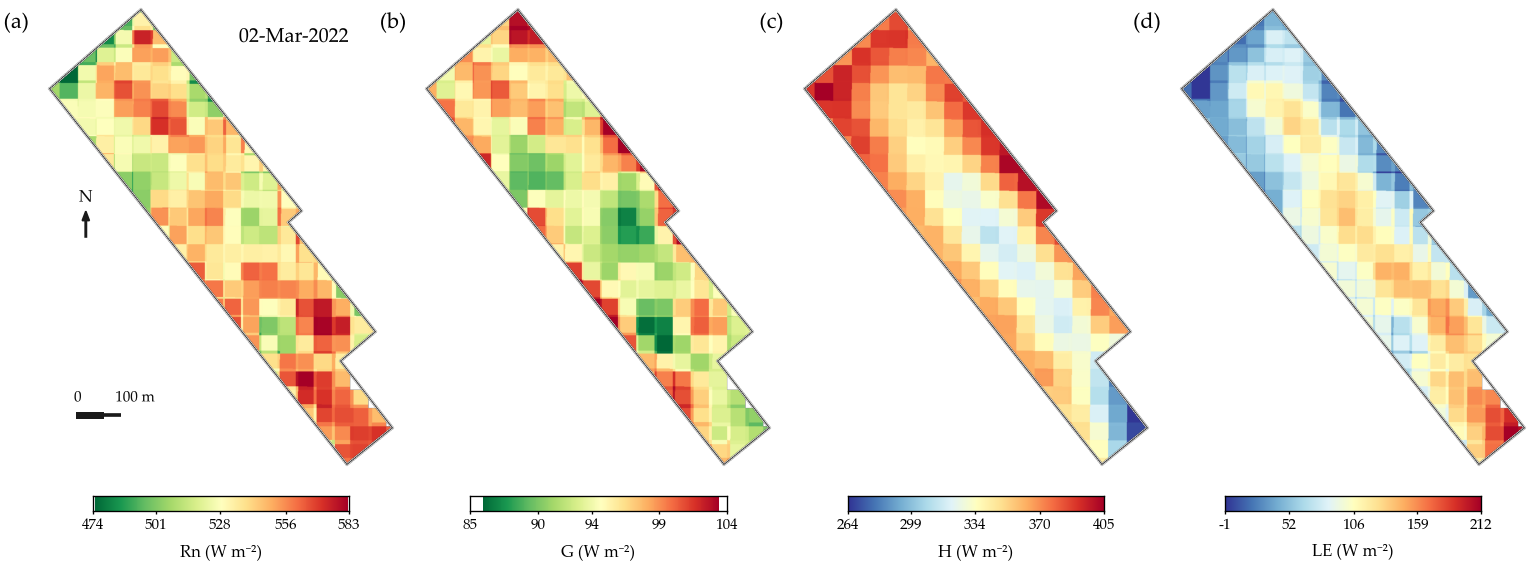

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_18-Mar-2022_ROI.png


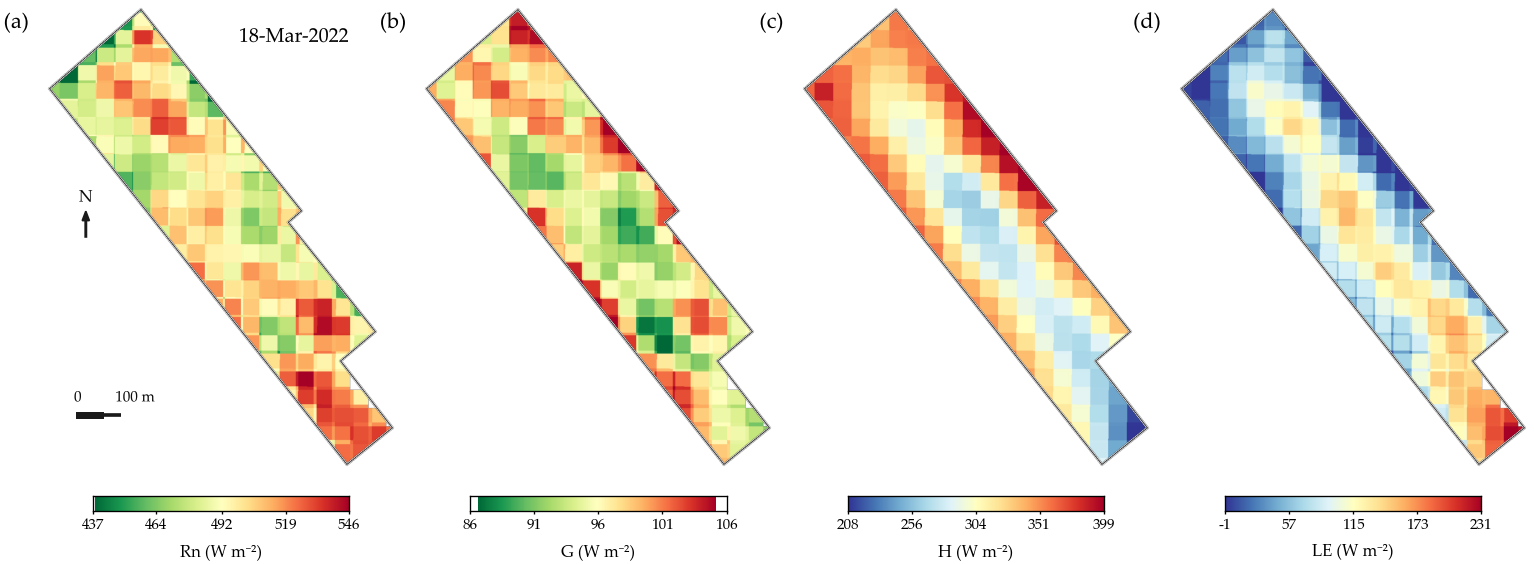

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_03-Apr-2022_ROI.png


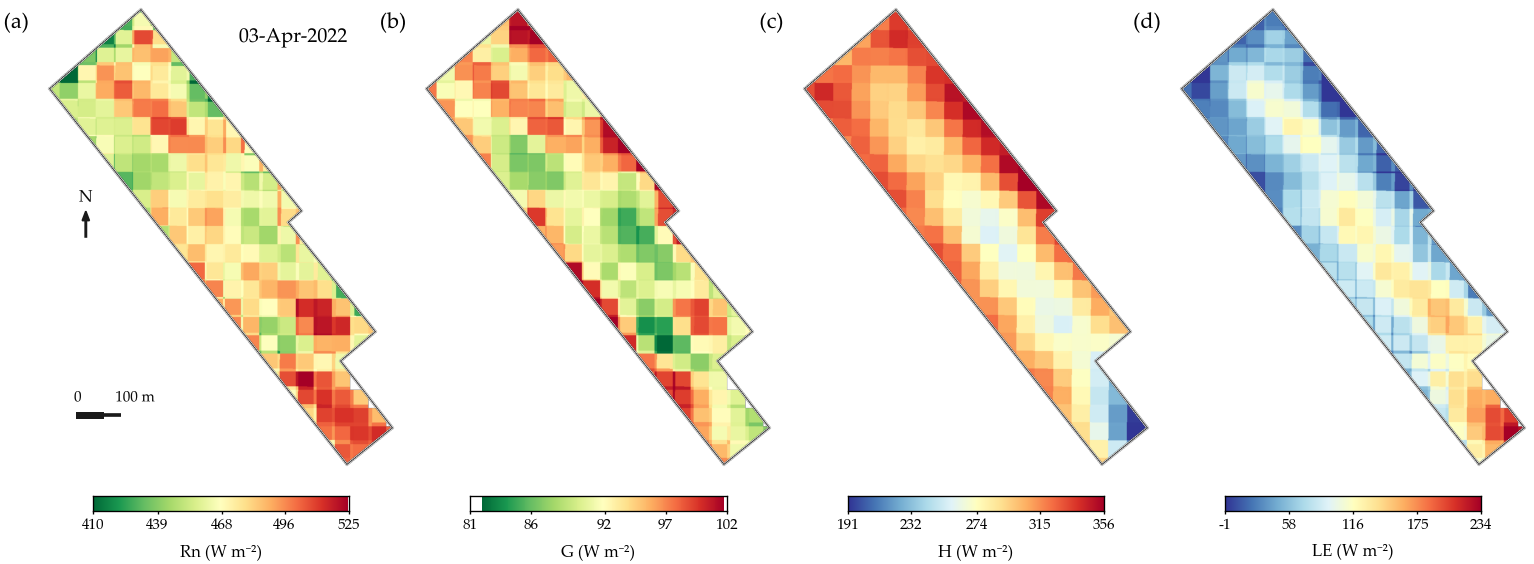

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_19-Apr-2022_ROI.png


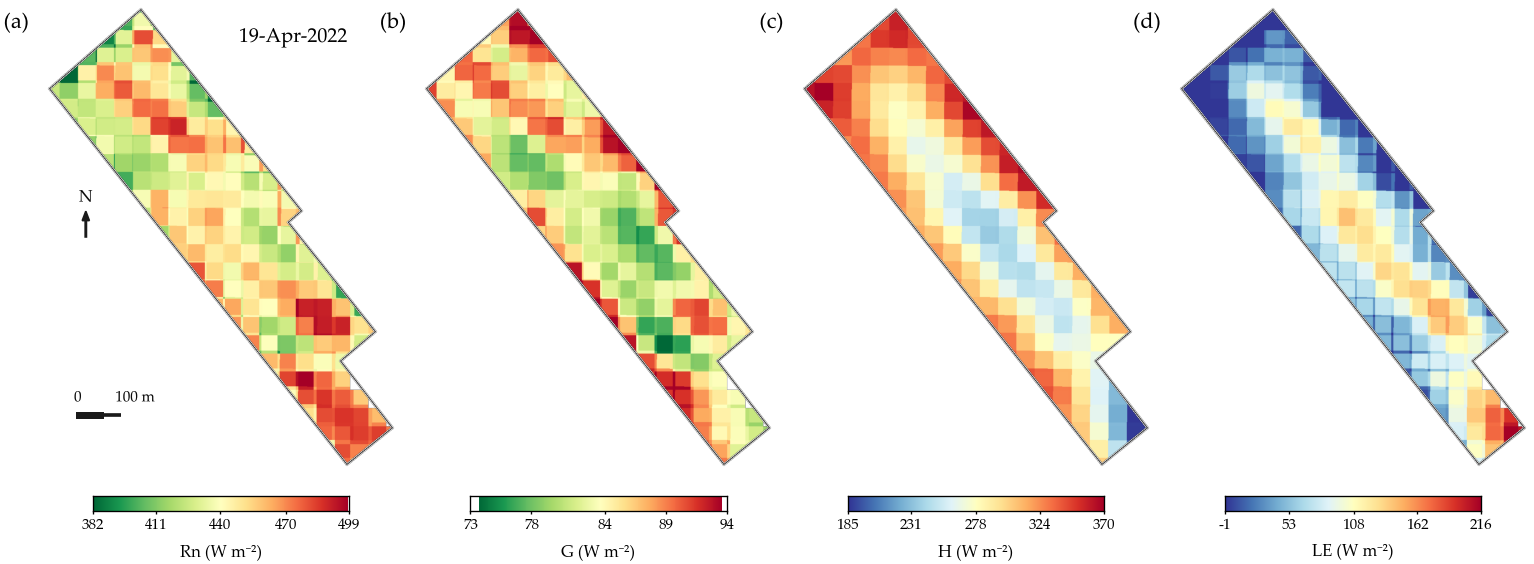

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_27-Apr-2022_ROI.png


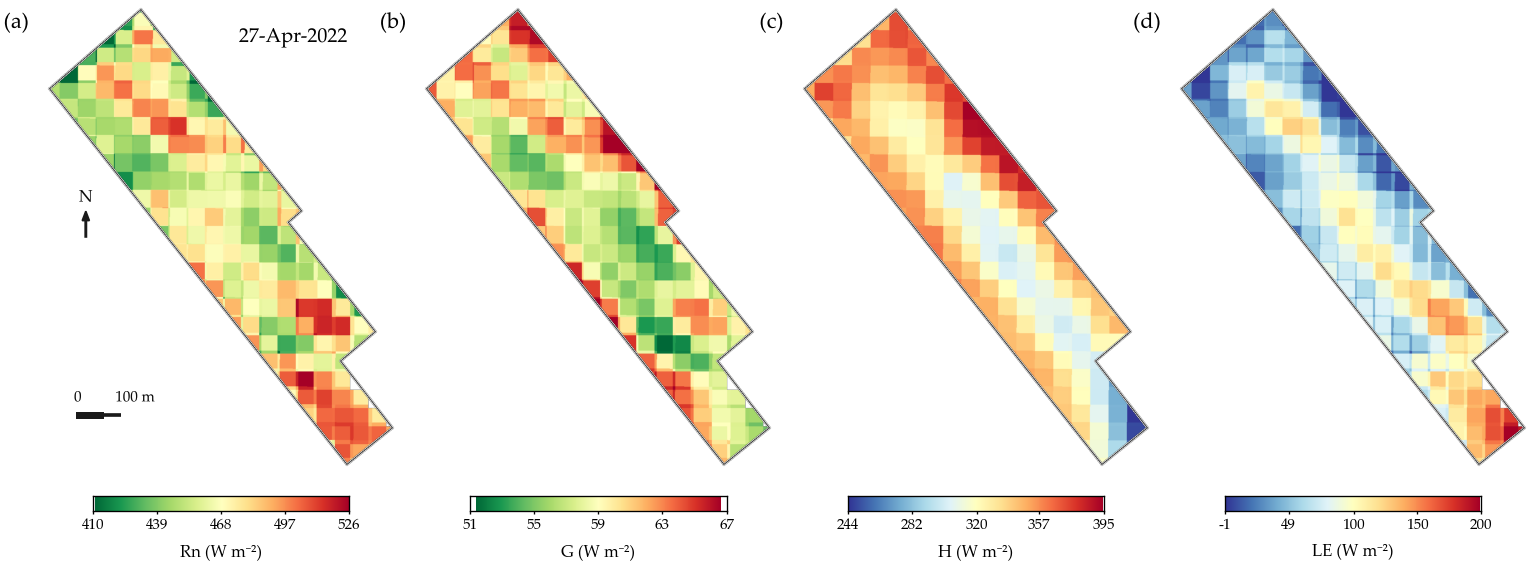

C:\Users\joluh\AppData\Local\Temp\ipykernel_46800\3626939843.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


✅ Exported: C:\Users\joluh\OneDrive\Thesis\Articles\Tacna\Metric_Olive_21_22\figs\processed\mosaics\Mosaic_Balance_05-May-2022_ROI.png


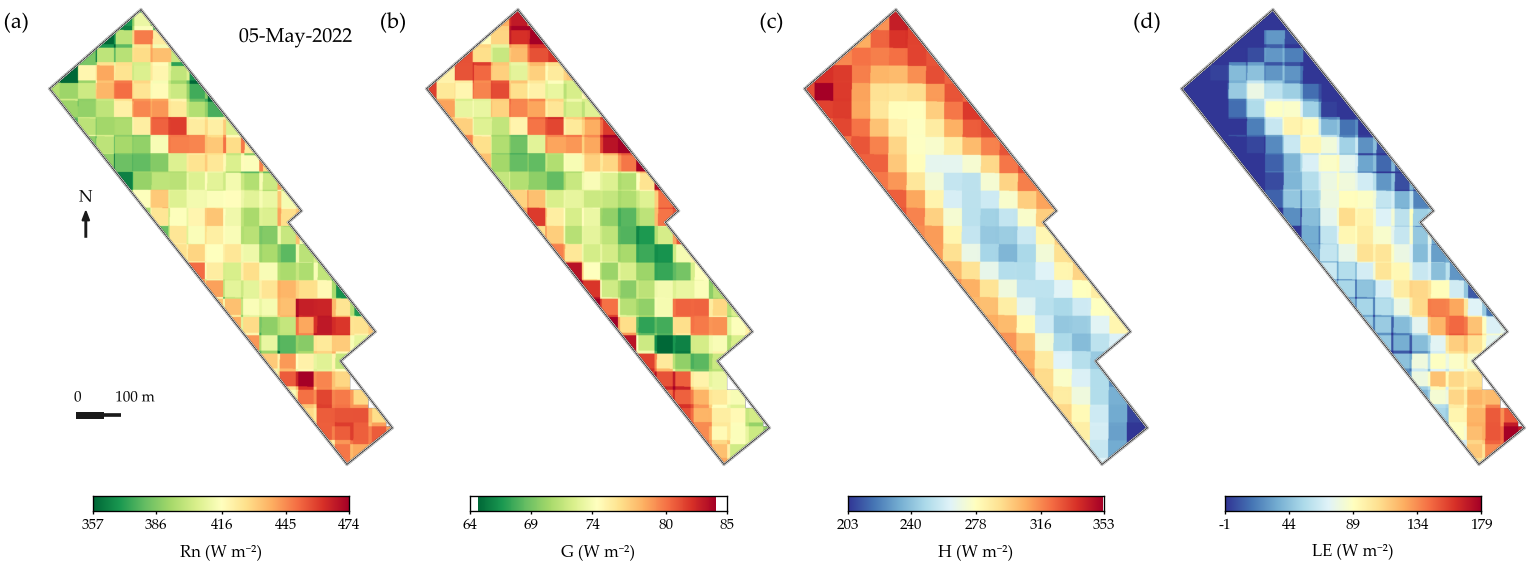

In [60]:
# -*- coding: utf-8 -*-
"""
Mosaics (Rn, G, H, LE) — ROI 'Olive' hard-clipped + masked
- Strict mask outside ROI (selfMask + reproject) + clip(ROI).
- English date label top-left inside (a–d), same aesthetic as example.
- North & scale only in (a).
- Thin horizontal colorbar per panel, centered, without white gaps.
- Integer ticks with endpoints included.
- 600 dpi export; ROI outline (white halo + black stroke).
"""

# ===================== USER PATHS / ROI =====================
ROI_ASSET = "projects/ee-joluhumu/assets/Olive"
SHP_PATH  = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"

# ===================== DATE LABEL (English) =====================
DATE_FMT     = "%d-%b-%Y"   # e.g., 11-Nov-2021
DATE_POS_AX  = (0.55, 0.95) # top-left inside axes
DATE_HALIGN  = "left"
DATE_VALIGN  = "top"
DATE_FONTSZ  = 12

# ========== IMPORTS ==========
import os, math, re, string
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
from matplotlib.patheffects import withStroke

import ee, geemap
from geemap import cartoee
import geemap.colormaps as cmp

# ========== EE INIT ==========
try:
    geemap.ee_initialize()
except Exception:
    ee.Initialize()

# ========== ESTILO ==========
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype", "Book Antiqua", "Palatino", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "dejavuserif",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

# ========== PARÁMETROS ==========
scale_m    = 30
DIMS_TILES = 1100

# ========== PALETAS ==========
vis_Rn = {'palette': cmp.get_palette('RdYlGn_r')}
vis_G  = {'palette': cmp.get_palette('RdYlGn_r')}
vis_H  = {'palette': cmp.get_palette('RdYlBu_r')}
vis_LE = {'palette': cmp.get_palette('RdYlBu_r')}

lista_paletas   = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W m⁻²)', 'G (W m⁻²)', 'H (W m⁻²)', 'LE (W m⁻²)']

# ===================== Helpers =====================
_SP2EN = {
    "ene":"Jan","feb":"Feb","mar":"Mar","abr":"Apr","may":"May","jun":"Jun",
    "jul":"Jul","ago":"Aug","set":"Sep","sep":"Sep","oct":"Oct","nov":"Nov","dic":"Dec",
    "enero":"Jan","febrero":"Feb","marzo":"Mar","abril":"Apr","mayo":"May","junio":"Jun",
    "julio":"Jul","agosto":"Aug","septiembre":"Sep","setiembre":"Sep","octubre":"Oct",
    "noviembre":"Nov","diciembre":"Dec",
}
def normalize_dates_to_english(date_list, out_fmt="%d-%b-%Y"):
    out = []
    for s in date_list:
        s0 = str(s).strip()
        # numéricas comunes
        for fmt in ("%d-%m-%Y","%Y-%m-%d","%d/%m/%Y","%d.%m.%Y","%d %b %Y","%d-%b-%Y"):
            try:
                dt = datetime.strptime(s0, fmt)
                out.append(dt.strftime(out_fmt)); break
            except Exception:
                pass
        else:
            toks = re.split(r"[-/\s]", s0)
            if len(toks) == 3:
                d, m, y = toks; m_low = m.lower()
                if m_low in _SP2EN:
                    try:
                        dt = datetime.strptime(f"{d}-{_SP2EN[m_low]}-{y}", "%d-%b-%Y")
                        out.append(dt.strftime(out_fmt)); continue
                    except Exception: pass
            out.append(s0)
    return out

def load_roi(asset_id=None, shp_path=None):
    fc = None
    if asset_id:
        try:
            fc = ee.FeatureCollection(asset_id)
            _ = fc.limit(1).getInfo()
        except Exception:
            fc = None
    if (fc is None) and shp_path and os.path.exists(shp_path):
        fc = geemap.shp_to_ee(shp_path)
    if fc is None:
        raise ValueError("ROI not found. Check ROI_ASSET / SHP_PATH.")
    return fc

def roi_geometry(fc):
    try:    return ee.FeatureCollection(fc).geometry()
    except: return ee.Feature(fc).geometry()

def roi_bbox(geom, pad_deg=0.0001):
    coords = geom.bounds(1).coordinates().get(0).getInfo()
    xs = [c[0] for c in coords]; ys = [c[1] for c in coords]
    xmin, xmax = min(xs), max(xs); ymin, ymax = min(ys), max(ys)
    return [xmin-pad_deg, ymin-pad_deg, xmax+pad_deg, ymax+pad_deg]

def obtener_min_max(img, band, geom, scale=30):
    d = img.select(band).reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=geom, scale=scale, bestEffort=True, maxPixels=1e9
    )
    vmin = d.get(f"{band}_min").getInfo()
    vmax = d.get(f"{band}_max").getInfo()
    if vmin is None or vmax is None: vmin, vmax = 0, 1
    if vmax == vmin: vmax = vmin + 1e-6
    span = vmax - vmin; eps = max(span*1e-9, 1e-9)
    return float(vmin - eps), float(vmax + eps)

def _to_cmap(palette_list, name='custom'):
    pal = [c if str(c).startswith('#') else f'#{c}' for c in palette_list]
    return LinearSegmentedColormap.from_list(name, pal, N=256)

def nice_int_ticks(vmin, vmax, n=5):
    a, b = int(np.floor(vmin)), int(np.ceil(vmax))
    if a == b: b = a + 1
    ticks = np.linspace(a, b, n).round().astype(int)
    ticks[0], ticks[-1] = a, b
    ticks = np.unique(ticks)
    if ticks.size < 3:
        mid = int(round((a+b)/2)); ticks = np.unique([a, mid, b])
    return ticks

def draw_horizontal_colorbar_imshow(fig, cax, vmin, vmax, cmap, etiqueta, ticks):
    grad = np.linspace(vmin, vmax, 512, dtype=float)[None, :]
    cax.imshow(grad, aspect='auto', cmap=cmap,
               extent=[vmin, vmax, 0, 1], origin='lower', interpolation='nearest')
    for s in cax.spines.values():
        s.set_visible(True); s.set_linewidth(0.8); s.set_edgecolor('black')
    cax.set_yticks([]); cax.set_xlim(vmin, vmax)
    cax.set_xticks(ticks); cax.set_xticklabels([f"{t}" for t in ticks], fontsize=9)
    cax.tick_params(axis='x', length=2, pad=2)
    cax.set_xlabel(etiqueta, fontsize=10, labelpad=6)

def add_roi_outline(ax, roi, region, dims=1000, halo_width=6, line_width=2,
                    halo_color='#ffffff', line_color='#111111'):
    geom = roi_geometry(roi)
    halo = ee.Image().byte().paint(geom, 1, halo_width)
    cartoee.add_layer(ax, halo, region=region,
        vis_params={'min':0,'max':1,'palette':[halo_color]}, dims=dims, opacity=1.0)
    line = ee.Image().byte().paint(geom, 1, line_width)
    cartoee.add_layer(ax, line, region=region,
        vis_params={'min':0,'max':1,'palette':[line_color]}, dims=dims, opacity=1.0)

# ===================== Main =====================
def plot_balance_mosaico(
        lista_imgs, lista_fechas,
        out_dir=r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/mosaics",
        halo_width=6, line_width=2
    ):
    os.makedirs(out_dir, exist_ok=True)
    letras = list(string.ascii_lowercase)
    pe = [withStroke(linewidth=3, foreground="white", alpha=0.9)]

    # ROI + bbox
    roi_fc   = load_roi(ROI_ASSET, SHP_PATH)
    roi_geom = roi_geometry(roi_fc)
    region_bbox = roi_bbox(roi_geom, pad_deg=0.0001)

    # Fechas a inglés
    fechas_en = normalize_dates_to_english(lista_fechas, out_fmt=DATE_FMT)

    for idx, fecha in enumerate(fechas_en):
        img_productos = lista_imgs[idx]['img_CompBalance']

        # --- Proyección de referencia (primera banda) ---
        proj_ref = img_productos.select(lista_variables[0]).projection()

        # --- Máscara ROI estricta re-proyectada + clip ---
        roi_mask = ee.Image.constant(1).clip(roi_geom).reproject(proj_ref).selfMask()
        img_roi  = img_productos.updateMask(roi_mask).clip(roi_geom)

        fig = plt.figure(figsize=(16, 5.6))
        gs  = fig.add_gridspec(ncols=4, nrows=1, wspace=0.06, hspace=0.0)
        axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

        for i in range(4):
            ax       = axs[i]
            band     = lista_variables[i]
            etiqueta = lista_etiquetas[i]
            cmap     = _to_cmap(lista_paletas[i]['palette'], name=f'pal_{i}')

            # Rango dentro del ROI
            vmin, vmax = obtener_min_max(img_roi, band, roi_geom, scale=scale_m)
            vis = {'min': vmin, 'max': vmax, 'palette': lista_paletas[i]['palette']}

            # Dibujo SOLO ROI enmascarado
            cartoee.add_layer(ax, img_roi.select(band),
                              region=region_bbox, vis_params=vis, dims=DIMS_TILES)
            ax.axis('off')

            # Contorno ROI
            add_roi_outline(ax, roi_fc, region_bbox, dims=DIMS_TILES,
                            halo_width=halo_width, line_width=line_width)

            # (a–d)
            ax.text(-0.04, 0.98, f'({letras[i]})',
                    transform=ax.transAxes, ha='right', va='top',
                    fontsize=13, path_effects=pe)

            # Fecha en inglés (top-left) — en (a) solamente
            if i == 0:
                ax.text(DATE_POS_AX[0], DATE_POS_AX[1], fecha,
                        transform=ax.transAxes, fontsize=DATE_FONTSZ,
                        ha=DATE_HALIGN, va=DATE_VALIGN, path_effects=pe, zorder=11)

            # Colorbar compacta
            box = ax.get_position()
            cb_h = 0.022
            cb_w = box.width * 0.72
            cb_x = box.x0 + (box.width - cb_w)/2
            cb_y = box.y0 - 0.060
            cax  = fig.add_axes([cb_x, cb_y, cb_w, cb_h])

            ticks = nice_int_ticks(vmin, vmax, n=5)
            draw_horizontal_colorbar_imshow(fig, cax, vmin, vmax, cmap, etiqueta, ticks)

        # Escala y norte solo en (a)
        scalebar_100m(axs[0], loc=(0.10, 0.12), width_axes=0.12)
        north_arrow(axs[0], loc=(0.12, 0.50))

        plt.tight_layout()
        out_png = os.path.join(os.path.abspath(out_dir), f"Mosaic_Balance_{fecha.replace(' ','_')}_ROI.png")
        plt.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
        print(f"✅ Exported: {out_png}")
        plt.show()

# ===================== LLAMADA =====================
# Requiere: lista_imgprocesadas_ET, lista_fechas
plot_balance_mosaico(
    lista_imgprocesadas_ET,
    lista_fechas,
    halo_width=6,
    line_width=2
)


## 3.1. Gráfica NDVI-IAF-Albedo-Ts

In [ ]:
# -*- coding: utf-8 -*-
"""
Mosaicos Q1-ready de Rn, G, H y LE con borde del área (ROI)
- Fecha arriba-izq. en (a); letras (a–d) a la izquierda.
- Escala y norte solo en (a).
- Colorbar continua HORIZONTAL, centrada, sin espacios en blanco.
- Ticks enteros (sin decimales) con extremos incluidos.
- Exporta PNG a 600 dpi.
- NUEVO: contorno del área (halo blanco + trazo negro) en cada panel.
"""

# ========== IMPORTS ==========
import os, math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
from matplotlib.patheffects import withStroke

import ee, geemap
from geemap import cartoee
import geemap.colormaps as cmp

# ========== EE INIT ==========
try:
    geemap.ee_initialize()
except Exception:
    ee.Initialize()

# ========== ESTILO ==========
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype", "Book Antiqua", "Palatino", "Times New Roman"],
    "mathtext.fontset": "dejavuserif",
})

# ========== REGIÓN ==========
extent = 0.0004
zoom_region = [
    -70.53539711730724 - extent,
    -18.185505011017327 - extent,
    -70.52796183246036 + extent,
    -18.177618129602468 + extent
]
region_geom = ee.Geometry.Rectangle(zoom_region)
scale_m = 30

# ========== PALETAS ==========
vis_Rn = {'palette': cmp.get_palette('RdYlGn_r')}
vis_G  = {'palette': cmp.get_palette('RdYlGn_r')}
vis_H  = {'palette': cmp.get_palette('RdYlBu_r')}
vis_LE = {'palette': cmp.get_palette('RdYlBu_r')}

lista_paletas   = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W m⁻²)', 'G (W m⁻²)', 'H (W m⁻²)', 'LE (W m⁻²)']

# ========== HELPERS ==========
def scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12):
    trans = ax.transAxes
    x0, y0 = loc; L = width_axes
    pad = 0.015
    bg = FancyBboxPatch((x0-pad, y0-pad), L+2*pad, 0.04,
                        transform=trans, boxstyle="round,pad=0.01,rounding_size=0.02",
                        linewidth=0, facecolor=(1,1,1,0.6), zorder=9)
    ax.add_patch(bg)
    ax.plot([x0, x0+L], [y0, y0], transform=trans,
            lw=2.2, solid_capstyle='butt', color='0.1', zorder=10)
    ax.text(x0, y0+0.018, '0                 100 m', transform=trans,
            fontsize=9, va='bottom', color='0.05',
            path_effects=[withStroke(linewidth=2, foreground='white', alpha=0.8)], zorder=11)

def north_arrow(ax, loc=(0.12, 0.50)):
    x, y = loc; trans = ax.transAxes
    bg = FancyBboxPatch((x-0.03, y-0.02), 0.06, 0.10,
                        transform=trans, boxstyle="round,pad=0.01,rounding_size=0.02",
                        linewidth=0, facecolor=(1,1,1,0.6), zorder=9)
    ax.add_patch(bg)
    ax.arrow(x, y, 0, 0.055, transform=trans,
             width=0.0035, head_width=0.02, head_length=0.02,
             color='0.1', length_includes_head=True, zorder=10)
    ax.text(x, y+0.065, 'N', transform=trans, ha='center', va='bottom',
            fontsize=10, color='0.05',
            path_effects=[withStroke(linewidth=2, foreground='white', alpha=0.8)], zorder=11)

def obtener_min_max(img, band, geom, scale=30):
    stats = img.select(band).reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=geom, scale=scale,
        bestEffort=True, maxPixels=1e9
    )
    vmin = stats.get(f'{band}_min').getInfo()
    vmax = stats.get(f'{band}_max').getInfo()
    if vmin is None or vmax is None:
        vmin, vmax = 0, 1
    if vmax == vmin:
        vmax = vmin + 1e-6
    span = vmax - vmin
    eps  = max(span*1e-9, 1e-9)
    return float(vmin - eps), float(vmax + eps)

def _to_cmap(palette_list, name='custom'):
    pal = [c if str(c).startswith('#') else f'#{c}' for c in palette_list]
    return LinearSegmentedColormap.from_list(name, pal, N=256)

def nice_int_ticks(vmin, vmax, n=5):
    a, b = int(np.floor(vmin)), int(np.ceil(vmax))
    if a == b: b = a + 1
    ticks = np.linspace(a, b, n)
    ticks = np.round(ticks).astype(int)
    ticks[0], ticks[-1] = a, b
    uniq, idx = np.unique(ticks, return_index=True)
    ticks = uniq[np.sort(idx)]
    if ticks.size < 3:
        mid = int(round((a + b)/2))
        ticks = np.unique(np.array([a, mid, b], dtype=int))
    return ticks

def draw_horizontal_colorbar_imshow(fig, cax, vmin, vmax, cmap, etiqueta, ticks):
    """Barra continua sin espacios blancos usando imshow."""
    grad = np.linspace(vmin, vmax, 512, dtype=float)[None, :]
    cax.imshow(grad, aspect='auto', cmap=cmap,
               extent=[vmin, vmax, 0, 1], origin='lower', interpolation='nearest')
    for spine in cax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_edgecolor('black')
    cax.set_yticks([])
    cax.set_xlim(vmin, vmax)
    cax.set_xticks(ticks)
    cax.set_xticklabels([f"{t}" for t in ticks], fontsize=9)
    cax.tick_params(axis='x', length=2, pad=2)
    cax.set_xlabel(etiqueta, fontsize=10, labelpad=6)

# ======= NUEVO: utilidades para contorno del área =======
def _roi_geometry(roi):
    """Asegura que tengamos una Geometry a partir de Geometry, Feature o FeatureCollection."""
    try:
        return ee.FeatureCollection(roi).geometry()
    except Exception:
        return ee.Feature(roi).geometry()

def add_roi_outline(ax, roi, region, dims=1000,
                    halo_width=6, line_width=2,
                    halo_color='#ffffff', line_color='#111111'):
    """
    Dibuja el contorno del ROI con halo blanco y trazo negro encima.
    """
    geom = _roi_geometry(roi)
    # Halo blanco (más grueso)
    halo = ee.Image().byte().paint(geom, 1, halo_width)
    cartoee.add_layer(
        ax, halo, region=region,
        vis_params={'min': 0, 'max': 1, 'palette': [halo_color]},
        dims=dims, opacity=1.0
    )
    # Trazo negro (fino)
    line = ee.Image().byte().paint(geom, 1, line_width)
    cartoee.add_layer(
        ax, line, region=region,
        vis_params={'min': 0, 'max': 1, 'palette': [line_color]},
        dims=dims, opacity=1.0
    )

# ========== FUNCIÓN PRINCIPAL ==========
def plot_balance_mosaico(
        lista_imgs, lista_fechas,
        out_dir=r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive/Resultados",
        roi_borde=None,              # <— pasa aquí tu Feature/FC/Geometry (p. ej., predios_agricolas)
        halo_width=6, line_width=2   # grosor del halo y del trazo
    ):
    os.makedirs(out_dir, exist_ok=True)
    letras = [chr(97+i) for i in range(26)]
    pe = [withStroke(linewidth=3, foreground="white", alpha=0.9)]

    for idx, fecha in enumerate(lista_fechas):
        img_productos = lista_imgs[idx]['img_CompBalance']

        fig = plt.figure(figsize=(16, 5.6))
        gs  = fig.add_gridspec(ncols=4, nrows=1, wspace=0.06, hspace=0.0)
        axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

        # Fecha en (a)
        axs[0].text(zoom_region[0] + 0.0036,
                    zoom_region[3] - 0.0014,
                    fecha, transform=ccrs.PlateCarree(),
                    fontsize=14, va='top', path_effects=pe)

        for i in range(4):
            ax       = axs[i]
            band     = lista_variables[i]
            etiqueta = lista_etiquetas[i]
            cmap     = _to_cmap(lista_paletas[i]['palette'], name=f'pal_{i}')

            # Rango dinámico por panel
            vmin, vmax = obtener_min_max(img_productos, band, region_geom, scale=scale_m)
            vis = {'min': vmin, 'max': vmax, 'palette': lista_paletas[i]['palette']}

            # Mapa
            cartoee.add_layer(ax, img_productos.select(band),
                              region=zoom_region, vis_params=vis, dims=1000)
            ax.axis('off')

            # Contorno del ROI (si se provee)
            if roi_borde is not None:
                add_roi_outline(ax, roi_borde, zoom_region,
                                dims=1000, halo_width=halo_width, line_width=line_width)

            # (a–d)
            ax.text(-0.04, 0.98, f'({letras[i]})',
                    transform=ax.transAxes, ha='right', va='top',
                    fontsize=13, path_effects=pe)

            # ===== COLORBAR (imshow, sin blancos) =====
            box = ax.get_position()
            cb_h = 0.022
            cb_w = box.width * 0.72
            cb_x = box.x0 + (box.width - cb_w)/2
            cb_y = box.y0 - 0.060
            cax  = fig.add_axes([cb_x, cb_y, cb_w, cb_h])

            ticks = nice_int_ticks(vmin, vmax, n=5)
            draw_horizontal_colorbar_imshow(fig, cax, vmin, vmax, cmap, etiqueta, ticks)

        # Escala y norte solo en (a)
        scalebar_100m(axs[0], loc=(0.10, 0.12), width_axes=0.12)
        north_arrow(axs[0], loc=(0.12, 0.50))

        plt.tight_layout()
        out_png = os.path.join(os.path.abspath(out_dir), f"Mosaico_Balance_{fecha}.png")
        plt.savefig(out_png, dpi=600, bbox_inches="tight", facecolor="white")
        print(f"✅ Exportado: {out_png}")
        plt.show()

# ========== LLAMADA ==========
# Sustituye 'predios_agricolas' por tu ROI (FeatureCollection/Feature/Geometry) o usa 'ruta_ferrenafe'
# Ejemplo:
# plot_balance_mosaico(lista_imgprocesadas_ET, lista_fechas, roi_borde=predios_agricolas)

plot_balance_mosaico(
    lista_imgprocesadas_ET,
    lista_fechas,
    roi_borde=predios_agricolas,   # <— tu borde aquí
    halo_width=6,                  # halo blanco (px de EE)
    line_width=2                   # trazo negro (px de EE)
)


In [ ]:
cmap_albedo = [
  '#d71a18', # 0.00 - 0.05
  '#ea603c', # 0.05 - 0.10
  '#f8af64', # 0.10 - 0.15
  '#ffd293', # 0.15 - 0.20
  '#fffebd', # 0.20 - 0.25
  '#d1ebcd', # 0.25 - 0.30
]

In [ ]:
# Listas para iteraciones
# Diccionarios de visualización

ndvi_cmap = ['ffffff', 'ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']
ndvi_cmap2 = ['ce7e45', 'fad163', '74a909', '3a7405', '1a3b03']

vis_params_ndvi = {'min': 0,
                   'max': 1,
                   'palette': ndvi_cmap} # cmp.get_palette('RdYlGn'), ndvi_cmap

vis_params_alb = {'min': 0.,
                  'max': 0.5,
                  'palette': albedo_cmap}

vis_params_ts = {'min': 32, #img_productos_dict['min']['Ts_c'],
                 'max': 41, #img_productos_dict['max']['Ts_c'],
                 'palette': ts_cmap}

vis_params_lai = {'min': 0,
                  'max': 1.2,
                  'palette': lai_paleta} # RdYlGn_r, afmhot, turbo_r

lista_paletas = [vis_params_ndvi, vis_params_lai, vis_params_alb, vis_params_ts]
lista_variables = ['NDVI', 'LAI', 'albedo', 'Ts_c']
lista_etiquetas = ['NDVI', 'IAF', 'Albedo', 'Ts (°C)']

save_filename = True # None para no guardar

for index in range(n_imgs):
# for index in [5]:

    # Selección de imagenes Landsat: 0 1 Enero, 2 Marzo, 3 Junio
    img_productos = lista_imgprocesadas[index]['img_productos']
    fecha = lista_imgprocesadas[index]['fecha']

    # --------------------------------------------------------------------
    # Elaboración de gráfica
    # --------------------------------------------------------------------

    extent = 0.0004
    zoom_region = [
        -70.53539711730724 - extent,   # west  - extent
        -18.185505011017327 - extent,  # south - extent
        -70.52796183246036 + extent,   # east  + extent
        -18.177618129602468 + extent   # north + extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    # Fecha ubicado a la izquierda
    axs[0].text(-70.556, -18.178+1*extent, lista_fechas[index], fontsize=16)

    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.325 # 0.125
    dims = 1000

    extent1 = -70.53+4*extent
    extent2 = -18.23-4*extent

    if index != (n_imgs-1):
        for i in range(4):
            cartoee.add_layer(axs[i],
                              img_productos.select(lista_variables[i]).blend(predios_vis),
                              dims=dims,
                              region=zoom_region,
                              vis_params= lista_paletas[i]) # lista_vispaletas conjunto de vis
            axs[i].axis('off')

    else:
        # 1 NDVI
        cartoee.add_layer(axs[0], img_productos.select(lista_variables[0]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[0])
        cartoee.add_colorbar(axs[0], vis_params=lista_paletas[0], loc='right', tick_font_size=14,
                             posOpts=[0.2, bottom, width, height],
                             ticks=[-0.25, 0.0, 0.25, 0.5, 0.75, 1]
                             # discrete=True,
                             # spacing='proportional'
                            )
        axs[0].text(extent1, extent2, lista_etiquetas[0], fontsize=14)
        axs[0].axis('off')

        # 2 LAI
        cartoee.add_layer(axs[1], img_productos.select(lista_variables[1]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[1])
        cartoee.add_colorbar(axs[1],
                             vis_params=lista_paletas[1],
                             loc='right',
                             tick_font_size=14,
                             posOpts=[0.38, bottom, width, height],
                             ticks=[0.0, 0.5, 1, 1.5, 2]
                             # discrete=True,
                             # spacing='proportional'
                            )
        axs[1].text(extent1, extent2, lista_etiquetas[1], fontsize=14)
        axs[1].axis('off')

        # 3 Albedo
        cartoee.add_layer(axs[2], img_productos.select(lista_variables[2]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[2])
        cartoee.add_colorbar(axs[2],
                             vis_params=lista_paletas[2],
                             loc='right',
                             tick_font_size=14,
                             posOpts=[0.56, bottom, width, height],
                             ticks=[0.0, 0.1, 0.17, 0.25, 0.3]) # <--- Asignación de ticks para Albedo
        axs[2].text(extent1, extent2, lista_etiquetas[2], fontsize=14)
        axs[2].axis('off')

        # 4 Temperatura
        cartoee.add_layer(axs[3], img_productos.select(lista_variables[3]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[3])
        cartoee.add_colorbar(axs[3], 
                             vis_params=lista_paletas[3], 
                             loc='right', 
                             tick_font_size=14,
                             posOpts=[0.74, bottom, width, height])
        axs[3].text(extent1, extent2, lista_etiquetas[3], fontsize=14)
        axs[3].axis('off')

    # Guardar
    if save_filename != None:
        img_name = f'Productos_{fecha}.png'
        plt.savefig(os.path.join(carpeta_output, img_name),
                    bbox_inches='tight', pad_inches=.1, dpi=500);

    plt.show()

## 3.2. Gráfica Componentes Balance Radiación

In [ ]:
vis_Rn = {'min': 300, # img_final_stats['min']['0_Rn'],
          'max': 700, #img_final_stats['max']['0_Rn'],
          'palette': cmp.get_palette('RdYlGn_r')}

vis_G = {'min': 0,   # img_final_stats['min']['1_G'],
         'max': 100, # img_final_stats['max']['1_G'],
         'palette': cmp.get_palette('RdYlGn_r')}

vis_H = {'min': 100,   # img_final_stats['min']['2_H'],
         'max': 700, # img_final_stats['max']['2_H'],
         'palette': cmp.get_palette('RdYlBu_r')}

vis_LE = {'min': 0, # img_final_stats['min']['3_LE'],
          'max': 600, # img_final_stats['max']['3_LE'],
          'palette': cmp.get_palette('RdYlBu_r')}

# Listas para iteraciones
lista_fechas = ["11-Nov-2021","04-Dic-2021","02-Mar-2022","18-Mar-2022","03-Abr-2022",
    "19-Abr-2022","27-Abr-2022","05-May-2022","08-Jul-2022","24-Jul-2022"]
lista_paletas = [vis_Rn, vis_G, vis_H, vis_LE]
lista_variables = ['0_Rn', '1_G', '2_H', '3_LE_vis']
lista_etiquetas = ['Rn (W m$^{-2}$)', 'G (W m$^{-2}$)', 'H (W m$^{-2}$)', 'LE (W m$^{-2}$)']

save_filename = True # None para no guardar, True u otra cosa para guardar

for index in range(n_imgs):

    # Selección de imagenes Landsat: 0 1 Enero, 2 Marzo, 3 Junio
    img_productos = lista_imgprocesadas_ET[index]['img_CompBalance'] # <-- Cambiar por cada grafica

    # --------------------------------------------------------------------
    # Elaboración de gráfica
    # --------------------------------------------------------------------

    extent = 0.0004
    zoom_region = [
        -70.53539711730724 - extent,   # west  - extent
        -18.185505011017327 - extent,  # south - extent
        -70.52796183246036 + extent,   # east  + extent
        -18.177618129602468 + extent   # north + extent
    ]

    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(ncols=4, wspace=-0.05)
    axs = gs.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

   # Fecha ubicado a la izquierda
    axs[0].text(-70.556, -18.178+1*extent, lista_fechas[index], fontsize=16)

    left = 0.45 # 0.875
    bottom = -0.2
    width = 0.02 # 0.02
    height = 0.325 # 0.125
    dims = 1000

    extent1 = -70.40+9*extent
    extent2 = -18.23-4*extent

    if index != (n_imgs-1):

        for i in range(4):
            cartoee.add_layer(axs[i],
                              img_productos.select(lista_variables[i]),
                              dims=dims,
                              region=zoom_region,
                              vis_params= lista_paletas[i]) # lista_vispaletas conjunto de vis
            axs[i].axis('off')

    else:

        # 1. Rn
        cartoee.add_layer(axs[0], img_productos.select(lista_variables[0]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[0])
        cartoee.add_colorbar(axs[0], vis_params=lista_paletas[0], loc='right', tick_font_size=14,
                             posOpts=[0.2, bottom, width, height])
        axs[0].text(extent1, extent2, lista_etiquetas[0], fontsize=14)
        axs[0].axis('off')

        # 2. G
        cartoee.add_layer(axs[1], img_productos.select(lista_variables[1]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[1])
        cartoee.add_colorbar(axs[1], vis_params=lista_paletas[1], loc='right', tick_font_size=14,
                             posOpts=[0.38, bottom, width, height])
        axs[1].text(extent1, extent2, lista_etiquetas[1], fontsize=14)
        axs[1].axis('off')

        # 3. H
        cartoee.add_layer(axs[2], img_productos.select(lista_variables[2]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[2])
        cartoee.add_colorbar(axs[2], vis_params=lista_paletas[2], loc='right', tick_font_size=14,
                             posOpts=[0.56, bottom, width, height],
                             ticks=[100, 300, 500, 700]) # <-- Asignación de ticks para H
        axs[2].text(extent1, extent2, lista_etiquetas[2], fontsize=14)
        axs[2].axis('off')

        # 4. LE
        cartoee.add_layer(axs[3], img_productos.select(lista_variables[3]),
                          dims=dims, region=zoom_region, vis_params= lista_paletas[3])
        cartoee.add_colorbar(axs[3], vis_params=lista_paletas[3], loc='right', tick_font_size=14,
                             posOpts=[0.74, bottom, width, height],
                             ticks=[0, 200, 400, 600]) # <-- Asignación de ticks para LE
        axs[3].text(extent1, extent2, lista_etiquetas[3], fontsize=14)
        axs[3].axis('off')

    # Guardar
    if save_filename != None:
        img_name = f'Balance_Fecha-{index}.png'
        plt.savefig(os.path.join(carpeta_output, img_name),
                    bbox_inches='tight', pad_inches=.1) #, dpi=400);

    plt.show()

## 3.3. Gráfica ET

In [14]:
# Preparamos una lista con imagenes de ET
lista_et = []
for i in range(n_imgs):
    lista_et.append(lista_imgprocesadas_ET[i]['img_ETinst']) # Banda 'ET'

pprint(lista_et)

# Convertimos la lista de imagenes en una sola con cada elemento como banda
img_ET_final = ee.Image(lista_et)
img_ET_final.bandNames().getInfo() # Asigna el sufijo _# dependiendo del número de bandas comenzando desde el segundo con _1

['ET', 'ET_1', 'ET_2', 'ET_3', 'ET_4', 'ET_5', 'ET_6', 'ET_7']

# ---- GRÁFICA ETc FINAL -----

✅ Figure exported to: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc/Mosaico_ETc_Q1_ROI.png


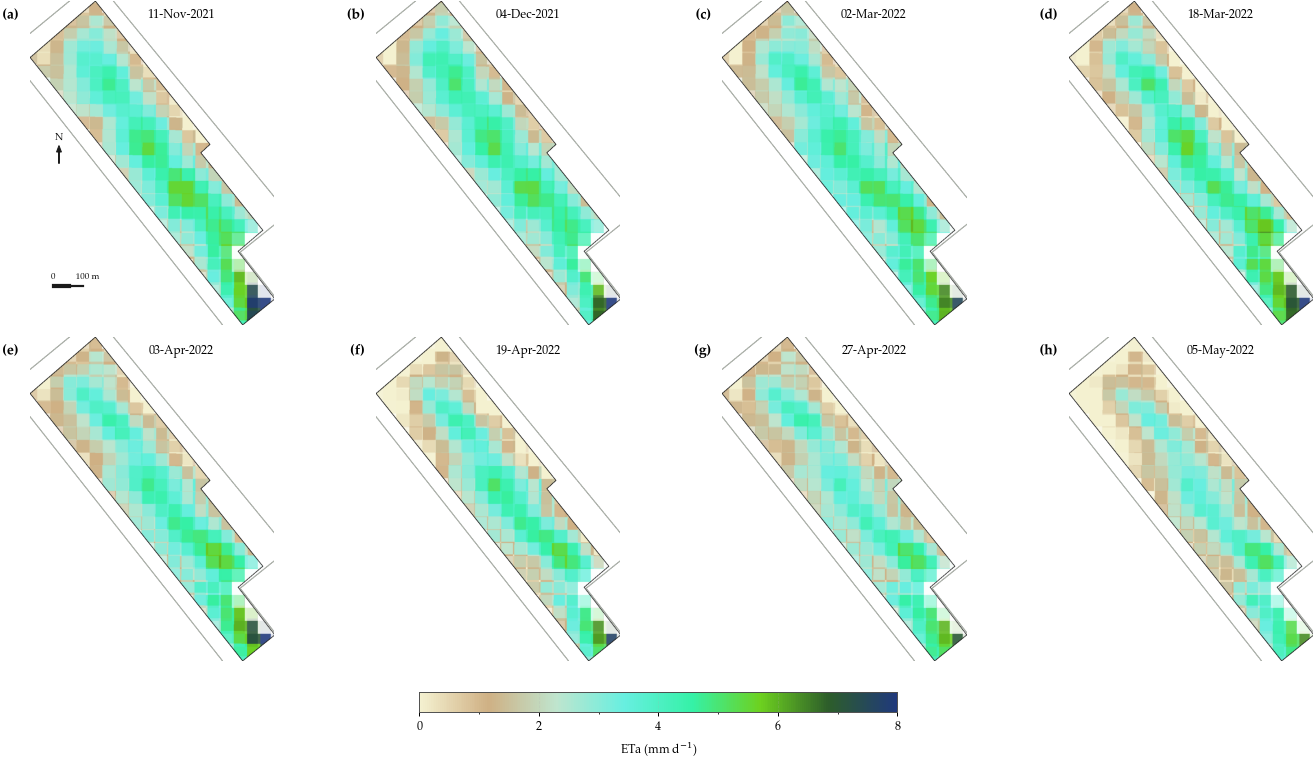

In [49]:
# -*- coding: utf-8 -*-
"""
ETc Mosaic (cartoee) — ROI 'Olive' clipped + outline — Q1-ready
- Usa tu `lista_et` (list[ee.Image]) ya creada
- Sin marcos ni fondos blancos que tapen el raster
- Contorno ROI negro
- Colorbar 0–8 con borde gris fino
- Exporta PNG @ 600 dpi
"""

# =========================
# 📦 IMPORTS & EE INIT
# =========================
import os, math, re
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyBboxPatch
from matplotlib.patheffects import withStroke
import cartopy.crs as ccrs
from geemap import cartoee
import ee, geemap
import string

try:
    geemap.ee_initialize()
except Exception:
    ee.Initialize()

# =========================
# 🖋️ TYPOGRAPHY / STYLE
# =========================
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype", "Book Antiqua", "Palatino", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "dejavuserif",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# =========================
# 🧩 USER INPUTS
# =========================
lista_fechas = [
    "11-Nov-2021","04-Dic-2021","02-Mar-2022","18-Mar-2022",
    "03-Abr-2022","19-Abr-2022","27-Abr-2022","05-May-2022"
]

try:
    predios_vis
except NameError:
    predios_vis = None

ROI_ASSET = "projects/ee-joluhumu/assets/Olive"
SHP_PATH  = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"

DATE_FMT, DATE_FONTSZ = "%d-%b-%Y", 12
DATE_MODE, DATE_POS_AX = "axes", (0.62, 0.98)
DATE_HALIGN, DATE_VALIGN = "center", "top"
DATE_OFFSET_X, DATE_OFFSET_Y = 0.02, 0.02

# =========================
# 🟩 Parámetros del contorno del ROI
# =========================
ROI_BORDER_COLOR   = "000000"   # Color del borde del ROI en formato hexadecimal (aquí negro)
ROI_BORDER_WIDTH   = 2          # Grosor del contorno del ROI en píxeles
ROI_BORDER_OPACITY = 1.0        # Opacidad del borde (1.0 = completamente opaco, 0.0 = transparente)

# =========================
# 🎛️ RANGO DE LEYENDA (COLORBAR)
# =========================
ETC_MIN, ETC_MAX = 0.0, 8.0     # Valores mínimo y máximo del rango mostrado en la barra de color (ETc en mm/día)
AUTO_CB_RANGE = False            # Si True, calcula el rango automáticamente según percentiles; si False, usa ETC_MIN y ETC_MAX
TICKS_MAJOR = np.linspace(0, 8, 5)  # Ticks principales de la barra de color (0, 2, 4, 6, 8)
TICKS_MINOR = np.linspace(0, 8, 9)  # Ticks menores de la barra de color (0,1,2,...,8)


salida_png = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc/Mosaico_ETc_Q1_ROI.png"

# =========================
# 🎨 COLORMAP
# =========================
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
cmap_cont = LinearSegmentedColormap.from_list("ETc_Q1", palette_stops, N=256)
def rgba_to_hex(rgba): r,g,b = (int(255*x) for x in rgba[:3]); return f"#{r:02x}{g:02x}{b:02x}"

# =========================
# 🗂️ ROI + BBOX
# =========================
def load_roi_and_bbox():
    try:
        fc = ee.FeatureCollection(ROI_ASSET)
        _ = fc.limit(1).getInfo()
    except Exception:
        fc = geemap.shp_to_ee(SHP_PATH)
    geom = fc.geometry()
    coords = geom.bounds(1).coordinates().get(0).getInfo()
    xs = [p[0] for p in coords]; ys = [p[1] for p in coords]
    return geom, [min(xs), min(ys), max(xs), max(ys)]

roi_geom, zoom_region = load_roi_and_bbox()
def make_roi_outline_image(color_hex="000000", width_px=2, opacity=1.0):
    out = ee.Image().paint(roi_geom, 1, width_px).visualize(palette=[f"#{color_hex}"])
    return out.updateMask(ee.Image.constant(opacity))
roi_outline_img = make_roi_outline_image(ROI_BORDER_COLOR, ROI_BORDER_WIDTH, ROI_BORDER_OPACITY)

# =========================
# 📆 DATES
# =========================
_SP2EN = {"ene":"Jan","feb":"Feb","mar":"Mar","abr":"Apr","may":"May","jun":"Jun",
          "jul":"Jul","ago":"Aug","set":"Sep","sep":"Sep","oct":"Oct","nov":"Nov","dic":"Dec"}
def normalize_dates_to_english(date_list, out_fmt="%d-%b-%Y"):
    out=[]
    for s in date_list:
        s0=str(s).strip()
        for fmt in ("%d-%b-%Y","%d-%m-%Y","%Y-%m-%d"):
            try: out.append(datetime.strptime(s0,fmt).strftime(out_fmt)); break
            except: pass
        else:
            d,m,y=re.split(r"[-/\s]",s0)
            m_en=_SP2EN.get(m.lower(),m)
            try: out.append(datetime.strptime(f"{d}-{m_en}-{y}","%d-%b-%Y").strftime(out_fmt))
            except: out.append(s0)
    return out
fechas_en = normalize_dates_to_english(lista_fechas, DATE_FMT)

# =========================
# 🧭 SCALE & NORTH (sin fondo blanco)
# =========================
def scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12):
    trans=ax.transAxes; x0,y0=loc; L=width_axes
    # Sin fondo — para evitar tapar el raster
    ax.plot([x0,x0+L],[y0,y0],transform=trans,lw=2.2,color='0.1',zorder=2)
    ax.plot([x0,x0+L/2],[y0,y0],transform=trans,lw=4.2,color='0.1',zorder=2)
    ax.text(x0-0.013, y0 + 0.020,'0         100 m',transform=trans,fontsize=9,
            va='bottom',color='0.05',zorder=2)  

def north_arrow(ax,loc=(0.12,0.50)):
    x,y=loc; trans=ax.transAxes
    # Sin fondo — para evitar tapar el raster
    ax.arrow(x,y,0,0.055,transform=trans,width=0.0035,head_width=0.02,head_length=0.02,
             color='0.1',length_includes_head=True,zorder=2)
    ax.text(x,y+0.065,'N',transform=trans,ha='center',va='bottom',
            fontsize=10,color='0.05',zorder=2)

# =========================
# 📐 LAYOUT
# =========================
n_imgs=len(lista_et)
cols=4; rows_panels=math.ceil(n_imgs/cols); rows_total=rows_panels+1
fig=plt.figure(figsize=(20,5*rows_panels+1.2))
gs=fig.add_gridspec(nrows=rows_total,ncols=cols,height_ratios=[1]*rows_panels+[0.18],wspace=0.03,hspace=0.05)
axs=[[fig.add_subplot(gs[r,c],projection=ccrs.PlateCarree()) for c in range(cols)] for r in range(rows_panels)]
fig.subplots_adjust(left=0.035,right=0.99,top=0.985,bottom=0.08)
xmin,ymin,xmax,ymax=zoom_region; dx,dy=xmax-xmin,ymax-ymin
FECHA_X_geo=xmin+DATE_OFFSET_X*dx; FECHA_Y_geo=ymax-DATE_OFFSET_Y*dy
pe=[withStroke(linewidth=3,foreground="white",alpha=0.9)]
abc=list(string.ascii_lowercase)
palette_map=[rgba_to_hex(c) for c in [cmap_cont(s) for s in np.linspace(0,1,64)]]
vis_ET={"min":ETC_MIN,"max":ETC_MAX,"palette":palette_map}

# =========================
# 🗺️ DRAW PANELS
# =========================
for idx in range(rows_panels):
    for jdx in range(cols):
        i=idx*cols+jdx
        ax=axs[idx][jdx]
        if i<n_imgs:
            base=lista_et[i].clip(roi_geom)
            img=base if predios_vis is None else base.blend(predios_vis)
            cartoee.add_layer(ax,img,dims=1000,region=zoom_region,vis_params=vis_ET)
            cartoee.add_layer(ax,roi_outline_img,region=zoom_region,dims=1000)
            ax.text(-0.045,0.98,f'({abc[i]})',transform=ax.transAxes,fontsize=14,fontweight='bold',va='top',ha='right',path_effects=pe,zorder=3)
            ax.text(DATE_POS_AX[0],DATE_POS_AX[1],fechas_en[i],transform=ax.transAxes,fontsize=DATE_FONTSZ,va=DATE_VALIGN,ha=DATE_HALIGN,zorder=3)
            ax.set_frame_on(False); ax.axis('off')
            if i==0: scalebar_100m(ax); north_arrow(ax)
        else: ax.axis('off')

# =========================
# 📊 COLORBAR
# =========================
cax=fig.add_subplot(gs[-1,2:4])
box=cax.get_position()
new_height=box.height*0.35; y_centered=box.y0+(box.height-new_height)/2
new_width=box.width*0.70; x_centered=box.x0-(new_width/1.86)
cax.set_position([x_centered,y_centered,new_width,new_height])

norm_cb=mpl.colors.Normalize(vmin=ETC_MIN,vmax=ETC_MAX)
cb=mpl.colorbar.ColorbarBase(cax,cmap=cmap_cont,norm=norm_cb,orientation="horizontal",ticks=TICKS_MAJOR,spacing="proportional")
cb.ax.set_xticks(TICKS_MINOR,minor=True)
cb.ax.tick_params(which='major',labelsize=12,length=4,width=1)
cb.ax.tick_params(which='minor',length=2,width=0.8)
cb.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
cb.set_label(r'ETa (mm d$^{-1}$)',fontsize=12,labelpad=6)

# 🎨 Bordecito elegante
for spine in cax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color('0.3')

# =========================
# 💾 SAVE
# =========================
os.makedirs(os.path.dirname(salida_png),exist_ok=True)
plt.savefig(salida_png,dpi=600,bbox_inches="tight",facecolor="white",pil_kwargs={"optimize":True})
print(f"✅ Figure exported to: {salida_png}")
plt.show()


✅ Figure exported to: C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc/Mosaico_ET_Q1_ROI.png


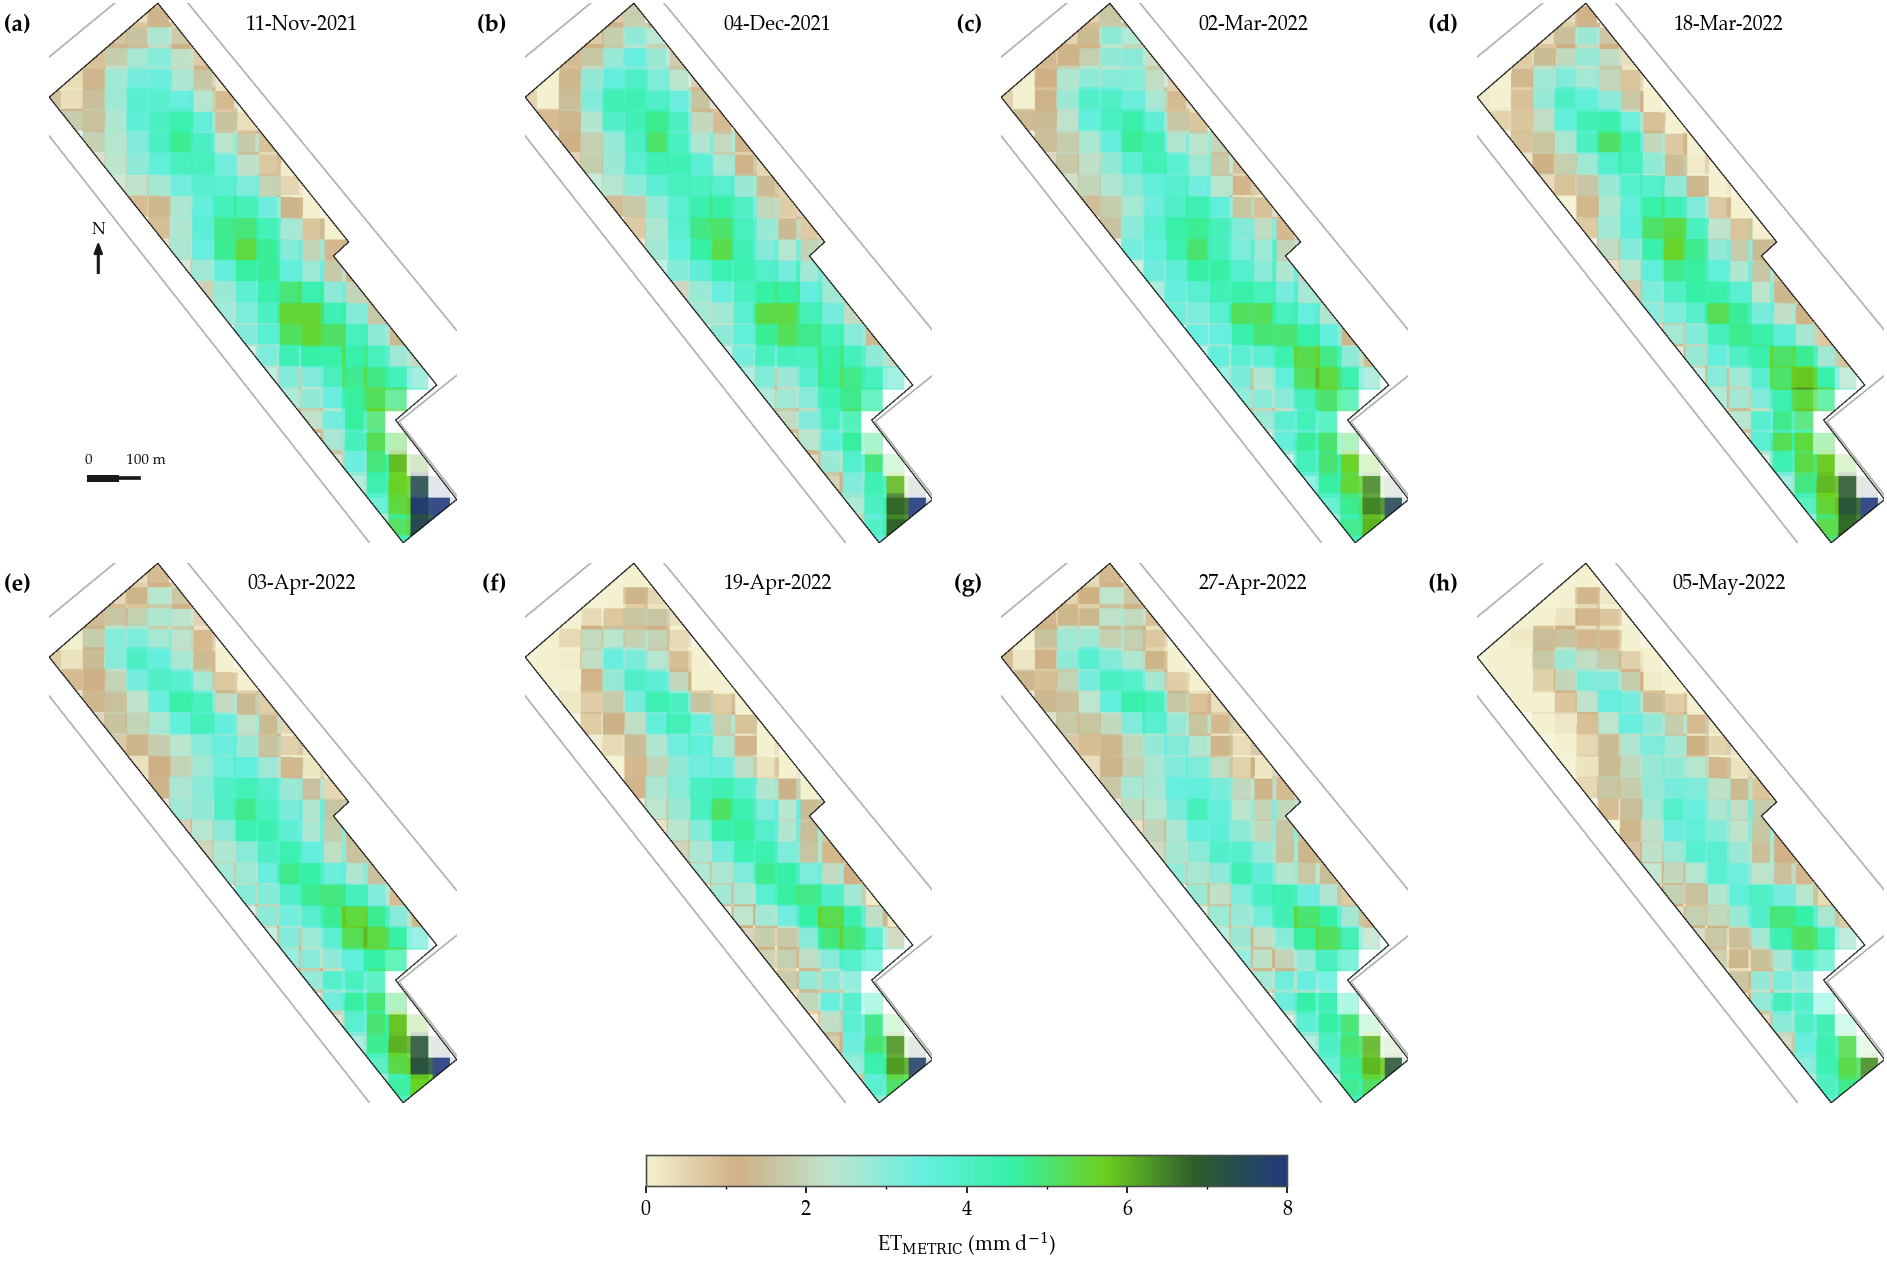

In [23]:
# -*- coding: utf-8 -*-
"""
ET Mosaic (cartoee) — ROI 'Olive' clipped + outline — Q1-ready
- Usa tu `lista_et` (list[ee.Image]) ya creada (una imagen por fecha)
- Sin marcos ni fondos que tapen el raster
- Contorno ROI negro
- Colorbar 0–8 con borde gris fino
- Exporta PNG @ 600 dpi
"""

# =========================
# 📦 IMPORTS & EE INIT
# =========================
import os, math, re, string
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patheffects import withStroke
import cartopy.crs as ccrs
from geemap import cartoee
import ee, geemap

try:
    geemap.ee_initialize()
except Exception:
    ee.Initialize()

# =========================
# 🖋️ TIPOGRAFÍA / ESTILO
# =========================
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.edgecolor": "black",
    "axes.titlecolor": "black",
    "font.family": "serif",
    "font.serif": ["Palatino Linotype", "Book Antiqua", "Palatino", "Times New Roman", "DejaVu Serif"],
    "mathtext.fontset": "dejavuserif",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# =========================
# 🧩 ENTRADAS DEL USUARIO
# =========================
# Debes tener lista_et ya definida: list[ee.Image], una por cada fecha.
# Ejemplo de fechas (para rótulos); ajusta a tus fechas reales:
lista_fechas = [
    "11-Nov-2021","04-Dic-2021","02-Mar-2022","18-Mar-2022",
    "03-Abr-2022","19-Abr-2022","27-Abr-2022","05-May-2022"
]


# Capa opcional de polígonos/estilos a superponer (puede dejarse en None)
try:
    predios_vis
except NameError:
    predios_vis = None

ROI_ASSET = "projects/ee-joluhumu/assets/Olive"
SHP_PATH  = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/data/processed/shapefiles/Olive.shp"

# Archivo de salida
salida_png = r"C:/Users/joluh/OneDrive/Thesis/Articles/Tacna/Metric_Olive_21_22/figs/processed/ETc/Mosaico_ET_Q1_ROI.png"

# =========================
# 🎛️ PARÁMETROS VISUALES
# =========================
# Rango de la barra de color
ET_MIN, ET_MAX = 0.0, 8.0
TICKS_MAJOR = np.linspace(0, 8, 5)   # 0, 2, 4, 6, 8
TICKS_MINOR = np.linspace(0, 8, 9)   # 0–8 paso 1

# Fecha
DATE_FMT, DATE_FONTSZ = "%d-%b-%Y", 12
DATE_MODE, DATE_POS_AX = "axes", (0.62, 0.98)
DATE_HALIGN, DATE_VALIGN = "center", "top"
DATE_OFFSET_X, DATE_OFFSET_Y = 0.02, 0.02

# Contorno del ROI
ROI_BORDER_COLOR   = "000000"  # negro (hex sin #)
ROI_BORDER_WIDTH   = 2
ROI_BORDER_OPACITY = 1.0

# Paleta continua (Q1-friendly)
palette_stops = [
    "#f4f1d0", "#cfb084", "#bfe5ce", "#67efe0",
    "#35f1a7", "#6dd11f", "#2d5d2a", "#20397c",
]
cmap_cont = LinearSegmentedColormap.from_list("ET_Q1", palette_stops, N=256)
def rgba_to_hex(rgba):
    r, g, b = (int(255*x) for x in rgba[:3])
    return f"#{r:02x}{g:02x}{b:02x}"

# =========================
# 🗂️ ROI + BBOX
# =========================
def load_roi_and_bbox():
    """Carga ROI desde asset; si falla, desde SHP. Devuelve (geom, [xmin,ymin,xmax,ymax])."""
    try:
        fc = ee.FeatureCollection(ROI_ASSET)
        _ = fc.limit(1).getInfo()
    except Exception:
        fc = geemap.shp_to_ee(SHP_PATH)
    geom = fc.geometry()
    coords = geom.bounds(1).coordinates().get(0).getInfo()
    xs = [p[0] for p in coords]; ys = [p[1] for p in coords]
    return geom, [min(xs), min(ys), max(xs), max(ys)]

roi_geom, zoom_region = load_roi_and_bbox()

def make_roi_outline_image(color_hex="000000", width_px=2, opacity=1.0):
    """Crea una imagen estilo contorno del ROI."""
    color = f"#{color_hex.lstrip('#')}"
    out = ee.Image().paint(roi_geom, 1, width_px).visualize(palette=[color])
    return out.updateMask(ee.Image.constant(opacity))

roi_outline_img = make_roi_outline_image(ROI_BORDER_COLOR, ROI_BORDER_WIDTH, ROI_BORDER_OPACITY)

# =========================
# 📆 FECHAS (normalización ES→EN para %b)
# =========================
_SP2EN = {"ene":"Jan","feb":"Feb","mar":"Mar","abr":"Apr","may":"May","jun":"Jun",
          "jul":"Jul","ago":"Aug","set":"Sep","sep":"Sep","oct":"Oct","nov":"Nov","dic":"Dec"}

def normalize_dates_to_english(date_list, out_fmt="%d-%b-%Y"):
    out=[]
    for s in date_list:
        s0=str(s).strip()
        for fmt in ("%d-%b-%Y","%d-%m-%Y","%Y-%m-%d"):
            try:
                out.append(datetime.strptime(s0,fmt).strftime(out_fmt))
                break
            except Exception:
                pass
        else:
            # dd-mmm-YYYY con mes en español
            d,m,y=re.split(r"[-/\s]",s0)
            m_en=_SP2EN.get(m.lower(),m)
            try:
                out.append(datetime.strptime(f"{d}-{m_en}-{y}","%d-%b-%Y").strftime(out_fmt))
            except Exception:
                out.append(s0)
    return out

fechas_en = normalize_dates_to_english(lista_fechas, DATE_FMT)

# =========================
# 🧭 ESCALA & NORTE (sin fondo opaco)
# =========================
def scalebar_100m(ax, loc=(0.10, 0.12), width_axes=0.12):
    trans=ax.transAxes; x0,y0=loc; L=width_axes
    ax.plot([x0,x0+L],[y0,y0],transform=trans,lw=2.2,color='0.1',zorder=2)
    ax.plot([x0,x0+L/2],[y0,y0],transform=trans,lw=4.2,color='0.1',zorder=2)
    ax.text(x0-0.013, y0 + 0.020,'0         100 m',transform=trans,fontsize=9,
            va='bottom',color='0.05',zorder=2)

def north_arrow(ax,loc=(0.12,0.50)):
    x,y=loc; trans=ax.transAxes
    ax.arrow(x,y,0,0.055,transform=trans,width=0.0035,head_width=0.02,head_length=0.02,
             color='0.1',length_includes_head=True,zorder=2)
    ax.text(x,y+0.065,'N',transform=trans,ha='center',va='bottom',
            fontsize=10,color='0.05',zorder=2)

# =========================
# 🛠️ FIX: Asegurar 1 banda (ETa o ETc) antes de visualizar
# =========================
BAND_HINTS = ['ETa', 'ETc', 'ET_mm_d', 'ETc_mm_d', 'ET']  # orden de preferencia

def pick_one_band(img, band_hints=BAND_HINTS):
    """Devuelve (imagen_1_banda, nombre_banda_elegida). Si no encuentra por nombre, usa la primera."""
    bn = ee.List(img.bandNames())
    # Busca por prioridad
    chosen = None
    for h in band_hints:
        try:
            if bn.contains(h).getInfo():
                chosen = h
                break
        except Exception:
            pass
    if chosen is None:
        chosen = bn.get(0).getInfo()
    return img.select([chosen]), chosen

# Paleta para visualize (64 steps) — robusta y ligera
palette_map=[rgba_to_hex(c) for c in [cmap_cont(s) for s in np.linspace(0,1,64)]]

# vis_params si se usa add_layer directamente sobre la 1-banda
vis_ET={"min": ET_MIN, "max": ET_MAX, "palette": palette_map}

# =========================
# 📐 LAYOUT
# =========================
# Número de paneles: deduce de tu lista_et (debe existir)
n_imgs = len(lista_et)
cols = 4
rows_panels = math.ceil(n_imgs / cols)
rows_total = rows_panels + 1  # + fila del colorbar

fig = plt.figure(figsize=(20, 5*rows_panels + 1.2))
gs = fig.add_gridspec(
    nrows=rows_total,
    ncols=cols,
    height_ratios=[1]*rows_panels + [0.18],
    wspace=-0.45, hspace=0.05
)
axs = [[fig.add_subplot(gs[r,c], projection=ccrs.PlateCarree()) for c in range(cols)] for r in range(rows_panels)]
fig.subplots_adjust(left=0.035, right=0.99, top=0.985, bottom=0.08)

xmin,ymin,xmax,ymax = zoom_region
dx, dy = xmax - xmin, ymax - ymin
pe = [withStroke(linewidth=3, foreground="white", alpha=0.9)]
abc = list(string.ascii_lowercase)

# =========================
# 🗺️ DIBUJAR PANELES
# =========================
chosen_band_global = None

for idx in range(rows_panels):
    for jdx in range(cols):
        i = idx*cols + jdx
        ax = axs[idx][jdx]
        if i < n_imgs:
            # 1) Fuerza imagen de 1 banda (evita error de palette>1 banda)
            img_in = lista_et[i]
            base_1b, chosen_band = pick_one_band(img_in)
            if chosen_band_global is None:
                chosen_band_global = chosen_band  # para rotular el colorbar

            # 2) Clip a ROI y mezcla opcional de estilos
            base = base_1b.clip(roi_geom)
            img  = base if predios_vis is None else base.blend(predios_vis)

            # 3) Visualiza (opción robusta con vis_params)
            cartoee.add_layer(ax, img, dims=1000, region=zoom_region, vis_params=vis_ET)

            # 4) Contorno ROI
            cartoee.add_layer(ax, roi_outline_img, region=zoom_region, dims=1000)

            # 5) Etiquetas (panel y fecha)
            ax.text(-0.045, 0.98, f'({abc[i]})', transform=ax.transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='right',
                    path_effects=pe, zorder=3)

            ax.text(DATE_POS_AX[0], DATE_POS_AX[1], fechas_en[i], transform=ax.transAxes,
                    fontsize=DATE_FONTSZ, va=DATE_VALIGN, ha=DATE_HALIGN, zorder=3)

            ax.set_frame_on(False)
            ax.axis('off')

            # 6) Escala/Norte en el primer panel
            if i == 0:
                scalebar_100m(ax); north_arrow(ax)
        else:
            ax.axis('off')

# =========================
# 📊 COLORBAR (centrado)
# =========================
cax = fig.add_subplot(gs[-1, :])  # ← ocupa toda la última fila
box = cax.get_position()

# Ajustar alto y centrar verticalmente
new_height = box.height * 0.32
y_centered = box.y0 + (box.height - new_height) / 2

# Ajustar ancho (80% del ancho total) y centrar horizontalmente
new_width = box.width * 0.28
x_centered = box.x0 + (box.width - new_width) / 2

cax.set_position([x_centered, y_centered, new_width, new_height])

norm_cb = mpl.colors.Normalize(vmin=ET_MIN, vmax=ET_MAX)
cb = mpl.colorbar.ColorbarBase(
    cax, cmap=cmap_cont, norm=norm_cb,
    orientation="horizontal", ticks=TICKS_MAJOR, spacing="proportional"
)
cb.ax.set_xticks(TICKS_MINOR, minor=True)
cb.ax.tick_params(which='major', labelsize=12, length=4, width=1)
cb.ax.tick_params(which='minor', length=2, width=0.8)
cb.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))

# Etiqueta coherente con la banda elegida
cb_label = r'ET$_{\mathrm{METRIC}}$ (mm d$^{-1}$)' if (chosen_band_global or '').lower().startswith('eta') else r'ET$_{\mathrm{METRIC}}$ (mm d$^{-1}$)'
cb.set_label(cb_label, fontsize=12, labelpad=6)

# Borde del colorbar
for spine in cax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.8)
    spine.set_color('0.3')

# =========================
# 💾 SAVE
# =========================
os.makedirs(os.path.dirname(salida_png), exist_ok=True)
plt.savefig(salida_png, dpi=600, bbox_inches="tight", facecolor="white", pil_kwargs={"optimize": True})
print(f"✅ Figure exported to: {salida_png}")
plt.show()


### 3.3.2. Gráficas 1x1 de ET

Producir 6 imágenes como mosaico y agregar la última

In [220]:
# Función
def get_grafica_cartoee_color(image,
                              vis_params,
                              figsize=None,
                              text=None,
                              title_map=None,
                              label=None,
                              save_fig=None,
                              nogrid=None,
                              scale_bar=None):

    """Obtener gráficas con cartoee
    La variable zoom_region debe asignarse según la zona de estudio.
    Para modificaciones seguir: https://geemap.org/cartoee/#cartoee-module
    """

    # Establecer área de plot usando las coordenadas de predios_bound.coordinates().getInfo()
    extent = 0.0005
    zoom_region = [
        -79.77332525015065+extent, -6.605665317455976-extent,
        -79.78719338866794-extent, -6.594549+extent
    ]

    # Establecer figsize para plot
    if figsize == None:
        # fig = plt.figure(figsize=(5,5)) # Para juntar en forma de mosaicos
        fig = plt.figure(figsize=(8,6)) # Para analizar
        # fig = plt.figure(figsize=(16,12)) # Para recortar la barra
    else:
        fig = plt.figure(figsize=figsize) # Para analizar

    # ee.Image a plotear
    ax = cartoee.get_map(image, region=zoom_region, vis_params=vis_params)

    # Añadir grillas
    if nogrid == True:
        ax.axis('off')
    else:
        cartoee.add_gridlines(ax,
                              interval=0.005,
                              ytick_rotation=90,
                              linestyle=":",
                              linewidth=0 # Grillas invisibles
                              ) # xtick_rotation=45

    # Añadir barra de color
    if label != None:
        cartoee.add_colorbar(ax,
                             vis_params=vis_params,
                             loc='right',
                             # label=label,
                             #posOpts=[0.86, 0.25, 0.02, 0.5],
                             posOpts= [
                                 0.9, # left
                                 0.25,  # bottom
                                 0.04,  # width
                                 0.5   # height
                                 ],
                             tick_font_size=14,
                             # ticks= [0,2,4,6,8,10],
                             # drawedges=True,
                             # extend='both', # Genera flechas hacia los extremos
                             discrete=True,
                             spacing='proportional'
                             )
        ax.text(-79.77332525015065+2*extent, -6.594549+2*extent, label, fontsize=16)

    # Añadir texto
    if title_map != None:
        ax.set_title(title_map) # , fontsize=11

    if text != None:
        ax.text(-79.7872, -6.594549+2*extent, text, fontsize=16)
        # fontsize=18 para mejor visibilidad en mosaicos

    # add scale bar
    if scale_bar != None:
        scale_bar_dict = {
            "length": 100,
            "xy": (0.9, 0.05),
            "linewidth": 2,
            "fontsize": 12,
            "color": "black",
            "unit": "m",
            "ha": "center",
            "va": "bottom",
        }
        cartoee.add_scale_bar_lite(ax, **scale_bar_dict)

    ax.tick_params(axis = 'both') # , labelsize = 9

    # Guardar graficas
    if save_fig != None:
        plt.savefig(save_fig + '.png', bbox_inches = 'tight', pad_inches = .1)#, dpi=400)
        # Recortar márgenes con ayuda de bbox_inches y pad_inches

    plt.show()

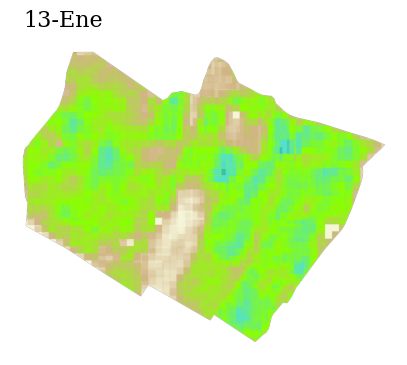

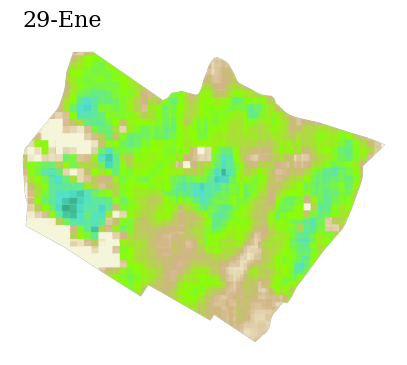

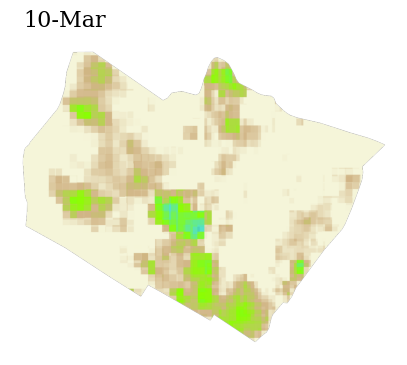

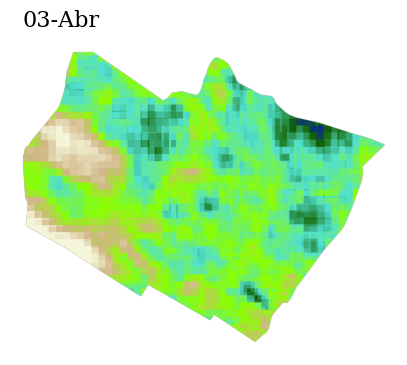

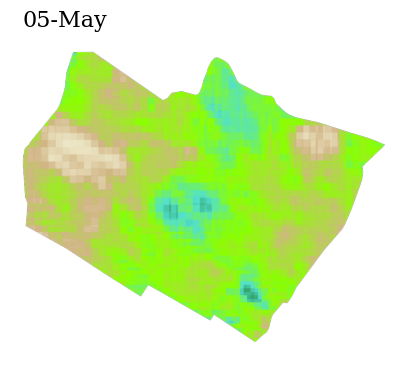

In [88]:
# Parámetros de visualización
# lista_fechas = ['13-Ene', '29-Ene', '10-Mar', '03-Abr', '05-May', '21-May','14-Jun']
imgs_ET = lista_et

paleta_ET = ["#F5F5D9", "#D1B586", "#8BFF00", "#52E0CF", "#136400", "#0000FF"] # "F5F5D9","D1B586","8BFF00","52E0CF","136400","0000FF"
vis_ET = {'min': 0, 'max': 10, 'palette': paleta_ET}

for i in range(n_imgs-1):
    nombre_img = f"ET_{lista_imgprocesadas[i]['fecha']}_3"
    get_grafica_cartoee_color(imgs_ET[i],
                              vis_ET,
                              figsize=(5,5),
                              text=lista_fechas[i],
                              save_fig=os.path.join(carpeta_output, nombre_img),
                              nogrid=True)

#### Prueba discretización

In [ ]:
# # Prueba Discretización
# img = imgs_ET[0]

# img_et_prueba = {
#     ee.Image(0)
#     .where(img.gte(0),1)
#     .where(img.gte(2),2)
#     .where(img.gte(4),3)
#     .where(img.gte(6),4)
#     .where(img.gte(8),5)
#     .where(img.gte(10),6).clip(predios_agricolas)
# }

# viz_clas = {'palette': ["#F5F5D9", "#D1B586", "#52E0CF", "#8BFF00", "#136400", "#0000FF"],
#             'min': 1,
#             'max': 6}
# # Mapas
# Map = geemap.Map()
# Map.centerObject(img_et_prueba, 16)
# Map.addLayer(img_et_prueba, viz_clas, 'img_et_prueba')
# Map

## 3.4. Boxplot

### 3.4.1. Lectura de archivos

In [92]:
# Import de archivo `.shp` de variedades

# Imports
path_parcelas = r'input/Parcelas_wgs84_clip.shp'
fcol_parcelas = geemap.shp_to_ee(path_parcelas)

# 5 Variedades de arroz
fcol_parcelas_var1 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'CAPOTEÑA')
fcol_parcelas_var2 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'GALAN')
fcol_parcelas_var3 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'PAKAMURO')
fcol_parcelas_var4 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'PUNTILLA')
fcol_parcelas_var5 = fcol_parcelas.filterMetadata('VARIEDAD', 'equals', 'VALOR')

# 2 Tipos de siembra
fcol_parcelas_met1 = fcol_parcelas.filterMetadata('Metodo_de_', 'equals', 'TRANSPLANTE')
fcol_parcelas_met2 = fcol_parcelas.filterMetadata('Metodo_de_', 'equals', 'SIEMBRA DIRECTA')

# Listas con nombres
variedades_list = ['Capoteña', 'Galan', 'Pakamuro', 'Puntilla', 'Valor']
list_met_names = ['Transplante', 'Siembra Directa']

The input shapefile could not be found.


AttributeError: 'NoneType' object has no attribute 'filterMetadata'

### 3.4.2. Armado de Dataframes

**Procesado para boxplot**

Inputs:
- Imagen de ET por fecha y con valores positivos
- Shapefiles de áreas a analizar

Procesamiento:
- Extraer valores de pixeles dentro de las áreas a analizar:
    - Tipos de cultivos (5 tipos)
    - Tipos de siembra (2 tipos)

In [103]:
# Preparamos una lista con imagenes de ET
lista_et = []
for i in range(n_imgs):
    lista_et.append(lista_imgprocesadas_ET[i]['img_ETinst']) # Banda 'ET'

pprint(lista_et)

# Convertimos la lista de imagenes en una sola con cada elemento como banda
# img_ET_final = ee.Image(lista_et)
# img_ET_final.bandNames().getInfo() # Asigna el sufijo _# dependiendo del número de bandas comenzando desde el segundo con _1

# lista_et

In [ ]:
# Por cada fecha procesada, correr celdas
# img_ET_pos = img_ET_inst.updateMask(img_ET_inst.gte(0))#.blend(predios_vis) # <---
# img_ET_neg = img_ET_inst.updateMask(img_ET_inst.lt(0))#.blend(predios_vis)

In [104]:
# Extraer valores de pixeles dentro de las áreas

# 5 Tipos de cultivos
list_et_val1 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var1, 30).get('ET').getInfo()
list_et_val2 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var2, 30).get('ET').getInfo()
list_et_val3 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var3, 30).get('ET').getInfo()
list_et_val4 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var4, 30).get('ET').getInfo()
list_et_val5 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_var5, 30).get('ET').getInfo()

list_values = [list_et_val1, list_et_val2, list_et_val3, list_et_val4, list_et_val5]

# 2 Tipos de siembra
list_et_met1 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_met1, 30).get('ET').getInfo()
list_et_met2 = img_ET_pos.reduceRegion(ee.Reducer.toList(), fcol_parcelas_met2, 30).get('ET').getInfo()

list_met = [list_et_met1, list_et_met2]

NameError: name 'img_ET_pos' is not defined

**Boxplot con seaborn**

El boxplot se armará mediante un DataFrame con los datos de los pixeles (uno muy grande por cierto).

Referencia:[Seaborn - boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

Procesamiento:
- Armar el DataFrame por tipo con `pd.concat`

In [101]:
import seaborn as sns

def prepare_df_vertical(lista_escogida, lista_title, column_name):
    df = pd.DataFrame(list(zip(lista_escogida)), columns=['Valores'])
    df[column_name] = lista_title
    return df